In [6]:
# from kaggle.competitions import nflrush
# env = nflrush.make_env()
import pandas as pd
import seaborn as sns
import numpy as np
import math
import datetime
import re

import lightgbm as lgb
import xgboost as xgb
sns.set()

In [7]:
data = pd.read_csv('train_proc.csv')

In [8]:

# data['GameClock'] = pd.to_datetime(data['GameClock'], format='%Y-%m-%d %H:%M:%S')
# data['PlayerBirthDate'] = pd.to_datetime(data['PlayerBirthDate'],format='%Y-%m-%d')
data = data.drop(['GameClock','PlayerBirthDate','Unnamed: 0'],axis=1)

In [9]:
from sklearn.model_selection import GroupKFold
cat_vars = data.select_dtypes(include='object').columns
cont_vars = data.select_dtypes(exclude='object').columns
print(cat_vars)
print(cont_vars)
cont_medians = {}
for col in cont_vars:
    print(col)
    data[col] = data[col].fillna(data[col].median())
    cont_medians[col] = data[col].median()

for col in cat_vars:
    data[col] = data[col].fillna('Missing')    

from sklearn.preprocessing import LabelEncoder

le_dict = {}
for col in cat_vars:
    le = LabelEncoder()
    le.fit(list(set(data[col].values))+['Missing'])
    le_dict[col] = le
    data[col] = le.transform(data[col])
#     test[col] = le.transform(list(test[col].astype(str).values))   

Index(['Team', 'DisplayName', 'PossessionTeam', 'FieldPosition',
       'OffenseFormation', 'OffensePersonnel', 'DefensePersonnel',
       'PlayDirection', 'TimeHandoff', 'TimeSnap', 'PlayerHeight',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'WindDirection', 'TeamOnOffense', 'City', 'State', 'GameWeatherGrouped',
       'TeamName'],
      dtype='object')
Index(['GameId', 'PlayId', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir',
       'NflId', 'JerseyNumber', 'Season', 'YardLine', 'Quarter', 'Down',
       'Distance', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'DefendersInTheBox', 'Yards', 'PlayerWeight', 'Week',
       'Temperature', 'Humidity', 'WindSpeed', 'ToLeft', 'IsBallCarrier',
       'Dir_rad', 'IsOnOffense', 'YardLine_std', 'X_std', 'Y_std', 'Dir_std',
       'isNatural', 'PlayerAge', 'PlayerHeightCm', 'TimeElapsed',
       'Offense #OL', 'Of

In [10]:
list(set(data['Team'].values))+['Missing']

[1, 2, 'Missing']

In [27]:
from sklearn.metrics import *

models = []
crps_scores = []
def train_model(X, y, folds, model_type='lgb', eval_metric='auc', n_jobs=-1, n_estimators=None, plot_feature_importance=True, verbose=500,early_stopping_rounds=200):
    result_dict = {}
    scores = []
    n_splits = folds.n_splits
    columns = X.columns
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), 1))
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y,X['GameId'])):
        print('Fold nr {}'.format(fold_n))
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        model = lgb.LGBMRegressor(n_estimators=n_estimators, n_jobs = n_jobs)
        model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                verbose=verbose, early_stopping_rounds=early_stopping_rounds)
        models.append(model)
        y_pred = model.predict(X_valid)
        rmse = np.sqrt(mean_absolute_error(y_valid, y_pred))
        oof[valid_index] = y_pred.reshape(-1, 1)
        y_pred_crps = np.zeros((len(y_pred),199))
        y_ans = np.zeros((len(y_pred),199))

        for i,p in enumerate(y_pred):
            p+=99
            for j in range(199):
                if j>=p+10:
                    y_pred_crps[i][j]=1.0
                elif j>=p-10:
                    y_pred_crps[i][j]=(j+10-p)*0.05


        for i,p in enumerate(y_valid):
            try:
                p+=99
                for j in range(199):
                    if j>=p:
                        y_ans[i][j]=1.0
            except:
                print(i,j)
                raise Exception
        crps = np.sum(np.power(y_pred_crps-y_ans,2))/(199*(509762//22))
        print("CRPS validation score:",crps)
        crps_scores.append(crps)
        scores.append(rmse)
    
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print('CV mean score MAE: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    print('CRPS avg',np.mean(crps_scores))
    
    result_dict['oof'] = oof
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            best_features = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].reset_index(level=['feature'])


            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features);
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = best_features['feature'].unique()
        
    return result_dict

In [28]:
rushers = data[data.NflId==data.NflIdRusher]

Fold nr 0
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's l1: 3.38469	training's l2: 32.0858	valid_1's l1: 3.5223	valid_1's l2: 35.6152
CRPS validation score: 0.0029729898237263394
Fold nr 1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's l1: 3.38893	training's l2: 32.4974	valid_1's l1: 3.64389	valid_1's l2: 37.9479
CRPS validation score: 0.0030436814266089247
Fold nr 2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's l1: 3.43376	training's l2: 33.1722	valid_1's l1: 3.67478	valid_1's l2: 40.5449
CRPS validation score: 0.003072943518982707
Fold nr 3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[32]	training's l1: 3.38034	training's l2: 31.633	valid_1's l1: 3.67805	valid_1's l2: 41.2981
CRPS validation score: 0.003084198289776461
Fold nr 4
Traini

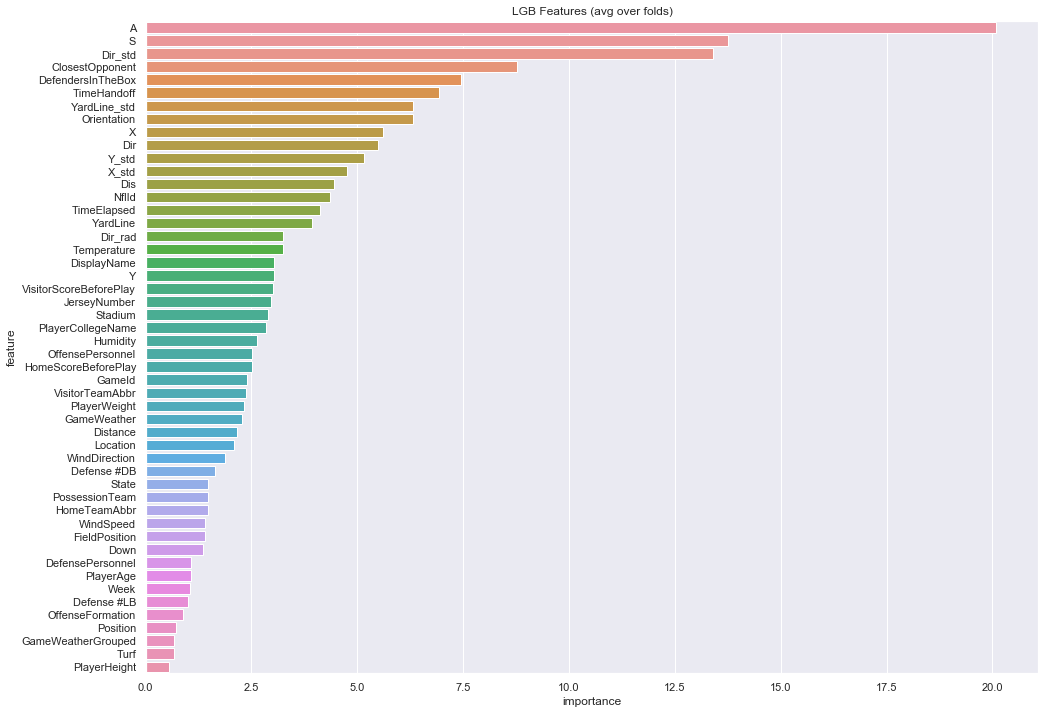

In [29]:
import matplotlib.pyplot as plt
X = rushers.drop(['Yards'],axis=1)
y = rushers['Yards']
folds = GroupKFold(n_splits=5)
results = train_model(X, y, folds, n_estimators=1000) # a, s, clos, dirstd,gamecloc, dir,orient, x, time

In [ ]:
def closestOpponent(x):
        coords = ['X_std','Y_std']
    #     get rusher index
        rusher_ix = x[x['NflId']==x['NflIdRusher']].index[0]
    #     get rusher X and Y
        rusher_coords = test_df.at[rusher_ix,'X_std'],test_df.at[rusher_ix,'Y_std']
    #     get coords of defensive team
        defensive_team_coords = x[x['PossessionTeam']!=x['TeamName']][coords]
    #     get euclidean distance between each deffense team player and the rusher
        euclideanDis = (defensive_team_coords-rusher_coords).pow(2).sum(1).pow(0.5)
    #     get minimal distance to the rusher
        return euclideanDis.min()

In [10]:
# Cleaning stadium names
stadiums =  {'Broncos Stadium at Mile High':'Broncos Stadium At Mile High','CenturyLink':'CenturyLink Field',
             'CenturyField':'CenturyLink Field','Everbank Field':'EverBank Field', 'First Energy Stadium':'FirstEnergy Stadium',
            'FirstEnergy':'FirstEnergy Stadium','FirstEnergyStadium':'FirstEnergy Stadium', 'Lambeau field':'Lambeau Field',
             'Los Angeles Memorial Coliesum':'Los Angeles Memorial Coliseum','M & T Bank Stadium':'M&T Bank Stadium',
            'M&T Stadium':'M&T Bank Stadium','Mercedes-Benz Dome':'Mercedes-Benz Stadium','MetLife':'MetLife Stadium',
            'Metlife Stadium':'MetLife Stadium','NRG':'NRG Stadium','Oakland Alameda-County Coliseum':'Oakland-Alameda County Coliseum',
            'Paul Brown Stdium':'Paul Brown Stadium', 'Twickenham':'Twickenham Stadium'}
    
# Cleaning team names
teams = {'ARI':'ARZ','BAL':'BLT','CLE':'CLV', 'HOU':'HST'}

stadium_types = {"Heinz Field":"Open","Dome":"Retractable Roof","Outddors":"Open","Oudoor":"Open",
                         "Ourdoor":"Open","Outdor":"Open","Outside":"Open","Domed":"Closed"}


# Cleaning Location
locations = {'Orchard Park NY':'Orchard Park, NY','Orchard Park':'Orchard Park, NY','Chicago. IL':'Chicago, IL',
             'Cleveland Ohio':'Cleveland, OH', 'Jacksonville Florida':'Jacksonville, FL','Pittsburgh':'Pittsburgh, PA',
            'Detroit':'Detroit, MA','London':'London, England',
        'Mexico City':'Mexico City, Mexico','Seattle':'Seattle, WA','Cleveland':'Cleveland, OH', 'New Orleans':'New Orleans, LA'}

states = {'Calif.':'CA','FLA':'FL','Fl':'FL','Fla.':'FL','Florida':'FL', 'Ind.':'IN','La.':'LA','Ma':'MA','Maryland':'MA',
             'Md.':'MD', 'N.J.':'NJ', 'North Carolina':'NC', 'Ohio':'OH', 'Pa.':'PA','Texas':'TX'}

# Cleaning WindDirection
wind_directions = {'South':'S','North':'N','West':'W', 'East':'E','Northwest':'NW','SouthWest':'SW','Northeast':'NE','From S':'S',
     'South Southeast':'SSE','From SW':'SW','s':'S', 'NorthEast':'NE','from W':'W', 'W-NW':'WNW','South Southwest':'SSW',
     'Southeast':'SE','From WSW':'WSW', 'West Northwest':'WNW','From SSE':'SSE','From W':'W', 'East North East':'ENE',
     'From ESE':'ESE','EAST':'E','East Southeast':'ESE','From SSW':'SSW','North East':'NE', 'Southwest':'SW', 
     'North/Northwest':'NNW', 'From NNE':'NNE','N-NE':'NNE','W-SW':'WSW', 'From NNW':'NNW','West-Southwest':'WSW',
     'Calm':'Missing','8':'Missing','1':'Missing','13':'Missing'}


# Cleaning GameWeather
rainy = ['Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy, 50% change of rain','Cloudy, Rain','Light Rain','Rain','Rain Chance 40%', 
         'Rain likely, temps in low 40s.', 'Rain shower', 'Rainy', 'Scattered Showers', 'Showers',]
clear = ['Clear','Clear Skies','Clear and Cool','Clear and Sunny','Clear and cold','Clear and sunny','Clear and warm',
         'Clear skies','Partly clear',]
snowy = ['Cloudy, light snow accumulating 1-3"','Heavy lake effect snow','Snow']
sunny = ['Mostly Sunny', 'Mostly Sunny Skies','Mostly sunny','Partly Sunny','Partly sunny','Sunny',
 'Sunny Skies', 'Sunny and clear', 'Sunny and cold', 'Sunny and warm', 'Sunny, Windy', 'Sunny, highs to upper 80s',]
cloudy = ['30% Chance of Rain','Cloudy', 'Cloudy and Cool', 'Cloudy and cold','Cloudy, chance of rain',
          'Cloudy, fog started developing in 2nd quarter','Coudy','Mostly Cloudy','Mostly Coudy','Mostly cloudy',
          'Overcast','Partly Cloudy','Partly Clouidy','Partly cloudy','Party Cloudy','Sun & clouds','cloudy']
# other = ['Cold','Controlled Climate','Fair', 'Hazy','T: 51; H: 55; W: NW 10 mph']


turfs = {'Artifical':'Artificial','Field Turf':'FieldTurf','Field turf':'FieldTurf','FieldTurf360':'FieldTurf 360',
        'UBU Sport Speed S5-M':'UBU Speed Series-S5-M'}




In [11]:

import tqdm
count = 0
for (test_df, sample_prediction_df) in tqdm.tqdm(env.iter_test()):
    print(test_df.columns)
    count += 1
    test_df['ToLeft'] = test_df.PlayDirection == "left"
    test_df['IsBallCarrier'] = test_df.NflId == test_df.NflIdRusher
    test_df['Dir_rad'] = np.mod(90 - test_df.Dir, 360) * math.pi/180.0

    # is that way more efficient?
    test_df['TeamOnOffense'] = "home"
    test_df.loc[test_df.PossessionTeam != test_df.HomeTeamAbbr, 'TeamOnOffense'] = "away"

    test_df['IsOnOffense'] = test_df.Team == test_df.TeamOnOffense # Is player on offense?

    test_df['YardLine_std'] = 100 - test_df.YardLine
    test_df.loc[test_df.FieldPosition.fillna('') == test_df.PossessionTeam,  'YardLine_std'] = test_df.loc[test_df.FieldPosition.fillna('') == test_df.PossessionTeam, 'YardLine']

    test_df['X_std'] = test_df.X
    test_df.loc[test_df.ToLeft, 'X_std'] = 120 - test_df.loc[test_df.ToLeft, 'X'] 

    test_df['Y_std'] = test_df.Y
    test_df.loc[test_df.ToLeft, 'Y_std'] = 160/3 - test_df.loc[test_df.ToLeft, 'Y'] 

    test_df['Dir_std'] = test_df.Dir_rad
    test_df.loc[test_df.ToLeft, 'Dir_std'] = np.mod(np.pi + test_df.loc[test_df.ToLeft, 'Dir_rad'], 2*np.pi)
    
    
    for old_name in teams:
        new_name = teams[old_name]
        test_df.replace(old_name, new_name, inplace=True)

    for old_name in stadiums:
        new_name = stadiums[old_name]
        test_df.replace(old_name, new_name, inplace=True)

    # Cleaning stadium types
    try:
        print(test_df['StadiumType'].head())
        isOpen = test_df['StadiumType'].str.contains('open', case=False) | test_df['StadiumType'].str.contains('outdoor', case=False)
        isClosed = test_df['StadiumType'].str.contains('closed', case=False) | test_df['StadiumType'].str.contains('indoor', case=False)

        test_df.loc[isOpen,'StadiumType'] = 'Open'
        test_df.loc[isClosed,'StadiumType'] = 'Closed'

        test_df.loc[test_df['Stadium']=="TIAA Bank Field",'StadiumType'] = 'Open'
        test_df.loc[test_df['Stadium']=="StubHub Center",'StadiumType'] = 'Open'
        test_df.loc[test_df['Stadium']=='MetLife Stadium','StadiumType'] = 'Open'


        for old_name in stadium_types:
            new_name = stadium_types[old_name]
            test_df.replace(old_name, new_name, inplace=True)
    except:
        pass
    
    for old_name in locations:
        new_name = locations[old_name]
        test_df.replace(old_name, new_name, inplace=True)
    
    location = test_df['Location'].str.split(',', expand=True)
    try:
        test_df['City'] = location[0]
        test_df['State'] = location[1].str.strip()
    except:
        test_df['City'] = 'Missing'
        test_df['State'] = 'Missing'

    
    for old_name in states:
        new_name = states[old_name]
        test_df.replace(old_name, new_name, inplace=True)


    for old_name in wind_directions:
        new_name = wind_directions[old_name]
        test_df.replace(old_name, new_name, inplace=True)

    test_df.loc[(test_df['WindDirection'].isna()),'WindDirection'] = 'Missing'

    # Cleaning WindDirection
    test_df.loc[test_df['WindSpeed']=='14-23','WindSpeed'] = 18
    test_df.loc[test_df['WindSpeed']=='11-17','WindSpeed'] = 16
    test_df.loc[test_df['WindSpeed']=='12-22','WindSpeed'] = 17
    test_df.loc[test_df['WindSpeed']=='15 gusts up to 25','WindSpeed'] = 16
    # some WindSpeed values contains characters, so below we just extract the numbers, e.g."15 MPH" will be changed to 15
    test_df['WindSpeed'] = test_df['WindSpeed'].astype(str).str.extract('(\d+)')[0].astype(float)


    test_df['GameWeatherGrouped'] = 'Other'
    test_df.loc[test_df['StadiumType']=='Closed','GameWeatherGrouped'] = 'Indoor'
    test_df.loc[test_df['GameWeather'].isin(rainy),'GameWeatherGrouped'] = 'Rainy'
    test_df.loc[test_df['GameWeather'].isin(clear),'GameWeatherGrouped'] = 'Clear'
    test_df.loc[test_df['GameWeather'].isin(snowy),'GameWeatherGrouped'] = 'Snowy'
    test_df.loc[test_df['GameWeather'].isin(sunny),'GameWeatherGrouped'] = 'Sunny'
    test_df.loc[test_df['GameWeather'].isin(cloudy),'GameWeatherGrouped'] = 'Cloudy'
    # test_df.loc[test_df['GameWeather'].isin(other),'GameWeatherGrouped'] = 'Other'

    # Cleaning Turf - add a isNatural column
    test_df['isNatural'] = False
    isNatural = test_df['Turf'].str.contains('natural', case=False) | test_df['Turf'].str.contains('grass', case=False)
    test_df.loc[isNatural,'isNatural'] = True
    test_df.loc[isNatural,'Turf'] = 'Natural grass'


    for old_name in turfs:
        new_name = turfs[old_name]
        test_df.replace(old_name, new_name, inplace=True)

    # Parsing PlayerBirthDate to datetime and adding Age variable
    test_df['PlayerBirthDate'] = pd.to_datetime(test_df['PlayerBirthDate'],format='%m/%d/%Y')

    current = datetime.datetime(2019, 11, 1)

    test_df['PlayerAge'] = (current-test_df['PlayerBirthDate']).apply(lambda x: int(x.days/365))
    # Converting player height from string in feet to centimeters
    height_feet = test_df['PlayerHeight'].str.split('-',expand=True)
    test_df['PlayerHeightCm'] = 30.48*height_feet[0].astype(float)+2.54*height_feet[1].astype(float)
    # Converting GameClock which is relative to the quarter to TimeElapsed that is relative to the whole game

    game_clock = test_df['GameClock'].str.split(':', expand=True)
    test_df['TimeElapsed'] = test_df['Quarter']*15*60+game_clock[0].astype(int)*60+game_clock[1].astype(int)
    # doubt
    test_df = test_df.drop(['GameClock','PlayerBirthDate'],axis=1)
#     test_df['GameClock'] = pd.to_datetime(test_df['GameClock'].str.slice(0,5), format='%M:%S')
    positions = ['OL', 'QB', 'RB', 'TE', 'WR', 'DL', 'DB','LB']
    nr_positions = ['Offense #'+pos for pos in positions]

    for pos in nr_positions: test_df[pos] = 0
    offense_formations = test_df['OffensePersonnel'].unique()
    print('Possible offensive positions',list(set(re.findall('[A-Z]+',offense_formations.sum()))))
    for formation in offense_formations:
        pos_list = [p.strip() for p in formation.split(',')]
    #     print(pos_list)
        df_values = np.zeros(len(positions),int)
        for pos in pos_list:
            for i, p in enumerate(positions):
                if p in pos:
                    df_values[i] = pos[0]
        if 'QB' not in formation:
            df_values[1] = 1
        if 'OL' not in formation:
            df_values[0] = 11-sum(df_values)
        test_df.loc[test_df['OffensePersonnel']==formation, nr_positions] = df_values
    #     print('Formation',formation)
    defense_formations = test_df['DefensePersonnel'].unique()
    print('Possible defensive positions',list(set(re.findall('[A-Z]+',defense_formations.sum()))))
    positions = ['DL', 'OL', 'DB', 'LB']
    nr_positions = ['Defense #'+pos for pos in positions]

    for pos in nr_positions: test_df[pos] = 0

    for formation in defense_formations:
        pos_list = [p.strip() for p in formation.split(',')]
        df_values = np.zeros(len(positions),int)
        for pos in pos_list:
            for i, p in enumerate(positions):
                if p in pos:
                    df_values[i] = pos[0]
        test_df.loc[test_df['DefensePersonnel']==formation, nr_positions] = df_values
    #     print('Formation',formation)

    # team name of the player
    test_df['TeamName'] = np.where(test_df['Team']=='away', test_df['VisitorTeamAbbr'], test_df['HomeTeamAbbr'])
    

    d = test_df.groupby(by='PlayId').apply(closestOpponent)

    test_df['ClosestOpponent'] = [d[x] for x in test_df['PlayId']]
    for col in cont_vars:
        if col!='Yards':
            test_df[col] = test_df[col].fillna(cont_medians[col])
    for col in cat_vars:
        test_df[col] = test_df[col].fillna('Missing')
    from sklearn.preprocessing import LabelEncoder
    for col in cat_vars:
        try:
            test_df[col] = le_dict[col].transform(test_df[col])
        except:
            test_df[col] = 'Missing'
            test_df[col] = le_dict[col].transform(test_df[col])
    #     test[col] = le_dict[col].transform(list(test[col].astype(str).values))   
    folds = 5
    y_pred_p = np.sum(np.round([model.predict(test_df)[0] for model in models]))/folds
    y_pred = np.zeros(199) 
    y_pred_p += 99
    for j in range(199):
        if j>=y_pred_p+10:
            y_pred[j]=1.0
        elif j>=y_pred_p-10:
            y_pred[j]=(j+10-y_pred_p)*0.05
    env.predict(pd.DataFrame(data=[y_pred],columns=sample_prediction_df.columns))
env.write_submission_file()


0it [00:00, ?it/s]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
0    Outdoor
1    Outdoor
2    Outdoor
3    Outdoor
4    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1it [00:02,  2.83s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22    Outdoor
23    Outdoor
24    Outdoor
25    Outdoor
26    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2it [00:04,  2.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44    Outdoor
45    Outdoor
46    Outdoor
47    Outdoor
48    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3it [00:05,  2.17s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66    Outdoor
67    Outdoor
68    Outdoor
69    Outdoor
70    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


4it [00:07,  1.98s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
88    Outdoor
89    Outdoor
90    Outdoor
91    Outdoor
92    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


5it [00:08,  1.85s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
110    Outdoor
111    Outdoor
112    Outdoor
113    Outdoor
114    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


6it [00:10,  1.75s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
132    Outdoor
133    Outdoor
134    Outdoor
135    Outdoor
136    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


7it [00:12,  1.69s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
154    Outdoor
155    Outdoor
156    Outdoor
157    Outdoor
158    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


8it [00:13,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
176    Outdoor
177    Outdoor
178    Outdoor
179    Outdoor
180    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


9it [00:15,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
198    Outdoor
199    Outdoor
200    Outdoor
201    Outdoor
202    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


10it [00:16,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
220    Outdoor
221    Outdoor
222    Outdoor
223    Outdoor
224    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


11it [00:18,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
242    Outdoor
243    Outdoor
244    Outdoor
245    Outdoor
246    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


12it [00:19,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
264    Outdoor
265    Outdoor
266    Outdoor
267    Outdoor
268    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


13it [00:21,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
286    Outdoor
287    Outdoor
288    Outdoor
289    Outdoor
290    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


14it [00:22,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
308    Outdoor
309    Outdoor
310    Outdoor
311    Outdoor
312    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


15it [00:24,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
330    Outdoor
331    Outdoor
332    Outdoor
333    Outdoor
334    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


16it [00:25,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
352    Outdoor
353    Outdoor
354    Outdoor
355    Outdoor
356    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


17it [00:27,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
374    Outdoor
375    Outdoor
376    Outdoor
377    Outdoor
378    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


18it [00:28,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
396    Outdoor
397    Outdoor
398    Outdoor
399    Outdoor
400    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


19it [00:30,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
418    Outdoor
419    Outdoor
420    Outdoor
421    Outdoor
422    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


20it [00:31,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
440    Outdoor
441    Outdoor
442    Outdoor
443    Outdoor
444    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


21it [00:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
462    Outdoor
463    Outdoor
464    Outdoor
465    Outdoor
466    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


22it [00:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
484    Outdoor
485    Outdoor
486    Outdoor
487    Outdoor
488    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


23it [00:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
506    Outdoor
507    Outdoor
508    Outdoor
509    Outdoor
510    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


24it [00:38,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
528    Outdoor
529    Outdoor
530    Outdoor
531    Outdoor
532    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


25it [00:39,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
550    Outdoor
551    Outdoor
552    Outdoor
553    Outdoor
554    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


26it [00:41,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
572    Outdoor
573    Outdoor
574    Outdoor
575    Outdoor
576    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


27it [00:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
594    Outdoor
595    Outdoor
596    Outdoor
597    Outdoor
598    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


28it [00:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
616    Outdoor
617    Outdoor
618    Outdoor
619    Outdoor
620    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


29it [00:45,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
638    Outdoor
639    Outdoor
640    Outdoor
641    Outdoor
642    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


30it [00:47,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
660    Outdoor
661    Outdoor
662    Outdoor
663    Outdoor
664    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


31it [00:48,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
682    Outdoor
683    Outdoor
684    Outdoor
685    Outdoor
686    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


32it [00:50,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
704    Outdoor
705    Outdoor
706    Outdoor
707    Outdoor
708    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


33it [00:51,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
726    Outdoor
727    Outdoor
728    Outdoor
729    Outdoor
730    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


34it [00:53,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
748    Outdoor
749    Outdoor
750    Outdoor
751    Outdoor
752    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


35it [00:54,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
770    Outdoor
771    Outdoor
772    Outdoor
773    Outdoor
774    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


36it [00:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
792    Outdoor
793    Outdoor
794    Outdoor
795    Outdoor
796    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


37it [00:57,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
814    Outdoor
815    Outdoor
816    Outdoor
817    Outdoor
818    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


38it [00:59,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
836    Outdoor
837    Outdoor
838    Outdoor
839    Outdoor
840    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


39it [01:00,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
858    Outdoor
859    Outdoor
860    Outdoor
861    Outdoor
862    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


40it [01:02,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
880    Outdoor
881    Outdoor
882    Outdoor
883    Outdoor
884    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


41it [01:03,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
902    Outdoor
903    Outdoor
904    Outdoor
905    Outdoor
906    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


42it [01:05,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
924    Outdoor
925    Outdoor
926    Outdoor
927    Outdoor
928    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


43it [01:07,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
946    Outdoor
947    Outdoor
948    Outdoor
949    Outdoor
950    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


44it [01:08,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
968    Outdoor
969    Outdoor
970    Outdoor
971    Outdoor
972    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


45it [01:10,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
990    Outdoor
991    Outdoor
992    Outdoor
993    Outdoor
994    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


46it [01:11,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1012    Outdoor
1013    Outdoor
1014    Outdoor
1015    Outdoor
1016    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


47it [01:13,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1034    Outdoor
1035    Outdoor
1036    Outdoor
1037    Outdoor
1038    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


48it [01:14,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1056    Outdoor
1057    Outdoor
1058    Outdoor
1059    Outdoor
1060    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


49it [01:16,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1078    Outdoor
1079    Outdoor
1080    Outdoor
1081    Outdoor
1082    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


50it [01:17,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1100    Outdoor
1101    Outdoor
1102    Outdoor
1103    Outdoor
1104    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


51it [01:19,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1122    Outdoor
1123    Outdoor
1124    Outdoor
1125    Outdoor
1126    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


52it [01:20,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1144    Outdoor
1145    Outdoor
1146    Outdoor
1147    Outdoor
1148    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


53it [01:22,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1166    Outdoor
1167    Outdoor
1168    Outdoor
1169    Outdoor
1170    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


54it [01:23,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1188    Outdoor
1189    Outdoor
1190    Outdoor
1191    Outdoor
1192    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


55it [01:25,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1210    Outdoor
1211    Outdoor
1212    Outdoor
1213    Outdoor
1214    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


56it [01:26,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1232    Outdoor
1233    Outdoor
1234    Outdoor
1235    Outdoor
1236    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


57it [01:28,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1254    Outdoor
1255    Outdoor
1256    Outdoor
1257    Outdoor
1258    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


58it [01:29,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1276    Outdoor
1277    Outdoor
1278    Outdoor
1279    Outdoor
1280    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


59it [01:31,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1298    Outdoor
1299    Outdoor
1300    Outdoor
1301    Outdoor
1302    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


60it [01:33,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1320    Outdoor
1321    Outdoor
1322    Outdoor
1323    Outdoor
1324    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


61it [01:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1342    Outdoor
1343    Outdoor
1344    Outdoor
1345    Outdoor
1346    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


62it [01:36,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1364    Outdoor
1365    Outdoor
1366    Outdoor
1367    Outdoor
1368    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


63it [01:37,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1386    Outdoor
1387    Outdoor
1388    Outdoor
1389    Outdoor
1390    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


64it [01:39,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1408    Outdoor
1409    Outdoor
1410    Outdoor
1411    Outdoor
1412    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


65it [01:40,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1430    Outdoor
1431    Outdoor
1432    Outdoor
1433    Outdoor
1434    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


66it [01:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1452    Outdoor
1453    Outdoor
1454    Outdoor
1455    Outdoor
1456    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


67it [01:43,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1474    Outdoor
1475    Outdoor
1476    Outdoor
1477    Outdoor
1478    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


68it [01:45,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1496    Outdoor
1497    Outdoor
1498    Outdoor
1499    Outdoor
1500    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


69it [01:46,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1518    Outdoor
1519    Outdoor
1520    Outdoor
1521    Outdoor
1522    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


70it [01:48,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1540    Outdoor
1541    Outdoor
1542    Outdoor
1543    Outdoor
1544    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


71it [01:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1562    Outdoor
1563    Outdoor
1564    Outdoor
1565    Outdoor
1566    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


72it [01:51,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1584    Outdoor
1585    Outdoor
1586    Outdoor
1587    Outdoor
1588    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


73it [01:52,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1606    Outdoor
1607    Outdoor
1608    Outdoor
1609    Outdoor
1610    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


74it [01:54,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1628    Outdoor
1629    Outdoor
1630    Outdoor
1631    Outdoor
1632    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


75it [01:56,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1650    Outdoor
1651    Outdoor
1652    Outdoor
1653    Outdoor
1654    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


76it [01:57,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1672    Outdoor
1673    Outdoor
1674    Outdoor
1675    Outdoor
1676    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


77it [01:59,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1694    Outdoor
1695    Outdoor
1696    Outdoor
1697    Outdoor
1698    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


78it [02:00,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1716    Outdoor
1717    Outdoor
1718    Outdoor
1719    Outdoor
1720    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


79it [02:02,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1738    Outdoor
1739    Outdoor
1740    Outdoor
1741    Outdoor
1742    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


80it [02:04,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1760    Outdoor
1761    Outdoor
1762    Outdoor
1763    Outdoor
1764    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


81it [02:05,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1782    Outdoor
1783    Outdoor
1784    Outdoor
1785    Outdoor
1786    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


82it [02:07,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1804    Outdoor
1805    Outdoor
1806    Outdoor
1807    Outdoor
1808    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


83it [02:08,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1826    Outdoor
1827    Outdoor
1828    Outdoor
1829    Outdoor
1830    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


84it [02:10,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1848    Outdoor
1849    Outdoor
1850    Outdoor
1851    Outdoor
1852    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


85it [02:11,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1870    Outdoor
1871    Outdoor
1872    Outdoor
1873    Outdoor
1874    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


86it [02:13,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1892    Outdoor
1893    Outdoor
1894    Outdoor
1895    Outdoor
1896    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


87it [02:14,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1914    Outdoor
1915    Outdoor
1916    Outdoor
1917    Outdoor
1918    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


88it [02:16,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1936    Outdoor
1937    Outdoor
1938    Outdoor
1939    Outdoor
1940    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


89it [02:17,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1958    Outdoor
1959    Outdoor
1960    Outdoor
1961    Outdoor
1962    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


90it [02:19,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
1980    Outdoor
1981    Outdoor
1982    Outdoor
1983    Outdoor
1984    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


91it [02:20,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2002    Outdoor
2003    Outdoor
2004    Outdoor
2005    Outdoor
2006    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


92it [02:22,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2024    Outdoor
2025    Outdoor
2026    Outdoor
2027    Outdoor
2028    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['LB', 'RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


93it [02:23,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2046    Outdoor
2047    Outdoor
2048    Outdoor
2049    Outdoor
2050    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


94it [02:25,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2068    Outdoor
2069    Outdoor
2070    Outdoor
2071    Outdoor
2072    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


95it [02:26,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2090    Outdoor
2091    Outdoor
2092    Outdoor
2093    Outdoor
2094    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


96it [02:28,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2112    Outdoor
2113    Outdoor
2114    Outdoor
2115    Outdoor
2116    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


97it [02:29,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2134    Outdoor
2135    Outdoor
2136    Outdoor
2137    Outdoor
2138    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


98it [02:31,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2156    Outdoor
2157    Outdoor
2158    Outdoor
2159    Outdoor
2160    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


99it [02:33,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2178    Outdoor
2179    Outdoor
2180    Outdoor
2181    Outdoor
2182    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


100it [02:34,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2200    Outdoor
2201    Outdoor
2202    Outdoor
2203    Outdoor
2204    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


101it [02:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2222    Outdoor
2223    Outdoor
2224    Outdoor
2225    Outdoor
2226    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


102it [02:37,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2244    Outdoor
2245    Outdoor
2246    Outdoor
2247    Outdoor
2248    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


103it [02:39,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2266    Outdoor
2267    Outdoor
2268    Outdoor
2269    Outdoor
2270    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


104it [02:40,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2288    Outdoor
2289    Outdoor
2290    Outdoor
2291    Outdoor
2292    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


105it [02:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2310    Outdoor
2311    Outdoor
2312    Outdoor
2313    Outdoor
2314    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


106it [02:43,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2332    Outdoor
2333    Outdoor
2334    Outdoor
2335    Outdoor
2336    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


107it [02:45,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2354    Outdoor
2355    Outdoor
2356    Outdoor
2357    Outdoor
2358    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


108it [02:46,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2376    Outdoor
2377    Outdoor
2378    Outdoor
2379    Outdoor
2380    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


109it [02:48,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2398    Outdoor
2399    Outdoor
2400    Outdoor
2401    Outdoor
2402    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


110it [02:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2420    Outdoor
2421    Outdoor
2422    Outdoor
2423    Outdoor
2424    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


111it [02:51,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2442    Outdoor
2443    Outdoor
2444    Outdoor
2445    Outdoor
2446    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


112it [02:53,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2464    Outdoor
2465    Outdoor
2466    Outdoor
2467    Outdoor
2468    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


113it [02:54,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2486    Outdoor
2487    Outdoor
2488    Outdoor
2489    Outdoor
2490    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


114it [02:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2508    Outdoor
2509    Outdoor
2510    Outdoor
2511    Outdoor
2512    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


115it [02:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2530    Outdoor
2531    Outdoor
2532    Outdoor
2533    Outdoor
2534    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


116it [02:59,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2552    Outdoor
2553    Outdoor
2554    Outdoor
2555    Outdoor
2556    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


117it [03:00,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2574    Outdoor
2575    Outdoor
2576    Outdoor
2577    Outdoor
2578    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


118it [03:02,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2596    Outdoor
2597    Outdoor
2598    Outdoor
2599    Outdoor
2600    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


119it [03:03,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2618    Outdoor
2619    Outdoor
2620    Outdoor
2621    Outdoor
2622    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


120it [03:05,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2640    Open
2641    Open
2642    Open
2643    Open
2644    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


121it [03:06,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2662    Open
2663    Open
2664    Open
2665    Open
2666    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


122it [03:08,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2684    Open
2685    Open
2686    Open
2687    Open
2688    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


123it [03:09,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2706    Open
2707    Open
2708    Open
2709    Open
2710    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


124it [03:11,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2728    Open
2729    Open
2730    Open
2731    Open
2732    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


125it [03:12,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2750    Open
2751    Open
2752    Open
2753    Open
2754    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


126it [03:14,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2772    Open
2773    Open
2774    Open
2775    Open
2776    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


127it [03:15,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2794    Open
2795    Open
2796    Open
2797    Open
2798    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


128it [03:17,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2816    Open
2817    Open
2818    Open
2819    Open
2820    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


129it [03:18,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2838    Open
2839    Open
2840    Open
2841    Open
2842    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


130it [03:20,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2860    Open
2861    Open
2862    Open
2863    Open
2864    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


131it [03:22,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2882    Open
2883    Open
2884    Open
2885    Open
2886    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


132it [03:23,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2904    Open
2905    Open
2906    Open
2907    Open
2908    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


133it [03:25,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2926    Open
2927    Open
2928    Open
2929    Open
2930    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


134it [03:26,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2948    Open
2949    Open
2950    Open
2951    Open
2952    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


135it [03:28,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2970    Open
2971    Open
2972    Open
2973    Open
2974    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


136it [03:29,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
2992    Open
2993    Open
2994    Open
2995    Open
2996    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


137it [03:31,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3014    Open
3015    Open
3016    Open
3017    Open
3018    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


138it [03:32,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3036    Open
3037    Open
3038    Open
3039    Open
3040    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


139it [03:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3058    Open
3059    Open
3060    Open
3061    Open
3062    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


140it [03:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3080    Open
3081    Open
3082    Open
3083    Open
3084    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


141it [03:37,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3102    Open
3103    Open
3104    Open
3105    Open
3106    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


142it [03:38,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3124    Open
3125    Open
3126    Open
3127    Open
3128    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


143it [03:40,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3146    Open
3147    Open
3148    Open
3149    Open
3150    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


144it [03:41,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3168    Open
3169    Open
3170    Open
3171    Open
3172    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


145it [03:43,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3190    Open
3191    Open
3192    Open
3193    Open
3194    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


146it [03:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3212    Open
3213    Open
3214    Open
3215    Open
3216    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


147it [03:46,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3234    Open
3235    Open
3236    Open
3237    Open
3238    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


148it [03:48,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3256    Open
3257    Open
3258    Open
3259    Open
3260    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


149it [03:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3278    Open
3279    Open
3280    Open
3281    Open
3282    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


150it [03:51,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3300    Open
3301    Open
3302    Open
3303    Open
3304    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


151it [03:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3322    Open
3323    Open
3324    Open
3325    Open
3326    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


152it [03:54,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3344    Open
3345    Open
3346    Open
3347    Open
3348    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


153it [03:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3366    Open
3367    Open
3368    Open
3369    Open
3370    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


154it [03:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3388    Open
3389    Open
3390    Open
3391    Open
3392    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


155it [03:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3410    Open
3411    Open
3412    Open
3413    Open
3414    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


156it [04:00,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3432    Open
3433    Open
3434    Open
3435    Open
3436    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


157it [04:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3454    Open
3455    Open
3456    Open
3457    Open
3458    Open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


158it [04:03,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3476    Outdoor
3477    Outdoor
3478    Outdoor
3479    Outdoor
3480    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


159it [04:04,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3498    Outdoor
3499    Outdoor
3500    Outdoor
3501    Outdoor
3502    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


160it [04:06,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3520    Outdoor
3521    Outdoor
3522    Outdoor
3523    Outdoor
3524    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


161it [04:07,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3542    Outdoor
3543    Outdoor
3544    Outdoor
3545    Outdoor
3546    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


162it [04:09,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3564    Outdoor
3565    Outdoor
3566    Outdoor
3567    Outdoor
3568    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


163it [04:11,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3586    Outdoor
3587    Outdoor
3588    Outdoor
3589    Outdoor
3590    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


164it [04:12,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3608    Outdoor
3609    Outdoor
3610    Outdoor
3611    Outdoor
3612    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


165it [04:14,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3630    Outdoor
3631    Outdoor
3632    Outdoor
3633    Outdoor
3634    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


166it [04:15,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3652    Outdoor
3653    Outdoor
3654    Outdoor
3655    Outdoor
3656    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


167it [04:17,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3674    Outdoor
3675    Outdoor
3676    Outdoor
3677    Outdoor
3678    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


168it [04:19,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3696    Outdoor
3697    Outdoor
3698    Outdoor
3699    Outdoor
3700    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


169it [04:20,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3718    Outdoor
3719    Outdoor
3720    Outdoor
3721    Outdoor
3722    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


170it [04:22,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3740    Outdoor
3741    Outdoor
3742    Outdoor
3743    Outdoor
3744    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


171it [04:23,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3762    Outdoor
3763    Outdoor
3764    Outdoor
3765    Outdoor
3766    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


172it [04:25,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3784    Outdoor
3785    Outdoor
3786    Outdoor
3787    Outdoor
3788    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


173it [04:26,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3806    Outdoor
3807    Outdoor
3808    Outdoor
3809    Outdoor
3810    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


174it [04:28,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3828    Outdoor
3829    Outdoor
3830    Outdoor
3831    Outdoor
3832    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


175it [04:29,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3850    Outdoor
3851    Outdoor
3852    Outdoor
3853    Outdoor
3854    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


176it [04:31,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3872    Outdoor
3873    Outdoor
3874    Outdoor
3875    Outdoor
3876    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


177it [04:32,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3894    Outdoor
3895    Outdoor
3896    Outdoor
3897    Outdoor
3898    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


178it [04:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3916    Outdoor
3917    Outdoor
3918    Outdoor
3919    Outdoor
3920    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


179it [04:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3938    Outdoor
3939    Outdoor
3940    Outdoor
3941    Outdoor
3942    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


180it [04:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3960    Outdoor
3961    Outdoor
3962    Outdoor
3963    Outdoor
3964    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


181it [04:38,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
3982    Outdoor
3983    Outdoor
3984    Outdoor
3985    Outdoor
3986    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


182it [04:40,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4004    Outdoor
4005    Outdoor
4006    Outdoor
4007    Outdoor
4008    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


183it [04:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4026    Outdoor
4027    Outdoor
4028    Outdoor
4029    Outdoor
4030    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


184it [04:43,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4048    Outdoor
4049    Outdoor
4050    Outdoor
4051    Outdoor
4052    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


185it [04:45,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4070    Outdoor
4071    Outdoor
4072    Outdoor
4073    Outdoor
4074    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


186it [04:46,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4092    Outdoor
4093    Outdoor
4094    Outdoor
4095    Outdoor
4096    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


187it [04:48,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4114    Outdoor
4115    Outdoor
4116    Outdoor
4117    Outdoor
4118    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


188it [04:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4136    Outdoor
4137    Outdoor
4138    Outdoor
4139    Outdoor
4140    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


189it [04:51,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4158    Outdoor
4159    Outdoor
4160    Outdoor
4161    Outdoor
4162    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


190it [04:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4180    Outdoor
4181    Outdoor
4182    Outdoor
4183    Outdoor
4184    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


191it [04:54,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4202    Outdoor
4203    Outdoor
4204    Outdoor
4205    Outdoor
4206    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


192it [04:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4224    Outdoor
4225    Outdoor
4226    Outdoor
4227    Outdoor
4228    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


193it [04:57,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4246    Outdoor
4247    Outdoor
4248    Outdoor
4249    Outdoor
4250    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


194it [04:58,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4268    Outdoor
4269    Outdoor
4270    Outdoor
4271    Outdoor
4272    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


195it [05:00,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4290    Outdoor
4291    Outdoor
4292    Outdoor
4293    Outdoor
4294    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


196it [05:01,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4312    Outdoor
4313    Outdoor
4314    Outdoor
4315    Outdoor
4316    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


197it [05:03,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4334    Outdoor
4335    Outdoor
4336    Outdoor
4337    Outdoor
4338    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


198it [05:04,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4356    Outdoor
4357    Outdoor
4358    Outdoor
4359    Outdoor
4360    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


199it [05:06,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4378    Outdoor
4379    Outdoor
4380    Outdoor
4381    Outdoor
4382    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


200it [05:08,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4400    Outdoor
4401    Outdoor
4402    Outdoor
4403    Outdoor
4404    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


201it [05:09,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4422    Outdoor
4423    Outdoor
4424    Outdoor
4425    Outdoor
4426    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


202it [05:11,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4444    Outdoor
4445    Outdoor
4446    Outdoor
4447    Outdoor
4448    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


203it [05:12,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4466    Outdoor
4467    Outdoor
4468    Outdoor
4469    Outdoor
4470    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


204it [05:14,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4488    Indoors
4489    Indoors
4490    Indoors
4491    Indoors
4492    Indoors
Name: StadiumType, dtype: object


/opt/conda/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


205it [05:15,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4510    Indoors
4511    Indoors
4512    Indoors
4513    Indoors
4514    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


206it [05:17,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4532    Indoors
4533    Indoors
4534    Indoors
4535    Indoors
4536    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


207it [05:18,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4554    Indoors
4555    Indoors
4556    Indoors
4557    Indoors
4558    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


208it [05:20,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4576    Indoors
4577    Indoors
4578    Indoors
4579    Indoors
4580    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


209it [05:21,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4598    Indoors
4599    Indoors
4600    Indoors
4601    Indoors
4602    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


210it [05:23,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4620    Indoors
4621    Indoors
4622    Indoors
4623    Indoors
4624    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


211it [05:24,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4642    Indoors
4643    Indoors
4644    Indoors
4645    Indoors
4646    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


212it [05:26,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4664    Indoors
4665    Indoors
4666    Indoors
4667    Indoors
4668    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


213it [05:27,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4686    Indoors
4687    Indoors
4688    Indoors
4689    Indoors
4690    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


214it [05:29,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4708    Indoors
4709    Indoors
4710    Indoors
4711    Indoors
4712    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


215it [05:30,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4730    Indoors
4731    Indoors
4732    Indoors
4733    Indoors
4734    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


216it [05:32,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4752    Indoors
4753    Indoors
4754    Indoors
4755    Indoors
4756    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


217it [05:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4774    Indoors
4775    Indoors
4776    Indoors
4777    Indoors
4778    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


218it [05:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4796    Indoors
4797    Indoors
4798    Indoors
4799    Indoors
4800    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


219it [05:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4818    Indoors
4819    Indoors
4820    Indoors
4821    Indoors
4822    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


220it [05:38,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4840    Indoors
4841    Indoors
4842    Indoors
4843    Indoors
4844    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


221it [05:40,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4862    Indoors
4863    Indoors
4864    Indoors
4865    Indoors
4866    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


222it [05:41,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4884    Indoors
4885    Indoors
4886    Indoors
4887    Indoors
4888    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


223it [05:43,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4906    Indoors
4907    Indoors
4908    Indoors
4909    Indoors
4910    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


224it [05:44,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4928    Indoors
4929    Indoors
4930    Indoors
4931    Indoors
4932    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


225it [05:46,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4950    Indoors
4951    Indoors
4952    Indoors
4953    Indoors
4954    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


226it [05:47,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4972    Indoors
4973    Indoors
4974    Indoors
4975    Indoors
4976    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


227it [05:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
4994    Indoors
4995    Indoors
4996    Indoors
4997    Indoors
4998    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


228it [05:50,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5016    Indoors
5017    Indoors
5018    Indoors
5019    Indoors
5020    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


229it [05:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5038    Indoors
5039    Indoors
5040    Indoors
5041    Indoors
5042    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


230it [05:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5060    Indoors
5061    Indoors
5062    Indoors
5063    Indoors
5064    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


231it [05:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5082    Indoors
5083    Indoors
5084    Indoors
5085    Indoors
5086    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


232it [05:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5104    Indoors
5105    Indoors
5106    Indoors
5107    Indoors
5108    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


233it [05:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5126    Indoors
5127    Indoors
5128    Indoors
5129    Indoors
5130    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


234it [06:00,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5148    Indoors
5149    Indoors
5150    Indoors
5151    Indoors
5152    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


235it [06:01,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5170    Indoors
5171    Indoors
5172    Indoors
5173    Indoors
5174    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


236it [06:03,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5192    Indoors
5193    Indoors
5194    Indoors
5195    Indoors
5196    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


237it [06:04,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5214    Indoors
5215    Indoors
5216    Indoors
5217    Indoors
5218    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


238it [06:06,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5236    Indoors
5237    Indoors
5238    Indoors
5239    Indoors
5240    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


239it [06:07,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5258    Indoors
5259    Indoors
5260    Indoors
5261    Indoors
5262    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


240it [06:09,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5280    Indoors
5281    Indoors
5282    Indoors
5283    Indoors
5284    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


241it [06:10,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5302    Indoors
5303    Indoors
5304    Indoors
5305    Indoors
5306    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


242it [06:12,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5324    Indoors
5325    Indoors
5326    Indoors
5327    Indoors
5328    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


243it [06:13,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5346    Indoors
5347    Indoors
5348    Indoors
5349    Indoors
5350    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


244it [06:15,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5368    Indoors
5369    Indoors
5370    Indoors
5371    Indoors
5372    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


245it [06:16,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5390    Indoors
5391    Indoors
5392    Indoors
5393    Indoors
5394    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


246it [06:18,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5412    Indoors
5413    Indoors
5414    Indoors
5415    Indoors
5416    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


247it [06:19,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5434    Indoors
5435    Indoors
5436    Indoors
5437    Indoors
5438    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


248it [06:21,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5456    Indoors
5457    Indoors
5458    Indoors
5459    Indoors
5460    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


249it [06:22,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5478    Indoors
5479    Indoors
5480    Indoors
5481    Indoors
5482    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


250it [06:24,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5500    Indoors
5501    Indoors
5502    Indoors
5503    Indoors
5504    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


251it [06:25,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5522    Outdoor
5523    Outdoor
5524    Outdoor
5525    Outdoor
5526    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


252it [06:27,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5544    Outdoor
5545    Outdoor
5546    Outdoor
5547    Outdoor
5548    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


253it [06:29,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5566    Outdoor
5567    Outdoor
5568    Outdoor
5569    Outdoor
5570    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


254it [06:30,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5588    Outdoor
5589    Outdoor
5590    Outdoor
5591    Outdoor
5592    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


255it [06:32,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5610    Outdoor
5611    Outdoor
5612    Outdoor
5613    Outdoor
5614    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


256it [06:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5632    Outdoor
5633    Outdoor
5634    Outdoor
5635    Outdoor
5636    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


257it [06:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5654    Outdoor
5655    Outdoor
5656    Outdoor
5657    Outdoor
5658    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


258it [06:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5676    Outdoor
5677    Outdoor
5678    Outdoor
5679    Outdoor
5680    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


259it [06:38,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5698    Outdoor
5699    Outdoor
5700    Outdoor
5701    Outdoor
5702    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


260it [06:39,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5720    Outdoor
5721    Outdoor
5722    Outdoor
5723    Outdoor
5724    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


261it [06:41,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5742    Outdoor
5743    Outdoor
5744    Outdoor
5745    Outdoor
5746    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


262it [06:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5764    Outdoor
5765    Outdoor
5766    Outdoor
5767    Outdoor
5768    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


263it [06:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5786    Outdoor
5787    Outdoor
5788    Outdoor
5789    Outdoor
5790    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


264it [06:45,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5808    Outdoor
5809    Outdoor
5810    Outdoor
5811    Outdoor
5812    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


265it [06:47,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5830    Outdoor
5831    Outdoor
5832    Outdoor
5833    Outdoor
5834    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


266it [06:48,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5852    Outdoor
5853    Outdoor
5854    Outdoor
5855    Outdoor
5856    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


267it [06:50,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5874    Outdoor
5875    Outdoor
5876    Outdoor
5877    Outdoor
5878    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


268it [06:52,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5896    Outdoor
5897    Outdoor
5898    Outdoor
5899    Outdoor
5900    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


269it [06:53,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5918    Outdoor
5919    Outdoor
5920    Outdoor
5921    Outdoor
5922    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


270it [06:55,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5940    Outdoor
5941    Outdoor
5942    Outdoor
5943    Outdoor
5944    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


271it [06:56,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5962    Outdoor
5963    Outdoor
5964    Outdoor
5965    Outdoor
5966    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


272it [06:58,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
5984    Outdoor
5985    Outdoor
5986    Outdoor
5987    Outdoor
5988    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


273it [06:59,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6006    Outdoor
6007    Outdoor
6008    Outdoor
6009    Outdoor
6010    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


274it [07:01,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6028    Outdoor
6029    Outdoor
6030    Outdoor
6031    Outdoor
6032    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


275it [07:02,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6050    Outdoor
6051    Outdoor
6052    Outdoor
6053    Outdoor
6054    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


276it [07:04,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6072    Outdoor
6073    Outdoor
6074    Outdoor
6075    Outdoor
6076    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


277it [07:05,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6094    Outdoor
6095    Outdoor
6096    Outdoor
6097    Outdoor
6098    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


278it [07:07,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6116    Outdoor
6117    Outdoor
6118    Outdoor
6119    Outdoor
6120    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


279it [07:09,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6138    Outdoor
6139    Outdoor
6140    Outdoor
6141    Outdoor
6142    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


280it [07:10,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6160    Outdoor
6161    Outdoor
6162    Outdoor
6163    Outdoor
6164    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


281it [07:12,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6182    Outdoor
6183    Outdoor
6184    Outdoor
6185    Outdoor
6186    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


282it [07:13,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6204    Outdoor
6205    Outdoor
6206    Outdoor
6207    Outdoor
6208    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


283it [07:15,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6226    Outdoor
6227    Outdoor
6228    Outdoor
6229    Outdoor
6230    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


284it [07:17,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6248    Outdoor
6249    Outdoor
6250    Outdoor
6251    Outdoor
6252    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


285it [07:18,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6270    Outdoor
6271    Outdoor
6272    Outdoor
6273    Outdoor
6274    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


286it [07:20,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6292    Outdoor
6293    Outdoor
6294    Outdoor
6295    Outdoor
6296    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


287it [07:21,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6314    Outdoor
6315    Outdoor
6316    Outdoor
6317    Outdoor
6318    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


288it [07:23,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6336    Outdoor
6337    Outdoor
6338    Outdoor
6339    Outdoor
6340    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


289it [07:24,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6358    Outdoor
6359    Outdoor
6360    Outdoor
6361    Outdoor
6362    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


290it [07:26,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6380    Outdoor
6381    Outdoor
6382    Outdoor
6383    Outdoor
6384    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


291it [07:27,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6402    Outdoor
6403    Outdoor
6404    Outdoor
6405    Outdoor
6406    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


292it [07:29,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6424    Outdoor
6425    Outdoor
6426    Outdoor
6427    Outdoor
6428    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


293it [07:30,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6446    Outdoor
6447    Outdoor
6448    Outdoor
6449    Outdoor
6450    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


294it [07:32,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6468    Outdoor
6469    Outdoor
6470    Outdoor
6471    Outdoor
6472    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


295it [07:33,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6490    Outdoor
6491    Outdoor
6492    Outdoor
6493    Outdoor
6494    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


296it [07:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6512    Outdoor
6513    Outdoor
6514    Outdoor
6515    Outdoor
6516    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


297it [07:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6534    Outdoor
6535    Outdoor
6536    Outdoor
6537    Outdoor
6538    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


298it [07:38,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6556    Outdoor
6557    Outdoor
6558    Outdoor
6559    Outdoor
6560    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


299it [07:39,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6578    Outdoor
6579    Outdoor
6580    Outdoor
6581    Outdoor
6582    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


300it [07:41,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6600    Outdoor
6601    Outdoor
6602    Outdoor
6603    Outdoor
6604    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


301it [07:42,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6622    Outdoor
6623    Outdoor
6624    Outdoor
6625    Outdoor
6626    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


302it [07:44,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6644    Outdoor
6645    Outdoor
6646    Outdoor
6647    Outdoor
6648    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


303it [07:46,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6666    Outdoor
6667    Outdoor
6668    Outdoor
6669    Outdoor
6670    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


304it [07:47,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6688    Outdoor
6689    Outdoor
6690    Outdoor
6691    Outdoor
6692    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


305it [07:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6710    Outdoor
6711    Outdoor
6712    Outdoor
6713    Outdoor
6714    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


306it [07:50,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6732    Outdoor
6733    Outdoor
6734    Outdoor
6735    Outdoor
6736    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


307it [07:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6754    Outdoor
6755    Outdoor
6756    Outdoor
6757    Outdoor
6758    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


308it [07:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6776    Outdoor
6777    Outdoor
6778    Outdoor
6779    Outdoor
6780    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


309it [07:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6798    Outdoor
6799    Outdoor
6800    Outdoor
6801    Outdoor
6802    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


310it [07:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6820    Outdoor
6821    Outdoor
6822    Outdoor
6823    Outdoor
6824    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


311it [07:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6842    Outdoor
6843    Outdoor
6844    Outdoor
6845    Outdoor
6846    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


312it [07:59,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6864    Outdoor
6865    Outdoor
6866    Outdoor
6867    Outdoor
6868    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


313it [08:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6886    Outdoor
6887    Outdoor
6888    Outdoor
6889    Outdoor
6890    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


314it [08:02,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6908    Outdoor
6909    Outdoor
6910    Outdoor
6911    Outdoor
6912    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


315it [08:04,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6930    Outdoor
6931    Outdoor
6932    Outdoor
6933    Outdoor
6934    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


316it [08:06,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6952    Outdoor
6953    Outdoor
6954    Outdoor
6955    Outdoor
6956    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


317it [08:07,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6974    Outdoor
6975    Outdoor
6976    Outdoor
6977    Outdoor
6978    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


318it [08:09,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
6996    Outdoor
6997    Outdoor
6998    Outdoor
6999    Outdoor
7000    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


319it [08:10,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7018    Outdoor
7019    Outdoor
7020    Outdoor
7021    Outdoor
7022    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


320it [08:12,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7040    Outdoor
7041    Outdoor
7042    Outdoor
7043    Outdoor
7044    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


321it [08:13,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7062    Outdoor
7063    Outdoor
7064    Outdoor
7065    Outdoor
7066    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


322it [08:15,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7084    Outdoor
7085    Outdoor
7086    Outdoor
7087    Outdoor
7088    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


323it [08:16,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7106   NaN
7107   NaN
7108   NaN
7109   NaN
7110   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


324it [08:18,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7128   NaN
7129   NaN
7130   NaN
7131   NaN
7132   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


325it [08:19,  1.49s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7150   NaN
7151   NaN
7152   NaN
7153   NaN
7154   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


326it [08:21,  1.47s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7172   NaN
7173   NaN
7174   NaN
7175   NaN
7176   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


327it [08:22,  1.46s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7194   NaN
7195   NaN
7196   NaN
7197   NaN
7198   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


328it [08:23,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7216   NaN
7217   NaN
7218   NaN
7219   NaN
7220   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


329it [08:25,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7238   NaN
7239   NaN
7240   NaN
7241   NaN
7242   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


330it [08:26,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7260   NaN
7261   NaN
7262   NaN
7263   NaN
7264   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


331it [08:28,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7282   NaN
7283   NaN
7284   NaN
7285   NaN
7286   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


332it [08:29,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7304   NaN
7305   NaN
7306   NaN
7307   NaN
7308   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


333it [08:31,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7326   NaN
7327   NaN
7328   NaN
7329   NaN
7330   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


334it [08:32,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7348   NaN
7349   NaN
7350   NaN
7351   NaN
7352   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


335it [08:33,  1.42s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7370   NaN
7371   NaN
7372   NaN
7373   NaN
7374   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


336it [08:35,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7392   NaN
7393   NaN
7394   NaN
7395   NaN
7396   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


337it [08:36,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7414   NaN
7415   NaN
7416   NaN
7417   NaN
7418   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


338it [08:38,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7436   NaN
7437   NaN
7438   NaN
7439   NaN
7440   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


339it [08:40,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7458   NaN
7459   NaN
7460   NaN
7461   NaN
7462   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


340it [08:41,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7480   NaN
7481   NaN
7482   NaN
7483   NaN
7484   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


341it [08:43,  1.50s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7502   NaN
7503   NaN
7504   NaN
7505   NaN
7506   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


342it [08:44,  1.48s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7524   NaN
7525   NaN
7526   NaN
7527   NaN
7528   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


343it [08:45,  1.47s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7546   NaN
7547   NaN
7548   NaN
7549   NaN
7550   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


344it [08:47,  1.46s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7568   NaN
7569   NaN
7570   NaN
7571   NaN
7572   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


345it [08:48,  1.46s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7590   NaN
7591   NaN
7592   NaN
7593   NaN
7594   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


346it [08:50,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7612   NaN
7613   NaN
7614   NaN
7615   NaN
7616   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


347it [08:51,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7634   NaN
7635   NaN
7636   NaN
7637   NaN
7638   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


348it [08:53,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7656   NaN
7657   NaN
7658   NaN
7659   NaN
7660   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


349it [08:54,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7678   NaN
7679   NaN
7680   NaN
7681   NaN
7682   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


350it [08:56,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7700   NaN
7701   NaN
7702   NaN
7703   NaN
7704   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


351it [08:57,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7722   NaN
7723   NaN
7724   NaN
7725   NaN
7726   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


352it [08:58,  1.42s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7744   NaN
7745   NaN
7746   NaN
7747   NaN
7748   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


353it [09:00,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7766   NaN
7767   NaN
7768   NaN
7769   NaN
7770   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


354it [09:01,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7788   NaN
7789   NaN
7790   NaN
7791   NaN
7792   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


355it [09:03,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7810   NaN
7811   NaN
7812   NaN
7813   NaN
7814   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


356it [09:04,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7832   NaN
7833   NaN
7834   NaN
7835   NaN
7836   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


357it [09:06,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7854   NaN
7855   NaN
7856   NaN
7857   NaN
7858   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


358it [09:07,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7876   NaN
7877   NaN
7878   NaN
7879   NaN
7880   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


359it [09:08,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7898   NaN
7899   NaN
7900   NaN
7901   NaN
7902   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


360it [09:10,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7920   NaN
7921   NaN
7922   NaN
7923   NaN
7924   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


361it [09:11,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7942   NaN
7943   NaN
7944   NaN
7945   NaN
7946   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


362it [09:13,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7964   NaN
7965   NaN
7966   NaN
7967   NaN
7968   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


363it [09:14,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
7986   NaN
7987   NaN
7988   NaN
7989   NaN
7990   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


364it [09:16,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8008   NaN
8009   NaN
8010   NaN
8011   NaN
8012   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


365it [09:17,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8030   NaN
8031   NaN
8032   NaN
8033   NaN
8034   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


366it [09:19,  1.49s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8052   NaN
8053   NaN
8054   NaN
8055   NaN
8056   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


367it [09:20,  1.50s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8074   NaN
8075   NaN
8076   NaN
8077   NaN
8078   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


368it [09:22,  1.49s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8096   NaN
8097   NaN
8098   NaN
8099   NaN
8100   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


369it [09:23,  1.48s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8118   NaN
8119   NaN
8120   NaN
8121   NaN
8122   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


370it [09:24,  1.46s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8140   NaN
8141   NaN
8142   NaN
8143   NaN
8144   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


371it [09:26,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8162   NaN
8163   NaN
8164   NaN
8165   NaN
8166   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


372it [09:27,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8184   NaN
8185   NaN
8186   NaN
8187   NaN
8188   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


373it [09:29,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8206    Outdoor
8207    Outdoor
8208    Outdoor
8209    Outdoor
8210    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


374it [09:30,  1.47s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8228    Outdoor
8229    Outdoor
8230    Outdoor
8231    Outdoor
8232    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


375it [09:32,  1.49s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8250    Outdoor
8251    Outdoor
8252    Outdoor
8253    Outdoor
8254    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


376it [09:33,  1.50s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8272    Outdoor
8273    Outdoor
8274    Outdoor
8275    Outdoor
8276    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


377it [09:35,  1.50s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8294    Outdoor
8295    Outdoor
8296    Outdoor
8297    Outdoor
8298    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


378it [09:36,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8316    Outdoor
8317    Outdoor
8318    Outdoor
8319    Outdoor
8320    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


379it [09:38,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8338    Outdoor
8339    Outdoor
8340    Outdoor
8341    Outdoor
8342    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


380it [09:39,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8360    Outdoor
8361    Outdoor
8362    Outdoor
8363    Outdoor
8364    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


381it [09:41,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8382    Outdoor
8383    Outdoor
8384    Outdoor
8385    Outdoor
8386    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


382it [09:42,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8404    Outdoor
8405    Outdoor
8406    Outdoor
8407    Outdoor
8408    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


383it [09:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8426    Outdoor
8427    Outdoor
8428    Outdoor
8429    Outdoor
8430    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


384it [09:46,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8448    Outdoor
8449    Outdoor
8450    Outdoor
8451    Outdoor
8452    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


385it [09:47,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8470    Outdoor
8471    Outdoor
8472    Outdoor
8473    Outdoor
8474    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


386it [09:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8492    Outdoor
8493    Outdoor
8494    Outdoor
8495    Outdoor
8496    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


387it [09:50,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8514    Outdoor
8515    Outdoor
8516    Outdoor
8517    Outdoor
8518    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


388it [09:52,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8536    Outdoor
8537    Outdoor
8538    Outdoor
8539    Outdoor
8540    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


389it [09:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8558    Outdoor
8559    Outdoor
8560    Outdoor
8561    Outdoor
8562    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


390it [09:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8580    Outdoor
8581    Outdoor
8582    Outdoor
8583    Outdoor
8584    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


391it [09:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8602    Outdoor
8603    Outdoor
8604    Outdoor
8605    Outdoor
8606    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


392it [09:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8624    Outdoor
8625    Outdoor
8626    Outdoor
8627    Outdoor
8628    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


393it [09:59,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8646    Outdoor
8647    Outdoor
8648    Outdoor
8649    Outdoor
8650    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


394it [10:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8668    Outdoor
8669    Outdoor
8670    Outdoor
8671    Outdoor
8672    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


395it [10:02,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8690    Outdoor
8691    Outdoor
8692    Outdoor
8693    Outdoor
8694    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


396it [10:04,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8712    Outdoor
8713    Outdoor
8714    Outdoor
8715    Outdoor
8716    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


397it [10:05,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8734    Outdoor
8735    Outdoor
8736    Outdoor
8737    Outdoor
8738    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


398it [10:07,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8756    Outdoor
8757    Outdoor
8758    Outdoor
8759    Outdoor
8760    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


399it [10:08,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8778    Outdoor
8779    Outdoor
8780    Outdoor
8781    Outdoor
8782    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


400it [10:10,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8800    Outdoor
8801    Outdoor
8802    Outdoor
8803    Outdoor
8804    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


401it [10:12,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8822    Outdoor
8823    Outdoor
8824    Outdoor
8825    Outdoor
8826    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


402it [10:13,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8844    Outdoor
8845    Outdoor
8846    Outdoor
8847    Outdoor
8848    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


403it [10:15,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8866    Outdoor
8867    Outdoor
8868    Outdoor
8869    Outdoor
8870    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


404it [10:16,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8888    Outdoor
8889    Outdoor
8890    Outdoor
8891    Outdoor
8892    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


405it [10:18,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8910    Outdoor
8911    Outdoor
8912    Outdoor
8913    Outdoor
8914    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


406it [10:19,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8932    Outdoor
8933    Outdoor
8934    Outdoor
8935    Outdoor
8936    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


407it [10:21,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8954    Outdoor
8955    Outdoor
8956    Outdoor
8957    Outdoor
8958    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


408it [10:22,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8976    Dome
8977    Dome
8978    Dome
8979    Dome
8980    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


409it [10:24,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
8998    Dome
8999    Dome
9000    Dome
9001    Dome
9002    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


410it [10:25,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9020    Dome
9021    Dome
9022    Dome
9023    Dome
9024    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


411it [10:27,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9042    Dome
9043    Dome
9044    Dome
9045    Dome
9046    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


412it [10:28,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9064    Dome
9065    Dome
9066    Dome
9067    Dome
9068    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


413it [10:30,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9086    Dome
9087    Dome
9088    Dome
9089    Dome
9090    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


414it [10:31,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9108    Dome
9109    Dome
9110    Dome
9111    Dome
9112    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


415it [10:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9130    Dome
9131    Dome
9132    Dome
9133    Dome
9134    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


416it [10:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9152    Dome
9153    Dome
9154    Dome
9155    Dome
9156    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


417it [10:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9174    Dome
9175    Dome
9176    Dome
9177    Dome
9178    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


418it [10:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9196    Dome
9197    Dome
9198    Dome
9199    Dome
9200    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


419it [10:39,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9218    Dome
9219    Dome
9220    Dome
9221    Dome
9222    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


420it [10:41,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9240    Dome
9241    Dome
9242    Dome
9243    Dome
9244    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


421it [10:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9262    Dome
9263    Dome
9264    Dome
9265    Dome
9266    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


422it [10:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9284    Dome
9285    Dome
9286    Dome
9287    Dome
9288    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


423it [10:45,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9306    Dome
9307    Dome
9308    Dome
9309    Dome
9310    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


424it [10:47,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9328    Dome
9329    Dome
9330    Dome
9331    Dome
9332    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


425it [10:48,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9350    Dome
9351    Dome
9352    Dome
9353    Dome
9354    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


426it [10:50,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9372    Dome
9373    Dome
9374    Dome
9375    Dome
9376    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


427it [10:51,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9394    Dome
9395    Dome
9396    Dome
9397    Dome
9398    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


428it [10:53,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9416    Dome
9417    Dome
9418    Dome
9419    Dome
9420    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


429it [10:54,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9438    Dome
9439    Dome
9440    Dome
9441    Dome
9442    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


430it [10:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9460    Dome
9461    Dome
9462    Dome
9463    Dome
9464    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


431it [10:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9482    Dome
9483    Dome
9484    Dome
9485    Dome
9486    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


432it [10:59,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9504    Dome
9505    Dome
9506    Dome
9507    Dome
9508    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


433it [11:00,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9526    Dome
9527    Dome
9528    Dome
9529    Dome
9530    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


434it [11:02,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9548    Dome
9549    Dome
9550    Dome
9551    Dome
9552    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


435it [11:03,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9570    Dome
9571    Dome
9572    Dome
9573    Dome
9574    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


436it [11:05,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9592    Dome
9593    Dome
9594    Dome
9595    Dome
9596    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


437it [11:07,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9614    Dome
9615    Dome
9616    Dome
9617    Dome
9618    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


438it [11:08,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9636    Dome
9637    Dome
9638    Dome
9639    Dome
9640    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


439it [11:10,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9658    Dome
9659    Dome
9660    Dome
9661    Dome
9662    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


440it [11:11,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9680    Dome
9681    Dome
9682    Dome
9683    Dome
9684    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


441it [11:13,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9702    Dome
9703    Dome
9704    Dome
9705    Dome
9706    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


442it [11:14,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9724    Dome
9725    Dome
9726    Dome
9727    Dome
9728    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


443it [11:16,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9746    Dome
9747    Dome
9748    Dome
9749    Dome
9750    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


444it [11:17,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9768    Dome
9769    Dome
9770    Dome
9771    Dome
9772    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


445it [11:19,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9790    Dome
9791    Dome
9792    Dome
9793    Dome
9794    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


446it [11:20,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9812    Dome
9813    Dome
9814    Dome
9815    Dome
9816    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


447it [11:22,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9834    Dome
9835    Dome
9836    Dome
9837    Dome
9838    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


448it [11:23,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9856    Dome
9857    Dome
9858    Dome
9859    Dome
9860    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


449it [11:25,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9878    Dome
9879    Dome
9880    Dome
9881    Dome
9882    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


450it [11:26,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9900    Dome
9901    Dome
9902    Dome
9903    Dome
9904    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


451it [11:28,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9922    Dome
9923    Dome
9924    Dome
9925    Dome
9926    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


452it [11:29,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9944    Dome
9945    Dome
9946    Dome
9947    Dome
9948    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


453it [11:31,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9966    Dome
9967    Dome
9968    Dome
9969    Dome
9970    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


454it [11:32,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
9988    Dome
9989    Dome
9990    Dome
9991    Dome
9992    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


455it [11:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10010    Dome
10011    Dome
10012    Dome
10013    Dome
10014    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


456it [11:35,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10032    Indoor
10033    Indoor
10034    Indoor
10035    Indoor
10036    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


457it [11:37,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10054    Indoor
10055    Indoor
10056    Indoor
10057    Indoor
10058    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


458it [11:38,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10076    Indoor
10077    Indoor
10078    Indoor
10079    Indoor
10080    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


459it [11:40,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10098    Indoor
10099    Indoor
10100    Indoor
10101    Indoor
10102    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


460it [11:42,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10120    Indoor
10121    Indoor
10122    Indoor
10123    Indoor
10124    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


461it [11:43,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10142    Indoor
10143    Indoor
10144    Indoor
10145    Indoor
10146    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


462it [11:45,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10164    Indoor
10165    Indoor
10166    Indoor
10167    Indoor
10168    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


463it [11:46,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10186    Indoor
10187    Indoor
10188    Indoor
10189    Indoor
10190    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


464it [11:48,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10208    Indoor
10209    Indoor
10210    Indoor
10211    Indoor
10212    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


465it [11:49,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10230    Indoor
10231    Indoor
10232    Indoor
10233    Indoor
10234    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


466it [11:51,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10252    Indoor
10253    Indoor
10254    Indoor
10255    Indoor
10256    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


467it [11:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10274    Indoor
10275    Indoor
10276    Indoor
10277    Indoor
10278    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


468it [11:54,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10296    Indoor
10297    Indoor
10298    Indoor
10299    Indoor
10300    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


469it [11:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10318    Indoor
10319    Indoor
10320    Indoor
10321    Indoor
10322    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


470it [11:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10340    Indoor
10341    Indoor
10342    Indoor
10343    Indoor
10344    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


471it [11:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10362    Indoor
10363    Indoor
10364    Indoor
10365    Indoor
10366    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


472it [12:00,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10384    Indoor
10385    Indoor
10386    Indoor
10387    Indoor
10388    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


473it [12:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10406    Indoor
10407    Indoor
10408    Indoor
10409    Indoor
10410    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


474it [12:03,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10428    Indoor
10429    Indoor
10430    Indoor
10431    Indoor
10432    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


475it [12:04,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10450    Indoor
10451    Indoor
10452    Indoor
10453    Indoor
10454    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


476it [12:06,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10472    Indoor
10473    Indoor
10474    Indoor
10475    Indoor
10476    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


477it [12:08,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10494    Indoor
10495    Indoor
10496    Indoor
10497    Indoor
10498    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


478it [12:09,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10516    Indoor
10517    Indoor
10518    Indoor
10519    Indoor
10520    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


479it [12:11,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10538    Indoor
10539    Indoor
10540    Indoor
10541    Indoor
10542    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


480it [12:12,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10560    Indoor
10561    Indoor
10562    Indoor
10563    Indoor
10564    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


481it [12:14,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10582    Indoor
10583    Indoor
10584    Indoor
10585    Indoor
10586    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


482it [12:15,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10604    Indoor
10605    Indoor
10606    Indoor
10607    Indoor
10608    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


483it [12:17,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10626    Indoor
10627    Indoor
10628    Indoor
10629    Indoor
10630    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


484it [12:19,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10648    Indoor
10649    Indoor
10650    Indoor
10651    Indoor
10652    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


485it [12:20,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10670    Indoor
10671    Indoor
10672    Indoor
10673    Indoor
10674    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


486it [12:22,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10692    Indoor
10693    Indoor
10694    Indoor
10695    Indoor
10696    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


487it [12:23,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10714    Indoor
10715    Indoor
10716    Indoor
10717    Indoor
10718    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


488it [12:25,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10736    Indoor
10737    Indoor
10738    Indoor
10739    Indoor
10740    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


489it [12:26,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10758    Indoor
10759    Indoor
10760    Indoor
10761    Indoor
10762    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


490it [12:28,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10780    Indoor
10781    Indoor
10782    Indoor
10783    Indoor
10784    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


491it [12:29,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10802    Indoor
10803    Indoor
10804    Indoor
10805    Indoor
10806    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


492it [12:31,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10824    Indoor
10825    Indoor
10826    Indoor
10827    Indoor
10828    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


493it [12:32,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10846    Indoor
10847    Indoor
10848    Indoor
10849    Indoor
10850    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


494it [12:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10868    Indoor
10869    Indoor
10870    Indoor
10871    Indoor
10872    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


495it [12:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10890    Indoor
10891    Indoor
10892    Indoor
10893    Indoor
10894    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


496it [12:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10912    Indoor
10913    Indoor
10914    Indoor
10915    Indoor
10916    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


497it [12:39,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10934    Outdoor
10935    Outdoor
10936    Outdoor
10937    Outdoor
10938    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


498it [12:40,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10956    Outdoor
10957    Outdoor
10958    Outdoor
10959    Outdoor
10960    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


499it [12:42,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
10978    Outdoor
10979    Outdoor
10980    Outdoor
10981    Outdoor
10982    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


500it [12:43,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11000    Outdoor
11001    Outdoor
11002    Outdoor
11003    Outdoor
11004    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


501it [12:45,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11022    Outdoor
11023    Outdoor
11024    Outdoor
11025    Outdoor
11026    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


502it [12:46,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11044    Outdoor
11045    Outdoor
11046    Outdoor
11047    Outdoor
11048    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


503it [12:48,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11066    Outdoor
11067    Outdoor
11068    Outdoor
11069    Outdoor
11070    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


504it [12:49,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11088    Outdoor
11089    Outdoor
11090    Outdoor
11091    Outdoor
11092    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


505it [12:51,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11110    Outdoor
11111    Outdoor
11112    Outdoor
11113    Outdoor
11114    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


506it [12:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11132    Outdoor
11133    Outdoor
11134    Outdoor
11135    Outdoor
11136    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


507it [12:54,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11154    Outdoor
11155    Outdoor
11156    Outdoor
11157    Outdoor
11158    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


508it [12:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11176    Outdoor
11177    Outdoor
11178    Outdoor
11179    Outdoor
11180    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


509it [12:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11198    Outdoor
11199    Outdoor
11200    Outdoor
11201    Outdoor
11202    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


510it [12:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11220    Outdoor
11221    Outdoor
11222    Outdoor
11223    Outdoor
11224    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


511it [13:00,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11242    Outdoor
11243    Outdoor
11244    Outdoor
11245    Outdoor
11246    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


512it [13:02,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11264    Outdoor
11265    Outdoor
11266    Outdoor
11267    Outdoor
11268    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


513it [13:03,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11286    Outdoor
11287    Outdoor
11288    Outdoor
11289    Outdoor
11290    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


514it [13:05,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11308    Outdoor
11309    Outdoor
11310    Outdoor
11311    Outdoor
11312    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


515it [13:06,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11330    Outdoor
11331    Outdoor
11332    Outdoor
11333    Outdoor
11334    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


516it [13:08,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11352    Outdoor
11353    Outdoor
11354    Outdoor
11355    Outdoor
11356    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


517it [13:09,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11374    Outdoor
11375    Outdoor
11376    Outdoor
11377    Outdoor
11378    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


518it [13:11,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11396    Outdoor
11397    Outdoor
11398    Outdoor
11399    Outdoor
11400    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


519it [13:12,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11418    Outdoor
11419    Outdoor
11420    Outdoor
11421    Outdoor
11422    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


520it [13:14,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11440    Outdoor
11441    Outdoor
11442    Outdoor
11443    Outdoor
11444    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


521it [13:15,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11462    Outdoor
11463    Outdoor
11464    Outdoor
11465    Outdoor
11466    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


522it [13:17,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11484    Outdoor
11485    Outdoor
11486    Outdoor
11487    Outdoor
11488    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


523it [13:18,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11506    Outdoor
11507    Outdoor
11508    Outdoor
11509    Outdoor
11510    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


524it [13:20,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11528    Outdoor
11529    Outdoor
11530    Outdoor
11531    Outdoor
11532    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


525it [13:21,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11550    Outdoor
11551    Outdoor
11552    Outdoor
11553    Outdoor
11554    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


526it [13:23,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11572    Outdoor
11573    Outdoor
11574    Outdoor
11575    Outdoor
11576    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


527it [13:24,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11594    Outdoor
11595    Outdoor
11596    Outdoor
11597    Outdoor
11598    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


528it [13:26,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11616    Outdoor
11617    Outdoor
11618    Outdoor
11619    Outdoor
11620    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


529it [13:27,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11638    Outdoor
11639    Outdoor
11640    Outdoor
11641    Outdoor
11642    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


530it [13:29,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11660    Outdoor
11661    Outdoor
11662    Outdoor
11663    Outdoor
11664    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


531it [13:30,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11682    Outdoor
11683    Outdoor
11684    Outdoor
11685    Outdoor
11686    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


532it [13:32,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11704    Outdoor
11705    Outdoor
11706    Outdoor
11707    Outdoor
11708    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


533it [13:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11726    Outdoor
11727    Outdoor
11728    Outdoor
11729    Outdoor
11730    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


534it [13:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11748    Outdoor
11749    Outdoor
11750    Outdoor
11751    Outdoor
11752    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


535it [13:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11770    Outdoor
11771    Outdoor
11772    Outdoor
11773    Outdoor
11774    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


536it [13:38,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11792    Outdoor
11793    Outdoor
11794    Outdoor
11795    Outdoor
11796    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


537it [13:40,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11814    Outdoor
11815    Outdoor
11816    Outdoor
11817    Outdoor
11818    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


538it [13:41,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11836    Outdoor
11837    Outdoor
11838    Outdoor
11839    Outdoor
11840    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


539it [13:43,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11858    Outdoor
11859    Outdoor
11860    Outdoor
11861    Outdoor
11862    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


540it [13:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11880    Outdoor
11881    Outdoor
11882    Outdoor
11883    Outdoor
11884    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


541it [13:46,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11902    Outdoor
11903    Outdoor
11904    Outdoor
11905    Outdoor
11906    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


542it [13:47,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11924    Outdoor
11925    Outdoor
11926    Outdoor
11927    Outdoor
11928    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


543it [13:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11946    Outdoor
11947    Outdoor
11948    Outdoor
11949    Outdoor
11950    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


544it [13:50,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11968    Outdoor
11969    Outdoor
11970    Outdoor
11971    Outdoor
11972    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


545it [13:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
11990    Outdoor
11991    Outdoor
11992    Outdoor
11993    Outdoor
11994    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


546it [13:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12012    Outdoor
12013    Outdoor
12014    Outdoor
12015    Outdoor
12016    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


547it [13:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12034    Outdoor
12035    Outdoor
12036    Outdoor
12037    Outdoor
12038    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


548it [13:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12056    Outdoor
12057    Outdoor
12058    Outdoor
12059    Outdoor
12060    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


549it [13:58,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12078    Outdoor
12079    Outdoor
12080    Outdoor
12081    Outdoor
12082    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


550it [13:59,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12100    Outdoor
12101    Outdoor
12102    Outdoor
12103    Outdoor
12104    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


551it [14:01,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12122    Outdoor
12123    Outdoor
12124    Outdoor
12125    Outdoor
12126    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


552it [14:03,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12144    Outdoor
12145    Outdoor
12146    Outdoor
12147    Outdoor
12148    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


553it [14:04,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12166    Outdoor
12167    Outdoor
12168    Outdoor
12169    Outdoor
12170    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


554it [14:06,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12188    Outdoor
12189    Outdoor
12190    Outdoor
12191    Outdoor
12192    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


555it [14:07,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12210    Outdoor
12211    Outdoor
12212    Outdoor
12213    Outdoor
12214    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


556it [14:09,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12232    Outdoor
12233    Outdoor
12234    Outdoor
12235    Outdoor
12236    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


557it [14:10,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12254    Outdoor
12255    Outdoor
12256    Outdoor
12257    Outdoor
12258    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


558it [14:12,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12276    Outdoor
12277    Outdoor
12278    Outdoor
12279    Outdoor
12280    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


559it [14:13,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12298    Outdoor
12299    Outdoor
12300    Outdoor
12301    Outdoor
12302    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


560it [14:15,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12320    Outdoor
12321    Outdoor
12322    Outdoor
12323    Outdoor
12324    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


561it [14:16,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12342    Outdoor
12343    Outdoor
12344    Outdoor
12345    Outdoor
12346    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


562it [14:18,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12364    Outdoor
12365    Outdoor
12366    Outdoor
12367    Outdoor
12368    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


563it [14:19,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12386    Outdoor
12387    Outdoor
12388    Outdoor
12389    Outdoor
12390    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


564it [14:21,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12408    Outdoor
12409    Outdoor
12410    Outdoor
12411    Outdoor
12412    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


565it [14:23,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12430    Outdoor
12431    Outdoor
12432    Outdoor
12433    Outdoor
12434    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


566it [14:24,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12452    Outdoor
12453    Outdoor
12454    Outdoor
12455    Outdoor
12456    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


567it [14:26,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12474    Outdoor
12475    Outdoor
12476    Outdoor
12477    Outdoor
12478    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


568it [14:27,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12496    Outdoor
12497    Outdoor
12498    Outdoor
12499    Outdoor
12500    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


569it [14:29,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12518    Outdoor
12519    Outdoor
12520    Outdoor
12521    Outdoor
12522    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


570it [14:30,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12540    Outdoor
12541    Outdoor
12542    Outdoor
12543    Outdoor
12544    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


571it [14:32,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12562    Outdoor
12563    Outdoor
12564    Outdoor
12565    Outdoor
12566    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


572it [14:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12584    Outdoor
12585    Outdoor
12586    Outdoor
12587    Outdoor
12588    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


573it [14:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12606    Outdoor
12607    Outdoor
12608    Outdoor
12609    Outdoor
12610    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


574it [14:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12628    Outdoor
12629    Outdoor
12630    Outdoor
12631    Outdoor
12632    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


575it [14:38,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12650    Outdoor
12651    Outdoor
12652    Outdoor
12653    Outdoor
12654    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


576it [14:40,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12672    Outdoor
12673    Outdoor
12674    Outdoor
12675    Outdoor
12676    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


577it [14:41,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12694    Outdoor
12695    Outdoor
12696    Outdoor
12697    Outdoor
12698    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


578it [14:43,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12716    Outdoor
12717    Outdoor
12718    Outdoor
12719    Outdoor
12720    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


579it [14:44,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12738    Outdoor
12739    Outdoor
12740    Outdoor
12741    Outdoor
12742    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


580it [14:46,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12760    Outdoor
12761    Outdoor
12762    Outdoor
12763    Outdoor
12764    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


581it [14:47,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12782    Outdoor
12783    Outdoor
12784    Outdoor
12785    Outdoor
12786    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


582it [14:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12804    Outdoor
12805    Outdoor
12806    Outdoor
12807    Outdoor
12808    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


583it [14:50,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12826    Outdoor
12827    Outdoor
12828    Outdoor
12829    Outdoor
12830    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


584it [14:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12848    Outdoor
12849    Outdoor
12850    Outdoor
12851    Outdoor
12852    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


585it [14:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12870    Outdoor
12871    Outdoor
12872    Outdoor
12873    Outdoor
12874    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


586it [14:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12892    Outdoor
12893    Outdoor
12894    Outdoor
12895    Outdoor
12896    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


587it [14:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12914    Outdoor
12915    Outdoor
12916    Outdoor
12917    Outdoor
12918    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


588it [14:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12936    Outdoor
12937    Outdoor
12938    Outdoor
12939    Outdoor
12940    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


589it [15:00,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12958    Indoors
12959    Indoors
12960    Indoors
12961    Indoors
12962    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


590it [15:01,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
12980    Indoors
12981    Indoors
12982    Indoors
12983    Indoors
12984    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


591it [15:03,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13002    Indoors
13003    Indoors
13004    Indoors
13005    Indoors
13006    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


592it [15:04,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13024    Indoors
13025    Indoors
13026    Indoors
13027    Indoors
13028    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


593it [15:06,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13046    Indoors
13047    Indoors
13048    Indoors
13049    Indoors
13050    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


594it [15:07,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13068    Indoors
13069    Indoors
13070    Indoors
13071    Indoors
13072    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'QB', 'TE', 'WR']
Possible defensive positions ['LB', 'DL', 'DB']


595it [15:09,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13090    Indoors
13091    Indoors
13092    Indoors
13093    Indoors
13094    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


596it [15:10,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13112    Indoors
13113    Indoors
13114    Indoors
13115    Indoors
13116    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


597it [15:12,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13134    Indoors
13135    Indoors
13136    Indoors
13137    Indoors
13138    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


598it [15:13,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13156    Indoors
13157    Indoors
13158    Indoors
13159    Indoors
13160    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'QB', 'TE', 'WR']
Possible defensive positions ['LB', 'DL', 'DB']


599it [15:15,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13178    Indoors
13179    Indoors
13180    Indoors
13181    Indoors
13182    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


600it [15:16,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13200    Indoors
13201    Indoors
13202    Indoors
13203    Indoors
13204    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


601it [15:18,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13222    Indoors
13223    Indoors
13224    Indoors
13225    Indoors
13226    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


602it [15:19,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13244    Indoors
13245    Indoors
13246    Indoors
13247    Indoors
13248    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


603it [15:21,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13266    Indoors
13267    Indoors
13268    Indoors
13269    Indoors
13270    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


604it [15:22,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13288    Indoors
13289    Indoors
13290    Indoors
13291    Indoors
13292    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


605it [15:24,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13310    Indoors
13311    Indoors
13312    Indoors
13313    Indoors
13314    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'QB', 'TE', 'WR']
Possible defensive positions ['LB', 'DL', 'DB']


606it [15:25,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13332    Indoors
13333    Indoors
13334    Indoors
13335    Indoors
13336    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


607it [15:27,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13354    Indoors
13355    Indoors
13356    Indoors
13357    Indoors
13358    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


608it [15:29,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13376    Indoors
13377    Indoors
13378    Indoors
13379    Indoors
13380    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


609it [15:30,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13398    Indoors
13399    Indoors
13400    Indoors
13401    Indoors
13402    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


610it [15:32,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13420    Indoors
13421    Indoors
13422    Indoors
13423    Indoors
13424    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


611it [15:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13442    Indoors
13443    Indoors
13444    Indoors
13445    Indoors
13446    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'QB', 'TE', 'WR']
Possible defensive positions ['LB', 'DL', 'DB']


612it [15:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13464    Indoors
13465    Indoors
13466    Indoors
13467    Indoors
13468    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'QB', 'TE', 'WR']
Possible defensive positions ['LB', 'DL', 'DB']


613it [15:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13486    Indoors
13487    Indoors
13488    Indoors
13489    Indoors
13490    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


614it [15:38,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13508    Indoors
13509    Indoors
13510    Indoors
13511    Indoors
13512    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


615it [15:39,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13530    Indoors
13531    Indoors
13532    Indoors
13533    Indoors
13534    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


616it [15:41,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13552    Indoors
13553    Indoors
13554    Indoors
13555    Indoors
13556    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


617it [15:42,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13574    Indoors
13575    Indoors
13576    Indoors
13577    Indoors
13578    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


618it [15:44,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13596    Indoors
13597    Indoors
13598    Indoors
13599    Indoors
13600    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


619it [15:45,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13618    Indoors
13619    Indoors
13620    Indoors
13621    Indoors
13622    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


620it [15:47,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13640    Indoors
13641    Indoors
13642    Indoors
13643    Indoors
13644    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


621it [15:49,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13662    Indoors
13663    Indoors
13664    Indoors
13665    Indoors
13666    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


622it [15:50,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13684    Indoors
13685    Indoors
13686    Indoors
13687    Indoors
13688    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


623it [15:52,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13706    Indoors
13707    Indoors
13708    Indoors
13709    Indoors
13710    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'QB', 'TE', 'WR']
Possible defensive positions ['LB', 'DL', 'DB']


624it [15:53,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13728    Indoors
13729    Indoors
13730    Indoors
13731    Indoors
13732    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


625it [15:55,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13750    Indoors
13751    Indoors
13752    Indoors
13753    Indoors
13754    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


626it [15:56,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13772    Indoors
13773    Indoors
13774    Indoors
13775    Indoors
13776    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


627it [15:58,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13794    Outdoor
13795    Outdoor
13796    Outdoor
13797    Outdoor
13798    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


628it [15:59,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13816    Outdoor
13817    Outdoor
13818    Outdoor
13819    Outdoor
13820    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


629it [16:01,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13838    Outdoor
13839    Outdoor
13840    Outdoor
13841    Outdoor
13842    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


630it [16:02,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13860    Outdoor
13861    Outdoor
13862    Outdoor
13863    Outdoor
13864    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


631it [16:04,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13882    Outdoor
13883    Outdoor
13884    Outdoor
13885    Outdoor
13886    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


632it [16:05,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13904    Outdoor
13905    Outdoor
13906    Outdoor
13907    Outdoor
13908    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


633it [16:07,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13926    Outdoor
13927    Outdoor
13928    Outdoor
13929    Outdoor
13930    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


634it [16:09,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13948    Outdoor
13949    Outdoor
13950    Outdoor
13951    Outdoor
13952    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


635it [16:10,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13970    Outdoor
13971    Outdoor
13972    Outdoor
13973    Outdoor
13974    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


636it [16:12,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
13992    Outdoor
13993    Outdoor
13994    Outdoor
13995    Outdoor
13996    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


637it [16:13,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14014    Outdoor
14015    Outdoor
14016    Outdoor
14017    Outdoor
14018    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


638it [16:15,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14036    Outdoor
14037    Outdoor
14038    Outdoor
14039    Outdoor
14040    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


639it [16:16,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14058    Outdoor
14059    Outdoor
14060    Outdoor
14061    Outdoor
14062    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


640it [16:18,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14080    Outdoor
14081    Outdoor
14082    Outdoor
14083    Outdoor
14084    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


641it [16:19,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14102    Outdoor
14103    Outdoor
14104    Outdoor
14105    Outdoor
14106    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


642it [16:21,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14124    Outdoor
14125    Outdoor
14126    Outdoor
14127    Outdoor
14128    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


643it [16:22,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14146    Outdoor
14147    Outdoor
14148    Outdoor
14149    Outdoor
14150    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


644it [16:24,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14168    Outdoor
14169    Outdoor
14170    Outdoor
14171    Outdoor
14172    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


645it [16:25,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14190    Outdoor
14191    Outdoor
14192    Outdoor
14193    Outdoor
14194    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


646it [16:27,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14212    Outdoor
14213    Outdoor
14214    Outdoor
14215    Outdoor
14216    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


647it [16:29,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14234    Outdoor
14235    Outdoor
14236    Outdoor
14237    Outdoor
14238    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


648it [16:30,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14256    Outdoor
14257    Outdoor
14258    Outdoor
14259    Outdoor
14260    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


649it [16:32,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14278    Outdoor
14279    Outdoor
14280    Outdoor
14281    Outdoor
14282    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


650it [16:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14300    Outdoor
14301    Outdoor
14302    Outdoor
14303    Outdoor
14304    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


651it [16:35,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14322    Outdoor
14323    Outdoor
14324    Outdoor
14325    Outdoor
14326    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


652it [16:36,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14344    Outdoor
14345    Outdoor
14346    Outdoor
14347    Outdoor
14348    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


653it [16:38,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14366    Outdoor
14367    Outdoor
14368    Outdoor
14369    Outdoor
14370    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


654it [16:39,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14388    Outdoor
14389    Outdoor
14390    Outdoor
14391    Outdoor
14392    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


655it [16:41,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14410    Outdoor
14411    Outdoor
14412    Outdoor
14413    Outdoor
14414    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


656it [16:42,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14432    Outdoor
14433    Outdoor
14434    Outdoor
14435    Outdoor
14436    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


657it [16:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14454    Outdoor
14455    Outdoor
14456    Outdoor
14457    Outdoor
14458    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


658it [16:45,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14476    Outdoor
14477    Outdoor
14478    Outdoor
14479    Outdoor
14480    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


659it [16:47,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14498    Outdoor
14499    Outdoor
14500    Outdoor
14501    Outdoor
14502    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


660it [16:49,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14520    Outdoor
14521    Outdoor
14522    Outdoor
14523    Outdoor
14524    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


661it [16:50,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14542    Outdoor
14543    Outdoor
14544    Outdoor
14545    Outdoor
14546    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


662it [16:52,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14564    Outdoor
14565    Outdoor
14566    Outdoor
14567    Outdoor
14568    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


663it [16:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14586    Outdoor
14587    Outdoor
14588    Outdoor
14589    Outdoor
14590    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


664it [16:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14608    Outdoor
14609    Outdoor
14610    Outdoor
14611    Outdoor
14612    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


665it [16:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14630    Outdoor
14631    Outdoor
14632    Outdoor
14633    Outdoor
14634    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


666it [16:58,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14652    Outdoor
14653    Outdoor
14654    Outdoor
14655    Outdoor
14656    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


667it [16:59,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14674    Outdoor
14675    Outdoor
14676    Outdoor
14677    Outdoor
14678    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


668it [17:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14696    Outdoor
14697    Outdoor
14698    Outdoor
14699    Outdoor
14700    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


669it [17:02,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14718    Outdoor
14719    Outdoor
14720    Outdoor
14721    Outdoor
14722    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


670it [17:04,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14740    Outdoor
14741    Outdoor
14742    Outdoor
14743    Outdoor
14744    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


671it [17:05,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14762    Outdoor
14763    Outdoor
14764    Outdoor
14765    Outdoor
14766    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


672it [17:07,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14784    Outdoor
14785    Outdoor
14786    Outdoor
14787    Outdoor
14788    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


673it [17:08,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14806    Outdoor
14807    Outdoor
14808    Outdoor
14809    Outdoor
14810    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


674it [17:10,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14828    Outdoors
14829    Outdoors
14830    Outdoors
14831    Outdoors
14832    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


675it [17:11,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14850    Outdoors
14851    Outdoors
14852    Outdoors
14853    Outdoors
14854    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


676it [17:13,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14872    Outdoors
14873    Outdoors
14874    Outdoors
14875    Outdoors
14876    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


677it [17:15,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14894    Outdoors
14895    Outdoors
14896    Outdoors
14897    Outdoors
14898    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


678it [17:16,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14916    Outdoors
14917    Outdoors
14918    Outdoors
14919    Outdoors
14920    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


679it [17:18,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14938    Outdoors
14939    Outdoors
14940    Outdoors
14941    Outdoors
14942    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


680it [17:19,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14960    Outdoors
14961    Outdoors
14962    Outdoors
14963    Outdoors
14964    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


681it [17:21,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
14982    Outdoors
14983    Outdoors
14984    Outdoors
14985    Outdoors
14986    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


682it [17:22,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15004    Outdoors
15005    Outdoors
15006    Outdoors
15007    Outdoors
15008    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


683it [17:24,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15026    Outdoors
15027    Outdoors
15028    Outdoors
15029    Outdoors
15030    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


684it [17:25,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15048    Outdoors
15049    Outdoors
15050    Outdoors
15051    Outdoors
15052    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


685it [17:27,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15070    Outdoors
15071    Outdoors
15072    Outdoors
15073    Outdoors
15074    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


686it [17:28,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15092    Outdoors
15093    Outdoors
15094    Outdoors
15095    Outdoors
15096    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


687it [17:30,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15114    Outdoors
15115    Outdoors
15116    Outdoors
15117    Outdoors
15118    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


688it [17:32,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15136    Outdoors
15137    Outdoors
15138    Outdoors
15139    Outdoors
15140    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


689it [17:33,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15158    Outdoors
15159    Outdoors
15160    Outdoors
15161    Outdoors
15162    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


690it [17:35,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15180    Outdoors
15181    Outdoors
15182    Outdoors
15183    Outdoors
15184    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


691it [17:36,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15202    Outdoors
15203    Outdoors
15204    Outdoors
15205    Outdoors
15206    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


692it [17:38,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15224    Outdoors
15225    Outdoors
15226    Outdoors
15227    Outdoors
15228    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


693it [17:39,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15246    Outdoors
15247    Outdoors
15248    Outdoors
15249    Outdoors
15250    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


694it [17:41,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15268    Outdoors
15269    Outdoors
15270    Outdoors
15271    Outdoors
15272    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


695it [17:42,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15290    Outdoors
15291    Outdoors
15292    Outdoors
15293    Outdoors
15294    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


696it [17:44,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15312    Outdoors
15313    Outdoors
15314    Outdoors
15315    Outdoors
15316    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


697it [17:45,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15334    Outdoors
15335    Outdoors
15336    Outdoors
15337    Outdoors
15338    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


698it [17:47,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15356    Outdoors
15357    Outdoors
15358    Outdoors
15359    Outdoors
15360    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


699it [17:49,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15378    Outdoors
15379    Outdoors
15380    Outdoors
15381    Outdoors
15382    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


700it [17:50,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15400    Outdoors
15401    Outdoors
15402    Outdoors
15403    Outdoors
15404    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


701it [17:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15422    Outdoors
15423    Outdoors
15424    Outdoors
15425    Outdoors
15426    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


702it [17:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15444    Outdoors
15445    Outdoors
15446    Outdoors
15447    Outdoors
15448    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


703it [17:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15466    Outdoors
15467    Outdoors
15468    Outdoors
15469    Outdoors
15470    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


704it [17:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15488    Outdoors
15489    Outdoors
15490    Outdoors
15491    Outdoors
15492    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


705it [17:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15510    Outdoors
15511    Outdoors
15512    Outdoors
15513    Outdoors
15514    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


706it [17:59,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15532    Outdoors
15533    Outdoors
15534    Outdoors
15535    Outdoors
15536    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


707it [18:01,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15554    Outdoors
15555    Outdoors
15556    Outdoors
15557    Outdoors
15558    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


708it [18:03,  1.72s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15576    Outdoors
15577    Outdoors
15578    Outdoors
15579    Outdoors
15580    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


709it [18:05,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15598    Outdoors
15599    Outdoors
15600    Outdoors
15601    Outdoors
15602    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


710it [18:06,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15620    Outdoors
15621    Outdoors
15622    Outdoors
15623    Outdoors
15624    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


711it [18:08,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15642    Outdoors
15643    Outdoors
15644    Outdoors
15645    Outdoors
15646    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


712it [18:09,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15664    Outdoors
15665    Outdoors
15666    Outdoors
15667    Outdoors
15668    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


713it [18:11,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15686    Outdoors
15687    Outdoors
15688    Outdoors
15689    Outdoors
15690    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


714it [18:12,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15708    Outdoors
15709    Outdoors
15710    Outdoors
15711    Outdoors
15712    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


715it [18:14,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15730    Outdoors
15731    Outdoors
15732    Outdoors
15733    Outdoors
15734    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


716it [18:15,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15752    Outdoors
15753    Outdoors
15754    Outdoors
15755    Outdoors
15756    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


717it [18:17,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15774    Outdoors
15775    Outdoors
15776    Outdoors
15777    Outdoors
15778    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


718it [18:18,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15796    Outdoor
15797    Outdoor
15798    Outdoor
15799    Outdoor
15800    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


719it [18:20,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15818    Outdoor
15819    Outdoor
15820    Outdoor
15821    Outdoor
15822    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


720it [18:21,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15840    Outdoor
15841    Outdoor
15842    Outdoor
15843    Outdoor
15844    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


721it [18:23,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15862    Outdoor
15863    Outdoor
15864    Outdoor
15865    Outdoor
15866    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


722it [18:24,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15884    Outdoor
15885    Outdoor
15886    Outdoor
15887    Outdoor
15888    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


723it [18:26,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15906    Outdoor
15907    Outdoor
15908    Outdoor
15909    Outdoor
15910    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


724it [18:28,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15928    Outdoor
15929    Outdoor
15930    Outdoor
15931    Outdoor
15932    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


725it [18:29,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15950    Outdoor
15951    Outdoor
15952    Outdoor
15953    Outdoor
15954    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


726it [18:31,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15972    Outdoor
15973    Outdoor
15974    Outdoor
15975    Outdoor
15976    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


727it [18:32,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
15994    Outdoor
15995    Outdoor
15996    Outdoor
15997    Outdoor
15998    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


728it [18:34,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16016    Outdoor
16017    Outdoor
16018    Outdoor
16019    Outdoor
16020    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


729it [18:35,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16038    Outdoor
16039    Outdoor
16040    Outdoor
16041    Outdoor
16042    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


730it [18:37,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16060    Outdoor
16061    Outdoor
16062    Outdoor
16063    Outdoor
16064    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


731it [18:38,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16082    Outdoor
16083    Outdoor
16084    Outdoor
16085    Outdoor
16086    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


732it [18:40,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16104    Outdoor
16105    Outdoor
16106    Outdoor
16107    Outdoor
16108    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


733it [18:41,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16126    Outdoor
16127    Outdoor
16128    Outdoor
16129    Outdoor
16130    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


734it [18:43,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16148    Outdoor
16149    Outdoor
16150    Outdoor
16151    Outdoor
16152    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


735it [18:45,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16170    Outdoor
16171    Outdoor
16172    Outdoor
16173    Outdoor
16174    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


736it [18:46,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16192    Outdoor
16193    Outdoor
16194    Outdoor
16195    Outdoor
16196    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


737it [18:48,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16214    Outdoor
16215    Outdoor
16216    Outdoor
16217    Outdoor
16218    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


738it [18:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16236    Outdoor
16237    Outdoor
16238    Outdoor
16239    Outdoor
16240    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


739it [18:51,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16258    Outdoor
16259    Outdoor
16260    Outdoor
16261    Outdoor
16262    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


740it [18:52,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16280    Outdoor
16281    Outdoor
16282    Outdoor
16283    Outdoor
16284    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


741it [18:54,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16302    Outdoor
16303    Outdoor
16304    Outdoor
16305    Outdoor
16306    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


742it [18:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16324    Outdoor
16325    Outdoor
16326    Outdoor
16327    Outdoor
16328    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


743it [18:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16346    Outdoor
16347    Outdoor
16348    Outdoor
16349    Outdoor
16350    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


744it [18:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16368    Outdoor
16369    Outdoor
16370    Outdoor
16371    Outdoor
16372    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


745it [19:00,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16390    Outdoor
16391    Outdoor
16392    Outdoor
16393    Outdoor
16394    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


746it [19:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16412    Outdoor
16413    Outdoor
16414    Outdoor
16415    Outdoor
16416    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


747it [19:03,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16434    Outdoor
16435    Outdoor
16436    Outdoor
16437    Outdoor
16438    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


748it [19:04,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16456    Outdoor
16457    Outdoor
16458    Outdoor
16459    Outdoor
16460    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


749it [19:06,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16478    Outdoor
16479    Outdoor
16480    Outdoor
16481    Outdoor
16482    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


750it [19:07,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16500    Outdoor
16501    Outdoor
16502    Outdoor
16503    Outdoor
16504    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


751it [19:09,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16522    Outdoor
16523    Outdoor
16524    Outdoor
16525    Outdoor
16526    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


752it [19:11,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16544    Outdoor
16545    Outdoor
16546    Outdoor
16547    Outdoor
16548    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


753it [19:12,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16566    Outdoor
16567    Outdoor
16568    Outdoor
16569    Outdoor
16570    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


754it [19:14,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16588    Outdoor
16589    Outdoor
16590    Outdoor
16591    Outdoor
16592    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


755it [19:15,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16610    Outdoor
16611    Outdoor
16612    Outdoor
16613    Outdoor
16614    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


756it [19:17,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16632    Outdoor
16633    Outdoor
16634    Outdoor
16635    Outdoor
16636    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


757it [19:18,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16654    Outdoor
16655    Outdoor
16656    Outdoor
16657    Outdoor
16658    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


758it [19:20,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16676    Outdoor
16677    Outdoor
16678    Outdoor
16679    Outdoor
16680    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


759it [19:21,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16698    Outdoor
16699    Outdoor
16700    Outdoor
16701    Outdoor
16702    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


760it [19:23,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16720    Outdoor
16721    Outdoor
16722    Outdoor
16723    Outdoor
16724    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


761it [19:24,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16742    Outdoor
16743    Outdoor
16744    Outdoor
16745    Outdoor
16746    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


762it [19:26,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16764    Outdoor
16765    Outdoor
16766    Outdoor
16767    Outdoor
16768    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


763it [19:28,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16786    Outdoor
16787    Outdoor
16788    Outdoor
16789    Outdoor
16790    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


764it [19:29,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16808    Outdoor
16809    Outdoor
16810    Outdoor
16811    Outdoor
16812    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


765it [19:31,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16830    Outdoor
16831    Outdoor
16832    Outdoor
16833    Outdoor
16834    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


766it [19:32,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16852    Outdoor
16853    Outdoor
16854    Outdoor
16855    Outdoor
16856    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


767it [19:34,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16874    Outdoor
16875    Outdoor
16876    Outdoor
16877    Outdoor
16878    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


768it [19:35,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16896    Outdoor
16897    Outdoor
16898    Outdoor
16899    Outdoor
16900    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


769it [19:37,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16918    Outdoor
16919    Outdoor
16920    Outdoor
16921    Outdoor
16922    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


770it [19:38,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16940    Outdoor
16941    Outdoor
16942    Outdoor
16943    Outdoor
16944    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


771it [19:40,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16962    Outdoor
16963    Outdoor
16964    Outdoor
16965    Outdoor
16966    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


772it [19:41,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
16984    Outdoor
16985    Outdoor
16986    Outdoor
16987    Outdoor
16988    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


773it [19:43,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17006    Outdoor
17007    Outdoor
17008    Outdoor
17009    Outdoor
17010    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


774it [19:45,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17028    Outdoor
17029    Outdoor
17030    Outdoor
17031    Outdoor
17032    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


775it [19:46,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17050    Outdoor
17051    Outdoor
17052    Outdoor
17053    Outdoor
17054    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


776it [19:48,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17072    Outdoor
17073    Outdoor
17074    Outdoor
17075    Outdoor
17076    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


777it [19:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17094    Outdoor
17095    Outdoor
17096    Outdoor
17097    Outdoor
17098    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


778it [19:51,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17116    Outdoor
17117    Outdoor
17118    Outdoor
17119    Outdoor
17120    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


779it [19:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17138    Outdoor
17139    Outdoor
17140    Outdoor
17141    Outdoor
17142    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


780it [19:54,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17160    Outdoor
17161    Outdoor
17162    Outdoor
17163    Outdoor
17164    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


781it [19:55,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17182    Outdoor
17183    Outdoor
17184    Outdoor
17185    Outdoor
17186    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


782it [19:57,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17204    Outdoor
17205    Outdoor
17206    Outdoor
17207    Outdoor
17208    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


783it [19:58,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17226    Outdoor
17227    Outdoor
17228    Outdoor
17229    Outdoor
17230    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


784it [20:00,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17248    Outdoor
17249    Outdoor
17250    Outdoor
17251    Outdoor
17252    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


785it [20:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17270    Outdoor
17271    Outdoor
17272    Outdoor
17273    Outdoor
17274    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


786it [20:03,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17292    Outdoor
17293    Outdoor
17294    Outdoor
17295    Outdoor
17296    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


787it [20:04,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17314    Outdoor
17315    Outdoor
17316    Outdoor
17317    Outdoor
17318    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


788it [20:06,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17336    Outdoor
17337    Outdoor
17338    Outdoor
17339    Outdoor
17340    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


789it [20:08,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17358    Outdoor
17359    Outdoor
17360    Outdoor
17361    Outdoor
17362    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


790it [20:09,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17380    Outdoor
17381    Outdoor
17382    Outdoor
17383    Outdoor
17384    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


791it [20:11,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17402    Outdoor
17403    Outdoor
17404    Outdoor
17405    Outdoor
17406    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


792it [20:12,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17424    Outdoor
17425    Outdoor
17426    Outdoor
17427    Outdoor
17428    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


793it [20:14,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17446    Outdoor
17447    Outdoor
17448    Outdoor
17449    Outdoor
17450    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


794it [20:15,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17468    Outdoor
17469    Outdoor
17470    Outdoor
17471    Outdoor
17472    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


795it [20:17,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17490    Outdoor
17491    Outdoor
17492    Outdoor
17493    Outdoor
17494    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


796it [20:18,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17512    Outdoor
17513    Outdoor
17514    Outdoor
17515    Outdoor
17516    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


797it [20:20,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17534    Outdoor
17535    Outdoor
17536    Outdoor
17537    Outdoor
17538    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


798it [20:21,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17556    Outdoor
17557    Outdoor
17558    Outdoor
17559    Outdoor
17560    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


799it [20:23,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17578    Indoors
17579    Indoors
17580    Indoors
17581    Indoors
17582    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


800it [20:24,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17600    Indoors
17601    Indoors
17602    Indoors
17603    Indoors
17604    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


801it [20:26,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17622    Indoors
17623    Indoors
17624    Indoors
17625    Indoors
17626    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


802it [20:28,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17644    Indoors
17645    Indoors
17646    Indoors
17647    Indoors
17648    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


803it [20:29,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17666    Indoors
17667    Indoors
17668    Indoors
17669    Indoors
17670    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


804it [20:31,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17688    Indoors
17689    Indoors
17690    Indoors
17691    Indoors
17692    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


805it [20:32,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17710    Indoors
17711    Indoors
17712    Indoors
17713    Indoors
17714    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


806it [20:34,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17732    Indoors
17733    Indoors
17734    Indoors
17735    Indoors
17736    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


807it [20:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17754    Indoors
17755    Indoors
17756    Indoors
17757    Indoors
17758    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


808it [20:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17776    Indoors
17777    Indoors
17778    Indoors
17779    Indoors
17780    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


809it [20:38,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17798    Indoors
17799    Indoors
17800    Indoors
17801    Indoors
17802    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


810it [20:40,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17820    Indoors
17821    Indoors
17822    Indoors
17823    Indoors
17824    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


811it [20:41,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17842    Indoors
17843    Indoors
17844    Indoors
17845    Indoors
17846    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


812it [20:43,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17864    Indoors
17865    Indoors
17866    Indoors
17867    Indoors
17868    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


813it [20:44,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17886    Indoors
17887    Indoors
17888    Indoors
17889    Indoors
17890    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


814it [20:46,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17908    Indoors
17909    Indoors
17910    Indoors
17911    Indoors
17912    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


815it [20:48,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17930    Indoors
17931    Indoors
17932    Indoors
17933    Indoors
17934    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


816it [20:49,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17952    Indoors
17953    Indoors
17954    Indoors
17955    Indoors
17956    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


817it [20:51,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17974    Indoors
17975    Indoors
17976    Indoors
17977    Indoors
17978    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


818it [20:52,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
17996    Indoors
17997    Indoors
17998    Indoors
17999    Indoors
18000    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


819it [20:54,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18018    Indoors
18019    Indoors
18020    Indoors
18021    Indoors
18022    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


820it [20:55,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18040    Indoors
18041    Indoors
18042    Indoors
18043    Indoors
18044    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


821it [20:57,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18062    Indoors
18063    Indoors
18064    Indoors
18065    Indoors
18066    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


822it [20:58,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18084    Indoors
18085    Indoors
18086    Indoors
18087    Indoors
18088    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


823it [21:00,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18106    Indoors
18107    Indoors
18108    Indoors
18109    Indoors
18110    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


824it [21:02,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18128    Indoors
18129    Indoors
18130    Indoors
18131    Indoors
18132    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


825it [21:03,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18150    Indoors
18151    Indoors
18152    Indoors
18153    Indoors
18154    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


826it [21:05,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18172    Indoors
18173    Indoors
18174    Indoors
18175    Indoors
18176    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


827it [21:06,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18194    Indoors
18195    Indoors
18196    Indoors
18197    Indoors
18198    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


828it [21:08,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18216    Indoors
18217    Indoors
18218    Indoors
18219    Indoors
18220    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


829it [21:09,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18238    Indoors
18239    Indoors
18240    Indoors
18241    Indoors
18242    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


830it [21:11,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18260    Indoors
18261    Indoors
18262    Indoors
18263    Indoors
18264    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


831it [21:12,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18282    Indoors
18283    Indoors
18284    Indoors
18285    Indoors
18286    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


832it [21:14,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18304    Indoors
18305    Indoors
18306    Indoors
18307    Indoors
18308    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


833it [21:15,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18326    Indoors
18327    Indoors
18328    Indoors
18329    Indoors
18330    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


834it [21:17,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18348    Indoors
18349    Indoors
18350    Indoors
18351    Indoors
18352    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


835it [21:19,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18370    Indoors
18371    Indoors
18372    Indoors
18373    Indoors
18374    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


836it [21:20,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18392    Indoors
18393    Indoors
18394    Indoors
18395    Indoors
18396    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


837it [21:22,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18414    Indoors
18415    Indoors
18416    Indoors
18417    Indoors
18418    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


838it [21:23,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18436    Indoors
18437    Indoors
18438    Indoors
18439    Indoors
18440    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


839it [21:25,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18458    Indoors
18459    Indoors
18460    Indoors
18461    Indoors
18462    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


840it [21:26,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18480    Indoors
18481    Indoors
18482    Indoors
18483    Indoors
18484    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


841it [21:28,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18502    Indoors
18503    Indoors
18504    Indoors
18505    Indoors
18506    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


842it [21:29,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18524    Indoors
18525    Indoors
18526    Indoors
18527    Indoors
18528    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


843it [21:31,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18546    Indoors
18547    Indoors
18548    Indoors
18549    Indoors
18550    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


844it [21:32,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18568    Indoors
18569    Indoors
18570    Indoors
18571    Indoors
18572    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


845it [21:34,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18590    Indoors
18591    Indoors
18592    Indoors
18593    Indoors
18594    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


846it [21:35,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18612    Indoors
18613    Indoors
18614    Indoors
18615    Indoors
18616    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


847it [21:37,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18634    Outdoor
18635    Outdoor
18636    Outdoor
18637    Outdoor
18638    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


848it [21:39,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18656    Outdoor
18657    Outdoor
18658    Outdoor
18659    Outdoor
18660    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


849it [21:40,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18678    Outdoor
18679    Outdoor
18680    Outdoor
18681    Outdoor
18682    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


850it [21:42,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18700    Outdoor
18701    Outdoor
18702    Outdoor
18703    Outdoor
18704    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


851it [21:43,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18722    Outdoor
18723    Outdoor
18724    Outdoor
18725    Outdoor
18726    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


852it [21:45,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18744    Outdoor
18745    Outdoor
18746    Outdoor
18747    Outdoor
18748    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


853it [21:46,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18766    Outdoor
18767    Outdoor
18768    Outdoor
18769    Outdoor
18770    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


854it [21:48,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18788    Outdoor
18789    Outdoor
18790    Outdoor
18791    Outdoor
18792    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


855it [21:49,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18810    Outdoor
18811    Outdoor
18812    Outdoor
18813    Outdoor
18814    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


856it [21:51,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18832    Outdoor
18833    Outdoor
18834    Outdoor
18835    Outdoor
18836    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


857it [21:52,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18854    Outdoor
18855    Outdoor
18856    Outdoor
18857    Outdoor
18858    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


858it [21:54,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18876    Outdoor
18877    Outdoor
18878    Outdoor
18879    Outdoor
18880    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


859it [21:56,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18898    Outdoor
18899    Outdoor
18900    Outdoor
18901    Outdoor
18902    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


860it [21:57,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18920    Outdoor
18921    Outdoor
18922    Outdoor
18923    Outdoor
18924    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


861it [21:59,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18942    Outdoor
18943    Outdoor
18944    Outdoor
18945    Outdoor
18946    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


862it [22:00,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18964    Outdoor
18965    Outdoor
18966    Outdoor
18967    Outdoor
18968    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


863it [22:02,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
18986    Outdoor
18987    Outdoor
18988    Outdoor
18989    Outdoor
18990    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


864it [22:03,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19008    Outdoor
19009    Outdoor
19010    Outdoor
19011    Outdoor
19012    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


865it [22:05,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19030    Outdoor
19031    Outdoor
19032    Outdoor
19033    Outdoor
19034    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


866it [22:07,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19052    Outdoor
19053    Outdoor
19054    Outdoor
19055    Outdoor
19056    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


867it [22:08,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19074    Outdoor
19075    Outdoor
19076    Outdoor
19077    Outdoor
19078    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


868it [22:10,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19096    Outdoor
19097    Outdoor
19098    Outdoor
19099    Outdoor
19100    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


869it [22:11,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19118    Outdoor
19119    Outdoor
19120    Outdoor
19121    Outdoor
19122    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


870it [22:13,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19140    Outdoor
19141    Outdoor
19142    Outdoor
19143    Outdoor
19144    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


871it [22:14,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19162    Outdoor
19163    Outdoor
19164    Outdoor
19165    Outdoor
19166    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


872it [22:16,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19184    Outdoor
19185    Outdoor
19186    Outdoor
19187    Outdoor
19188    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


873it [22:17,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19206    Outdoor
19207    Outdoor
19208    Outdoor
19209    Outdoor
19210    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


874it [22:19,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19228    Outdoor
19229    Outdoor
19230    Outdoor
19231    Outdoor
19232    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


875it [22:20,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19250    Outdoor
19251    Outdoor
19252    Outdoor
19253    Outdoor
19254    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


876it [22:22,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19272    Outdoor
19273    Outdoor
19274    Outdoor
19275    Outdoor
19276    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


877it [22:24,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19294    Outdoor
19295    Outdoor
19296    Outdoor
19297    Outdoor
19298    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


878it [22:25,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19316    Outdoor
19317    Outdoor
19318    Outdoor
19319    Outdoor
19320    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


879it [22:27,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19338    Outdoor
19339    Outdoor
19340    Outdoor
19341    Outdoor
19342    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


880it [22:28,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19360    Outdoor
19361    Outdoor
19362    Outdoor
19363    Outdoor
19364    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


881it [22:30,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19382    Outdoor
19383    Outdoor
19384    Outdoor
19385    Outdoor
19386    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


882it [22:31,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19404    Outdoor
19405    Outdoor
19406    Outdoor
19407    Outdoor
19408    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


883it [22:33,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19426    Outdoor
19427    Outdoor
19428    Outdoor
19429    Outdoor
19430    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


884it [22:35,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19448    Outdoor
19449    Outdoor
19450    Outdoor
19451    Outdoor
19452    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


885it [22:36,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19470    Outdoor
19471    Outdoor
19472    Outdoor
19473    Outdoor
19474    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


886it [22:38,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19492    Outdoor
19493    Outdoor
19494    Outdoor
19495    Outdoor
19496    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


887it [22:39,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19514    Outdoor
19515    Outdoor
19516    Outdoor
19517    Outdoor
19518    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


888it [22:41,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19536    Outdoor
19537    Outdoor
19538    Outdoor
19539    Outdoor
19540    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


889it [22:42,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19558    Outdoor
19559    Outdoor
19560    Outdoor
19561    Outdoor
19562    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


890it [22:44,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19580    Outdoor
19581    Outdoor
19582    Outdoor
19583    Outdoor
19584    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


891it [22:46,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19602    Outdoor
19603    Outdoor
19604    Outdoor
19605    Outdoor
19606    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


892it [22:47,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19624    Outdoor
19625    Outdoor
19626    Outdoor
19627    Outdoor
19628    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


893it [22:49,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19646    Outdoor
19647    Outdoor
19648    Outdoor
19649    Outdoor
19650    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


894it [22:50,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19668    Outdoor
19669    Outdoor
19670    Outdoor
19671    Outdoor
19672    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


895it [22:52,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19690    Outdoor
19691    Outdoor
19692    Outdoor
19693    Outdoor
19694    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


896it [22:54,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19712    Outdoor
19713    Outdoor
19714    Outdoor
19715    Outdoor
19716    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


897it [22:55,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19734    Outdoor
19735    Outdoor
19736    Outdoor
19737    Outdoor
19738    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


898it [22:57,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19756    Outdoor
19757    Outdoor
19758    Outdoor
19759    Outdoor
19760    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


899it [22:58,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19778    Outdoor
19779    Outdoor
19780    Outdoor
19781    Outdoor
19782    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


900it [23:00,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19800    Outdoor
19801    Outdoor
19802    Outdoor
19803    Outdoor
19804    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


901it [23:01,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19822    Outdoor
19823    Outdoor
19824    Outdoor
19825    Outdoor
19826    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


902it [23:03,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19844    Outdoor
19845    Outdoor
19846    Outdoor
19847    Outdoor
19848    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


903it [23:04,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19866    Retractable Roof
19867    Retractable Roof
19868    Retractable Roof
19869    Retractable Roof
19870    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

904it [23:06,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19888    Retractable Roof
19889    Retractable Roof
19890    Retractable Roof
19891    Retractable Roof
19892    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

905it [23:07,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19910    Retractable Roof
19911    Retractable Roof
19912    Retractable Roof
19913    Retractable Roof
19914    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

906it [23:09,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19932    Retractable Roof
19933    Retractable Roof
19934    Retractable Roof
19935    Retractable Roof
19936    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

907it [23:10,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19954    Retractable Roof
19955    Retractable Roof
19956    Retractable Roof
19957    Retractable Roof
19958    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

908it [23:12,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19976    Retractable Roof
19977    Retractable Roof
19978    Retractable Roof
19979    Retractable Roof
19980    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

909it [23:14,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
19998    Retractable Roof
19999    Retractable Roof
20000    Retractable Roof
20001    Retractable Roof
20002    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

910it [23:15,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20020    Retractable Roof
20021    Retractable Roof
20022    Retractable Roof
20023    Retractable Roof
20024    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

911it [23:17,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20042    Retractable Roof
20043    Retractable Roof
20044    Retractable Roof
20045    Retractable Roof
20046    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

912it [23:18,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20064    Retractable Roof
20065    Retractable Roof
20066    Retractable Roof
20067    Retractable Roof
20068    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

913it [23:20,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20086    Retractable Roof
20087    Retractable Roof
20088    Retractable Roof
20089    Retractable Roof
20090    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

914it [23:21,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20108    Retractable Roof
20109    Retractable Roof
20110    Retractable Roof
20111    Retractable Roof
20112    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

915it [23:23,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20130    Retractable Roof
20131    Retractable Roof
20132    Retractable Roof
20133    Retractable Roof
20134    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

916it [23:24,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20152    Retractable Roof
20153    Retractable Roof
20154    Retractable Roof
20155    Retractable Roof
20156    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

917it [23:26,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20174    Retractable Roof
20175    Retractable Roof
20176    Retractable Roof
20177    Retractable Roof
20178    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

918it [23:27,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20196    Retractable Roof
20197    Retractable Roof
20198    Retractable Roof
20199    Retractable Roof
20200    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

919it [23:29,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20218    Retractable Roof
20219    Retractable Roof
20220    Retractable Roof
20221    Retractable Roof
20222    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

920it [23:31,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20240    Retractable Roof
20241    Retractable Roof
20242    Retractable Roof
20243    Retractable Roof
20244    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

921it [23:32,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20262    Retractable Roof
20263    Retractable Roof
20264    Retractable Roof
20265    Retractable Roof
20266    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

922it [23:34,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20284    Retractable Roof
20285    Retractable Roof
20286    Retractable Roof
20287    Retractable Roof
20288    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

923it [23:35,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20306    Retractable Roof
20307    Retractable Roof
20308    Retractable Roof
20309    Retractable Roof
20310    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

924it [23:37,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20328    Retractable Roof
20329    Retractable Roof
20330    Retractable Roof
20331    Retractable Roof
20332    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

925it [23:38,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20350    Retractable Roof
20351    Retractable Roof
20352    Retractable Roof
20353    Retractable Roof
20354    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

926it [23:40,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20372    Retractable Roof
20373    Retractable Roof
20374    Retractable Roof
20375    Retractable Roof
20376    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

927it [23:41,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20394    Retractable Roof
20395    Retractable Roof
20396    Retractable Roof
20397    Retractable Roof
20398    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

928it [23:43,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20416    Retractable Roof
20417    Retractable Roof
20418    Retractable Roof
20419    Retractable Roof
20420    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

929it [23:44,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20438    Retractable Roof
20439    Retractable Roof
20440    Retractable Roof
20441    Retractable Roof
20442    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

930it [23:46,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20460    Retractable Roof
20461    Retractable Roof
20462    Retractable Roof
20463    Retractable Roof
20464    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

931it [23:48,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20482    Retractable Roof
20483    Retractable Roof
20484    Retractable Roof
20485    Retractable Roof
20486    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

932it [23:49,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20504    Retractable Roof
20505    Retractable Roof
20506    Retractable Roof
20507    Retractable Roof
20508    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

933it [23:51,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20526    Retractable Roof
20527    Retractable Roof
20528    Retractable Roof
20529    Retractable Roof
20530    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

934it [23:52,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20548    Retractable Roof
20549    Retractable Roof
20550    Retractable Roof
20551    Retractable Roof
20552    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

935it [23:54,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20570    Retractable Roof
20571    Retractable Roof
20572    Retractable Roof
20573    Retractable Roof
20574    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

936it [23:55,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20592    Retractable Roof
20593    Retractable Roof
20594    Retractable Roof
20595    Retractable Roof
20596    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

937it [23:57,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20614    Retractable Roof
20615    Retractable Roof
20616    Retractable Roof
20617    Retractable Roof
20618    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

938it [23:58,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20636    Retractable Roof
20637    Retractable Roof
20638    Retractable Roof
20639    Retractable Roof
20640    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

939it [24:00,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20658    Retractable Roof
20659    Retractable Roof
20660    Retractable Roof
20661    Retractable Roof
20662    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

940it [24:01,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20680    Retractable Roof
20681    Retractable Roof
20682    Retractable Roof
20683    Retractable Roof
20684    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

941it [24:03,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20702    Retractable Roof
20703    Retractable Roof
20704    Retractable Roof
20705    Retractable Roof
20706    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

942it [24:05,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20724    Retractable Roof
20725    Retractable Roof
20726    Retractable Roof
20727    Retractable Roof
20728    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

943it [24:06,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20746    Retractable Roof
20747    Retractable Roof
20748    Retractable Roof
20749    Retractable Roof
20750    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

944it [24:08,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20768    Outdoor
20769    Outdoor
20770    Outdoor
20771    Outdoor
20772    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


945it [24:09,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20790    Outdoor
20791    Outdoor
20792    Outdoor
20793    Outdoor
20794    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


946it [24:11,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20812    Outdoor
20813    Outdoor
20814    Outdoor
20815    Outdoor
20816    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


947it [24:12,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20834    Outdoor
20835    Outdoor
20836    Outdoor
20837    Outdoor
20838    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


948it [24:14,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20856    Outdoor
20857    Outdoor
20858    Outdoor
20859    Outdoor
20860    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


949it [24:15,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20878    Outdoor
20879    Outdoor
20880    Outdoor
20881    Outdoor
20882    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


950it [24:17,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20900    Outdoor
20901    Outdoor
20902    Outdoor
20903    Outdoor
20904    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


951it [24:19,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20922    Outdoor
20923    Outdoor
20924    Outdoor
20925    Outdoor
20926    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


952it [24:20,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20944    Outdoor
20945    Outdoor
20946    Outdoor
20947    Outdoor
20948    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


953it [24:22,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20966    Outdoor
20967    Outdoor
20968    Outdoor
20969    Outdoor
20970    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


954it [24:23,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
20988    Outdoor
20989    Outdoor
20990    Outdoor
20991    Outdoor
20992    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


955it [24:25,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21010    Outdoor
21011    Outdoor
21012    Outdoor
21013    Outdoor
21014    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


956it [24:26,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21032    Outdoor
21033    Outdoor
21034    Outdoor
21035    Outdoor
21036    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


957it [24:28,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21054    Outdoor
21055    Outdoor
21056    Outdoor
21057    Outdoor
21058    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


958it [24:30,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21076    Outdoor
21077    Outdoor
21078    Outdoor
21079    Outdoor
21080    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


959it [24:31,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21098    Outdoor
21099    Outdoor
21100    Outdoor
21101    Outdoor
21102    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


960it [24:33,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21120    Outdoor
21121    Outdoor
21122    Outdoor
21123    Outdoor
21124    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


961it [24:34,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21142    Outdoor
21143    Outdoor
21144    Outdoor
21145    Outdoor
21146    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


962it [24:36,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21164    Outdoor
21165    Outdoor
21166    Outdoor
21167    Outdoor
21168    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


963it [24:37,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21186    Outdoor
21187    Outdoor
21188    Outdoor
21189    Outdoor
21190    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


964it [24:39,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21208    Outdoor
21209    Outdoor
21210    Outdoor
21211    Outdoor
21212    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


965it [24:40,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21230    Outdoor
21231    Outdoor
21232    Outdoor
21233    Outdoor
21234    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


966it [24:42,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21252    Outdoor
21253    Outdoor
21254    Outdoor
21255    Outdoor
21256    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


967it [24:44,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21274    Outdoor
21275    Outdoor
21276    Outdoor
21277    Outdoor
21278    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


968it [24:45,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21296    Outdoor
21297    Outdoor
21298    Outdoor
21299    Outdoor
21300    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


969it [24:47,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21318    Outdoor
21319    Outdoor
21320    Outdoor
21321    Outdoor
21322    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


970it [24:48,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21340    Outdoor
21341    Outdoor
21342    Outdoor
21343    Outdoor
21344    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


971it [24:50,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21362    Outdoor
21363    Outdoor
21364    Outdoor
21365    Outdoor
21366    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


972it [24:51,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21384    Outdoor
21385    Outdoor
21386    Outdoor
21387    Outdoor
21388    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


973it [24:53,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21406    Outdoor
21407    Outdoor
21408    Outdoor
21409    Outdoor
21410    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


974it [24:54,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21428    Outdoor
21429    Outdoor
21430    Outdoor
21431    Outdoor
21432    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


975it [24:56,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21450    Outdoor
21451    Outdoor
21452    Outdoor
21453    Outdoor
21454    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


976it [24:57,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21472    Outdoor
21473    Outdoor
21474    Outdoor
21475    Outdoor
21476    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


977it [24:59,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21494    Outdoor
21495    Outdoor
21496    Outdoor
21497    Outdoor
21498    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


978it [25:00,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21516    Outdoor
21517    Outdoor
21518    Outdoor
21519    Outdoor
21520    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


979it [25:02,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21538    Outdoor
21539    Outdoor
21540    Outdoor
21541    Outdoor
21542    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


980it [25:04,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21560    Outdoor
21561    Outdoor
21562    Outdoor
21563    Outdoor
21564    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


981it [25:05,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21582    Outdoor
21583    Outdoor
21584    Outdoor
21585    Outdoor
21586    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


982it [25:07,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21604    Outdoor
21605    Outdoor
21606    Outdoor
21607    Outdoor
21608    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


983it [25:08,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21626    Outdoor
21627    Outdoor
21628    Outdoor
21629    Outdoor
21630    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


984it [25:10,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21648    Outdoor
21649    Outdoor
21650    Outdoor
21651    Outdoor
21652    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


985it [25:11,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21670    Outdoor
21671    Outdoor
21672    Outdoor
21673    Outdoor
21674    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


986it [25:13,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21692    Outdoor
21693    Outdoor
21694    Outdoor
21695    Outdoor
21696    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


987it [25:14,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21714    Outdoor
21715    Outdoor
21716    Outdoor
21717    Outdoor
21718    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


988it [25:16,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21736    Outdoor
21737    Outdoor
21738    Outdoor
21739    Outdoor
21740    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


989it [25:17,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21758    Outdoor
21759    Outdoor
21760    Outdoor
21761    Outdoor
21762    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


990it [25:19,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21780    Outdoor
21781    Outdoor
21782    Outdoor
21783    Outdoor
21784    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


991it [25:21,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21802   NaN
21803   NaN
21804   NaN
21805   NaN
21806   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


992it [25:22,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21824   NaN
21825   NaN
21826   NaN
21827   NaN
21828   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


993it [25:23,  1.49s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21846   NaN
21847   NaN
21848   NaN
21849   NaN
21850   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


994it [25:25,  1.48s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21868   NaN
21869   NaN
21870   NaN
21871   NaN
21872   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


995it [25:26,  1.47s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21890   NaN
21891   NaN
21892   NaN
21893   NaN
21894   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


996it [25:28,  1.46s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21912   NaN
21913   NaN
21914   NaN
21915   NaN
21916   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


997it [25:29,  1.46s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21934   NaN
21935   NaN
21936   NaN
21937   NaN
21938   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


998it [25:31,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21956   NaN
21957   NaN
21958   NaN
21959   NaN
21960   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


999it [25:32,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
21978   NaN
21979   NaN
21980   NaN
21981   NaN
21982   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1000it [25:33,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22000   NaN
22001   NaN
22002   NaN
22003   NaN
22004   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1001it [25:35,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22022   NaN
22023   NaN
22024   NaN
22025   NaN
22026   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1002it [25:36,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22044   NaN
22045   NaN
22046   NaN
22047   NaN
22048   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1003it [25:38,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22066   NaN
22067   NaN
22068   NaN
22069   NaN
22070   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1004it [25:39,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22088   NaN
22089   NaN
22090   NaN
22091   NaN
22092   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1005it [25:41,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22110   NaN
22111   NaN
22112   NaN
22113   NaN
22114   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1006it [25:42,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22132   NaN
22133   NaN
22134   NaN
22135   NaN
22136   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1007it [25:44,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22154   NaN
22155   NaN
22156   NaN
22157   NaN
22158   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1008it [25:45,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22176   NaN
22177   NaN
22178   NaN
22179   NaN
22180   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1009it [25:46,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22198   NaN
22199   NaN
22200   NaN
22201   NaN
22202   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1010it [25:48,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22220   NaN
22221   NaN
22222   NaN
22223   NaN
22224   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1011it [25:49,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22242   NaN
22243   NaN
22244   NaN
22245   NaN
22246   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1012it [25:51,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22264   NaN
22265   NaN
22266   NaN
22267   NaN
22268   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1013it [25:52,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22286   NaN
22287   NaN
22288   NaN
22289   NaN
22290   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1014it [25:54,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22308   NaN
22309   NaN
22310   NaN
22311   NaN
22312   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1015it [25:55,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22330   NaN
22331   NaN
22332   NaN
22333   NaN
22334   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1016it [25:57,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22352   NaN
22353   NaN
22354   NaN
22355   NaN
22356   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1017it [25:58,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22374   NaN
22375   NaN
22376   NaN
22377   NaN
22378   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1018it [25:59,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22396   NaN
22397   NaN
22398   NaN
22399   NaN
22400   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1019it [26:01,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22418   NaN
22419   NaN
22420   NaN
22421   NaN
22422   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1020it [26:02,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22440   NaN
22441   NaN
22442   NaN
22443   NaN
22444   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1021it [26:04,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22462   NaN
22463   NaN
22464   NaN
22465   NaN
22466   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1022it [26:05,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22484   NaN
22485   NaN
22486   NaN
22487   NaN
22488   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1023it [26:07,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22506   NaN
22507   NaN
22508   NaN
22509   NaN
22510   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1024it [26:08,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22528   NaN
22529   NaN
22530   NaN
22531   NaN
22532   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1025it [26:10,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22550   NaN
22551   NaN
22552   NaN
22553   NaN
22554   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1026it [26:11,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22572   NaN
22573   NaN
22574   NaN
22575   NaN
22576   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1027it [26:12,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22594   NaN
22595   NaN
22596   NaN
22597   NaN
22598   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1028it [26:14,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22616   NaN
22617   NaN
22618   NaN
22619   NaN
22620   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1029it [26:15,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22638   NaN
22639   NaN
22640   NaN
22641   NaN
22642   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1030it [26:17,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22660   NaN
22661   NaN
22662   NaN
22663   NaN
22664   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1031it [26:18,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22682   NaN
22683   NaN
22684   NaN
22685   NaN
22686   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1032it [26:20,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22704   NaN
22705   NaN
22706   NaN
22707   NaN
22708   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1033it [26:21,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22726   NaN
22727   NaN
22728   NaN
22729   NaN
22730   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1034it [26:23,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22748   NaN
22749   NaN
22750   NaN
22751   NaN
22752   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1035it [26:24,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22770   NaN
22771   NaN
22772   NaN
22773   NaN
22774   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1036it [26:25,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22792   NaN
22793   NaN
22794   NaN
22795   NaN
22796   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1037it [26:27,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22814    Outdoors
22815    Outdoors
22816    Outdoors
22817    Outdoors
22818    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1038it [26:28,  1.49s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22836    Outdoors
22837    Outdoors
22838    Outdoors
22839    Outdoors
22840    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1039it [26:30,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22858    Outdoors
22859    Outdoors
22860    Outdoors
22861    Outdoors
22862    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1040it [26:32,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22880    Outdoors
22881    Outdoors
22882    Outdoors
22883    Outdoors
22884    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1041it [26:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22902    Outdoors
22903    Outdoors
22904    Outdoors
22905    Outdoors
22906    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1042it [26:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22924    Outdoors
22925    Outdoors
22926    Outdoors
22927    Outdoors
22928    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1043it [26:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22946    Outdoors
22947    Outdoors
22948    Outdoors
22949    Outdoors
22950    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1044it [26:38,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22968    Outdoors
22969    Outdoors
22970    Outdoors
22971    Outdoors
22972    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1045it [26:39,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
22990    Outdoors
22991    Outdoors
22992    Outdoors
22993    Outdoors
22994    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1046it [26:41,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23012    Outdoors
23013    Outdoors
23014    Outdoors
23015    Outdoors
23016    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1047it [26:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23034    Outdoors
23035    Outdoors
23036    Outdoors
23037    Outdoors
23038    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1048it [26:44,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23056    Outdoors
23057    Outdoors
23058    Outdoors
23059    Outdoors
23060    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1049it [26:45,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23078    Outdoors
23079    Outdoors
23080    Outdoors
23081    Outdoors
23082    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1050it [26:47,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23100    Outdoors
23101    Outdoors
23102    Outdoors
23103    Outdoors
23104    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1051it [26:49,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23122    Outdoors
23123    Outdoors
23124    Outdoors
23125    Outdoors
23126    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1052it [26:50,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23144    Outdoors
23145    Outdoors
23146    Outdoors
23147    Outdoors
23148    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1053it [26:52,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23166    Outdoors
23167    Outdoors
23168    Outdoors
23169    Outdoors
23170    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1054it [26:53,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23188    Outdoors
23189    Outdoors
23190    Outdoors
23191    Outdoors
23192    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1055it [26:55,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23210    Outdoors
23211    Outdoors
23212    Outdoors
23213    Outdoors
23214    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1056it [26:56,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23232    Outdoors
23233    Outdoors
23234    Outdoors
23235    Outdoors
23236    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1057it [26:58,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23254    Outdoors
23255    Outdoors
23256    Outdoors
23257    Outdoors
23258    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1058it [26:59,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23276    Outdoors
23277    Outdoors
23278    Outdoors
23279    Outdoors
23280    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1059it [27:01,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23298    Outdoors
23299    Outdoors
23300    Outdoors
23301    Outdoors
23302    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1060it [27:02,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23320    Outdoors
23321    Outdoors
23322    Outdoors
23323    Outdoors
23324    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1061it [27:04,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23342    Outdoors
23343    Outdoors
23344    Outdoors
23345    Outdoors
23346    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1062it [27:05,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23364    Outdoors
23365    Outdoors
23366    Outdoors
23367    Outdoors
23368    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1063it [27:07,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23386    Outdoors
23387    Outdoors
23388    Outdoors
23389    Outdoors
23390    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1064it [27:09,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23408    Outdoors
23409    Outdoors
23410    Outdoors
23411    Outdoors
23412    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1065it [27:10,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23430    Outdoors
23431    Outdoors
23432    Outdoors
23433    Outdoors
23434    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1066it [27:12,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23452    Outdoors
23453    Outdoors
23454    Outdoors
23455    Outdoors
23456    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1067it [27:13,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23474    Outdoors
23475    Outdoors
23476    Outdoors
23477    Outdoors
23478    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1068it [27:15,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23496    Outdoors
23497    Outdoors
23498    Outdoors
23499    Outdoors
23500    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1069it [27:16,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23518    Outdoors
23519    Outdoors
23520    Outdoors
23521    Outdoors
23522    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1070it [27:18,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23540    Outdoors
23541    Outdoors
23542    Outdoors
23543    Outdoors
23544    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1071it [27:19,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23562    Outdoors
23563    Outdoors
23564    Outdoors
23565    Outdoors
23566    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1072it [27:21,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23584    Outdoors
23585    Outdoors
23586    Outdoors
23587    Outdoors
23588    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1073it [27:22,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23606    Outdoors
23607    Outdoors
23608    Outdoors
23609    Outdoors
23610    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1074it [27:24,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23628    Outdoors
23629    Outdoors
23630    Outdoors
23631    Outdoors
23632    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1075it [27:25,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23650    Outdoors
23651    Outdoors
23652    Outdoors
23653    Outdoors
23654    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1076it [27:27,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23672    Outdoors
23673    Outdoors
23674    Outdoors
23675    Outdoors
23676    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1077it [27:29,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23694    Outdoors
23695    Outdoors
23696    Outdoors
23697    Outdoors
23698    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1078it [27:30,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23716    Outdoors
23717    Outdoors
23718    Outdoors
23719    Outdoors
23720    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1079it [27:32,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23738    Outdoors
23739    Outdoors
23740    Outdoors
23741    Outdoors
23742    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1080it [27:33,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23760    Outdoors
23761    Outdoors
23762    Outdoors
23763    Outdoors
23764    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1081it [27:35,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23782    Outdoors
23783    Outdoors
23784    Outdoors
23785    Outdoors
23786    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1082it [27:36,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23804    Outdoors
23805    Outdoors
23806    Outdoors
23807    Outdoors
23808    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1083it [27:38,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23826    Outdoors
23827    Outdoors
23828    Outdoors
23829    Outdoors
23830    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1084it [27:40,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23848    Outdoors
23849    Outdoors
23850    Outdoors
23851    Outdoors
23852    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1085it [27:41,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23870    Outdoors
23871    Outdoors
23872    Outdoors
23873    Outdoors
23874    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1086it [27:43,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23892    Outdoors
23893    Outdoors
23894    Outdoors
23895    Outdoors
23896    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1087it [27:44,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23914    Outdoors
23915    Outdoors
23916    Outdoors
23917    Outdoors
23918    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1088it [27:46,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23936    Outdoors
23937    Outdoors
23938    Outdoors
23939    Outdoors
23940    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1089it [27:47,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23958    Outdoors
23959    Outdoors
23960    Outdoors
23961    Outdoors
23962    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1090it [27:49,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
23980    Outdoors
23981    Outdoors
23982    Outdoors
23983    Outdoors
23984    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1091it [27:50,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24002    Outdoors
24003    Outdoors
24004    Outdoors
24005    Outdoors
24006    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1092it [27:52,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24024    Outdoors
24025    Outdoors
24026    Outdoors
24027    Outdoors
24028    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1093it [27:54,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24046    Outdoors
24047    Outdoors
24048    Outdoors
24049    Outdoors
24050    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1094it [27:55,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24068    Outdoors
24069    Outdoors
24070    Outdoors
24071    Outdoors
24072    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1095it [27:57,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24090    Outdoors
24091    Outdoors
24092    Outdoors
24093    Outdoors
24094    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1096it [27:58,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24112    Outdoors
24113    Outdoors
24114    Outdoors
24115    Outdoors
24116    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1097it [28:00,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24134    Outdoors
24135    Outdoors
24136    Outdoors
24137    Outdoors
24138    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1098it [28:01,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24156    Outdoors
24157    Outdoors
24158    Outdoors
24159    Outdoors
24160    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1099it [28:03,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24178    Outdoors
24179    Outdoors
24180    Outdoors
24181    Outdoors
24182    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1100it [28:04,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24200    Outdoors
24201    Outdoors
24202    Outdoors
24203    Outdoors
24204    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1101it [28:06,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24222    Outdoors
24223    Outdoors
24224    Outdoors
24225    Outdoors
24226    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1102it [28:07,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24244    Outdoors
24245    Outdoors
24246    Outdoors
24247    Outdoors
24248    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1103it [28:09,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24266    Outdoors
24267    Outdoors
24268    Outdoors
24269    Outdoors
24270    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1104it [28:11,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24288    Outdoors
24289    Outdoors
24290    Outdoors
24291    Outdoors
24292    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1105it [28:12,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24310    Outdoors
24311    Outdoors
24312    Outdoors
24313    Outdoors
24314    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1106it [28:14,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24332    Outdoors
24333    Outdoors
24334    Outdoors
24335    Outdoors
24336    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1107it [28:15,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24354    Outdoors
24355    Outdoors
24356    Outdoors
24357    Outdoors
24358    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1108it [28:17,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24376    Outdoors
24377    Outdoors
24378    Outdoors
24379    Outdoors
24380    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1109it [28:18,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24398    Outdoors
24399    Outdoors
24400    Outdoors
24401    Outdoors
24402    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1110it [28:20,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24420    Outdoors
24421    Outdoors
24422    Outdoors
24423    Outdoors
24424    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1111it [28:21,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24442    Outdoors
24443    Outdoors
24444    Outdoors
24445    Outdoors
24446    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1112it [28:23,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24464    Outdoors
24465    Outdoors
24466    Outdoors
24467    Outdoors
24468    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1113it [28:24,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24486    Outdoors
24487    Outdoors
24488    Outdoors
24489    Outdoors
24490    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1114it [28:26,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24508    Outdoors
24509    Outdoors
24510    Outdoors
24511    Outdoors
24512    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1115it [28:27,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24530    Outdoors
24531    Outdoors
24532    Outdoors
24533    Outdoors
24534    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1116it [28:29,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24552    Outdoors
24553    Outdoors
24554    Outdoors
24555    Outdoors
24556    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1117it [28:30,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24574    Outdoors
24575    Outdoors
24576    Outdoors
24577    Outdoors
24578    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1118it [28:32,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24596    Outdoors
24597    Outdoors
24598    Outdoors
24599    Outdoors
24600    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1119it [28:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24618    Outdoors
24619    Outdoors
24620    Outdoors
24621    Outdoors
24622    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1120it [28:35,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24640    Outdoors
24641    Outdoors
24642    Outdoors
24643    Outdoors
24644    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1121it [28:37,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24662    Outdoors
24663    Outdoors
24664    Outdoors
24665    Outdoors
24666    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1122it [28:38,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24684    Outdoors
24685    Outdoors
24686    Outdoors
24687    Outdoors
24688    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1123it [28:40,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24706    Outdoors
24707    Outdoors
24708    Outdoors
24709    Outdoors
24710    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1124it [28:41,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24728    Outdoors
24729    Outdoors
24730    Outdoors
24731    Outdoors
24732    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1125it [28:43,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24750    Outdoors
24751    Outdoors
24752    Outdoors
24753    Outdoors
24754    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1126it [28:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24772    Outdoor
24773    Outdoor
24774    Outdoor
24775    Outdoor
24776    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1127it [28:46,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24794    Outdoor
24795    Outdoor
24796    Outdoor
24797    Outdoor
24798    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1128it [28:47,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24816    Outdoor
24817    Outdoor
24818    Outdoor
24819    Outdoor
24820    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1129it [28:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24838    Outdoor
24839    Outdoor
24840    Outdoor
24841    Outdoor
24842    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1130it [28:50,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24860    Outdoor
24861    Outdoor
24862    Outdoor
24863    Outdoor
24864    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1131it [28:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24882    Outdoor
24883    Outdoor
24884    Outdoor
24885    Outdoor
24886    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1132it [28:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24904    Outdoor
24905    Outdoor
24906    Outdoor
24907    Outdoor
24908    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1133it [28:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24926    Outdoor
24927    Outdoor
24928    Outdoor
24929    Outdoor
24930    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1134it [28:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24948    Outdoor
24949    Outdoor
24950    Outdoor
24951    Outdoor
24952    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1135it [28:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24970    Outdoor
24971    Outdoor
24972    Outdoor
24973    Outdoor
24974    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1136it [28:59,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
24992    Outdoor
24993    Outdoor
24994    Outdoor
24995    Outdoor
24996    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['LB', 'OL', 'RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1137it [29:01,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25014    Outdoor
25015    Outdoor
25016    Outdoor
25017    Outdoor
25018    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['LB', 'OL', 'RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1138it [29:03,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25036    Outdoor
25037    Outdoor
25038    Outdoor
25039    Outdoor
25040    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1139it [29:04,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25058    Outdoor
25059    Outdoor
25060    Outdoor
25061    Outdoor
25062    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1140it [29:06,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25080    Outdoor
25081    Outdoor
25082    Outdoor
25083    Outdoor
25084    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1141it [29:07,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25102    Outdoor
25103    Outdoor
25104    Outdoor
25105    Outdoor
25106    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1142it [29:09,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25124    Outdoor
25125    Outdoor
25126    Outdoor
25127    Outdoor
25128    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1143it [29:10,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25146    Outdoor
25147    Outdoor
25148    Outdoor
25149    Outdoor
25150    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1144it [29:12,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25168    Outdoor
25169    Outdoor
25170    Outdoor
25171    Outdoor
25172    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1145it [29:13,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25190    Outdoor
25191    Outdoor
25192    Outdoor
25193    Outdoor
25194    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1146it [29:15,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25212    Outdoor
25213    Outdoor
25214    Outdoor
25215    Outdoor
25216    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1147it [29:16,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25234    Outdoor
25235    Outdoor
25236    Outdoor
25237    Outdoor
25238    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1148it [29:18,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25256    Outdoor
25257    Outdoor
25258    Outdoor
25259    Outdoor
25260    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1149it [29:19,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25278    Outdoor
25279    Outdoor
25280    Outdoor
25281    Outdoor
25282    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1150it [29:21,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25300    Outdoor
25301    Outdoor
25302    Outdoor
25303    Outdoor
25304    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1151it [29:22,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25322    Outdoor
25323    Outdoor
25324    Outdoor
25325    Outdoor
25326    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1152it [29:24,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25344    Outdoor
25345    Outdoor
25346    Outdoor
25347    Outdoor
25348    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1153it [29:25,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25366    Outdoor
25367    Outdoor
25368    Outdoor
25369    Outdoor
25370    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1154it [29:27,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25388    Outdoor
25389    Outdoor
25390    Outdoor
25391    Outdoor
25392    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1155it [29:29,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25410    Outdoor
25411    Outdoor
25412    Outdoor
25413    Outdoor
25414    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1156it [29:30,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25432    Outdoor
25433    Outdoor
25434    Outdoor
25435    Outdoor
25436    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1157it [29:32,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25454    Outdoor
25455    Outdoor
25456    Outdoor
25457    Outdoor
25458    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1158it [29:33,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25476    Outdoor
25477    Outdoor
25478    Outdoor
25479    Outdoor
25480    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1159it [29:35,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25498    Outdoor
25499    Outdoor
25500    Outdoor
25501    Outdoor
25502    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1160it [29:37,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25520    Outdoor
25521    Outdoor
25522    Outdoor
25523    Outdoor
25524    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1161it [29:38,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25542    Outdoor
25543    Outdoor
25544    Outdoor
25545    Outdoor
25546    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1162it [29:40,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25564    Outdoor
25565    Outdoor
25566    Outdoor
25567    Outdoor
25568    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1163it [29:41,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25586    Outdoor
25587    Outdoor
25588    Outdoor
25589    Outdoor
25590    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1164it [29:43,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25608    Outdoor
25609    Outdoor
25610    Outdoor
25611    Outdoor
25612    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1165it [29:44,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25630    Outdoor
25631    Outdoor
25632    Outdoor
25633    Outdoor
25634    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1166it [29:46,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25652    Outdoor
25653    Outdoor
25654    Outdoor
25655    Outdoor
25656    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1167it [29:47,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25674    Outdoor
25675    Outdoor
25676    Outdoor
25677    Outdoor
25678    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1168it [29:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25696    Outdoor
25697    Outdoor
25698    Outdoor
25699    Outdoor
25700    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1169it [29:50,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25718    Outdoor
25719    Outdoor
25720    Outdoor
25721    Outdoor
25722    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1170it [29:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25740    Outdoor
25741    Outdoor
25742    Outdoor
25743    Outdoor
25744    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1171it [29:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25762    Outdoor
25763    Outdoor
25764    Outdoor
25765    Outdoor
25766    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1172it [29:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25784    Outdoor
25785    Outdoor
25786    Outdoor
25787    Outdoor
25788    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1173it [29:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25806    Outdoor
25807    Outdoor
25808    Outdoor
25809    Outdoor
25810    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1174it [29:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25828    Outdoor
25829    Outdoor
25830    Outdoor
25831    Outdoor
25832    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1175it [30:00,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25850    Outdoor
25851    Outdoor
25852    Outdoor
25853    Outdoor
25854    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1176it [30:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25872    Outdoor
25873    Outdoor
25874    Outdoor
25875    Outdoor
25876    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1177it [30:03,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25894    Outdoor
25895    Outdoor
25896    Outdoor
25897    Outdoor
25898    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1178it [30:04,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25916    Outdoor
25917    Outdoor
25918    Outdoor
25919    Outdoor
25920    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1179it [30:06,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25938    Outdoor
25939    Outdoor
25940    Outdoor
25941    Outdoor
25942    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1180it [30:07,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25960    Outdoor
25961    Outdoor
25962    Outdoor
25963    Outdoor
25964    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1181it [30:09,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
25982    Outdoor
25983    Outdoor
25984    Outdoor
25985    Outdoor
25986    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1182it [30:10,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26004    Outdoor
26005    Outdoor
26006    Outdoor
26007    Outdoor
26008    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1183it [30:12,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26026    Outdoor
26027    Outdoor
26028    Outdoor
26029    Outdoor
26030    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1184it [30:13,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26048    Outdoor
26049    Outdoor
26050    Outdoor
26051    Outdoor
26052    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1185it [30:15,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26070    Outdoor
26071    Outdoor
26072    Outdoor
26073    Outdoor
26074    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1186it [30:16,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26092    Outdoor
26093    Outdoor
26094    Outdoor
26095    Outdoor
26096    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1187it [30:18,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26114    Outdoor
26115    Outdoor
26116    Outdoor
26117    Outdoor
26118    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1188it [30:19,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26136    Outdoor
26137    Outdoor
26138    Outdoor
26139    Outdoor
26140    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1189it [30:21,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26158    Outdoor
26159    Outdoor
26160    Outdoor
26161    Outdoor
26162    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1190it [30:22,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26180    Outdoor
26181    Outdoor
26182    Outdoor
26183    Outdoor
26184    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1191it [30:24,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26202    Outdoor
26203    Outdoor
26204    Outdoor
26205    Outdoor
26206    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1192it [30:25,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26224    Outdoor
26225    Outdoor
26226    Outdoor
26227    Outdoor
26228    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1193it [30:27,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26246    Outdoor
26247    Outdoor
26248    Outdoor
26249    Outdoor
26250    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1194it [30:28,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26268    Outdoor
26269    Outdoor
26270    Outdoor
26271    Outdoor
26272    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1195it [30:30,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26290    Outdoor
26291    Outdoor
26292    Outdoor
26293    Outdoor
26294    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1196it [30:32,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26312    Outdoor
26313    Outdoor
26314    Outdoor
26315    Outdoor
26316    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1197it [30:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26334    Outdoor
26335    Outdoor
26336    Outdoor
26337    Outdoor
26338    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1198it [30:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26356    Outdoor
26357    Outdoor
26358    Outdoor
26359    Outdoor
26360    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1199it [30:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26378    Outdoor
26379    Outdoor
26380    Outdoor
26381    Outdoor
26382    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1200it [30:38,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26400    Outdoor
26401    Outdoor
26402    Outdoor
26403    Outdoor
26404    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1201it [30:39,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26422    Outdoor
26423    Outdoor
26424    Outdoor
26425    Outdoor
26426    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1202it [30:41,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26444    Outdoor
26445    Outdoor
26446    Outdoor
26447    Outdoor
26448    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1203it [30:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26466    Outdoor
26467    Outdoor
26468    Outdoor
26469    Outdoor
26470    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1204it [30:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26488    Outdoor
26489    Outdoor
26490    Outdoor
26491    Outdoor
26492    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1205it [30:45,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26510    Outdoor
26511    Outdoor
26512    Outdoor
26513    Outdoor
26514    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1206it [30:47,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26532    Outdoor
26533    Outdoor
26534    Outdoor
26535    Outdoor
26536    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1207it [30:48,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26554    Outdoor
26555    Outdoor
26556    Outdoor
26557    Outdoor
26558    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1208it [30:50,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26576    Outdoor
26577    Outdoor
26578    Outdoor
26579    Outdoor
26580    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1209it [30:51,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26598    Outdoor
26599    Outdoor
26600    Outdoor
26601    Outdoor
26602    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1210it [30:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26620    Outdoor
26621    Outdoor
26622    Outdoor
26623    Outdoor
26624    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1211it [30:54,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26642    Outdoor
26643    Outdoor
26644    Outdoor
26645    Outdoor
26646    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1212it [30:56,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26664    Outdoor
26665    Outdoor
26666    Outdoor
26667    Outdoor
26668    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1213it [30:58,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26686    Outdoor
26687    Outdoor
26688    Outdoor
26689    Outdoor
26690    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1214it [30:59,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26708    Outdoor
26709    Outdoor
26710    Outdoor
26711    Outdoor
26712    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1215it [31:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26730    Outdoor
26731    Outdoor
26732    Outdoor
26733    Outdoor
26734    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1216it [31:02,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26752    Outdoor
26753    Outdoor
26754    Outdoor
26755    Outdoor
26756    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1217it [31:04,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26774    Outdoor
26775    Outdoor
26776    Outdoor
26777    Outdoor
26778    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1218it [31:05,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26796    Outdoor
26797    Outdoor
26798    Outdoor
26799    Outdoor
26800    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1219it [31:07,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26818    Outdoor
26819    Outdoor
26820    Outdoor
26821    Outdoor
26822    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1220it [31:08,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26840    Outdoor
26841    Outdoor
26842    Outdoor
26843    Outdoor
26844    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1221it [31:10,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26862    Outdoor
26863    Outdoor
26864    Outdoor
26865    Outdoor
26866    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1222it [31:11,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26884    Outdoor
26885    Outdoor
26886    Outdoor
26887    Outdoor
26888    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1223it [31:13,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26906    Outdoor
26907    Outdoor
26908    Outdoor
26909    Outdoor
26910    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1224it [31:14,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26928    Outdoor
26929    Outdoor
26930    Outdoor
26931    Outdoor
26932    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1225it [31:16,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26950    Outdoor
26951    Outdoor
26952    Outdoor
26953    Outdoor
26954    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1226it [31:17,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26972    Outdoor
26973    Outdoor
26974    Outdoor
26975    Outdoor
26976    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1227it [31:19,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
26994    Outdoor
26995    Outdoor
26996    Outdoor
26997    Outdoor
26998    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1228it [31:20,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27016    Outdoor
27017    Outdoor
27018    Outdoor
27019    Outdoor
27020    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1229it [31:22,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27038    Outdoor
27039    Outdoor
27040    Outdoor
27041    Outdoor
27042    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1230it [31:24,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27060    Outdoor
27061    Outdoor
27062    Outdoor
27063    Outdoor
27064    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1231it [31:25,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27082    Outdoor
27083    Outdoor
27084    Outdoor
27085    Outdoor
27086    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1232it [31:27,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27104    Outdoor
27105    Outdoor
27106    Outdoor
27107    Outdoor
27108    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1233it [31:28,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27126    Outdoor
27127    Outdoor
27128    Outdoor
27129    Outdoor
27130    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1234it [31:30,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27148    Outdoor
27149    Outdoor
27150    Outdoor
27151    Outdoor
27152    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1235it [31:31,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27170    Outdoor
27171    Outdoor
27172    Outdoor
27173    Outdoor
27174    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1236it [31:33,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27192    Outdoor
27193    Outdoor
27194    Outdoor
27195    Outdoor
27196    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1237it [31:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27214    Outdoor
27215    Outdoor
27216    Outdoor
27217    Outdoor
27218    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1238it [31:36,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27236    Outdoor
27237    Outdoor
27238    Outdoor
27239    Outdoor
27240    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1239it [31:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27258    Outdoor
27259    Outdoor
27260    Outdoor
27261    Outdoor
27262    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1240it [31:39,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27280    Outdoor
27281    Outdoor
27282    Outdoor
27283    Outdoor
27284    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1241it [31:40,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27302    Outdoor
27303    Outdoor
27304    Outdoor
27305    Outdoor
27306    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1242it [31:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27324    Outdoor
27325    Outdoor
27326    Outdoor
27327    Outdoor
27328    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1243it [31:43,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27346    Outdoor
27347    Outdoor
27348    Outdoor
27349    Outdoor
27350    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1244it [31:45,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27368    Outdoor
27369    Outdoor
27370    Outdoor
27371    Outdoor
27372    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1245it [31:46,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27390    Outdoor
27391    Outdoor
27392    Outdoor
27393    Outdoor
27394    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1246it [31:48,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27412    Outdoor
27413    Outdoor
27414    Outdoor
27415    Outdoor
27416    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1247it [31:50,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27434    Outdoor
27435    Outdoor
27436    Outdoor
27437    Outdoor
27438    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1248it [31:51,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27456    Outdoor
27457    Outdoor
27458    Outdoor
27459    Outdoor
27460    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1249it [31:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27478    Outdoor
27479    Outdoor
27480    Outdoor
27481    Outdoor
27482    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1250it [31:54,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27500    Outdoor
27501    Outdoor
27502    Outdoor
27503    Outdoor
27504    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1251it [31:56,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27522    Outdoor
27523    Outdoor
27524    Outdoor
27525    Outdoor
27526    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1252it [31:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27544    Outdoor
27545    Outdoor
27546    Outdoor
27547    Outdoor
27548    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1253it [31:59,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27566    Outdoor
27567    Outdoor
27568    Outdoor
27569    Outdoor
27570    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1254it [32:00,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27588    Outdoor
27589    Outdoor
27590    Outdoor
27591    Outdoor
27592    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1255it [32:02,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27610    Outdoor
27611    Outdoor
27612    Outdoor
27613    Outdoor
27614    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1256it [32:03,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27632    Outdoor
27633    Outdoor
27634    Outdoor
27635    Outdoor
27636    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1257it [32:05,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27654    Outdoor
27655    Outdoor
27656    Outdoor
27657    Outdoor
27658    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1258it [32:06,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27676    Outdoor
27677    Outdoor
27678    Outdoor
27679    Outdoor
27680    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1259it [32:08,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27698    Outdoor
27699    Outdoor
27700    Outdoor
27701    Outdoor
27702    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1260it [32:09,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27720    Outdoor
27721    Outdoor
27722    Outdoor
27723    Outdoor
27724    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1261it [32:11,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27742    Outdoor
27743    Outdoor
27744    Outdoor
27745    Outdoor
27746    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1262it [32:13,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27764    Outdoor
27765    Outdoor
27766    Outdoor
27767    Outdoor
27768    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1263it [32:14,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27786    Outdoor
27787    Outdoor
27788    Outdoor
27789    Outdoor
27790    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'QB', 'TE', 'WR']
Possible defensive positions ['LB', 'DL', 'DB']


1264it [32:16,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27808    Outdoor
27809    Outdoor
27810    Outdoor
27811    Outdoor
27812    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1265it [32:17,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27830    Outdoor
27831    Outdoor
27832    Outdoor
27833    Outdoor
27834    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1266it [32:19,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27852    Outdoor
27853    Outdoor
27854    Outdoor
27855    Outdoor
27856    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1267it [32:20,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27874    Outdoor
27875    Outdoor
27876    Outdoor
27877    Outdoor
27878    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1268it [32:22,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27896    Outdoor
27897    Outdoor
27898    Outdoor
27899    Outdoor
27900    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1269it [32:23,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27918    Outdoor
27919    Outdoor
27920    Outdoor
27921    Outdoor
27922    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1270it [32:25,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27940    Outdoor
27941    Outdoor
27942    Outdoor
27943    Outdoor
27944    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1271it [32:26,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27962    Outdoor
27963    Outdoor
27964    Outdoor
27965    Outdoor
27966    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1272it [32:28,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
27984    Outdoor
27985    Outdoor
27986    Outdoor
27987    Outdoor
27988    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['OL', 'QB', 'RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1273it [32:29,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28006    Outdoor
28007    Outdoor
28008    Outdoor
28009    Outdoor
28010    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1274it [32:31,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28028    Outdoor
28029    Outdoor
28030    Outdoor
28031    Outdoor
28032    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1275it [32:32,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28050    Outdoor
28051    Outdoor
28052    Outdoor
28053    Outdoor
28054    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1276it [32:34,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28072    Outdoor
28073    Outdoor
28074    Outdoor
28075    Outdoor
28076    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1277it [32:35,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28094    Outdoor
28095    Outdoor
28096    Outdoor
28097    Outdoor
28098    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1278it [32:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28116    Outdoor
28117    Outdoor
28118    Outdoor
28119    Outdoor
28120    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1279it [32:39,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28138    Outdoor
28139    Outdoor
28140    Outdoor
28141    Outdoor
28142    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1280it [32:40,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28160    Outdoor
28161    Outdoor
28162    Outdoor
28163    Outdoor
28164    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1281it [32:42,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28182    Outdoor
28183    Outdoor
28184    Outdoor
28185    Outdoor
28186    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1282it [32:43,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28204    Outdoor
28205    Outdoor
28206    Outdoor
28207    Outdoor
28208    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1283it [32:45,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28226    Outdoor
28227    Outdoor
28228    Outdoor
28229    Outdoor
28230    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1284it [32:46,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28248    Outdoor
28249    Outdoor
28250    Outdoor
28251    Outdoor
28252    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1285it [32:48,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28270    Outdoor
28271    Outdoor
28272    Outdoor
28273    Outdoor
28274    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1286it [32:49,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28292    Outdoor
28293    Outdoor
28294    Outdoor
28295    Outdoor
28296    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'QB', 'TE', 'WR']
Possible defensive positions ['LB', 'DL', 'DB']


1287it [32:51,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28314    Outdoor
28315    Outdoor
28316    Outdoor
28317    Outdoor
28318    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1288it [32:52,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28336    Outdoor
28337    Outdoor
28338    Outdoor
28339    Outdoor
28340    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1289it [32:54,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28358    Outdoor
28359    Outdoor
28360    Outdoor
28361    Outdoor
28362    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1290it [32:56,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28380    Outdoor
28381    Outdoor
28382    Outdoor
28383    Outdoor
28384    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1291it [32:57,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28402    Outdoor
28403    Outdoor
28404    Outdoor
28405    Outdoor
28406    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1292it [32:59,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28424    Outdoor
28425    Outdoor
28426    Outdoor
28427    Outdoor
28428    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1293it [33:00,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28446    Outdoor
28447    Outdoor
28448    Outdoor
28449    Outdoor
28450    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1294it [33:02,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28468    Outdoor
28469    Outdoor
28470    Outdoor
28471    Outdoor
28472    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1295it [33:03,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28490    Outdoor
28491    Outdoor
28492    Outdoor
28493    Outdoor
28494    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1296it [33:05,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28512    Outdoor
28513    Outdoor
28514    Outdoor
28515    Outdoor
28516    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1297it [33:06,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28534    Outdoor
28535    Outdoor
28536    Outdoor
28537    Outdoor
28538    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'QB', 'TE', 'WR']
Possible defensive positions ['LB', 'DL', 'DB']


1298it [33:08,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28556    Outdoor
28557    Outdoor
28558    Outdoor
28559    Outdoor
28560    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1299it [33:10,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28578    Outdoor
28579    Outdoor
28580    Outdoor
28581    Outdoor
28582    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'QB', 'TE', 'WR']
Possible defensive positions ['LB', 'DL', 'DB']


1300it [33:11,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28600    Outdoor
28601    Outdoor
28602    Outdoor
28603    Outdoor
28604    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1301it [33:13,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28622    Outdoor
28623    Outdoor
28624    Outdoor
28625    Outdoor
28626    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1302it [33:14,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28644    Outdoor
28645    Outdoor
28646    Outdoor
28647    Outdoor
28648    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1303it [33:16,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28666    Outdoor
28667    Outdoor
28668    Outdoor
28669    Outdoor
28670    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1304it [33:17,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28688    Outdoor
28689    Outdoor
28690    Outdoor
28691    Outdoor
28692    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1305it [33:19,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28710    Indoor, roof open
28711    Indoor, roof open
28712    Indoor, roof open
28713    Indoor, roof open
28714    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1306it [33:20,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28732    Indoor, roof open
28733    Indoor, roof open
28734    Indoor, roof open
28735    Indoor, roof open
28736    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1307it [33:22,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28754    Indoor, roof open
28755    Indoor, roof open
28756    Indoor, roof open
28757    Indoor, roof open
28758    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1308it [33:23,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28776    Indoor, roof open
28777    Indoor, roof open
28778    Indoor, roof open
28779    Indoor, roof open
28780    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1309it [33:25,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28798    Indoor, roof open
28799    Indoor, roof open
28800    Indoor, roof open
28801    Indoor, roof open
28802    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1310it [33:26,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28820    Indoor, roof open
28821    Indoor, roof open
28822    Indoor, roof open
28823    Indoor, roof open
28824    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1311it [33:28,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28842    Indoor, roof open
28843    Indoor, roof open
28844    Indoor, roof open
28845    Indoor, roof open
28846    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1312it [33:29,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28864    Indoor, roof open
28865    Indoor, roof open
28866    Indoor, roof open
28867    Indoor, roof open
28868    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1313it [33:31,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28886    Indoor, roof open
28887    Indoor, roof open
28888    Indoor, roof open
28889    Indoor, roof open
28890    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1314it [33:32,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28908    Indoor, roof open
28909    Indoor, roof open
28910    Indoor, roof open
28911    Indoor, roof open
28912    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1315it [33:34,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28930    Indoor, roof open
28931    Indoor, roof open
28932    Indoor, roof open
28933    Indoor, roof open
28934    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1316it [33:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28952    Indoor, roof open
28953    Indoor, roof open
28954    Indoor, roof open
28955    Indoor, roof open
28956    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1317it [33:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28974    Indoor, roof open
28975    Indoor, roof open
28976    Indoor, roof open
28977    Indoor, roof open
28978    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1318it [33:39,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
28996    Indoor, roof open
28997    Indoor, roof open
28998    Indoor, roof open
28999    Indoor, roof open
29000    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB

1319it [33:40,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29018    Indoor, roof open
29019    Indoor, roof open
29020    Indoor, roof open
29021    Indoor, roof open
29022    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1320it [33:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29040    Indoor, roof open
29041    Indoor, roof open
29042    Indoor, roof open
29043    Indoor, roof open
29044    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1321it [33:43,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29062    Indoor, roof open
29063    Indoor, roof open
29064    Indoor, roof open
29065    Indoor, roof open
29066    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1322it [33:45,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29084    Indoor, roof open
29085    Indoor, roof open
29086    Indoor, roof open
29087    Indoor, roof open
29088    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1323it [33:46,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29106    Indoor, roof open
29107    Indoor, roof open
29108    Indoor, roof open
29109    Indoor, roof open
29110    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1324it [33:48,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29128    Indoor, roof open
29129    Indoor, roof open
29130    Indoor, roof open
29131    Indoor, roof open
29132    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1325it [33:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29150    Indoor, roof open
29151    Indoor, roof open
29152    Indoor, roof open
29153    Indoor, roof open
29154    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1326it [33:51,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29172    Indoor, roof open
29173    Indoor, roof open
29174    Indoor, roof open
29175    Indoor, roof open
29176    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1327it [33:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29194    Indoor, roof open
29195    Indoor, roof open
29196    Indoor, roof open
29197    Indoor, roof open
29198    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1328it [33:54,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29216    Indoor, roof open
29217    Indoor, roof open
29218    Indoor, roof open
29219    Indoor, roof open
29220    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1329it [33:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29238    Indoor, roof open
29239    Indoor, roof open
29240    Indoor, roof open
29241    Indoor, roof open
29242    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1330it [33:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29260    Indoor, roof open
29261    Indoor, roof open
29262    Indoor, roof open
29263    Indoor, roof open
29264    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1331it [33:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29282    Indoor, roof open
29283    Indoor, roof open
29284    Indoor, roof open
29285    Indoor, roof open
29286    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1332it [34:00,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29304    Indoor, roof open
29305    Indoor, roof open
29306    Indoor, roof open
29307    Indoor, roof open
29308    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1333it [34:01,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29326    Indoor, roof open
29327    Indoor, roof open
29328    Indoor, roof open
29329    Indoor, roof open
29330    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1334it [34:03,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29348    Indoor, roof open
29349    Indoor, roof open
29350    Indoor, roof open
29351    Indoor, roof open
29352    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1335it [34:05,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29370    Indoor, roof open
29371    Indoor, roof open
29372    Indoor, roof open
29373    Indoor, roof open
29374    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1336it [34:06,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29392    Indoor, roof open
29393    Indoor, roof open
29394    Indoor, roof open
29395    Indoor, roof open
29396    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1337it [34:08,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29414    Indoor, roof open
29415    Indoor, roof open
29416    Indoor, roof open
29417    Indoor, roof open
29418    Indoor, roof open
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1338it [34:09,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29436    Outdoors
29437    Outdoors
29438    Outdoors
29439    Outdoors
29440    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1339it [34:11,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29458    Outdoors
29459    Outdoors
29460    Outdoors
29461    Outdoors
29462    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1340it [34:12,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29480    Outdoors
29481    Outdoors
29482    Outdoors
29483    Outdoors
29484    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1341it [34:14,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29502    Outdoors
29503    Outdoors
29504    Outdoors
29505    Outdoors
29506    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1342it [34:15,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29524    Outdoors
29525    Outdoors
29526    Outdoors
29527    Outdoors
29528    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1343it [34:17,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29546    Outdoors
29547    Outdoors
29548    Outdoors
29549    Outdoors
29550    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1344it [34:18,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29568    Outdoors
29569    Outdoors
29570    Outdoors
29571    Outdoors
29572    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1345it [34:20,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29590    Outdoors
29591    Outdoors
29592    Outdoors
29593    Outdoors
29594    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1346it [34:21,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29612    Outdoors
29613    Outdoors
29614    Outdoors
29615    Outdoors
29616    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1347it [34:23,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29634    Outdoors
29635    Outdoors
29636    Outdoors
29637    Outdoors
29638    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1348it [34:24,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29656    Outdoors
29657    Outdoors
29658    Outdoors
29659    Outdoors
29660    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1349it [34:26,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29678    Outdoors
29679    Outdoors
29680    Outdoors
29681    Outdoors
29682    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1350it [34:27,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29700    Outdoors
29701    Outdoors
29702    Outdoors
29703    Outdoors
29704    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1351it [34:29,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29722    Outdoors
29723    Outdoors
29724    Outdoors
29725    Outdoors
29726    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1352it [34:31,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29744    Outdoors
29745    Outdoors
29746    Outdoors
29747    Outdoors
29748    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1353it [34:32,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29766    Outdoors
29767    Outdoors
29768    Outdoors
29769    Outdoors
29770    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1354it [34:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29788    Outdoors
29789    Outdoors
29790    Outdoors
29791    Outdoors
29792    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1355it [34:35,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29810    Outdoors
29811    Outdoors
29812    Outdoors
29813    Outdoors
29814    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1356it [34:37,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29832    Outdoors
29833    Outdoors
29834    Outdoors
29835    Outdoors
29836    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1357it [34:38,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29854    Outdoors
29855    Outdoors
29856    Outdoors
29857    Outdoors
29858    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1358it [34:40,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29876    Outdoors
29877    Outdoors
29878    Outdoors
29879    Outdoors
29880    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1359it [34:42,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29898    Outdoors
29899    Outdoors
29900    Outdoors
29901    Outdoors
29902    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1360it [34:43,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29920    Outdoors
29921    Outdoors
29922    Outdoors
29923    Outdoors
29924    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1361it [34:45,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29942    Outdoors
29943    Outdoors
29944    Outdoors
29945    Outdoors
29946    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1362it [34:46,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29964    Outdoors
29965    Outdoors
29966    Outdoors
29967    Outdoors
29968    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1363it [34:48,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
29986    Outdoors
29987    Outdoors
29988    Outdoors
29989    Outdoors
29990    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1364it [34:49,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30008    Outdoors
30009    Outdoors
30010    Outdoors
30011    Outdoors
30012    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1365it [34:51,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30030    Outdoors
30031    Outdoors
30032    Outdoors
30033    Outdoors
30034    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1366it [34:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30052    Outdoors
30053    Outdoors
30054    Outdoors
30055    Outdoors
30056    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1367it [34:54,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30074    Outdoors
30075    Outdoors
30076    Outdoors
30077    Outdoors
30078    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1368it [34:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30096    Outdoors
30097    Outdoors
30098    Outdoors
30099    Outdoors
30100    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1369it [34:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30118    Outdoors
30119    Outdoors
30120    Outdoors
30121    Outdoors
30122    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1370it [34:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30140    Outdoors
30141    Outdoors
30142    Outdoors
30143    Outdoors
30144    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1371it [35:00,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30162    Outdoors
30163    Outdoors
30164    Outdoors
30165    Outdoors
30166    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1372it [35:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30184    Outdoors
30185    Outdoors
30186    Outdoors
30187    Outdoors
30188    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1373it [35:03,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30206    Outdoors
30207    Outdoors
30208    Outdoors
30209    Outdoors
30210    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1374it [35:05,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30228    Outdoors
30229    Outdoors
30230    Outdoors
30231    Outdoors
30232    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1375it [35:06,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30250    Outdoors
30251    Outdoors
30252    Outdoors
30253    Outdoors
30254    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1376it [35:08,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30272    Outdoors
30273    Outdoors
30274    Outdoors
30275    Outdoors
30276    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1377it [35:09,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30294    Outdoors
30295    Outdoors
30296    Outdoors
30297    Outdoors
30298    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1378it [35:11,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30316    Outdoors
30317    Outdoors
30318    Outdoors
30319    Outdoors
30320    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1379it [35:12,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30338    Outdoors
30339    Outdoors
30340    Outdoors
30341    Outdoors
30342    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1380it [35:14,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30360    Outdoors
30361    Outdoors
30362    Outdoors
30363    Outdoors
30364    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1381it [35:15,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30382    Outdoors
30383    Outdoors
30384    Outdoors
30385    Outdoors
30386    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1382it [35:17,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30404    Outdoor
30405    Outdoor
30406    Outdoor
30407    Outdoor
30408    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1383it [35:18,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30426    Outdoor
30427    Outdoor
30428    Outdoor
30429    Outdoor
30430    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1384it [35:20,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30448    Outdoor
30449    Outdoor
30450    Outdoor
30451    Outdoor
30452    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1385it [35:21,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30470    Outdoor
30471    Outdoor
30472    Outdoor
30473    Outdoor
30474    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1386it [35:23,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30492    Outdoor
30493    Outdoor
30494    Outdoor
30495    Outdoor
30496    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1387it [35:24,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30514    Outdoor
30515    Outdoor
30516    Outdoor
30517    Outdoor
30518    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1388it [35:26,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30536    Outdoor
30537    Outdoor
30538    Outdoor
30539    Outdoor
30540    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1389it [35:27,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30558    Outdoor
30559    Outdoor
30560    Outdoor
30561    Outdoor
30562    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1390it [35:29,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30580    Outdoor
30581    Outdoor
30582    Outdoor
30583    Outdoor
30584    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1391it [35:31,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30602    Outdoor
30603    Outdoor
30604    Outdoor
30605    Outdoor
30606    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1392it [35:32,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30624    Outdoor
30625    Outdoor
30626    Outdoor
30627    Outdoor
30628    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1393it [35:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30646    Outdoor
30647    Outdoor
30648    Outdoor
30649    Outdoor
30650    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1394it [35:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30668    Outdoor
30669    Outdoor
30670    Outdoor
30671    Outdoor
30672    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1395it [35:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30690    Outdoor
30691    Outdoor
30692    Outdoor
30693    Outdoor
30694    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1396it [35:38,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30712    Outdoor
30713    Outdoor
30714    Outdoor
30715    Outdoor
30716    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1397it [35:40,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30734    Outdoor
30735    Outdoor
30736    Outdoor
30737    Outdoor
30738    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1398it [35:41,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30756    Outdoor
30757    Outdoor
30758    Outdoor
30759    Outdoor
30760    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1399it [35:43,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30778    Outdoor
30779    Outdoor
30780    Outdoor
30781    Outdoor
30782    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1400it [35:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30800    Outdoor
30801    Outdoor
30802    Outdoor
30803    Outdoor
30804    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1401it [35:46,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30822    Outdoor
30823    Outdoor
30824    Outdoor
30825    Outdoor
30826    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1402it [35:47,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30844    Outdoor
30845    Outdoor
30846    Outdoor
30847    Outdoor
30848    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1403it [35:49,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30866    Outdoor
30867    Outdoor
30868    Outdoor
30869    Outdoor
30870    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1404it [35:50,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30888    Outdoor
30889    Outdoor
30890    Outdoor
30891    Outdoor
30892    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1405it [35:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30910    Outdoor
30911    Outdoor
30912    Outdoor
30913    Outdoor
30914    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1406it [35:54,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30932    Outdoor
30933    Outdoor
30934    Outdoor
30935    Outdoor
30936    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1407it [35:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30954    Outdoor
30955    Outdoor
30956    Outdoor
30957    Outdoor
30958    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1408it [35:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30976    Outdoor
30977    Outdoor
30978    Outdoor
30979    Outdoor
30980    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1409it [35:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
30998    Outdoor
30999    Outdoor
31000    Outdoor
31001    Outdoor
31002    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1410it [36:00,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31020    Outdoor
31021    Outdoor
31022    Outdoor
31023    Outdoor
31024    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['LB', 'OL', 'RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1411it [36:01,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31042    Outdoor
31043    Outdoor
31044    Outdoor
31045    Outdoor
31046    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1412it [36:03,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31064    Outdoor
31065    Outdoor
31066    Outdoor
31067    Outdoor
31068    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1413it [36:04,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31086    Outdoor
31087    Outdoor
31088    Outdoor
31089    Outdoor
31090    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1414it [36:06,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31108    Outdoor
31109    Outdoor
31110    Outdoor
31111    Outdoor
31112    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1415it [36:07,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31130    Outdoor
31131    Outdoor
31132    Outdoor
31133    Outdoor
31134    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1416it [36:09,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31152    Outdoor
31153    Outdoor
31154    Outdoor
31155    Outdoor
31156    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1417it [36:10,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31174    Outdoor
31175    Outdoor
31176    Outdoor
31177    Outdoor
31178    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1418it [36:12,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31196    Outdoors
31197    Outdoors
31198    Outdoors
31199    Outdoors
31200    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1419it [36:14,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31218    Outdoors
31219    Outdoors
31220    Outdoors
31221    Outdoors
31222    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1420it [36:15,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31240    Outdoors
31241    Outdoors
31242    Outdoors
31243    Outdoors
31244    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1421it [36:17,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31262    Outdoors
31263    Outdoors
31264    Outdoors
31265    Outdoors
31266    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1422it [36:18,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31284    Outdoors
31285    Outdoors
31286    Outdoors
31287    Outdoors
31288    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1423it [36:20,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31306    Outdoors
31307    Outdoors
31308    Outdoors
31309    Outdoors
31310    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1424it [36:21,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31328    Outdoors
31329    Outdoors
31330    Outdoors
31331    Outdoors
31332    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1425it [36:23,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31350    Outdoors
31351    Outdoors
31352    Outdoors
31353    Outdoors
31354    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1426it [36:24,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31372    Outdoors
31373    Outdoors
31374    Outdoors
31375    Outdoors
31376    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1427it [36:26,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31394    Outdoors
31395    Outdoors
31396    Outdoors
31397    Outdoors
31398    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1428it [36:27,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31416    Outdoors
31417    Outdoors
31418    Outdoors
31419    Outdoors
31420    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1429it [36:29,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31438    Outdoors
31439    Outdoors
31440    Outdoors
31441    Outdoors
31442    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1430it [36:30,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31460    Outdoors
31461    Outdoors
31462    Outdoors
31463    Outdoors
31464    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1431it [36:32,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31482    Outdoors
31483    Outdoors
31484    Outdoors
31485    Outdoors
31486    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1432it [36:33,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31504    Outdoors
31505    Outdoors
31506    Outdoors
31507    Outdoors
31508    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1433it [36:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31526    Outdoors
31527    Outdoors
31528    Outdoors
31529    Outdoors
31530    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1434it [36:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31548    Outdoors
31549    Outdoors
31550    Outdoors
31551    Outdoors
31552    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1435it [36:38,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31570    Outdoors
31571    Outdoors
31572    Outdoors
31573    Outdoors
31574    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1436it [36:39,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31592    Outdoors
31593    Outdoors
31594    Outdoors
31595    Outdoors
31596    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1437it [36:41,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31614    Outdoors
31615    Outdoors
31616    Outdoors
31617    Outdoors
31618    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1438it [36:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31636    Outdoors
31637    Outdoors
31638    Outdoors
31639    Outdoors
31640    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1439it [36:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31658    Outdoors
31659    Outdoors
31660    Outdoors
31661    Outdoors
31662    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1440it [36:46,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31680    Outdoors
31681    Outdoors
31682    Outdoors
31683    Outdoors
31684    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1441it [36:47,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31702    Outdoors
31703    Outdoors
31704    Outdoors
31705    Outdoors
31706    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1442it [36:49,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31724    Outdoors
31725    Outdoors
31726    Outdoors
31727    Outdoors
31728    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1443it [36:50,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31746    Outdoors
31747    Outdoors
31748    Outdoors
31749    Outdoors
31750    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1444it [36:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31768    Outdoors
31769    Outdoors
31770    Outdoors
31771    Outdoors
31772    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1445it [36:53,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31790    Outdoors
31791    Outdoors
31792    Outdoors
31793    Outdoors
31794    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1446it [36:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31812    Outdoors
31813    Outdoors
31814    Outdoors
31815    Outdoors
31816    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1447it [36:56,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31834    Outdoors
31835    Outdoors
31836    Outdoors
31837    Outdoors
31838    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1448it [36:58,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31856    Outdoors
31857    Outdoors
31858    Outdoors
31859    Outdoors
31860    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1449it [37:00,  1.82s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31878    Outdoors
31879    Outdoors
31880    Outdoors
31881    Outdoors
31882    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1450it [37:02,  1.82s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31900    Outdoors
31901    Outdoors
31902    Outdoors
31903    Outdoors
31904    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1451it [37:04,  1.74s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31922    Outdoors
31923    Outdoors
31924    Outdoors
31925    Outdoors
31926    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1452it [37:05,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31944    Outdoors
31945    Outdoors
31946    Outdoors
31947    Outdoors
31948    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1453it [37:07,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31966    Outdoors
31967    Outdoors
31968    Outdoors
31969    Outdoors
31970    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1454it [37:08,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
31988    Outdoors
31989    Outdoors
31990    Outdoors
31991    Outdoors
31992    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1455it [37:10,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32010    Outdoors
32011    Outdoors
32012    Outdoors
32013    Outdoors
32014    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1456it [37:11,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32032    Outdoors
32033    Outdoors
32034    Outdoors
32035    Outdoors
32036    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1457it [37:13,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32054    Outdoors
32055    Outdoors
32056    Outdoors
32057    Outdoors
32058    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1458it [37:14,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32076    Outdoors
32077    Outdoors
32078    Outdoors
32079    Outdoors
32080    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1459it [37:16,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32098    Outdoors
32099    Outdoors
32100    Outdoors
32101    Outdoors
32102    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1460it [37:18,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32120    Outdoors
32121    Outdoors
32122    Outdoors
32123    Outdoors
32124    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1461it [37:19,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32142    Outdoors
32143    Outdoors
32144    Outdoors
32145    Outdoors
32146    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1462it [37:21,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32164    Outdoors
32165    Outdoors
32166    Outdoors
32167    Outdoors
32168    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1463it [37:22,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32186    indoor
32187    indoor
32188    indoor
32189    indoor
32190    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1464it [37:24,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32208    indoor
32209    indoor
32210    indoor
32211    indoor
32212    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1465it [37:25,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32230    indoor
32231    indoor
32232    indoor
32233    indoor
32234    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1466it [37:27,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32252    indoor
32253    indoor
32254    indoor
32255    indoor
32256    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1467it [37:28,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32274    indoor
32275    indoor
32276    indoor
32277    indoor
32278    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1468it [37:30,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32296    indoor
32297    indoor
32298    indoor
32299    indoor
32300    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1469it [37:31,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32318    indoor
32319    indoor
32320    indoor
32321    indoor
32322    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1470it [37:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32340    indoor
32341    indoor
32342    indoor
32343    indoor
32344    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1471it [37:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32362    indoor
32363    indoor
32364    indoor
32365    indoor
32366    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1472it [37:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32384    indoor
32385    indoor
32386    indoor
32387    indoor
32388    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1473it [37:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32406    indoor
32407    indoor
32408    indoor
32409    indoor
32410    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1474it [37:39,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32428    indoor
32429    indoor
32430    indoor
32431    indoor
32432    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1475it [37:41,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32450    indoor
32451    indoor
32452    indoor
32453    indoor
32454    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1476it [37:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32472    indoor
32473    indoor
32474    indoor
32475    indoor
32476    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1477it [37:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32494    indoor
32495    indoor
32496    indoor
32497    indoor
32498    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1478it [37:45,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32516    indoor
32517    indoor
32518    indoor
32519    indoor
32520    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1479it [37:47,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32538    indoor
32539    indoor
32540    indoor
32541    indoor
32542    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1480it [37:48,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32560    indoor
32561    indoor
32562    indoor
32563    indoor
32564    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1481it [37:50,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32582    indoor
32583    indoor
32584    indoor
32585    indoor
32586    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1482it [37:51,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32604    indoor
32605    indoor
32606    indoor
32607    indoor
32608    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1483it [37:53,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32626    indoor
32627    indoor
32628    indoor
32629    indoor
32630    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1484it [37:54,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32648    indoor
32649    indoor
32650    indoor
32651    indoor
32652    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1485it [37:56,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32670    indoor
32671    indoor
32672    indoor
32673    indoor
32674    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1486it [37:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32692    indoor
32693    indoor
32694    indoor
32695    indoor
32696    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1487it [37:59,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32714    indoor
32715    indoor
32716    indoor
32717    indoor
32718    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1488it [38:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32736    indoor
32737    indoor
32738    indoor
32739    indoor
32740    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1489it [38:02,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32758    indoor
32759    indoor
32760    indoor
32761    indoor
32762    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1490it [38:04,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32780    indoor
32781    indoor
32782    indoor
32783    indoor
32784    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1491it [38:05,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32802    indoor
32803    indoor
32804    indoor
32805    indoor
32806    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1492it [38:07,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32824    indoor
32825    indoor
32826    indoor
32827    indoor
32828    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1493it [38:08,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32846    indoor
32847    indoor
32848    indoor
32849    indoor
32850    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1494it [38:10,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32868    indoor
32869    indoor
32870    indoor
32871    indoor
32872    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1495it [38:11,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32890    indoor
32891    indoor
32892    indoor
32893    indoor
32894    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1496it [38:13,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32912    indoor
32913    indoor
32914    indoor
32915    indoor
32916    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1497it [38:14,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32934    indoor
32935    indoor
32936    indoor
32937    indoor
32938    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1498it [38:16,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32956    indoor
32957    indoor
32958    indoor
32959    indoor
32960    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1499it [38:18,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
32978    indoor
32979    indoor
32980    indoor
32981    indoor
32982    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1500it [38:19,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33000    indoor
33001    indoor
33002    indoor
33003    indoor
33004    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1501it [38:21,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33022    indoor
33023    indoor
33024    indoor
33025    indoor
33026    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1502it [38:22,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33044    indoor
33045    indoor
33046    indoor
33047    indoor
33048    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1503it [38:24,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33066    indoor
33067    indoor
33068    indoor
33069    indoor
33070    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1504it [38:25,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33088    indoor
33089    indoor
33090    indoor
33091    indoor
33092    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1505it [38:27,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33110    indoor
33111    indoor
33112    indoor
33113    indoor
33114    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1506it [38:28,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33132    indoor
33133    indoor
33134    indoor
33135    indoor
33136    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1507it [38:30,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33154    indoor
33155    indoor
33156    indoor
33157    indoor
33158    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1508it [38:31,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33176    indoor
33177    indoor
33178    indoor
33179    indoor
33180    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1509it [38:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33198    indoor
33199    indoor
33200    indoor
33201    indoor
33202    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1510it [38:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33220    indoor
33221    indoor
33222    indoor
33223    indoor
33224    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1511it [38:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33242    indoor
33243    indoor
33244    indoor
33245    indoor
33246    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1512it [38:38,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33264    indoor
33265    indoor
33266    indoor
33267    indoor
33268    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1513it [38:39,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33286    indoor
33287    indoor
33288    indoor
33289    indoor
33290    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1514it [38:41,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33308    indoor
33309    indoor
33310    indoor
33311    indoor
33312    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1515it [38:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33330    indoor
33331    indoor
33332    indoor
33333    indoor
33334    indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1516it [38:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33352    Outdoor
33353    Outdoor
33354    Outdoor
33355    Outdoor
33356    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1517it [38:45,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33374    Outdoor
33375    Outdoor
33376    Outdoor
33377    Outdoor
33378    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1518it [38:47,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33396    Outdoor
33397    Outdoor
33398    Outdoor
33399    Outdoor
33400    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1519it [38:48,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33418    Outdoor
33419    Outdoor
33420    Outdoor
33421    Outdoor
33422    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1520it [38:50,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33440    Outdoor
33441    Outdoor
33442    Outdoor
33443    Outdoor
33444    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1521it [38:51,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33462    Outdoor
33463    Outdoor
33464    Outdoor
33465    Outdoor
33466    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1522it [38:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33484    Outdoor
33485    Outdoor
33486    Outdoor
33487    Outdoor
33488    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1523it [38:54,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33506    Outdoor
33507    Outdoor
33508    Outdoor
33509    Outdoor
33510    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1524it [38:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33528    Outdoor
33529    Outdoor
33530    Outdoor
33531    Outdoor
33532    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1525it [38:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33550    Outdoor
33551    Outdoor
33552    Outdoor
33553    Outdoor
33554    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1526it [38:59,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33572    Outdoor
33573    Outdoor
33574    Outdoor
33575    Outdoor
33576    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1527it [39:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33594    Outdoor
33595    Outdoor
33596    Outdoor
33597    Outdoor
33598    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1528it [39:02,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33616    Outdoor
33617    Outdoor
33618    Outdoor
33619    Outdoor
33620    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1529it [39:04,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33638    Outdoor
33639    Outdoor
33640    Outdoor
33641    Outdoor
33642    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1530it [39:05,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33660    Outdoor
33661    Outdoor
33662    Outdoor
33663    Outdoor
33664    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1531it [39:07,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33682    Outdoor
33683    Outdoor
33684    Outdoor
33685    Outdoor
33686    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1532it [39:08,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33704    Outdoor
33705    Outdoor
33706    Outdoor
33707    Outdoor
33708    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1533it [39:10,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33726    Outdoor
33727    Outdoor
33728    Outdoor
33729    Outdoor
33730    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1534it [39:11,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33748    Outdoor
33749    Outdoor
33750    Outdoor
33751    Outdoor
33752    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1535it [39:13,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33770    Outdoor
33771    Outdoor
33772    Outdoor
33773    Outdoor
33774    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1536it [39:14,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33792    Outdoor
33793    Outdoor
33794    Outdoor
33795    Outdoor
33796    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1537it [39:16,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33814    Outdoor
33815    Outdoor
33816    Outdoor
33817    Outdoor
33818    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1538it [39:17,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33836    Outdoor
33837    Outdoor
33838    Outdoor
33839    Outdoor
33840    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1539it [39:20,  1.85s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33858    Outdoor
33859    Outdoor
33860    Outdoor
33861    Outdoor
33862    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1540it [39:22,  1.75s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33880    Outdoor
33881    Outdoor
33882    Outdoor
33883    Outdoor
33884    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1541it [39:23,  1.70s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33902    Outdoor
33903    Outdoor
33904    Outdoor
33905    Outdoor
33906    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1542it [39:25,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33924    Outdoor
33925    Outdoor
33926    Outdoor
33927    Outdoor
33928    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1543it [39:26,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33946    Outdoor
33947    Outdoor
33948    Outdoor
33949    Outdoor
33950    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1544it [39:28,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33968    Outdoor
33969    Outdoor
33970    Outdoor
33971    Outdoor
33972    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1545it [39:29,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
33990    Outdoor
33991    Outdoor
33992    Outdoor
33993    Outdoor
33994    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1546it [39:31,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34012    Outdoor
34013    Outdoor
34014    Outdoor
34015    Outdoor
34016    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1547it [39:32,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34034    Outdoor
34035    Outdoor
34036    Outdoor
34037    Outdoor
34038    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1548it [39:34,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34056    Outdoor
34057    Outdoor
34058    Outdoor
34059    Outdoor
34060    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1549it [39:35,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34078    Outdoor
34079    Outdoor
34080    Outdoor
34081    Outdoor
34082    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1550it [39:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34100    Outdoor
34101    Outdoor
34102    Outdoor
34103    Outdoor
34104    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1551it [39:39,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34122    Outdoor
34123    Outdoor
34124    Outdoor
34125    Outdoor
34126    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1552it [39:40,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34144    Outdoor
34145    Outdoor
34146    Outdoor
34147    Outdoor
34148    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1553it [39:42,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34166    Outdoor
34167    Outdoor
34168    Outdoor
34169    Outdoor
34170    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1554it [39:43,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34188    Outdoor
34189    Outdoor
34190    Outdoor
34191    Outdoor
34192    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1555it [39:45,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34210    Outdoor
34211    Outdoor
34212    Outdoor
34213    Outdoor
34214    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1556it [39:46,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34232    Outdoor
34233    Outdoor
34234    Outdoor
34235    Outdoor
34236    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1557it [39:48,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34254    Outdoor
34255    Outdoor
34256    Outdoor
34257    Outdoor
34258    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1558it [39:50,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34276    Outdoor
34277    Outdoor
34278    Outdoor
34279    Outdoor
34280    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1559it [39:51,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34298    Outdoor
34299    Outdoor
34300    Outdoor
34301    Outdoor
34302    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1560it [39:53,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34320    Outdoor
34321    Outdoor
34322    Outdoor
34323    Outdoor
34324    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1561it [39:54,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34342    Outdoor
34343    Outdoor
34344    Outdoor
34345    Outdoor
34346    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1562it [39:56,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34364    Outdoor
34365    Outdoor
34366    Outdoor
34367    Outdoor
34368    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1563it [39:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34386    Outdoor
34387    Outdoor
34388    Outdoor
34389    Outdoor
34390    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1564it [39:59,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34408    Outdoor
34409    Outdoor
34410    Outdoor
34411    Outdoor
34412    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1565it [40:00,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34430    Outdoor
34431    Outdoor
34432    Outdoor
34433    Outdoor
34434    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1566it [40:02,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34452    Outdoor
34453    Outdoor
34454    Outdoor
34455    Outdoor
34456    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1567it [40:03,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34474    Outdoor
34475    Outdoor
34476    Outdoor
34477    Outdoor
34478    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1568it [40:05,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34496    Outdoor
34497    Outdoor
34498    Outdoor
34499    Outdoor
34500    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1569it [40:06,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34518    Outdoor
34519    Outdoor
34520    Outdoor
34521    Outdoor
34522    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1570it [40:08,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34540    Outdoor
34541    Outdoor
34542    Outdoor
34543    Outdoor
34544    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1571it [40:09,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34562    Outdoor
34563    Outdoor
34564    Outdoor
34565    Outdoor
34566    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1572it [40:11,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34584    Outdoor
34585    Outdoor
34586    Outdoor
34587    Outdoor
34588    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1573it [40:12,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34606    Outdoor
34607    Outdoor
34608    Outdoor
34609    Outdoor
34610    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1574it [40:14,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34628    Retr. Roof-Closed
34629    Retr. Roof-Closed
34630    Retr. Roof-Closed
34631    Retr. Roof-Closed
34632    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1575it [40:15,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34650    Retr. Roof-Closed
34651    Retr. Roof-Closed
34652    Retr. Roof-Closed
34653    Retr. Roof-Closed
34654    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1576it [40:17,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34672    Retr. Roof-Closed
34673    Retr. Roof-Closed
34674    Retr. Roof-Closed
34675    Retr. Roof-Closed
34676    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1577it [40:18,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34694    Retr. Roof-Closed
34695    Retr. Roof-Closed
34696    Retr. Roof-Closed
34697    Retr. Roof-Closed
34698    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1578it [40:20,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34716    Retr. Roof-Closed
34717    Retr. Roof-Closed
34718    Retr. Roof-Closed
34719    Retr. Roof-Closed
34720    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1579it [40:22,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34738    Retr. Roof-Closed
34739    Retr. Roof-Closed
34740    Retr. Roof-Closed
34741    Retr. Roof-Closed
34742    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1580it [40:23,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34760    Retr. Roof-Closed
34761    Retr. Roof-Closed
34762    Retr. Roof-Closed
34763    Retr. Roof-Closed
34764    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1581it [40:25,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34782    Retr. Roof-Closed
34783    Retr. Roof-Closed
34784    Retr. Roof-Closed
34785    Retr. Roof-Closed
34786    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1582it [40:26,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34804    Retr. Roof-Closed
34805    Retr. Roof-Closed
34806    Retr. Roof-Closed
34807    Retr. Roof-Closed
34808    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1583it [40:28,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34826    Retr. Roof-Closed
34827    Retr. Roof-Closed
34828    Retr. Roof-Closed
34829    Retr. Roof-Closed
34830    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1584it [40:29,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34848    Retr. Roof-Closed
34849    Retr. Roof-Closed
34850    Retr. Roof-Closed
34851    Retr. Roof-Closed
34852    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1585it [40:31,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34870    Retr. Roof-Closed
34871    Retr. Roof-Closed
34872    Retr. Roof-Closed
34873    Retr. Roof-Closed
34874    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1586it [40:32,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34892    Retr. Roof-Closed
34893    Retr. Roof-Closed
34894    Retr. Roof-Closed
34895    Retr. Roof-Closed
34896    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1587it [40:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34914    Retr. Roof-Closed
34915    Retr. Roof-Closed
34916    Retr. Roof-Closed
34917    Retr. Roof-Closed
34918    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1588it [40:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34936    Retr. Roof-Closed
34937    Retr. Roof-Closed
34938    Retr. Roof-Closed
34939    Retr. Roof-Closed
34940    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1589it [40:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34958    Retr. Roof-Closed
34959    Retr. Roof-Closed
34960    Retr. Roof-Closed
34961    Retr. Roof-Closed
34962    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB

1590it [40:38,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
34980    Retr. Roof-Closed
34981    Retr. Roof-Closed
34982    Retr. Roof-Closed
34983    Retr. Roof-Closed
34984    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1591it [40:40,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35002    Retr. Roof-Closed
35003    Retr. Roof-Closed
35004    Retr. Roof-Closed
35005    Retr. Roof-Closed
35006    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1592it [40:41,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35024    Retr. Roof-Closed
35025    Retr. Roof-Closed
35026    Retr. Roof-Closed
35027    Retr. Roof-Closed
35028    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1593it [40:43,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35046    Retr. Roof-Closed
35047    Retr. Roof-Closed
35048    Retr. Roof-Closed
35049    Retr. Roof-Closed
35050    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1594it [40:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35068    Retr. Roof-Closed
35069    Retr. Roof-Closed
35070    Retr. Roof-Closed
35071    Retr. Roof-Closed
35072    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1595it [40:46,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35090    Retr. Roof-Closed
35091    Retr. Roof-Closed
35092    Retr. Roof-Closed
35093    Retr. Roof-Closed
35094    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1596it [40:48,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35112    Retr. Roof-Closed
35113    Retr. Roof-Closed
35114    Retr. Roof-Closed
35115    Retr. Roof-Closed
35116    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1597it [40:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35134    Retr. Roof-Closed
35135    Retr. Roof-Closed
35136    Retr. Roof-Closed
35137    Retr. Roof-Closed
35138    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1598it [40:51,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35156    Retr. Roof-Closed
35157    Retr. Roof-Closed
35158    Retr. Roof-Closed
35159    Retr. Roof-Closed
35160    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1599it [40:52,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35178    Retr. Roof-Closed
35179    Retr. Roof-Closed
35180    Retr. Roof-Closed
35181    Retr. Roof-Closed
35182    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1600it [40:54,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35200    Retr. Roof-Closed
35201    Retr. Roof-Closed
35202    Retr. Roof-Closed
35203    Retr. Roof-Closed
35204    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1601it [40:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35222    Retr. Roof-Closed
35223    Retr. Roof-Closed
35224    Retr. Roof-Closed
35225    Retr. Roof-Closed
35226    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1602it [40:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35244    Retr. Roof-Closed
35245    Retr. Roof-Closed
35246    Retr. Roof-Closed
35247    Retr. Roof-Closed
35248    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1603it [40:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35266    Retr. Roof-Closed
35267    Retr. Roof-Closed
35268    Retr. Roof-Closed
35269    Retr. Roof-Closed
35270    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1604it [41:00,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35288    Retr. Roof-Closed
35289    Retr. Roof-Closed
35290    Retr. Roof-Closed
35291    Retr. Roof-Closed
35292    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1605it [41:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35310    Retr. Roof-Closed
35311    Retr. Roof-Closed
35312    Retr. Roof-Closed
35313    Retr. Roof-Closed
35314    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1606it [41:03,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35332    Retr. Roof-Closed
35333    Retr. Roof-Closed
35334    Retr. Roof-Closed
35335    Retr. Roof-Closed
35336    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1607it [41:04,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35354    Retr. Roof-Closed
35355    Retr. Roof-Closed
35356    Retr. Roof-Closed
35357    Retr. Roof-Closed
35358    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1608it [41:06,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35376    Retr. Roof-Closed
35377    Retr. Roof-Closed
35378    Retr. Roof-Closed
35379    Retr. Roof-Closed
35380    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1609it [41:07,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35398    Retr. Roof-Closed
35399    Retr. Roof-Closed
35400    Retr. Roof-Closed
35401    Retr. Roof-Closed
35402    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1610it [41:09,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35420    Retr. Roof-Closed
35421    Retr. Roof-Closed
35422    Retr. Roof-Closed
35423    Retr. Roof-Closed
35424    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1611it [41:10,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35442    Retr. Roof-Closed
35443    Retr. Roof-Closed
35444    Retr. Roof-Closed
35445    Retr. Roof-Closed
35446    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1612it [41:12,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35464    Retr. Roof-Closed
35465    Retr. Roof-Closed
35466    Retr. Roof-Closed
35467    Retr. Roof-Closed
35468    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

1613it [41:14,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35486    Outdoor
35487    Outdoor
35488    Outdoor
35489    Outdoor
35490    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1614it [41:15,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35508    Outdoor
35509    Outdoor
35510    Outdoor
35511    Outdoor
35512    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1615it [41:17,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35530    Outdoor
35531    Outdoor
35532    Outdoor
35533    Outdoor
35534    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1616it [41:18,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35552    Outdoor
35553    Outdoor
35554    Outdoor
35555    Outdoor
35556    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1617it [41:20,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35574    Outdoor
35575    Outdoor
35576    Outdoor
35577    Outdoor
35578    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1618it [41:21,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35596    Outdoor
35597    Outdoor
35598    Outdoor
35599    Outdoor
35600    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1619it [41:23,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35618    Outdoor
35619    Outdoor
35620    Outdoor
35621    Outdoor
35622    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1620it [41:24,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35640    Outdoor
35641    Outdoor
35642    Outdoor
35643    Outdoor
35644    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1621it [41:26,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35662    Outdoor
35663    Outdoor
35664    Outdoor
35665    Outdoor
35666    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1622it [41:27,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35684    Outdoor
35685    Outdoor
35686    Outdoor
35687    Outdoor
35688    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1623it [41:29,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35706    Outdoor
35707    Outdoor
35708    Outdoor
35709    Outdoor
35710    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1624it [41:30,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35728    Outdoor
35729    Outdoor
35730    Outdoor
35731    Outdoor
35732    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1625it [41:32,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35750    Outdoor
35751    Outdoor
35752    Outdoor
35753    Outdoor
35754    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1626it [41:33,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35772    Outdoor
35773    Outdoor
35774    Outdoor
35775    Outdoor
35776    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1627it [41:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35794    Outdoor
35795    Outdoor
35796    Outdoor
35797    Outdoor
35798    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


1628it [41:36,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35816    Outdoor
35817    Outdoor
35818    Outdoor
35819    Outdoor
35820    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1629it [41:38,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35838    Outdoor
35839    Outdoor
35840    Outdoor
35841    Outdoor
35842    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1630it [41:39,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35860    Outdoor
35861    Outdoor
35862    Outdoor
35863    Outdoor
35864    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1631it [41:41,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35882    Outdoor
35883    Outdoor
35884    Outdoor
35885    Outdoor
35886    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1632it [41:43,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35904    Outdoor
35905    Outdoor
35906    Outdoor
35907    Outdoor
35908    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1633it [41:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35926    Outdoor
35927    Outdoor
35928    Outdoor
35929    Outdoor
35930    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1634it [41:46,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35948    Outdoor
35949    Outdoor
35950    Outdoor
35951    Outdoor
35952    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1635it [41:47,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35970    Outdoor
35971    Outdoor
35972    Outdoor
35973    Outdoor
35974    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1636it [41:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
35992    Outdoor
35993    Outdoor
35994    Outdoor
35995    Outdoor
35996    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1637it [41:50,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36014    Outdoor
36015    Outdoor
36016    Outdoor
36017    Outdoor
36018    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1638it [41:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36036    Outdoor
36037    Outdoor
36038    Outdoor
36039    Outdoor
36040    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1639it [41:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36058    Outdoor
36059    Outdoor
36060    Outdoor
36061    Outdoor
36062    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1640it [41:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36080    Outdoor
36081    Outdoor
36082    Outdoor
36083    Outdoor
36084    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1641it [41:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36102    Outdoor
36103    Outdoor
36104    Outdoor
36105    Outdoor
36106    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1642it [41:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36124    Outdoor
36125    Outdoor
36126    Outdoor
36127    Outdoor
36128    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1643it [41:59,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36146    Outdoor
36147    Outdoor
36148    Outdoor
36149    Outdoor
36150    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1644it [42:01,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36168    Outdoor
36169    Outdoor
36170    Outdoor
36171    Outdoor
36172    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1645it [42:02,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36190    Outdoor
36191    Outdoor
36192    Outdoor
36193    Outdoor
36194    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1646it [42:04,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36212    Outdoor
36213    Outdoor
36214    Outdoor
36215    Outdoor
36216    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1647it [42:05,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36234    Outdoor
36235    Outdoor
36236    Outdoor
36237    Outdoor
36238    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1648it [42:07,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36256    Outdoor
36257    Outdoor
36258    Outdoor
36259    Outdoor
36260    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1649it [42:08,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36278    Outdoor
36279    Outdoor
36280    Outdoor
36281    Outdoor
36282    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1650it [42:10,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36300    Outdoor
36301    Outdoor
36302    Outdoor
36303    Outdoor
36304    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1651it [42:11,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36322    Outdoor
36323    Outdoor
36324    Outdoor
36325    Outdoor
36326    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1652it [42:13,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36344    Outdoor
36345    Outdoor
36346    Outdoor
36347    Outdoor
36348    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1653it [42:14,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36366    Outdoor
36367    Outdoor
36368    Outdoor
36369    Outdoor
36370    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1654it [42:16,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36388    Outdoor
36389    Outdoor
36390    Outdoor
36391    Outdoor
36392    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1655it [42:18,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36410    Outdoor
36411    Outdoor
36412    Outdoor
36413    Outdoor
36414    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1656it [42:19,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36432    Outdoor
36433    Outdoor
36434    Outdoor
36435    Outdoor
36436    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1657it [42:21,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36454    Outdoor
36455    Outdoor
36456    Outdoor
36457    Outdoor
36458    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1658it [42:22,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36476    Indoors
36477    Indoors
36478    Indoors
36479    Indoors
36480    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1659it [42:24,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36498    Indoors
36499    Indoors
36500    Indoors
36501    Indoors
36502    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1660it [42:25,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36520    Indoors
36521    Indoors
36522    Indoors
36523    Indoors
36524    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1661it [42:27,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36542    Indoors
36543    Indoors
36544    Indoors
36545    Indoors
36546    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1662it [42:28,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36564    Indoors
36565    Indoors
36566    Indoors
36567    Indoors
36568    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1663it [42:30,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36586    Indoors
36587    Indoors
36588    Indoors
36589    Indoors
36590    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1664it [42:31,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36608    Indoors
36609    Indoors
36610    Indoors
36611    Indoors
36612    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1665it [42:33,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36630    Indoors
36631    Indoors
36632    Indoors
36633    Indoors
36634    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1666it [42:34,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36652    Indoors
36653    Indoors
36654    Indoors
36655    Indoors
36656    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1667it [42:36,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36674    Indoors
36675    Indoors
36676    Indoors
36677    Indoors
36678    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1668it [42:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36696    Indoors
36697    Indoors
36698    Indoors
36699    Indoors
36700    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1669it [42:39,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36718    Indoors
36719    Indoors
36720    Indoors
36721    Indoors
36722    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1670it [42:40,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36740    Indoors
36741    Indoors
36742    Indoors
36743    Indoors
36744    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1671it [42:42,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36762    Indoors
36763    Indoors
36764    Indoors
36765    Indoors
36766    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1672it [42:43,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36784    Indoors
36785    Indoors
36786    Indoors
36787    Indoors
36788    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1673it [42:45,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36806    Indoors
36807    Indoors
36808    Indoors
36809    Indoors
36810    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1674it [42:47,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36828    Indoors
36829    Indoors
36830    Indoors
36831    Indoors
36832    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1675it [42:48,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36850    Indoors
36851    Indoors
36852    Indoors
36853    Indoors
36854    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1676it [42:50,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36872    Indoors
36873    Indoors
36874    Indoors
36875    Indoors
36876    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1677it [42:51,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36894    Indoors
36895    Indoors
36896    Indoors
36897    Indoors
36898    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1678it [42:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36916    Indoors
36917    Indoors
36918    Indoors
36919    Indoors
36920    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1679it [42:54,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36938    Indoors
36939    Indoors
36940    Indoors
36941    Indoors
36942    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1680it [42:56,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36960    Indoors
36961    Indoors
36962    Indoors
36963    Indoors
36964    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1681it [42:57,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
36982    Indoors
36983    Indoors
36984    Indoors
36985    Indoors
36986    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1682it [42:59,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37004    Indoors
37005    Indoors
37006    Indoors
37007    Indoors
37008    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1683it [43:00,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37026    Indoors
37027    Indoors
37028    Indoors
37029    Indoors
37030    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1684it [43:02,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37048    Indoors
37049    Indoors
37050    Indoors
37051    Indoors
37052    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1685it [43:03,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37070    Indoors
37071    Indoors
37072    Indoors
37073    Indoors
37074    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1686it [43:05,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37092    Indoors
37093    Indoors
37094    Indoors
37095    Indoors
37096    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1687it [43:06,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37114    Indoors
37115    Indoors
37116    Indoors
37117    Indoors
37118    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1688it [43:08,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37136    Indoors
37137    Indoors
37138    Indoors
37139    Indoors
37140    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1689it [43:10,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37158    Indoors
37159    Indoors
37160    Indoors
37161    Indoors
37162    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1690it [43:11,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37180    Indoors
37181    Indoors
37182    Indoors
37183    Indoors
37184    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1691it [43:13,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37202    Indoors
37203    Indoors
37204    Indoors
37205    Indoors
37206    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1692it [43:14,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37224    Indoors
37225    Indoors
37226    Indoors
37227    Indoors
37228    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1693it [43:16,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37246    Indoors
37247    Indoors
37248    Indoors
37249    Indoors
37250    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1694it [43:17,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37268    Indoors
37269    Indoors
37270    Indoors
37271    Indoors
37272    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1695it [43:19,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37290    Indoors
37291    Indoors
37292    Indoors
37293    Indoors
37294    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1696it [43:20,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37312    Indoors
37313    Indoors
37314    Indoors
37315    Indoors
37316    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1697it [43:22,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37334    Indoors
37335    Indoors
37336    Indoors
37337    Indoors
37338    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1698it [43:23,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37356    Indoors
37357    Indoors
37358    Indoors
37359    Indoors
37360    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1699it [43:25,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37378    Indoors
37379    Indoors
37380    Indoors
37381    Indoors
37382    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1700it [43:26,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37400    Indoors
37401    Indoors
37402    Indoors
37403    Indoors
37404    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1701it [43:28,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37422    Indoors
37423    Indoors
37424    Indoors
37425    Indoors
37426    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1702it [43:30,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37444    Indoors
37445    Indoors
37446    Indoors
37447    Indoors
37448    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1703it [43:31,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37466    Indoors
37467    Indoors
37468    Indoors
37469    Indoors
37470    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1704it [43:33,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37488    Indoors
37489    Indoors
37490    Indoors
37491    Indoors
37492    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1705it [43:34,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37510    Indoors
37511    Indoors
37512    Indoors
37513    Indoors
37514    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1706it [43:36,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37532    Indoors
37533    Indoors
37534    Indoors
37535    Indoors
37536    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1707it [43:38,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37554    Indoors
37555    Indoors
37556    Indoors
37557    Indoors
37558    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1708it [43:39,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37576    Outdoor
37577    Outdoor
37578    Outdoor
37579    Outdoor
37580    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1709it [43:41,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37598    Outdoor
37599    Outdoor
37600    Outdoor
37601    Outdoor
37602    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1710it [43:42,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37620    Outdoor
37621    Outdoor
37622    Outdoor
37623    Outdoor
37624    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1711it [43:44,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37642    Outdoor
37643    Outdoor
37644    Outdoor
37645    Outdoor
37646    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1712it [43:45,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37664    Outdoor
37665    Outdoor
37666    Outdoor
37667    Outdoor
37668    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1713it [43:47,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37686    Outdoor
37687    Outdoor
37688    Outdoor
37689    Outdoor
37690    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1714it [43:48,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37708    Outdoor
37709    Outdoor
37710    Outdoor
37711    Outdoor
37712    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1715it [43:50,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37730    Outdoor
37731    Outdoor
37732    Outdoor
37733    Outdoor
37734    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1716it [43:52,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37752    Outdoor
37753    Outdoor
37754    Outdoor
37755    Outdoor
37756    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1717it [43:53,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37774    Outdoor
37775    Outdoor
37776    Outdoor
37777    Outdoor
37778    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1718it [43:55,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37796    Outdoor
37797    Outdoor
37798    Outdoor
37799    Outdoor
37800    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1719it [43:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37818    Outdoor
37819    Outdoor
37820    Outdoor
37821    Outdoor
37822    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1720it [43:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37840    Outdoor
37841    Outdoor
37842    Outdoor
37843    Outdoor
37844    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1721it [43:59,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37862    Outdoor
37863    Outdoor
37864    Outdoor
37865    Outdoor
37866    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1722it [44:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37884    Outdoor
37885    Outdoor
37886    Outdoor
37887    Outdoor
37888    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1723it [44:02,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37906    Outdoor
37907    Outdoor
37908    Outdoor
37909    Outdoor
37910    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1724it [44:04,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37928    Outdoor
37929    Outdoor
37930    Outdoor
37931    Outdoor
37932    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1725it [44:05,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37950    Outdoor
37951    Outdoor
37952    Outdoor
37953    Outdoor
37954    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1726it [44:07,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37972    Outdoor
37973    Outdoor
37974    Outdoor
37975    Outdoor
37976    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1727it [44:08,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
37994    Outdoor
37995    Outdoor
37996    Outdoor
37997    Outdoor
37998    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1728it [44:10,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38016    Outdoor
38017    Outdoor
38018    Outdoor
38019    Outdoor
38020    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1729it [44:11,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38038    Outdoor
38039    Outdoor
38040    Outdoor
38041    Outdoor
38042    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1730it [44:13,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38060    Outdoor
38061    Outdoor
38062    Outdoor
38063    Outdoor
38064    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1731it [44:15,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38082    Outdoor
38083    Outdoor
38084    Outdoor
38085    Outdoor
38086    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1732it [44:16,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38104    Outdoor
38105    Outdoor
38106    Outdoor
38107    Outdoor
38108    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1733it [44:18,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38126    Outdoor
38127    Outdoor
38128    Outdoor
38129    Outdoor
38130    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1734it [44:19,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38148    Outdoor
38149    Outdoor
38150    Outdoor
38151    Outdoor
38152    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1735it [44:21,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38170    Outdoor
38171    Outdoor
38172    Outdoor
38173    Outdoor
38174    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1736it [44:22,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38192    Outdoor
38193    Outdoor
38194    Outdoor
38195    Outdoor
38196    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1737it [44:24,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38214    Outdoor
38215    Outdoor
38216    Outdoor
38217    Outdoor
38218    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1738it [44:25,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38236    Outdoor
38237    Outdoor
38238    Outdoor
38239    Outdoor
38240    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1739it [44:27,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38258    Outdoor
38259    Outdoor
38260    Outdoor
38261    Outdoor
38262    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1740it [44:28,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38280    Outdoor
38281    Outdoor
38282    Outdoor
38283    Outdoor
38284    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1741it [44:30,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38302    Outdoor
38303    Outdoor
38304    Outdoor
38305    Outdoor
38306    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1742it [44:31,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38324    Outdoor
38325    Outdoor
38326    Outdoor
38327    Outdoor
38328    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1743it [44:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38346    Outdoor
38347    Outdoor
38348    Outdoor
38349    Outdoor
38350    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1744it [44:34,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38368    Outdoor
38369    Outdoor
38370    Outdoor
38371    Outdoor
38372    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1745it [44:36,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38390    Outdoor
38391    Outdoor
38392    Outdoor
38393    Outdoor
38394    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1746it [44:37,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38412    Outdoor
38413    Outdoor
38414    Outdoor
38415    Outdoor
38416    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1747it [44:39,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38434    Outdoor
38435    Outdoor
38436    Outdoor
38437    Outdoor
38438    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1748it [44:40,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38456    Outdoor
38457    Outdoor
38458    Outdoor
38459    Outdoor
38460    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1749it [44:42,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38478    Outdoor
38479    Outdoor
38480    Outdoor
38481    Outdoor
38482    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1750it [44:44,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38500    Outdoor
38501    Outdoor
38502    Outdoor
38503    Outdoor
38504    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1751it [44:45,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38522    Outdoor
38523    Outdoor
38524    Outdoor
38525    Outdoor
38526    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1752it [44:47,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38544    Outdoor
38545    Outdoor
38546    Outdoor
38547    Outdoor
38548    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1753it [44:49,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38566    Outdoor
38567    Outdoor
38568    Outdoor
38569    Outdoor
38570    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1754it [44:50,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38588    Outdoor
38589    Outdoor
38590    Outdoor
38591    Outdoor
38592    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1755it [44:52,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38610    Outdoor
38611    Outdoor
38612    Outdoor
38613    Outdoor
38614    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1756it [44:53,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38632    Outdoor
38633    Outdoor
38634    Outdoor
38635    Outdoor
38636    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1757it [44:55,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38654    Outdoor
38655    Outdoor
38656    Outdoor
38657    Outdoor
38658    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1758it [44:56,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38676    Outdoor
38677    Outdoor
38678    Outdoor
38679    Outdoor
38680    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1759it [44:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38698    Outdoor
38699    Outdoor
38700    Outdoor
38701    Outdoor
38702    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1760it [44:59,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38720    Outdoor
38721    Outdoor
38722    Outdoor
38723    Outdoor
38724    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1761it [45:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38742    Outdoor
38743    Outdoor
38744    Outdoor
38745    Outdoor
38746    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1762it [45:02,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38764    Outdoor
38765    Outdoor
38766    Outdoor
38767    Outdoor
38768    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1763it [45:04,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38786    Outdoor
38787    Outdoor
38788    Outdoor
38789    Outdoor
38790    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1764it [45:05,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38808    Outdoor
38809    Outdoor
38810    Outdoor
38811    Outdoor
38812    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1765it [45:07,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38830    Outdoor
38831    Outdoor
38832    Outdoor
38833    Outdoor
38834    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1766it [45:08,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38852    Outdoor
38853    Outdoor
38854    Outdoor
38855    Outdoor
38856    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1767it [45:10,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38874    Outdoor
38875    Outdoor
38876    Outdoor
38877    Outdoor
38878    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1768it [45:11,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38896    Outdoor
38897    Outdoor
38898    Outdoor
38899    Outdoor
38900    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1769it [45:13,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38918    Outdoor
38919    Outdoor
38920    Outdoor
38921    Outdoor
38922    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1770it [45:14,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38940    Outdoor
38941    Outdoor
38942    Outdoor
38943    Outdoor
38944    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1771it [45:16,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38962    Outdoor
38963    Outdoor
38964    Outdoor
38965    Outdoor
38966    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1772it [45:17,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
38984    Outdoor
38985    Outdoor
38986    Outdoor
38987    Outdoor
38988    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1773it [45:19,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39006    Outdoor
39007    Outdoor
39008    Outdoor
39009    Outdoor
39010    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1774it [45:21,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39028    Outdoor
39029    Outdoor
39030    Outdoor
39031    Outdoor
39032    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1775it [45:22,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39050    Outdoor
39051    Outdoor
39052    Outdoor
39053    Outdoor
39054    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1776it [45:24,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39072    Outdoor
39073    Outdoor
39074    Outdoor
39075    Outdoor
39076    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1777it [45:25,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39094    Outdoor
39095    Outdoor
39096    Outdoor
39097    Outdoor
39098    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1778it [45:27,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39116    Outdoor
39117    Outdoor
39118    Outdoor
39119    Outdoor
39120    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1779it [45:28,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39138    Outdoor
39139    Outdoor
39140    Outdoor
39141    Outdoor
39142    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1780it [45:30,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39160    Outdoor
39161    Outdoor
39162    Outdoor
39163    Outdoor
39164    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1781it [45:31,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39182    Outdoor
39183    Outdoor
39184    Outdoor
39185    Outdoor
39186    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1782it [45:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39204    Outdoor
39205    Outdoor
39206    Outdoor
39207    Outdoor
39208    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1783it [45:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39226    Outdoor
39227    Outdoor
39228    Outdoor
39229    Outdoor
39230    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1784it [45:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39248    Outdoor
39249    Outdoor
39250    Outdoor
39251    Outdoor
39252    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1785it [45:37,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39270    Outdoor
39271    Outdoor
39272    Outdoor
39273    Outdoor
39274    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1786it [45:39,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39292    Outdoor
39293    Outdoor
39294    Outdoor
39295    Outdoor
39296    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1787it [45:40,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39314    Outdoor
39315    Outdoor
39316    Outdoor
39317    Outdoor
39318    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1788it [45:42,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39336    Outdoor
39337    Outdoor
39338    Outdoor
39339    Outdoor
39340    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1789it [45:43,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39358    Outdoor
39359    Outdoor
39360    Outdoor
39361    Outdoor
39362    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1790it [45:45,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39380    Outdoor
39381    Outdoor
39382    Outdoor
39383    Outdoor
39384    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1791it [45:46,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39402    Outdoor
39403    Outdoor
39404    Outdoor
39405    Outdoor
39406    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1792it [45:48,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39424    Outdoor
39425    Outdoor
39426    Outdoor
39427    Outdoor
39428    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1793it [45:50,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39446    Outdoor
39447    Outdoor
39448    Outdoor
39449    Outdoor
39450    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1794it [45:51,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39468    Outdoor
39469    Outdoor
39470    Outdoor
39471    Outdoor
39472    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1795it [45:53,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39490    Outdoor
39491    Outdoor
39492    Outdoor
39493    Outdoor
39494    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1796it [45:54,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39512    Outdoor
39513    Outdoor
39514    Outdoor
39515    Outdoor
39516    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1797it [45:56,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39534    Outdoor
39535    Outdoor
39536    Outdoor
39537    Outdoor
39538    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1798it [45:57,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39556    Outdoor
39557    Outdoor
39558    Outdoor
39559    Outdoor
39560    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1799it [45:59,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39578    Outdoor
39579    Outdoor
39580    Outdoor
39581    Outdoor
39582    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1800it [46:00,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39600    Outdoor
39601    Outdoor
39602    Outdoor
39603    Outdoor
39604    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1801it [46:02,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39622    Outdoor
39623    Outdoor
39624    Outdoor
39625    Outdoor
39626    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1802it [46:03,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39644    Dome
39645    Dome
39646    Dome
39647    Dome
39648    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1803it [46:05,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39666    Dome
39667    Dome
39668    Dome
39669    Dome
39670    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1804it [46:06,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39688    Dome
39689    Dome
39690    Dome
39691    Dome
39692    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1805it [46:08,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39710    Dome
39711    Dome
39712    Dome
39713    Dome
39714    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1806it [46:09,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39732    Dome
39733    Dome
39734    Dome
39735    Dome
39736    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1807it [46:11,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39754    Dome
39755    Dome
39756    Dome
39757    Dome
39758    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1808it [46:13,  1.71s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39776    Dome
39777    Dome
39778    Dome
39779    Dome
39780    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1809it [46:14,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39798    Dome
39799    Dome
39800    Dome
39801    Dome
39802    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1810it [46:16,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39820    Dome
39821    Dome
39822    Dome
39823    Dome
39824    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1811it [46:18,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39842    Dome
39843    Dome
39844    Dome
39845    Dome
39846    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1812it [46:19,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39864    Dome
39865    Dome
39866    Dome
39867    Dome
39868    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1813it [46:21,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39886    Dome
39887    Dome
39888    Dome
39889    Dome
39890    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1814it [46:22,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39908    Dome
39909    Dome
39910    Dome
39911    Dome
39912    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1815it [46:24,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39930    Dome
39931    Dome
39932    Dome
39933    Dome
39934    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1816it [46:25,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39952    Dome
39953    Dome
39954    Dome
39955    Dome
39956    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1817it [46:27,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39974    Dome
39975    Dome
39976    Dome
39977    Dome
39978    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1818it [46:28,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
39996    Dome
39997    Dome
39998    Dome
39999    Dome
40000    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1819it [46:30,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40018    Dome
40019    Dome
40020    Dome
40021    Dome
40022    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1820it [46:31,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40040    Dome
40041    Dome
40042    Dome
40043    Dome
40044    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1821it [46:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40062    Dome
40063    Dome
40064    Dome
40065    Dome
40066    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1822it [46:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40084    Dome
40085    Dome
40086    Dome
40087    Dome
40088    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1823it [46:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40106    Dome
40107    Dome
40108    Dome
40109    Dome
40110    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1824it [46:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40128    Dome
40129    Dome
40130    Dome
40131    Dome
40132    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1825it [46:39,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40150    Dome
40151    Dome
40152    Dome
40153    Dome
40154    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1826it [46:41,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40172    Dome
40173    Dome
40174    Dome
40175    Dome
40176    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1827it [46:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40194    Dome
40195    Dome
40196    Dome
40197    Dome
40198    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1828it [46:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40216    Dome
40217    Dome
40218    Dome
40219    Dome
40220    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1829it [46:45,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40238    Dome
40239    Dome
40240    Dome
40241    Dome
40242    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1830it [46:47,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40260    Dome
40261    Dome
40262    Dome
40263    Dome
40264    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1831it [46:48,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40282    Dome
40283    Dome
40284    Dome
40285    Dome
40286    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1832it [46:50,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40304    Dome
40305    Dome
40306    Dome
40307    Dome
40308    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1833it [46:51,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40326    Dome
40327    Dome
40328    Dome
40329    Dome
40330    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1834it [46:53,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40348    Dome
40349    Dome
40350    Dome
40351    Dome
40352    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1835it [46:54,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40370    Dome
40371    Dome
40372    Dome
40373    Dome
40374    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1836it [46:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40392    Dome
40393    Dome
40394    Dome
40395    Dome
40396    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1837it [46:57,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40414    Dome
40415    Dome
40416    Dome
40417    Dome
40418    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1838it [46:59,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40436    Dome
40437    Dome
40438    Dome
40439    Dome
40440    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1839it [47:00,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40458    Dome
40459    Dome
40460    Dome
40461    Dome
40462    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1840it [47:02,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40480    Dome
40481    Dome
40482    Dome
40483    Dome
40484    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1841it [47:03,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40502    Dome
40503    Dome
40504    Dome
40505    Dome
40506    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1842it [47:05,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40524    Dome
40525    Dome
40526    Dome
40527    Dome
40528    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1843it [47:07,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40546    Outdoor
40547    Outdoor
40548    Outdoor
40549    Outdoor
40550    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1844it [47:08,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40568    Outdoor
40569    Outdoor
40570    Outdoor
40571    Outdoor
40572    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1845it [47:10,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40590    Outdoor
40591    Outdoor
40592    Outdoor
40593    Outdoor
40594    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1846it [47:11,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40612    Outdoor
40613    Outdoor
40614    Outdoor
40615    Outdoor
40616    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1847it [47:13,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40634    Outdoor
40635    Outdoor
40636    Outdoor
40637    Outdoor
40638    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1848it [47:14,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40656    Outdoor
40657    Outdoor
40658    Outdoor
40659    Outdoor
40660    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1849it [47:16,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40678    Outdoor
40679    Outdoor
40680    Outdoor
40681    Outdoor
40682    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1850it [47:17,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40700    Outdoor
40701    Outdoor
40702    Outdoor
40703    Outdoor
40704    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1851it [47:19,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40722    Outdoor
40723    Outdoor
40724    Outdoor
40725    Outdoor
40726    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1852it [47:20,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40744    Outdoor
40745    Outdoor
40746    Outdoor
40747    Outdoor
40748    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1853it [47:22,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40766    Outdoor
40767    Outdoor
40768    Outdoor
40769    Outdoor
40770    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1854it [47:23,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40788    Outdoor
40789    Outdoor
40790    Outdoor
40791    Outdoor
40792    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1855it [47:25,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40810    Outdoor
40811    Outdoor
40812    Outdoor
40813    Outdoor
40814    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1856it [47:26,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40832    Outdoor
40833    Outdoor
40834    Outdoor
40835    Outdoor
40836    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1857it [47:28,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40854    Outdoor
40855    Outdoor
40856    Outdoor
40857    Outdoor
40858    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1858it [47:30,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40876    Outdoor
40877    Outdoor
40878    Outdoor
40879    Outdoor
40880    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1859it [47:31,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40898    Outdoor
40899    Outdoor
40900    Outdoor
40901    Outdoor
40902    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1860it [47:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40920    Outdoor
40921    Outdoor
40922    Outdoor
40923    Outdoor
40924    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1861it [47:34,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40942    Outdoor
40943    Outdoor
40944    Outdoor
40945    Outdoor
40946    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1862it [47:36,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40964    Outdoor
40965    Outdoor
40966    Outdoor
40967    Outdoor
40968    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1863it [47:37,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
40986    Outdoor
40987    Outdoor
40988    Outdoor
40989    Outdoor
40990    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1864it [47:39,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41008    Outdoor
41009    Outdoor
41010    Outdoor
41011    Outdoor
41012    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1865it [47:40,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41030    Outdoor
41031    Outdoor
41032    Outdoor
41033    Outdoor
41034    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1866it [47:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41052    Outdoor
41053    Outdoor
41054    Outdoor
41055    Outdoor
41056    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1867it [47:43,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41074    Outdoor
41075    Outdoor
41076    Outdoor
41077    Outdoor
41078    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1868it [47:45,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41096    Outdoor
41097    Outdoor
41098    Outdoor
41099    Outdoor
41100    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1869it [47:46,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41118    Outdoor
41119    Outdoor
41120    Outdoor
41121    Outdoor
41122    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1870it [47:48,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41140    Outdoor
41141    Outdoor
41142    Outdoor
41143    Outdoor
41144    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1871it [47:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41162    Outdoor
41163    Outdoor
41164    Outdoor
41165    Outdoor
41166    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1872it [47:51,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41184    Outdoor
41185    Outdoor
41186    Outdoor
41187    Outdoor
41188    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1873it [47:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41206    Outdoor
41207    Outdoor
41208    Outdoor
41209    Outdoor
41210    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1874it [47:54,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41228    Outdoor
41229    Outdoor
41230    Outdoor
41231    Outdoor
41232    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1875it [47:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41250    Outdoor
41251    Outdoor
41252    Outdoor
41253    Outdoor
41254    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1876it [47:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41272    Outdoor
41273    Outdoor
41274    Outdoor
41275    Outdoor
41276    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1877it [47:59,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41294    Outdoor
41295    Outdoor
41296    Outdoor
41297    Outdoor
41298    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1878it [48:00,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41316    Outdoor
41317    Outdoor
41318    Outdoor
41319    Outdoor
41320    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1879it [48:02,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41338    Outdoor
41339    Outdoor
41340    Outdoor
41341    Outdoor
41342    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1880it [48:03,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41360    Outdoor
41361    Outdoor
41362    Outdoor
41363    Outdoor
41364    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1881it [48:05,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41382    Outdoor
41383    Outdoor
41384    Outdoor
41385    Outdoor
41386    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1882it [48:06,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41404    Outdoor
41405    Outdoor
41406    Outdoor
41407    Outdoor
41408    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1883it [48:08,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41426    Outdoor
41427    Outdoor
41428    Outdoor
41429    Outdoor
41430    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1884it [48:10,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41448   NaN
41449   NaN
41450   NaN
41451   NaN
41452   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1885it [48:11,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41470   NaN
41471   NaN
41472   NaN
41473   NaN
41474   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1886it [48:12,  1.48s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41492   NaN
41493   NaN
41494   NaN
41495   NaN
41496   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1887it [48:14,  1.48s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41514   NaN
41515   NaN
41516   NaN
41517   NaN
41518   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1888it [48:15,  1.48s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41536   NaN
41537   NaN
41538   NaN
41539   NaN
41540   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1889it [48:17,  1.47s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41558   NaN
41559   NaN
41560   NaN
41561   NaN
41562   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1890it [48:18,  1.46s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41580   NaN
41581   NaN
41582   NaN
41583   NaN
41584   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1891it [48:20,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41602   NaN
41603   NaN
41604   NaN
41605   NaN
41606   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1892it [48:21,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41624   NaN
41625   NaN
41626   NaN
41627   NaN
41628   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1893it [48:22,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41646   NaN
41647   NaN
41648   NaN
41649   NaN
41650   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1894it [48:24,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41668   NaN
41669   NaN
41670   NaN
41671   NaN
41672   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1895it [48:25,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41690   NaN
41691   NaN
41692   NaN
41693   NaN
41694   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1896it [48:27,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41712   NaN
41713   NaN
41714   NaN
41715   NaN
41716   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1897it [48:28,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41734   NaN
41735   NaN
41736   NaN
41737   NaN
41738   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1898it [48:30,  1.42s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41756   NaN
41757   NaN
41758   NaN
41759   NaN
41760   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1899it [48:31,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41778   NaN
41779   NaN
41780   NaN
41781   NaN
41782   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1900it [48:32,  1.42s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41800   NaN
41801   NaN
41802   NaN
41803   NaN
41804   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1901it [48:34,  1.42s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41822   NaN
41823   NaN
41824   NaN
41825   NaN
41826   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1902it [48:35,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41844   NaN
41845   NaN
41846   NaN
41847   NaN
41848   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1903it [48:37,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41866   NaN
41867   NaN
41868   NaN
41869   NaN
41870   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1904it [48:38,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41888   NaN
41889   NaN
41890   NaN
41891   NaN
41892   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1905it [48:40,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41910   NaN
41911   NaN
41912   NaN
41913   NaN
41914   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1906it [48:41,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41932   NaN
41933   NaN
41934   NaN
41935   NaN
41936   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1907it [48:43,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41954   NaN
41955   NaN
41956   NaN
41957   NaN
41958   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1908it [48:44,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41976   NaN
41977   NaN
41978   NaN
41979   NaN
41980   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1909it [48:45,  1.45s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
41998   NaN
41999   NaN
42000   NaN
42001   NaN
42002   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1910it [48:47,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42020   NaN
42021   NaN
42022   NaN
42023   NaN
42024   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1911it [48:48,  1.44s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42042   NaN
42043   NaN
42044   NaN
42045   NaN
42046   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1912it [48:50,  1.43s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42064    Outdoor
42065    Outdoor
42066    Outdoor
42067    Outdoor
42068    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1913it [48:51,  1.46s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42086    Outdoor
42087    Outdoor
42088    Outdoor
42089    Outdoor
42090    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1914it [48:53,  1.49s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42108    Outdoor
42109    Outdoor
42110    Outdoor
42111    Outdoor
42112    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1915it [48:54,  1.50s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42130    Outdoor
42131    Outdoor
42132    Outdoor
42133    Outdoor
42134    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1916it [48:56,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42152    Outdoor
42153    Outdoor
42154    Outdoor
42155    Outdoor
42156    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1917it [48:57,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42174    Outdoor
42175    Outdoor
42176    Outdoor
42177    Outdoor
42178    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1918it [48:59,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42196    Outdoor
42197    Outdoor
42198    Outdoor
42199    Outdoor
42200    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1919it [49:00,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42218    Outdoor
42219    Outdoor
42220    Outdoor
42221    Outdoor
42222    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1920it [49:02,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42240    Outdoor
42241    Outdoor
42242    Outdoor
42243    Outdoor
42244    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1921it [49:03,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42262    Outdoor
42263    Outdoor
42264    Outdoor
42265    Outdoor
42266    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1922it [49:05,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42284    Outdoor
42285    Outdoor
42286    Outdoor
42287    Outdoor
42288    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1923it [49:07,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42306    Outdoor
42307    Outdoor
42308    Outdoor
42309    Outdoor
42310    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1924it [49:08,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42328    Outdoor
42329    Outdoor
42330    Outdoor
42331    Outdoor
42332    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1925it [49:10,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42350    Outdoor
42351    Outdoor
42352    Outdoor
42353    Outdoor
42354    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1926it [49:11,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42372    Outdoor
42373    Outdoor
42374    Outdoor
42375    Outdoor
42376    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1927it [49:13,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42394    Outdoor
42395    Outdoor
42396    Outdoor
42397    Outdoor
42398    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1928it [49:14,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42416    Outdoor
42417    Outdoor
42418    Outdoor
42419    Outdoor
42420    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1929it [49:16,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42438    Outdoor
42439    Outdoor
42440    Outdoor
42441    Outdoor
42442    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1930it [49:17,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42460    Outdoor
42461    Outdoor
42462    Outdoor
42463    Outdoor
42464    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1931it [49:19,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42482    Outdoor
42483    Outdoor
42484    Outdoor
42485    Outdoor
42486    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1932it [49:20,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42504    Outdoor
42505    Outdoor
42506    Outdoor
42507    Outdoor
42508    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1933it [49:22,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42526    Outdoor
42527    Outdoor
42528    Outdoor
42529    Outdoor
42530    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1934it [49:23,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42548    Outdoor
42549    Outdoor
42550    Outdoor
42551    Outdoor
42552    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1935it [49:25,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42570    Outdoor
42571    Outdoor
42572    Outdoor
42573    Outdoor
42574    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1936it [49:26,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42592    Outdoor
42593    Outdoor
42594    Outdoor
42595    Outdoor
42596    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1937it [49:28,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42614    Outdoor
42615    Outdoor
42616    Outdoor
42617    Outdoor
42618    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1938it [49:29,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42636    Outdoor
42637    Outdoor
42638    Outdoor
42639    Outdoor
42640    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1939it [49:31,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42658    Outdoor
42659    Outdoor
42660    Outdoor
42661    Outdoor
42662    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1940it [49:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42680    Outdoor
42681    Outdoor
42682    Outdoor
42683    Outdoor
42684    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1941it [49:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42702    Outdoor
42703    Outdoor
42704    Outdoor
42705    Outdoor
42706    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1942it [49:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42724    Outdoor
42725    Outdoor
42726    Outdoor
42727    Outdoor
42728    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1943it [49:37,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42746    Outdoor
42747    Outdoor
42748    Outdoor
42749    Outdoor
42750    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1944it [49:39,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42768    Outdoor
42769    Outdoor
42770    Outdoor
42771    Outdoor
42772    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1945it [49:40,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42790    Outdoor
42791    Outdoor
42792    Outdoor
42793    Outdoor
42794    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1946it [49:42,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42812    Outdoor
42813    Outdoor
42814    Outdoor
42815    Outdoor
42816    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1947it [49:43,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42834    Outdoor
42835    Outdoor
42836    Outdoor
42837    Outdoor
42838    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1948it [49:45,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42856    Outdoor
42857    Outdoor
42858    Outdoor
42859    Outdoor
42860    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1949it [49:47,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42878    Outdoor
42879    Outdoor
42880    Outdoor
42881    Outdoor
42882    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1950it [49:48,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42900    Outdoor
42901    Outdoor
42902    Outdoor
42903    Outdoor
42904    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1951it [49:50,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42922    Outdoor
42923    Outdoor
42924    Outdoor
42925    Outdoor
42926    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1952it [49:51,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42944    Outdoor
42945    Outdoor
42946    Outdoor
42947    Outdoor
42948    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1953it [49:53,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42966    Outdoor
42967    Outdoor
42968    Outdoor
42969    Outdoor
42970    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1954it [49:54,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
42988    Outdoor
42989    Outdoor
42990    Outdoor
42991    Outdoor
42992    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1955it [49:56,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43010    Outdoor
43011    Outdoor
43012    Outdoor
43013    Outdoor
43014    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1956it [49:57,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43032    Outdoor
43033    Outdoor
43034    Outdoor
43035    Outdoor
43036    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1957it [49:59,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43054    Outdoor
43055    Outdoor
43056    Outdoor
43057    Outdoor
43058    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1958it [50:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43076    Outdoor
43077    Outdoor
43078    Outdoor
43079    Outdoor
43080    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1959it [50:02,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43098    Outdoor
43099    Outdoor
43100    Outdoor
43101    Outdoor
43102    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1960it [50:04,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43120    Outdoor
43121    Outdoor
43122    Outdoor
43123    Outdoor
43124    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1961it [50:05,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43142    Outdoor
43143    Outdoor
43144    Outdoor
43145    Outdoor
43146    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1962it [50:07,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43164    Outdoor
43165    Outdoor
43166    Outdoor
43167    Outdoor
43168    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1963it [50:08,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43186    Outdoor
43187    Outdoor
43188    Outdoor
43189    Outdoor
43190    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1964it [50:10,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43208    Outdoor
43209    Outdoor
43210    Outdoor
43211    Outdoor
43212    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1965it [50:11,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43230    Outdoor
43231    Outdoor
43232    Outdoor
43233    Outdoor
43234    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1966it [50:13,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43252    Outdoor
43253    Outdoor
43254    Outdoor
43255    Outdoor
43256    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1967it [50:14,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43274    Outdoor
43275    Outdoor
43276    Outdoor
43277    Outdoor
43278    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1968it [50:16,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43296    Outdoor
43297    Outdoor
43298    Outdoor
43299    Outdoor
43300    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1969it [50:17,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43318    Outdoor
43319    Outdoor
43320    Outdoor
43321    Outdoor
43322    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1970it [50:19,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43340    Outdoor
43341    Outdoor
43342    Outdoor
43343    Outdoor
43344    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1971it [50:20,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43362    Outdoor
43363    Outdoor
43364    Outdoor
43365    Outdoor
43366    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1972it [50:22,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43384    Outdoor
43385    Outdoor
43386    Outdoor
43387    Outdoor
43388    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1973it [50:23,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43406    Outdoor
43407    Outdoor
43408    Outdoor
43409    Outdoor
43410    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1974it [50:25,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43428    Outdoor
43429    Outdoor
43430    Outdoor
43431    Outdoor
43432    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1975it [50:26,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43450    Outdoor
43451    Outdoor
43452    Outdoor
43453    Outdoor
43454    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1976it [50:28,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43472    Outdoor
43473    Outdoor
43474    Outdoor
43475    Outdoor
43476    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1977it [50:29,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43494    Outdoor
43495    Outdoor
43496    Outdoor
43497    Outdoor
43498    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1978it [50:31,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43516    Outdoor
43517    Outdoor
43518    Outdoor
43519    Outdoor
43520    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1979it [50:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43538    Outdoor
43539    Outdoor
43540    Outdoor
43541    Outdoor
43542    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1980it [50:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43560    Outdoor
43561    Outdoor
43562    Outdoor
43563    Outdoor
43564    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1981it [50:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43582    Outdoor
43583    Outdoor
43584    Outdoor
43585    Outdoor
43586    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1982it [50:37,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43604    Outdoor
43605    Outdoor
43606    Outdoor
43607    Outdoor
43608    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1983it [50:39,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43626    Outdoor
43627    Outdoor
43628    Outdoor
43629    Outdoor
43630    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1984it [50:40,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43648    Outdoor
43649    Outdoor
43650    Outdoor
43651    Outdoor
43652    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1985it [50:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43670    Outdoor
43671    Outdoor
43672    Outdoor
43673    Outdoor
43674    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1986it [50:43,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43692    Outdoor
43693    Outdoor
43694    Outdoor
43695    Outdoor
43696    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1987it [50:45,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43714    Outdoor
43715    Outdoor
43716    Outdoor
43717    Outdoor
43718    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1988it [50:46,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43736    Outdoor
43737    Outdoor
43738    Outdoor
43739    Outdoor
43740    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1989it [50:48,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43758    Outdoor
43759    Outdoor
43760    Outdoor
43761    Outdoor
43762    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1990it [50:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43780    Outdoor
43781    Outdoor
43782    Outdoor
43783    Outdoor
43784    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1991it [50:51,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43802    Outdoor
43803    Outdoor
43804    Outdoor
43805    Outdoor
43806    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1992it [50:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43824    Outdoor
43825    Outdoor
43826    Outdoor
43827    Outdoor
43828    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1993it [50:54,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43846    Outdoor
43847    Outdoor
43848    Outdoor
43849    Outdoor
43850    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1994it [50:56,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43868    Outdoor
43869    Outdoor
43870    Outdoor
43871    Outdoor
43872    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1995it [50:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43890    Outdoor
43891    Outdoor
43892    Outdoor
43893    Outdoor
43894    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1996it [50:59,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43912    Outdoor
43913    Outdoor
43914    Outdoor
43915    Outdoor
43916    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1997it [51:00,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43934    Outdoor
43935    Outdoor
43936    Outdoor
43937    Outdoor
43938    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1998it [51:02,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43956    Outdoor
43957    Outdoor
43958    Outdoor
43959    Outdoor
43960    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


1999it [51:03,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
43978    Outdoor
43979    Outdoor
43980    Outdoor
43981    Outdoor
43982    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2000it [51:05,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44000    Outdoor
44001    Outdoor
44002    Outdoor
44003    Outdoor
44004    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2001it [51:06,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44022    Outdoor
44023    Outdoor
44024    Outdoor
44025    Outdoor
44026    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2002it [51:08,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44044    Outdoor
44045    Outdoor
44046    Outdoor
44047    Outdoor
44048    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2003it [51:09,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44066    Outdoor
44067    Outdoor
44068    Outdoor
44069    Outdoor
44070    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2004it [51:11,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44088    Outdoor
44089    Outdoor
44090    Outdoor
44091    Outdoor
44092    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2005it [51:12,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44110    Outdoor
44111    Outdoor
44112    Outdoor
44113    Outdoor
44114    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2006it [51:14,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44132    Outdoor
44133    Outdoor
44134    Outdoor
44135    Outdoor
44136    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2007it [51:15,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44154    Outdoor
44155    Outdoor
44156    Outdoor
44157    Outdoor
44158    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2008it [51:17,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44176    Outdoor
44177    Outdoor
44178    Outdoor
44179    Outdoor
44180    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2009it [51:18,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44198    Outdoor
44199    Outdoor
44200    Outdoor
44201    Outdoor
44202    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2010it [51:20,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44220    Outdoor
44221    Outdoor
44222    Outdoor
44223    Outdoor
44224    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2011it [51:21,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44242    Outdoor
44243    Outdoor
44244    Outdoor
44245    Outdoor
44246    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2012it [51:23,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44264    Outdoor
44265    Outdoor
44266    Outdoor
44267    Outdoor
44268    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2013it [51:24,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44286    Outdoor
44287    Outdoor
44288    Outdoor
44289    Outdoor
44290    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2014it [51:26,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44308    Outdoor
44309    Outdoor
44310    Outdoor
44311    Outdoor
44312    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2015it [51:28,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44330    Outdoor
44331    Outdoor
44332    Outdoor
44333    Outdoor
44334    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2016it [51:29,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44352    Outdoor
44353    Outdoor
44354    Outdoor
44355    Outdoor
44356    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2017it [51:31,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44374    Outdoor
44375    Outdoor
44376    Outdoor
44377    Outdoor
44378    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2018it [51:32,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44396    Outdoor
44397    Outdoor
44398    Outdoor
44399    Outdoor
44400    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2019it [51:34,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44418    Outdoor
44419    Outdoor
44420    Outdoor
44421    Outdoor
44422    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2020it [51:35,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44440    Outdoor
44441    Outdoor
44442    Outdoor
44443    Outdoor
44444    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2021it [51:37,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44462    Outdoor
44463    Outdoor
44464    Outdoor
44465    Outdoor
44466    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2022it [51:38,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44484    Outdoor
44485    Outdoor
44486    Outdoor
44487    Outdoor
44488    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2023it [51:40,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44506    Outdoor
44507    Outdoor
44508    Outdoor
44509    Outdoor
44510    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2024it [51:41,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44528    Outdoor
44529    Outdoor
44530    Outdoor
44531    Outdoor
44532    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2025it [51:43,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44550    Outdoor
44551    Outdoor
44552    Outdoor
44553    Outdoor
44554    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2026it [51:44,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44572    Outdoor
44573    Outdoor
44574    Outdoor
44575    Outdoor
44576    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2027it [51:46,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44594    Outdoor
44595    Outdoor
44596    Outdoor
44597    Outdoor
44598    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2028it [51:47,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44616    Outdoor
44617    Outdoor
44618    Outdoor
44619    Outdoor
44620    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2029it [51:49,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44638    Outdoor
44639    Outdoor
44640    Outdoor
44641    Outdoor
44642    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2030it [51:50,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44660    Outdoor
44661    Outdoor
44662    Outdoor
44663    Outdoor
44664    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2031it [51:52,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44682    Outdoor
44683    Outdoor
44684    Outdoor
44685    Outdoor
44686    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2032it [51:54,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44704    Outdoor
44705    Outdoor
44706    Outdoor
44707    Outdoor
44708    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2033it [51:55,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44726    Outdoor
44727    Outdoor
44728    Outdoor
44729    Outdoor
44730    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2034it [51:57,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44748    Outdoor
44749    Outdoor
44750    Outdoor
44751    Outdoor
44752    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2035it [51:58,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44770    Outdoor
44771    Outdoor
44772    Outdoor
44773    Outdoor
44774    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2036it [52:00,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44792    Outdoor
44793    Outdoor
44794    Outdoor
44795    Outdoor
44796    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2037it [52:02,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44814    Outdoor
44815    Outdoor
44816    Outdoor
44817    Outdoor
44818    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2038it [52:03,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44836    Outdoor
44837    Outdoor
44838    Outdoor
44839    Outdoor
44840    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2039it [52:05,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44858    Outdoor
44859    Outdoor
44860    Outdoor
44861    Outdoor
44862    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2040it [52:07,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44880    Outdoor
44881    Outdoor
44882    Outdoor
44883    Outdoor
44884    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2041it [52:08,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44902    Outdoor
44903    Outdoor
44904    Outdoor
44905    Outdoor
44906    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2042it [52:10,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44924    Outdoor
44925    Outdoor
44926    Outdoor
44927    Outdoor
44928    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2043it [52:11,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44946    Outdoor
44947    Outdoor
44948    Outdoor
44949    Outdoor
44950    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2044it [52:13,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44968    Outdoor
44969    Outdoor
44970    Outdoor
44971    Outdoor
44972    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2045it [52:15,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
44990    Outdoor
44991    Outdoor
44992    Outdoor
44993    Outdoor
44994    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2046it [52:17,  1.67s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45012    Outdoor
45013    Outdoor
45014    Outdoor
45015    Outdoor
45016    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2047it [52:18,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45034    Outdoor
45035    Outdoor
45036    Outdoor
45037    Outdoor
45038    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2048it [52:20,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45056    Outdoor
45057    Outdoor
45058    Outdoor
45059    Outdoor
45060    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2049it [52:21,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45078    Outdoor
45079    Outdoor
45080    Outdoor
45081    Outdoor
45082    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2050it [52:23,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45100    Outdoor
45101    Outdoor
45102    Outdoor
45103    Outdoor
45104    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2051it [52:25,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45122    Outdoor
45123    Outdoor
45124    Outdoor
45125    Outdoor
45126    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2052it [52:26,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45144    Outdoor
45145    Outdoor
45146    Outdoor
45147    Outdoor
45148    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2053it [52:28,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45166    Outdoor
45167    Outdoor
45168    Outdoor
45169    Outdoor
45170    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2054it [52:30,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45188    Outdoor
45189    Outdoor
45190    Outdoor
45191    Outdoor
45192    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2055it [52:31,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45210    Outdoor
45211    Outdoor
45212    Outdoor
45213    Outdoor
45214    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2056it [52:33,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45232    Outdoor
45233    Outdoor
45234    Outdoor
45235    Outdoor
45236    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2057it [52:34,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45254    Outdoor
45255    Outdoor
45256    Outdoor
45257    Outdoor
45258    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2058it [52:36,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45276    Outdoor
45277    Outdoor
45278    Outdoor
45279    Outdoor
45280    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2059it [52:38,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45298    Outdoor
45299    Outdoor
45300    Outdoor
45301    Outdoor
45302    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2060it [52:39,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45320    Outdoor
45321    Outdoor
45322    Outdoor
45323    Outdoor
45324    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2061it [52:41,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45342    Outdoor
45343    Outdoor
45344    Outdoor
45345    Outdoor
45346    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2062it [52:43,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45364    Outdoor
45365    Outdoor
45366    Outdoor
45367    Outdoor
45368    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2063it [52:44,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45386    Outdoor
45387    Outdoor
45388    Outdoor
45389    Outdoor
45390    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2064it [52:46,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45408    Outdoor
45409    Outdoor
45410    Outdoor
45411    Outdoor
45412    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2065it [52:48,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45430    Outdoor
45431    Outdoor
45432    Outdoor
45433    Outdoor
45434    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2066it [52:49,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45452    Outdoor
45453    Outdoor
45454    Outdoor
45455    Outdoor
45456    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2067it [52:51,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45474    Outdoor
45475    Outdoor
45476    Outdoor
45477    Outdoor
45478    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2068it [52:52,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45496    Outdoor
45497    Outdoor
45498    Outdoor
45499    Outdoor
45500    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2069it [52:54,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45518    Outdoor
45519    Outdoor
45520    Outdoor
45521    Outdoor
45522    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2070it [52:56,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45540    Outdoor
45541    Outdoor
45542    Outdoor
45543    Outdoor
45544    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2071it [52:57,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45562    Outdoor
45563    Outdoor
45564    Outdoor
45565    Outdoor
45566    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2072it [52:59,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45584    Outdoor
45585    Outdoor
45586    Outdoor
45587    Outdoor
45588    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2073it [53:01,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45606    Outdoor
45607    Outdoor
45608    Outdoor
45609    Outdoor
45610    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2074it [53:02,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45628    Outdoor
45629    Outdoor
45630    Outdoor
45631    Outdoor
45632    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2075it [53:04,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45650    Outdoor
45651    Outdoor
45652    Outdoor
45653    Outdoor
45654    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2076it [53:06,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45672    Outdoor
45673    Outdoor
45674    Outdoor
45675    Outdoor
45676    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2077it [53:07,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45694    Outdoor
45695    Outdoor
45696    Outdoor
45697    Outdoor
45698    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2078it [53:09,  1.69s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45716    Outdoor
45717    Outdoor
45718    Outdoor
45719    Outdoor
45720    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2079it [53:11,  1.70s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45738    Outdoor
45739    Outdoor
45740    Outdoor
45741    Outdoor
45742    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2080it [53:13,  1.71s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45760    Outdoor
45761    Outdoor
45762    Outdoor
45763    Outdoor
45764    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2081it [53:14,  1.69s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45782    Outdoor
45783    Outdoor
45784    Outdoor
45785    Outdoor
45786    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2082it [53:16,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45804    Outdoor
45805    Outdoor
45806    Outdoor
45807    Outdoor
45808    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2083it [53:17,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45826    Outdoor
45827    Outdoor
45828    Outdoor
45829    Outdoor
45830    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2084it [53:19,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45848    Outdoor
45849    Outdoor
45850    Outdoor
45851    Outdoor
45852    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2085it [53:21,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45870    Outdoor
45871    Outdoor
45872    Outdoor
45873    Outdoor
45874    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2086it [53:22,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45892    Outdoor
45893    Outdoor
45894    Outdoor
45895    Outdoor
45896    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2087it [53:24,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45914    Outdoor
45915    Outdoor
45916    Outdoor
45917    Outdoor
45918    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2088it [53:25,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45936    Outdoor
45937    Outdoor
45938    Outdoor
45939    Outdoor
45940    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2089it [53:27,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45958    Outdoor
45959    Outdoor
45960    Outdoor
45961    Outdoor
45962    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2090it [53:29,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
45980    Outdoor
45981    Outdoor
45982    Outdoor
45983    Outdoor
45984    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2091it [53:30,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46002    Outdoor
46003    Outdoor
46004    Outdoor
46005    Outdoor
46006    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2092it [53:32,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46024    Outdoor
46025    Outdoor
46026    Outdoor
46027    Outdoor
46028    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2093it [53:34,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46046    Outdoor
46047    Outdoor
46048    Outdoor
46049    Outdoor
46050    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2094it [53:35,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46068    Outdoor
46069    Outdoor
46070    Outdoor
46071    Outdoor
46072    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2095it [53:37,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46090    Outdoor
46091    Outdoor
46092    Outdoor
46093    Outdoor
46094    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2096it [53:38,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46112    Outdoor
46113    Outdoor
46114    Outdoor
46115    Outdoor
46116    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2097it [53:40,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46134    Outdoor
46135    Outdoor
46136    Outdoor
46137    Outdoor
46138    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2098it [53:42,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46156    Outdoor
46157    Outdoor
46158    Outdoor
46159    Outdoor
46160    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2099it [53:43,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46178    Outdoor
46179    Outdoor
46180    Outdoor
46181    Outdoor
46182    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2100it [53:45,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46200    Outdoor
46201    Outdoor
46202    Outdoor
46203    Outdoor
46204    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2101it [53:47,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46222    Outdoor
46223    Outdoor
46224    Outdoor
46225    Outdoor
46226    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2102it [53:48,  1.67s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46244    Outdoor
46245    Outdoor
46246    Outdoor
46247    Outdoor
46248    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2103it [53:50,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46266    Outdoor
46267    Outdoor
46268    Outdoor
46269    Outdoor
46270    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2104it [53:52,  1.67s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46288    Outdoor
46289    Outdoor
46290    Outdoor
46291    Outdoor
46292    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2105it [53:54,  1.75s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46310    Outdoor
46311    Outdoor
46312    Outdoor
46313    Outdoor
46314    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2106it [53:56,  1.88s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46332    Outdoor
46333    Outdoor
46334    Outdoor
46335    Outdoor
46336    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2107it [53:57,  1.81s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46354    Outdoor
46355    Outdoor
46356    Outdoor
46357    Outdoor
46358    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2108it [53:59,  1.76s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46376    Outdoor
46377    Outdoor
46378    Outdoor
46379    Outdoor
46380    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2109it [54:01,  1.71s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46398    Outdoor
46399    Outdoor
46400    Outdoor
46401    Outdoor
46402    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2110it [54:02,  1.67s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46420    Outdoor
46421    Outdoor
46422    Outdoor
46423    Outdoor
46424    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2111it [54:04,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46442    Outdoor
46443    Outdoor
46444    Outdoor
46445    Outdoor
46446    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2112it [54:06,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46464    Outdoor
46465    Outdoor
46466    Outdoor
46467    Outdoor
46468    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2113it [54:07,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46486    Outdoor
46487    Outdoor
46488    Outdoor
46489    Outdoor
46490    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2114it [54:09,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46508    Outdoor
46509    Outdoor
46510    Outdoor
46511    Outdoor
46512    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2115it [54:10,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46530    Outdoor
46531    Outdoor
46532    Outdoor
46533    Outdoor
46534    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2116it [54:12,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46552    Outdoor
46553    Outdoor
46554    Outdoor
46555    Outdoor
46556    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2117it [54:14,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46574    Outdoor
46575    Outdoor
46576    Outdoor
46577    Outdoor
46578    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2118it [54:15,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46596    Outdoor
46597    Outdoor
46598    Outdoor
46599    Outdoor
46600    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2119it [54:17,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46618    Outdoor
46619    Outdoor
46620    Outdoor
46621    Outdoor
46622    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2120it [54:18,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46640    Outdoor
46641    Outdoor
46642    Outdoor
46643    Outdoor
46644    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2121it [54:20,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46662    Outdoor
46663    Outdoor
46664    Outdoor
46665    Outdoor
46666    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2122it [54:22,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46684    Outdoor
46685    Outdoor
46686    Outdoor
46687    Outdoor
46688    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2123it [54:23,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46706    Outdoor
46707    Outdoor
46708    Outdoor
46709    Outdoor
46710    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2124it [54:25,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46728    Outdoor
46729    Outdoor
46730    Outdoor
46731    Outdoor
46732    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2125it [54:27,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46750    Outdoor
46751    Outdoor
46752    Outdoor
46753    Outdoor
46754    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2126it [54:28,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46772    Outdoor
46773    Outdoor
46774    Outdoor
46775    Outdoor
46776    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2127it [54:30,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46794    Domed, closed
46795    Domed, closed
46796    Domed, closed
46797    Domed, closed
46798    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2128it [54:32,  1.67s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46816    Domed, closed
46817    Domed, closed
46818    Domed, closed
46819    Domed, closed
46820    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2129it [54:33,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46838    Domed, closed
46839    Domed, closed
46840    Domed, closed
46841    Domed, closed
46842    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2130it [54:35,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46860    Domed, closed
46861    Domed, closed
46862    Domed, closed
46863    Domed, closed
46864    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2131it [54:36,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46882    Domed, closed
46883    Domed, closed
46884    Domed, closed
46885    Domed, closed
46886    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2132it [54:38,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46904    Domed, closed
46905    Domed, closed
46906    Domed, closed
46907    Domed, closed
46908    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2133it [54:40,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46926    Domed, closed
46927    Domed, closed
46928    Domed, closed
46929    Domed, closed
46930    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2134it [54:41,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46948    Domed, closed
46949    Domed, closed
46950    Domed, closed
46951    Domed, closed
46952    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2135it [54:43,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46970    Domed, closed
46971    Domed, closed
46972    Domed, closed
46973    Domed, closed
46974    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2136it [54:45,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
46992    Domed, closed
46993    Domed, closed
46994    Domed, closed
46995    Domed, closed
46996    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2137it [54:46,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47014    Domed, closed
47015    Domed, closed
47016    Domed, closed
47017    Domed, closed
47018    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2138it [54:48,  1.72s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47036    Domed, closed
47037    Domed, closed
47038    Domed, closed
47039    Domed, closed
47040    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2139it [54:50,  1.74s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47058    Domed, closed
47059    Domed, closed
47060    Domed, closed
47061    Domed, closed
47062    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2140it [54:52,  1.73s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47080    Domed, closed
47081    Domed, closed
47082    Domed, closed
47083    Domed, closed
47084    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2141it [54:53,  1.71s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47102    Domed, closed
47103    Domed, closed
47104    Domed, closed
47105    Domed, closed
47106    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2142it [54:55,  1.67s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47124    Domed, closed
47125    Domed, closed
47126    Domed, closed
47127    Domed, closed
47128    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2143it [54:56,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47146    Domed, closed
47147    Domed, closed
47148    Domed, closed
47149    Domed, closed
47150    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2144it [54:58,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47168    Domed, closed
47169    Domed, closed
47170    Domed, closed
47171    Domed, closed
47172    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2145it [55:00,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47190    Domed, closed
47191    Domed, closed
47192    Domed, closed
47193    Domed, closed
47194    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2146it [55:01,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47212    Domed, closed
47213    Domed, closed
47214    Domed, closed
47215    Domed, closed
47216    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2147it [55:03,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47234    Domed, closed
47235    Domed, closed
47236    Domed, closed
47237    Domed, closed
47238    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2148it [55:05,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47256    Domed, closed
47257    Domed, closed
47258    Domed, closed
47259    Domed, closed
47260    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2149it [55:06,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47278    Domed, closed
47279    Domed, closed
47280    Domed, closed
47281    Domed, closed
47282    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2150it [55:08,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47300    Domed, closed
47301    Domed, closed
47302    Domed, closed
47303    Domed, closed
47304    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2151it [55:09,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47322    Domed, closed
47323    Domed, closed
47324    Domed, closed
47325    Domed, closed
47326    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2152it [55:11,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47344    Domed, closed
47345    Domed, closed
47346    Domed, closed
47347    Domed, closed
47348    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2153it [55:13,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47366    Domed, closed
47367    Domed, closed
47368    Domed, closed
47369    Domed, closed
47370    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2154it [55:14,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47388    Domed, closed
47389    Domed, closed
47390    Domed, closed
47391    Domed, closed
47392    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2155it [55:16,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47410    Domed, closed
47411    Domed, closed
47412    Domed, closed
47413    Domed, closed
47414    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2156it [55:18,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47432    Domed, closed
47433    Domed, closed
47434    Domed, closed
47435    Domed, closed
47436    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2157it [55:19,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47454    Domed, closed
47455    Domed, closed
47456    Domed, closed
47457    Domed, closed
47458    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2158it [55:21,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47476    Domed, closed
47477    Domed, closed
47478    Domed, closed
47479    Domed, closed
47480    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2159it [55:22,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47498    Domed, closed
47499    Domed, closed
47500    Domed, closed
47501    Domed, closed
47502    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2160it [55:24,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47520    Domed, closed
47521    Domed, closed
47522    Domed, closed
47523    Domed, closed
47524    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2161it [55:26,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47542    Domed, closed
47543    Domed, closed
47544    Domed, closed
47545    Domed, closed
47546    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2162it [55:27,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47564    Domed, closed
47565    Domed, closed
47566    Domed, closed
47567    Domed, closed
47568    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2163it [55:29,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47586    Domed, closed
47587    Domed, closed
47588    Domed, closed
47589    Domed, closed
47590    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2164it [55:31,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47608    Domed, closed
47609    Domed, closed
47610    Domed, closed
47611    Domed, closed
47612    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2165it [55:32,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47630    Domed, closed
47631    Domed, closed
47632    Domed, closed
47633    Domed, closed
47634    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2166it [55:34,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47652    Domed, closed
47653    Domed, closed
47654    Domed, closed
47655    Domed, closed
47656    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2167it [55:35,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47674    Domed, closed
47675    Domed, closed
47676    Domed, closed
47677    Domed, closed
47678    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2168it [55:37,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47696    Domed, closed
47697    Domed, closed
47698    Domed, closed
47699    Domed, closed
47700    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2169it [55:39,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47718    Domed, closed
47719    Domed, closed
47720    Domed, closed
47721    Domed, closed
47722    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2170it [55:40,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47740    Domed, closed
47741    Domed, closed
47742    Domed, closed
47743    Domed, closed
47744    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2171it [55:42,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47762    Domed, closed
47763    Domed, closed
47764    Domed, closed
47765    Domed, closed
47766    Domed, closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2172it [55:44,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47784    Outdoor
47785    Outdoor
47786    Outdoor
47787    Outdoor
47788    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2173it [55:45,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47806    Outdoor
47807    Outdoor
47808    Outdoor
47809    Outdoor
47810    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2174it [55:47,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47828    Outdoor
47829    Outdoor
47830    Outdoor
47831    Outdoor
47832    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2175it [55:48,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47850    Outdoor
47851    Outdoor
47852    Outdoor
47853    Outdoor
47854    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2176it [55:50,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47872    Outdoor
47873    Outdoor
47874    Outdoor
47875    Outdoor
47876    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2177it [55:52,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47894    Outdoor
47895    Outdoor
47896    Outdoor
47897    Outdoor
47898    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2178it [55:53,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47916    Outdoor
47917    Outdoor
47918    Outdoor
47919    Outdoor
47920    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2179it [55:55,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47938    Outdoor
47939    Outdoor
47940    Outdoor
47941    Outdoor
47942    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2180it [55:57,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47960    Outdoor
47961    Outdoor
47962    Outdoor
47963    Outdoor
47964    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2181it [55:58,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
47982    Outdoor
47983    Outdoor
47984    Outdoor
47985    Outdoor
47986    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2182it [56:00,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48004    Outdoor
48005    Outdoor
48006    Outdoor
48007    Outdoor
48008    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2183it [56:01,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48026    Outdoor
48027    Outdoor
48028    Outdoor
48029    Outdoor
48030    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2184it [56:03,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48048    Outdoor
48049    Outdoor
48050    Outdoor
48051    Outdoor
48052    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2185it [56:05,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48070    Outdoor
48071    Outdoor
48072    Outdoor
48073    Outdoor
48074    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2186it [56:06,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48092    Outdoor
48093    Outdoor
48094    Outdoor
48095    Outdoor
48096    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2187it [56:08,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48114    Outdoor
48115    Outdoor
48116    Outdoor
48117    Outdoor
48118    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2188it [56:10,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48136    Outdoor
48137    Outdoor
48138    Outdoor
48139    Outdoor
48140    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2189it [56:11,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48158    Outdoor
48159    Outdoor
48160    Outdoor
48161    Outdoor
48162    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2190it [56:13,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48180    Outdoor
48181    Outdoor
48182    Outdoor
48183    Outdoor
48184    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2191it [56:14,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48202    Outdoor
48203    Outdoor
48204    Outdoor
48205    Outdoor
48206    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2192it [56:16,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48224    Outdoor
48225    Outdoor
48226    Outdoor
48227    Outdoor
48228    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2193it [56:18,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48246    Outdoor
48247    Outdoor
48248    Outdoor
48249    Outdoor
48250    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2194it [56:19,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48268    Outdoor
48269    Outdoor
48270    Outdoor
48271    Outdoor
48272    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2195it [56:21,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48290    Outdoor
48291    Outdoor
48292    Outdoor
48293    Outdoor
48294    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2196it [56:23,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48312    Outdoor
48313    Outdoor
48314    Outdoor
48315    Outdoor
48316    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2197it [56:24,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48334    Outdoor
48335    Outdoor
48336    Outdoor
48337    Outdoor
48338    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2198it [56:26,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48356    Outdoor
48357    Outdoor
48358    Outdoor
48359    Outdoor
48360    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2199it [56:28,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48378    Outdoor
48379    Outdoor
48380    Outdoor
48381    Outdoor
48382    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2200it [56:29,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48400    Outdoor
48401    Outdoor
48402    Outdoor
48403    Outdoor
48404    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2201it [56:31,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48422    Outdoor
48423    Outdoor
48424    Outdoor
48425    Outdoor
48426    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2202it [56:33,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48444    Outdoor
48445    Outdoor
48446    Outdoor
48447    Outdoor
48448    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2203it [56:34,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48466    Outdoor
48467    Outdoor
48468    Outdoor
48469    Outdoor
48470    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2204it [56:36,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48488    Outdoor
48489    Outdoor
48490    Outdoor
48491    Outdoor
48492    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2205it [56:37,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48510    Outdoor
48511    Outdoor
48512    Outdoor
48513    Outdoor
48514    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2206it [56:39,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48532    Outdoor
48533    Outdoor
48534    Outdoor
48535    Outdoor
48536    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2207it [56:41,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48554    Outdoor
48555    Outdoor
48556    Outdoor
48557    Outdoor
48558    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2208it [56:42,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48576    Outdoor
48577    Outdoor
48578    Outdoor
48579    Outdoor
48580    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2209it [56:44,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48598    Outdoor
48599    Outdoor
48600    Outdoor
48601    Outdoor
48602    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2210it [56:46,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48620    Outdoor
48621    Outdoor
48622    Outdoor
48623    Outdoor
48624    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2211it [56:47,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48642    Outdoor
48643    Outdoor
48644    Outdoor
48645    Outdoor
48646    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2212it [56:49,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48664    Outdoor
48665    Outdoor
48666    Outdoor
48667    Outdoor
48668    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2213it [56:51,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48686    Outdoor
48687    Outdoor
48688    Outdoor
48689    Outdoor
48690    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2214it [56:52,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48708    Outdoor
48709    Outdoor
48710    Outdoor
48711    Outdoor
48712    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2215it [56:54,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48730    Outdoor
48731    Outdoor
48732    Outdoor
48733    Outdoor
48734    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2216it [56:56,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48752    Outdoor
48753    Outdoor
48754    Outdoor
48755    Outdoor
48756    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2217it [56:57,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48774    Outdoor
48775    Outdoor
48776    Outdoor
48777    Outdoor
48778    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2218it [56:59,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48796    Outdoor
48797    Outdoor
48798    Outdoor
48799    Outdoor
48800    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'RB', 'DB']


2219it [57:00,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48818    Outdoors
48819    Outdoors
48820    Outdoors
48821    Outdoors
48822    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2220it [57:02,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48840    Outdoors
48841    Outdoors
48842    Outdoors
48843    Outdoors
48844    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2221it [57:04,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48862    Outdoors
48863    Outdoors
48864    Outdoors
48865    Outdoors
48866    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2222it [57:05,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48884    Outdoors
48885    Outdoors
48886    Outdoors
48887    Outdoors
48888    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2223it [57:07,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48906    Outdoors
48907    Outdoors
48908    Outdoors
48909    Outdoors
48910    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2224it [57:09,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48928    Outdoors
48929    Outdoors
48930    Outdoors
48931    Outdoors
48932    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2225it [57:10,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48950    Outdoors
48951    Outdoors
48952    Outdoors
48953    Outdoors
48954    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2226it [57:12,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48972    Outdoors
48973    Outdoors
48974    Outdoors
48975    Outdoors
48976    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2227it [57:13,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
48994    Outdoors
48995    Outdoors
48996    Outdoors
48997    Outdoors
48998    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2228it [57:15,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49016    Outdoors
49017    Outdoors
49018    Outdoors
49019    Outdoors
49020    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2229it [57:17,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49038    Outdoors
49039    Outdoors
49040    Outdoors
49041    Outdoors
49042    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2230it [57:18,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49060    Outdoors
49061    Outdoors
49062    Outdoors
49063    Outdoors
49064    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2231it [57:20,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49082    Outdoors
49083    Outdoors
49084    Outdoors
49085    Outdoors
49086    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2232it [57:22,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49104    Outdoors
49105    Outdoors
49106    Outdoors
49107    Outdoors
49108    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2233it [57:23,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49126    Outdoors
49127    Outdoors
49128    Outdoors
49129    Outdoors
49130    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2234it [57:25,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49148    Outdoors
49149    Outdoors
49150    Outdoors
49151    Outdoors
49152    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2235it [57:27,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49170    Outdoors
49171    Outdoors
49172    Outdoors
49173    Outdoors
49174    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2236it [57:28,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49192    Outdoors
49193    Outdoors
49194    Outdoors
49195    Outdoors
49196    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2237it [57:30,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49214    Outdoors
49215    Outdoors
49216    Outdoors
49217    Outdoors
49218    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2238it [57:31,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49236    Outdoors
49237    Outdoors
49238    Outdoors
49239    Outdoors
49240    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2239it [57:33,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49258    Outdoors
49259    Outdoors
49260    Outdoors
49261    Outdoors
49262    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2240it [57:35,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49280    Outdoors
49281    Outdoors
49282    Outdoors
49283    Outdoors
49284    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2241it [57:36,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49302    Outdoors
49303    Outdoors
49304    Outdoors
49305    Outdoors
49306    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2242it [57:38,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49324    Outdoors
49325    Outdoors
49326    Outdoors
49327    Outdoors
49328    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2243it [57:40,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49346    Outdoors
49347    Outdoors
49348    Outdoors
49349    Outdoors
49350    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2244it [57:41,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49368    Outdoors
49369    Outdoors
49370    Outdoors
49371    Outdoors
49372    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2245it [57:43,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49390    Outdoors
49391    Outdoors
49392    Outdoors
49393    Outdoors
49394    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2246it [57:44,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49412    Outdoors
49413    Outdoors
49414    Outdoors
49415    Outdoors
49416    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2247it [57:46,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49434    Outdoors
49435    Outdoors
49436    Outdoors
49437    Outdoors
49438    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2248it [57:48,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49456    Outdoors
49457    Outdoors
49458    Outdoors
49459    Outdoors
49460    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2249it [57:49,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49478    Outdoors
49479    Outdoors
49480    Outdoors
49481    Outdoors
49482    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2250it [57:51,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49500    Outdoors
49501    Outdoors
49502    Outdoors
49503    Outdoors
49504    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2251it [57:53,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49522    Outdoors
49523    Outdoors
49524    Outdoors
49525    Outdoors
49526    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2252it [57:54,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49544    Outdoors
49545    Outdoors
49546    Outdoors
49547    Outdoors
49548    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2253it [57:56,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49566    Outdoors
49567    Outdoors
49568    Outdoors
49569    Outdoors
49570    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2254it [57:58,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49588    Outdoors
49589    Outdoors
49590    Outdoors
49591    Outdoors
49592    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2255it [57:59,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49610    Outdoors
49611    Outdoors
49612    Outdoors
49613    Outdoors
49614    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2256it [58:01,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49632    Indoors
49633    Indoors
49634    Indoors
49635    Indoors
49636    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2257it [58:02,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49654    Indoors
49655    Indoors
49656    Indoors
49657    Indoors
49658    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2258it [58:04,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49676    Indoors
49677    Indoors
49678    Indoors
49679    Indoors
49680    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2259it [58:06,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49698    Indoors
49699    Indoors
49700    Indoors
49701    Indoors
49702    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2260it [58:07,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49720    Indoors
49721    Indoors
49722    Indoors
49723    Indoors
49724    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2261it [58:09,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49742    Indoors
49743    Indoors
49744    Indoors
49745    Indoors
49746    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2262it [58:11,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49764    Indoors
49765    Indoors
49766    Indoors
49767    Indoors
49768    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2263it [58:12,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49786    Indoors
49787    Indoors
49788    Indoors
49789    Indoors
49790    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2264it [58:14,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49808    Indoors
49809    Indoors
49810    Indoors
49811    Indoors
49812    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2265it [58:16,  1.69s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49830    Indoors
49831    Indoors
49832    Indoors
49833    Indoors
49834    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2266it [58:17,  1.71s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49852    Indoors
49853    Indoors
49854    Indoors
49855    Indoors
49856    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2267it [58:19,  1.71s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49874    Indoors
49875    Indoors
49876    Indoors
49877    Indoors
49878    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2268it [58:21,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49896    Indoors
49897    Indoors
49898    Indoors
49899    Indoors
49900    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2269it [58:22,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49918    Indoors
49919    Indoors
49920    Indoors
49921    Indoors
49922    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2270it [58:24,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49940    Indoors
49941    Indoors
49942    Indoors
49943    Indoors
49944    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2271it [58:26,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49962    Indoors
49963    Indoors
49964    Indoors
49965    Indoors
49966    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2272it [58:27,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
49984    Indoors
49985    Indoors
49986    Indoors
49987    Indoors
49988    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2273it [58:29,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50006    Indoors
50007    Indoors
50008    Indoors
50009    Indoors
50010    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2274it [58:31,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50028    Indoors
50029    Indoors
50030    Indoors
50031    Indoors
50032    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2275it [58:32,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50050    Indoors
50051    Indoors
50052    Indoors
50053    Indoors
50054    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2276it [58:34,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50072    Indoors
50073    Indoors
50074    Indoors
50075    Indoors
50076    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2277it [58:35,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50094    Indoors
50095    Indoors
50096    Indoors
50097    Indoors
50098    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2278it [58:37,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50116    Indoors
50117    Indoors
50118    Indoors
50119    Indoors
50120    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2279it [58:39,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50138    Indoors
50139    Indoors
50140    Indoors
50141    Indoors
50142    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2280it [58:40,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50160    Indoors
50161    Indoors
50162    Indoors
50163    Indoors
50164    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2281it [58:42,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50182    Indoors
50183    Indoors
50184    Indoors
50185    Indoors
50186    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2282it [58:44,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50204    Indoors
50205    Indoors
50206    Indoors
50207    Indoors
50208    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2283it [58:45,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50226    Indoors
50227    Indoors
50228    Indoors
50229    Indoors
50230    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2284it [58:47,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50248    Indoors
50249    Indoors
50250    Indoors
50251    Indoors
50252    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2285it [58:48,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50270    Indoors
50271    Indoors
50272    Indoors
50273    Indoors
50274    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2286it [58:50,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50292    Indoors
50293    Indoors
50294    Indoors
50295    Indoors
50296    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2287it [58:52,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50314    Indoors
50315    Indoors
50316    Indoors
50317    Indoors
50318    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2288it [58:53,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50336    Indoors
50337    Indoors
50338    Indoors
50339    Indoors
50340    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2289it [58:55,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50358    Indoors
50359    Indoors
50360    Indoors
50361    Indoors
50362    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2290it [58:57,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50380    Indoors
50381    Indoors
50382    Indoors
50383    Indoors
50384    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2291it [58:58,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50402    Indoors
50403    Indoors
50404    Indoors
50405    Indoors
50406    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2292it [59:00,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50424    Indoors
50425    Indoors
50426    Indoors
50427    Indoors
50428    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2293it [59:02,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50446    Indoors
50447    Indoors
50448    Indoors
50449    Indoors
50450    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2294it [59:03,  1.69s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50468    Indoors
50469    Indoors
50470    Indoors
50471    Indoors
50472    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2295it [59:05,  1.69s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50490    Indoors
50491    Indoors
50492    Indoors
50493    Indoors
50494    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2296it [59:07,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50512    Indoors
50513    Indoors
50514    Indoors
50515    Indoors
50516    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2297it [59:08,  1.67s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50534    Indoors
50535    Indoors
50536    Indoors
50537    Indoors
50538    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2298it [59:10,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50556    Indoors
50557    Indoors
50558    Indoors
50559    Indoors
50560    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2299it [59:12,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50578    Indoors
50579    Indoors
50580    Indoors
50581    Indoors
50582    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2300it [59:13,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50600    Indoors
50601    Indoors
50602    Indoors
50603    Indoors
50604    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2301it [59:15,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50622    Indoors
50623    Indoors
50624    Indoors
50625    Indoors
50626    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2302it [59:16,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50644    Indoors
50645    Indoors
50646    Indoors
50647    Indoors
50648    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2303it [59:18,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50666    Indoors
50667    Indoors
50668    Indoors
50669    Indoors
50670    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2304it [59:20,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50688    Indoors
50689    Indoors
50690    Indoors
50691    Indoors
50692    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2305it [59:21,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50710    Indoors
50711    Indoors
50712    Indoors
50713    Indoors
50714    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2306it [59:23,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50732    Indoors
50733    Indoors
50734    Indoors
50735    Indoors
50736    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2307it [59:25,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50754    Indoors
50755    Indoors
50756    Indoors
50757    Indoors
50758    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2308it [59:26,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50776    Indoors
50777    Indoors
50778    Indoors
50779    Indoors
50780    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2309it [59:28,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50798    Retractable Roof
50799    Retractable Roof
50800    Retractable Roof
50801    Retractable Roof
50802    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2310it [59:29,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50820    Retractable Roof
50821    Retractable Roof
50822    Retractable Roof
50823    Retractable Roof
50824    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2311it [59:31,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50842    Retractable Roof
50843    Retractable Roof
50844    Retractable Roof
50845    Retractable Roof
50846    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2312it [59:33,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50864    Retractable Roof
50865    Retractable Roof
50866    Retractable Roof
50867    Retractable Roof
50868    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2313it [59:34,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50886    Retractable Roof
50887    Retractable Roof
50888    Retractable Roof
50889    Retractable Roof
50890    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2314it [59:36,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50908    Retractable Roof
50909    Retractable Roof
50910    Retractable Roof
50911    Retractable Roof
50912    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2315it [59:38,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50930    Retractable Roof
50931    Retractable Roof
50932    Retractable Roof
50933    Retractable Roof
50934    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2316it [59:39,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50952    Retractable Roof
50953    Retractable Roof
50954    Retractable Roof
50955    Retractable Roof
50956    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2317it [59:41,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50974    Retractable Roof
50975    Retractable Roof
50976    Retractable Roof
50977    Retractable Roof
50978    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2318it [59:42,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
50996    Retractable Roof
50997    Retractable Roof
50998    Retractable Roof
50999    Retractable Roof
51000    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2319it [59:44,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51018    Retractable Roof
51019    Retractable Roof
51020    Retractable Roof
51021    Retractable Roof
51022    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2320it [59:46,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51040    Retractable Roof
51041    Retractable Roof
51042    Retractable Roof
51043    Retractable Roof
51044    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'D

2321it [59:47,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51062    Retractable Roof
51063    Retractable Roof
51064    Retractable Roof
51065    Retractable Roof
51066    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2322it [59:49,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51084    Retractable Roof
51085    Retractable Roof
51086    Retractable Roof
51087    Retractable Roof
51088    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2323it [59:51,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51106    Retractable Roof
51107    Retractable Roof
51108    Retractable Roof
51109    Retractable Roof
51110    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2324it [59:53,  1.74s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51128    Retractable Roof
51129    Retractable Roof
51130    Retractable Roof
51131    Retractable Roof
51132    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2325it [59:54,  1.74s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51150    Retractable Roof
51151    Retractable Roof
51152    Retractable Roof
51153    Retractable Roof
51154    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2326it [59:56,  1.70s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51172    Retractable Roof
51173    Retractable Roof
51174    Retractable Roof
51175    Retractable Roof
51176    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2327it [59:58,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51194    Retractable Roof
51195    Retractable Roof
51196    Retractable Roof
51197    Retractable Roof
51198    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2328it [59:59,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51216    Retractable Roof
51217    Retractable Roof
51218    Retractable Roof
51219    Retractable Roof
51220    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2329it [1:00:01,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51238    Retractable Roof
51239    Retractable Roof
51240    Retractable Roof
51241    Retractable Roof
51242    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2330it [1:00:02,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51260    Retractable Roof
51261    Retractable Roof
51262    Retractable Roof
51263    Retractable Roof
51264    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2331it [1:00:04,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51282    Retractable Roof
51283    Retractable Roof
51284    Retractable Roof
51285    Retractable Roof
51286    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2332it [1:00:06,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51304    Retractable Roof
51305    Retractable Roof
51306    Retractable Roof
51307    Retractable Roof
51308    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2333it [1:00:07,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51326    Retractable Roof
51327    Retractable Roof
51328    Retractable Roof
51329    Retractable Roof
51330    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2334it [1:00:09,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51348    Retractable Roof
51349    Retractable Roof
51350    Retractable Roof
51351    Retractable Roof
51352    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2335it [1:00:11,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51370    Retractable Roof
51371    Retractable Roof
51372    Retractable Roof
51373    Retractable Roof
51374    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2336it [1:00:12,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51392    Retractable Roof
51393    Retractable Roof
51394    Retractable Roof
51395    Retractable Roof
51396    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2337it [1:00:14,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51414    Retractable Roof
51415    Retractable Roof
51416    Retractable Roof
51417    Retractable Roof
51418    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2338it [1:00:15,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51436    Retractable Roof
51437    Retractable Roof
51438    Retractable Roof
51439    Retractable Roof
51440    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2339it [1:00:17,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51458    Retractable Roof
51459    Retractable Roof
51460    Retractable Roof
51461    Retractable Roof
51462    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'D

2340it [1:00:19,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51480    Retractable Roof
51481    Retractable Roof
51482    Retractable Roof
51483    Retractable Roof
51484    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2341it [1:00:21,  1.67s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51502    Retractable Roof
51503    Retractable Roof
51504    Retractable Roof
51505    Retractable Roof
51506    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2342it [1:00:22,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51524    Retractable Roof
51525    Retractable Roof
51526    Retractable Roof
51527    Retractable Roof
51528    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2343it [1:00:24,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51546    Retractable Roof
51547    Retractable Roof
51548    Retractable Roof
51549    Retractable Roof
51550    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2344it [1:00:25,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51568    Retractable Roof
51569    Retractable Roof
51570    Retractable Roof
51571    Retractable Roof
51572    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2345it [1:00:27,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51590    Retractable Roof
51591    Retractable Roof
51592    Retractable Roof
51593    Retractable Roof
51594    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2346it [1:00:29,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51612    Retractable Roof
51613    Retractable Roof
51614    Retractable Roof
51615    Retractable Roof
51616    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2347it [1:00:30,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51634    Retractable Roof
51635    Retractable Roof
51636    Retractable Roof
51637    Retractable Roof
51638    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2348it [1:00:32,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51656    Retractable Roof
51657    Retractable Roof
51658    Retractable Roof
51659    Retractable Roof
51660    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2349it [1:00:34,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51678    Retractable Roof
51679    Retractable Roof
51680    Retractable Roof
51681    Retractable Roof
51682    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2350it [1:00:35,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51700    Retractable Roof
51701    Retractable Roof
51702    Retractable Roof
51703    Retractable Roof
51704    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2351it [1:00:37,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51722    Retractable Roof
51723    Retractable Roof
51724    Retractable Roof
51725    Retractable Roof
51726    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2352it [1:00:38,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51744    Retractable Roof
51745    Retractable Roof
51746    Retractable Roof
51747    Retractable Roof
51748    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2353it [1:00:40,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51766    Retr. Roof-Closed
51767    Retr. Roof-Closed
51768    Retr. Roof-Closed
51769    Retr. Roof-Closed
51770    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2354it [1:00:42,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51788    Retr. Roof-Closed
51789    Retr. Roof-Closed
51790    Retr. Roof-Closed
51791    Retr. Roof-Closed
51792    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2355it [1:00:43,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51810    Retr. Roof-Closed
51811    Retr. Roof-Closed
51812    Retr. Roof-Closed
51813    Retr. Roof-Closed
51814    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2356it [1:00:45,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51832    Retr. Roof-Closed
51833    Retr. Roof-Closed
51834    Retr. Roof-Closed
51835    Retr. Roof-Closed
51836    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2357it [1:00:46,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51854    Retr. Roof-Closed
51855    Retr. Roof-Closed
51856    Retr. Roof-Closed
51857    Retr. Roof-Closed
51858    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2358it [1:00:48,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51876    Retr. Roof-Closed
51877    Retr. Roof-Closed
51878    Retr. Roof-Closed
51879    Retr. Roof-Closed
51880    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2359it [1:00:50,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51898    Retr. Roof-Closed
51899    Retr. Roof-Closed
51900    Retr. Roof-Closed
51901    Retr. Roof-Closed
51902    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2360it [1:00:51,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51920    Retr. Roof-Closed
51921    Retr. Roof-Closed
51922    Retr. Roof-Closed
51923    Retr. Roof-Closed
51924    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2361it [1:00:53,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51942    Retr. Roof-Closed
51943    Retr. Roof-Closed
51944    Retr. Roof-Closed
51945    Retr. Roof-Closed
51946    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2362it [1:00:55,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51964    Retr. Roof-Closed
51965    Retr. Roof-Closed
51966    Retr. Roof-Closed
51967    Retr. Roof-Closed
51968    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2363it [1:00:56,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
51986    Retr. Roof-Closed
51987    Retr. Roof-Closed
51988    Retr. Roof-Closed
51989    Retr. Roof-Closed
51990    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2364it [1:00:58,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52008    Retr. Roof-Closed
52009    Retr. Roof-Closed
52010    Retr. Roof-Closed
52011    Retr. Roof-Closed
52012    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2365it [1:01:00,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52030    Retr. Roof-Closed
52031    Retr. Roof-Closed
52032    Retr. Roof-Closed
52033    Retr. Roof-Closed
52034    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2366it [1:01:01,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52052    Retr. Roof-Closed
52053    Retr. Roof-Closed
52054    Retr. Roof-Closed
52055    Retr. Roof-Closed
52056    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2367it [1:01:03,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52074    Retr. Roof-Closed
52075    Retr. Roof-Closed
52076    Retr. Roof-Closed
52077    Retr. Roof-Closed
52078    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2368it [1:01:04,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52096    Retr. Roof-Closed
52097    Retr. Roof-Closed
52098    Retr. Roof-Closed
52099    Retr. Roof-Closed
52100    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2369it [1:01:06,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52118    Retr. Roof-Closed
52119    Retr. Roof-Closed
52120    Retr. Roof-Closed
52121    Retr. Roof-Closed
52122    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2370it [1:01:08,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52140    Retr. Roof-Closed
52141    Retr. Roof-Closed
52142    Retr. Roof-Closed
52143    Retr. Roof-Closed
52144    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2371it [1:01:09,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52162    Retr. Roof-Closed
52163    Retr. Roof-Closed
52164    Retr. Roof-Closed
52165    Retr. Roof-Closed
52166    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2372it [1:01:11,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52184    Retr. Roof-Closed
52185    Retr. Roof-Closed
52186    Retr. Roof-Closed
52187    Retr. Roof-Closed
52188    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2373it [1:01:13,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52206    Retr. Roof-Closed
52207    Retr. Roof-Closed
52208    Retr. Roof-Closed
52209    Retr. Roof-Closed
52210    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2374it [1:01:14,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52228    Retr. Roof-Closed
52229    Retr. Roof-Closed
52230    Retr. Roof-Closed
52231    Retr. Roof-Closed
52232    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2375it [1:01:16,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52250    Retr. Roof-Closed
52251    Retr. Roof-Closed
52252    Retr. Roof-Closed
52253    Retr. Roof-Closed
52254    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2376it [1:01:17,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52272    Retr. Roof-Closed
52273    Retr. Roof-Closed
52274    Retr. Roof-Closed
52275    Retr. Roof-Closed
52276    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2377it [1:01:19,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52294    Retr. Roof-Closed
52295    Retr. Roof-Closed
52296    Retr. Roof-Closed
52297    Retr. Roof-Closed
52298    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2378it [1:01:21,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52316    Retr. Roof-Closed
52317    Retr. Roof-Closed
52318    Retr. Roof-Closed
52319    Retr. Roof-Closed
52320    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2379it [1:01:22,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52338    Retr. Roof-Closed
52339    Retr. Roof-Closed
52340    Retr. Roof-Closed
52341    Retr. Roof-Closed
52342    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2380it [1:01:24,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52360    Retr. Roof-Closed
52361    Retr. Roof-Closed
52362    Retr. Roof-Closed
52363    Retr. Roof-Closed
52364    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2381it [1:01:26,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52382    Retr. Roof-Closed
52383    Retr. Roof-Closed
52384    Retr. Roof-Closed
52385    Retr. Roof-Closed
52386    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2382it [1:01:27,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52404    Retr. Roof-Closed
52405    Retr. Roof-Closed
52406    Retr. Roof-Closed
52407    Retr. Roof-Closed
52408    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2383it [1:01:29,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52426    Retr. Roof-Closed
52427    Retr. Roof-Closed
52428    Retr. Roof-Closed
52429    Retr. Roof-Closed
52430    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2384it [1:01:31,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52448    Retr. Roof-Closed
52449    Retr. Roof-Closed
52450    Retr. Roof-Closed
52451    Retr. Roof-Closed
52452    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2385it [1:01:32,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52470    Retr. Roof-Closed
52471    Retr. Roof-Closed
52472    Retr. Roof-Closed
52473    Retr. Roof-Closed
52474    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2386it [1:01:34,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52492    Retr. Roof-Closed
52493    Retr. Roof-Closed
52494    Retr. Roof-Closed
52495    Retr. Roof-Closed
52496    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2387it [1:01:35,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52514    Retr. Roof-Closed
52515    Retr. Roof-Closed
52516    Retr. Roof-Closed
52517    Retr. Roof-Closed
52518    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2388it [1:01:37,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52536    Retr. Roof-Closed
52537    Retr. Roof-Closed
52538    Retr. Roof-Closed
52539    Retr. Roof-Closed
52540    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2389it [1:01:39,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52558    Retr. Roof-Closed
52559    Retr. Roof-Closed
52560    Retr. Roof-Closed
52561    Retr. Roof-Closed
52562    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2390it [1:01:40,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52580    Retr. Roof-Closed
52581    Retr. Roof-Closed
52582    Retr. Roof-Closed
52583    Retr. Roof-Closed
52584    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2391it [1:01:42,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52602    Retr. Roof-Closed
52603    Retr. Roof-Closed
52604    Retr. Roof-Closed
52605    Retr. Roof-Closed
52606    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2392it [1:01:43,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52624    Retr. Roof-Closed
52625    Retr. Roof-Closed
52626    Retr. Roof-Closed
52627    Retr. Roof-Closed
52628    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2393it [1:01:45,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52646    Retr. Roof-Closed
52647    Retr. Roof-Closed
52648    Retr. Roof-Closed
52649    Retr. Roof-Closed
52650    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2394it [1:01:47,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52668    Retr. Roof-Closed
52669    Retr. Roof-Closed
52670    Retr. Roof-Closed
52671    Retr. Roof-Closed
52672    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2395it [1:01:48,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52690    Retr. Roof-Closed
52691    Retr. Roof-Closed
52692    Retr. Roof-Closed
52693    Retr. Roof-Closed
52694    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2396it [1:01:50,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52712    Retr. Roof-Closed
52713    Retr. Roof-Closed
52714    Retr. Roof-Closed
52715    Retr. Roof-Closed
52716    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2397it [1:01:52,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52734    Retr. Roof-Closed
52735    Retr. Roof-Closed
52736    Retr. Roof-Closed
52737    Retr. Roof-Closed
52738    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2398it [1:01:53,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52756    Retr. Roof-Closed
52757    Retr. Roof-Closed
52758    Retr. Roof-Closed
52759    Retr. Roof-Closed
52760    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2399it [1:01:55,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52778    Retr. Roof-Closed
52779    Retr. Roof-Closed
52780    Retr. Roof-Closed
52781    Retr. Roof-Closed
52782    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL

2400it [1:01:57,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52800    Retr. Roof-Closed
52801    Retr. Roof-Closed
52802    Retr. Roof-Closed
52803    Retr. Roof-Closed
52804    Retr. Roof-Closed
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB

2401it [1:01:58,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52822    Outdoor
52823    Outdoor
52824    Outdoor
52825    Outdoor
52826    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2402it [1:02:00,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52844    Outdoor
52845    Outdoor
52846    Outdoor
52847    Outdoor
52848    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2403it [1:02:02,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52866    Outdoor
52867    Outdoor
52868    Outdoor
52869    Outdoor
52870    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2404it [1:02:03,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52888    Outdoor
52889    Outdoor
52890    Outdoor
52891    Outdoor
52892    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2405it [1:02:05,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52910    Outdoor
52911    Outdoor
52912    Outdoor
52913    Outdoor
52914    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2406it [1:02:06,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52932    Outdoor
52933    Outdoor
52934    Outdoor
52935    Outdoor
52936    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2407it [1:02:08,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52954    Outdoor
52955    Outdoor
52956    Outdoor
52957    Outdoor
52958    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2408it [1:02:10,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52976    Outdoor
52977    Outdoor
52978    Outdoor
52979    Outdoor
52980    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2409it [1:02:11,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
52998    Outdoor
52999    Outdoor
53000    Outdoor
53001    Outdoor
53002    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2410it [1:02:13,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53020    Outdoor
53021    Outdoor
53022    Outdoor
53023    Outdoor
53024    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2411it [1:02:14,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53042    Outdoor
53043    Outdoor
53044    Outdoor
53045    Outdoor
53046    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2412it [1:02:16,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53064    Outdoor
53065    Outdoor
53066    Outdoor
53067    Outdoor
53068    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2413it [1:02:18,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53086    Outdoor
53087    Outdoor
53088    Outdoor
53089    Outdoor
53090    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2414it [1:02:19,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53108    Outdoor
53109    Outdoor
53110    Outdoor
53111    Outdoor
53112    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2415it [1:02:21,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53130    Outdoor
53131    Outdoor
53132    Outdoor
53133    Outdoor
53134    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2416it [1:02:23,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53152    Outdoor
53153    Outdoor
53154    Outdoor
53155    Outdoor
53156    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2417it [1:02:24,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53174    Outdoor
53175    Outdoor
53176    Outdoor
53177    Outdoor
53178    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2418it [1:02:26,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53196    Outdoor
53197    Outdoor
53198    Outdoor
53199    Outdoor
53200    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2419it [1:02:28,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53218    Outdoor
53219    Outdoor
53220    Outdoor
53221    Outdoor
53222    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2420it [1:02:29,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53240    Outdoor
53241    Outdoor
53242    Outdoor
53243    Outdoor
53244    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2421it [1:02:31,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53262    Outdoor
53263    Outdoor
53264    Outdoor
53265    Outdoor
53266    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2422it [1:02:33,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53284    Outdoor
53285    Outdoor
53286    Outdoor
53287    Outdoor
53288    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2423it [1:02:34,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53306    Outdoor
53307    Outdoor
53308    Outdoor
53309    Outdoor
53310    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2424it [1:02:36,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53328    Outdoor
53329    Outdoor
53330    Outdoor
53331    Outdoor
53332    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2425it [1:02:37,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53350    Outdoor
53351    Outdoor
53352    Outdoor
53353    Outdoor
53354    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2426it [1:02:39,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53372    Outdoor
53373    Outdoor
53374    Outdoor
53375    Outdoor
53376    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2427it [1:02:41,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53394    Outdoor
53395    Outdoor
53396    Outdoor
53397    Outdoor
53398    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2428it [1:02:42,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53416    Outdoor
53417    Outdoor
53418    Outdoor
53419    Outdoor
53420    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2429it [1:02:44,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53438    Outdoor
53439    Outdoor
53440    Outdoor
53441    Outdoor
53442    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2430it [1:02:46,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53460    Outdoor
53461    Outdoor
53462    Outdoor
53463    Outdoor
53464    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2431it [1:02:47,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53482    Outdoor
53483    Outdoor
53484    Outdoor
53485    Outdoor
53486    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2432it [1:02:49,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53504    Outdoor
53505    Outdoor
53506    Outdoor
53507    Outdoor
53508    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2433it [1:02:51,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53526    Outdoor
53527    Outdoor
53528    Outdoor
53529    Outdoor
53530    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2434it [1:02:52,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53548    Outdoor
53549    Outdoor
53550    Outdoor
53551    Outdoor
53552    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2435it [1:02:54,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53570    Outdoor
53571    Outdoor
53572    Outdoor
53573    Outdoor
53574    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2436it [1:02:56,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53592    Outdoor
53593    Outdoor
53594    Outdoor
53595    Outdoor
53596    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2437it [1:02:57,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53614    Outdoor
53615    Outdoor
53616    Outdoor
53617    Outdoor
53618    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2438it [1:02:59,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53636    Outdoor
53637    Outdoor
53638    Outdoor
53639    Outdoor
53640    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2439it [1:03:00,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53658    Outdoor
53659    Outdoor
53660    Outdoor
53661    Outdoor
53662    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2440it [1:03:02,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53680    Outdoor
53681    Outdoor
53682    Outdoor
53683    Outdoor
53684    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2441it [1:03:04,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53702    Outdoor
53703    Outdoor
53704    Outdoor
53705    Outdoor
53706    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2442it [1:03:05,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53724    Outdoor
53725    Outdoor
53726    Outdoor
53727    Outdoor
53728    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2443it [1:03:07,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53746    Outdoor
53747    Outdoor
53748    Outdoor
53749    Outdoor
53750    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2444it [1:03:08,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53768    Outdoor
53769    Outdoor
53770    Outdoor
53771    Outdoor
53772    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2445it [1:03:10,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53790    Outdoor
53791    Outdoor
53792    Outdoor
53793    Outdoor
53794    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2446it [1:03:12,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53812    Outdoor
53813    Outdoor
53814    Outdoor
53815    Outdoor
53816    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2447it [1:03:13,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53834   NaN
53835   NaN
53836   NaN
53837   NaN
53838   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2448it [1:03:15,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53856   NaN
53857   NaN
53858   NaN
53859   NaN
53860   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2449it [1:03:16,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53878   NaN
53879   NaN
53880   NaN
53881   NaN
53882   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2450it [1:03:18,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53900   NaN
53901   NaN
53902   NaN
53903   NaN
53904   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2451it [1:03:19,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53922   NaN
53923   NaN
53924   NaN
53925   NaN
53926   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2452it [1:03:21,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53944   NaN
53945   NaN
53946   NaN
53947   NaN
53948   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2453it [1:03:23,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53966   NaN
53967   NaN
53968   NaN
53969   NaN
53970   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2454it [1:03:24,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
53988   NaN
53989   NaN
53990   NaN
53991   NaN
53992   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2455it [1:03:26,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54010   NaN
54011   NaN
54012   NaN
54013   NaN
54014   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2456it [1:03:27,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54032   NaN
54033   NaN
54034   NaN
54035   NaN
54036   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2457it [1:03:29,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54054   NaN
54055   NaN
54056   NaN
54057   NaN
54058   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2458it [1:03:30,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54076   NaN
54077   NaN
54078   NaN
54079   NaN
54080   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2459it [1:03:32,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54098   NaN
54099   NaN
54100   NaN
54101   NaN
54102   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2460it [1:03:33,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54120   NaN
54121   NaN
54122   NaN
54123   NaN
54124   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2461it [1:03:35,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54142   NaN
54143   NaN
54144   NaN
54145   NaN
54146   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2462it [1:03:36,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54164   NaN
54165   NaN
54166   NaN
54167   NaN
54168   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2463it [1:03:38,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54186   NaN
54187   NaN
54188   NaN
54189   NaN
54190   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2464it [1:03:39,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54208   NaN
54209   NaN
54210   NaN
54211   NaN
54212   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2465it [1:03:41,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54230   NaN
54231   NaN
54232   NaN
54233   NaN
54234   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2466it [1:03:42,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54252   NaN
54253   NaN
54254   NaN
54255   NaN
54256   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2467it [1:03:44,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54274   NaN
54275   NaN
54276   NaN
54277   NaN
54278   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2468it [1:03:45,  1.50s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54296   NaN
54297   NaN
54298   NaN
54299   NaN
54300   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['LB', 'OL', 'RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2469it [1:03:47,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54318   NaN
54319   NaN
54320   NaN
54321   NaN
54322   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2470it [1:03:48,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54340   NaN
54341   NaN
54342   NaN
54343   NaN
54344   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2471it [1:03:50,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54362   NaN
54363   NaN
54364   NaN
54365   NaN
54366   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2472it [1:03:52,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54384   NaN
54385   NaN
54386   NaN
54387   NaN
54388   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2473it [1:03:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54406   NaN
54407   NaN
54408   NaN
54409   NaN
54410   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2474it [1:03:55,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54428   NaN
54429   NaN
54430   NaN
54431   NaN
54432   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2475it [1:03:56,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54450   NaN
54451   NaN
54452   NaN
54453   NaN
54454   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2476it [1:03:58,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54472   NaN
54473   NaN
54474   NaN
54475   NaN
54476   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2477it [1:03:59,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54494   NaN
54495   NaN
54496   NaN
54497   NaN
54498   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2478it [1:04:01,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54516   NaN
54517   NaN
54518   NaN
54519   NaN
54520   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2479it [1:04:02,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54538   NaN
54539   NaN
54540   NaN
54541   NaN
54542   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2480it [1:04:04,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54560   NaN
54561   NaN
54562   NaN
54563   NaN
54564   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2481it [1:04:05,  1.50s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54582   NaN
54583   NaN
54584   NaN
54585   NaN
54586   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2482it [1:04:07,  1.50s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54604   NaN
54605   NaN
54606   NaN
54607   NaN
54608   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2483it [1:04:08,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54626   NaN
54627   NaN
54628   NaN
54629   NaN
54630   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2484it [1:04:10,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54648   NaN
54649   NaN
54650   NaN
54651   NaN
54652   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2485it [1:04:11,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54670   NaN
54671   NaN
54672   NaN
54673   NaN
54674   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2486it [1:04:13,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54692   NaN
54693   NaN
54694   NaN
54695   NaN
54696   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2487it [1:04:14,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54714   NaN
54715   NaN
54716   NaN
54717   NaN
54718   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2488it [1:04:16,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54736   NaN
54737   NaN
54738   NaN
54739   NaN
54740   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2489it [1:04:18,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54758   NaN
54759   NaN
54760   NaN
54761   NaN
54762   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2490it [1:04:19,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54780   NaN
54781   NaN
54782   NaN
54783   NaN
54784   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2491it [1:04:21,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54802   NaN
54803   NaN
54804   NaN
54805   NaN
54806   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2492it [1:04:22,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54824   NaN
54825   NaN
54826   NaN
54827   NaN
54828   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2493it [1:04:24,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54846   NaN
54847   NaN
54848   NaN
54849   NaN
54850   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2494it [1:04:25,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54868    Dome
54869    Dome
54870    Dome
54871    Dome
54872    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2495it [1:04:27,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54890    Dome
54891    Dome
54892    Dome
54893    Dome
54894    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2496it [1:04:29,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54912    Dome
54913    Dome
54914    Dome
54915    Dome
54916    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2497it [1:04:30,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54934    Dome
54935    Dome
54936    Dome
54937    Dome
54938    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2498it [1:04:32,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54956    Dome
54957    Dome
54958    Dome
54959    Dome
54960    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2499it [1:04:33,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
54978    Dome
54979    Dome
54980    Dome
54981    Dome
54982    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2500it [1:04:35,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55000    Dome
55001    Dome
55002    Dome
55003    Dome
55004    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2501it [1:04:37,  1.80s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55022    Dome
55023    Dome
55024    Dome
55025    Dome
55026    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2502it [1:04:39,  1.74s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55044    Dome
55045    Dome
55046    Dome
55047    Dome
55048    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2503it [1:04:40,  1.69s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55066    Dome
55067    Dome
55068    Dome
55069    Dome
55070    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2504it [1:04:42,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55088    Dome
55089    Dome
55090    Dome
55091    Dome
55092    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2505it [1:04:44,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55110    Dome
55111    Dome
55112    Dome
55113    Dome
55114    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2506it [1:04:45,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55132    Dome
55133    Dome
55134    Dome
55135    Dome
55136    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2507it [1:04:47,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55154    Dome
55155    Dome
55156    Dome
55157    Dome
55158    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2508it [1:04:49,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55176    Dome
55177    Dome
55178    Dome
55179    Dome
55180    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2509it [1:04:50,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55198    Dome
55199    Dome
55200    Dome
55201    Dome
55202    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2510it [1:04:52,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55220    Dome
55221    Dome
55222    Dome
55223    Dome
55224    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2511it [1:04:53,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55242    Dome
55243    Dome
55244    Dome
55245    Dome
55246    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2512it [1:04:55,  1.72s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55264    Dome
55265    Dome
55266    Dome
55267    Dome
55268    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2513it [1:04:57,  1.71s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55286    Dome
55287    Dome
55288    Dome
55289    Dome
55290    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2514it [1:04:59,  1.69s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55308    Dome
55309    Dome
55310    Dome
55311    Dome
55312    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2515it [1:05:00,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55330    Dome
55331    Dome
55332    Dome
55333    Dome
55334    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2516it [1:05:02,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55352    Dome
55353    Dome
55354    Dome
55355    Dome
55356    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2517it [1:05:04,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55374    Dome
55375    Dome
55376    Dome
55377    Dome
55378    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2518it [1:05:05,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55396    Dome
55397    Dome
55398    Dome
55399    Dome
55400    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2519it [1:05:07,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55418    Dome
55419    Dome
55420    Dome
55421    Dome
55422    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2520it [1:05:08,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55440    Dome
55441    Dome
55442    Dome
55443    Dome
55444    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2521it [1:05:10,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55462    Dome
55463    Dome
55464    Dome
55465    Dome
55466    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2522it [1:05:12,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55484    Dome
55485    Dome
55486    Dome
55487    Dome
55488    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2523it [1:05:13,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55506    Dome
55507    Dome
55508    Dome
55509    Dome
55510    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2524it [1:05:15,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55528    Dome
55529    Dome
55530    Dome
55531    Dome
55532    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2525it [1:05:17,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55550    Dome
55551    Dome
55552    Dome
55553    Dome
55554    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2526it [1:05:18,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55572    Dome
55573    Dome
55574    Dome
55575    Dome
55576    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2527it [1:05:20,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55594    Dome
55595    Dome
55596    Dome
55597    Dome
55598    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2528it [1:05:21,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55616    Dome
55617    Dome
55618    Dome
55619    Dome
55620    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2529it [1:05:23,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55638    Dome
55639    Dome
55640    Dome
55641    Dome
55642    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2530it [1:05:25,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55660    Dome
55661    Dome
55662    Dome
55663    Dome
55664    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2531it [1:05:26,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55682    Dome
55683    Dome
55684    Dome
55685    Dome
55686    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2532it [1:05:28,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55704    Dome
55705    Dome
55706    Dome
55707    Dome
55708    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2533it [1:05:29,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55726    Dome
55727    Dome
55728    Dome
55729    Dome
55730    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2534it [1:05:31,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55748    Dome
55749    Dome
55750    Dome
55751    Dome
55752    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2535it [1:05:33,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55770    Dome
55771    Dome
55772    Dome
55773    Dome
55774    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2536it [1:05:34,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55792    Dome
55793    Dome
55794    Dome
55795    Dome
55796    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2537it [1:05:36,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55814    Dome
55815    Dome
55816    Dome
55817    Dome
55818    Dome
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2538it [1:05:38,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55836    Outdoor
55837    Outdoor
55838    Outdoor
55839    Outdoor
55840    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2539it [1:05:39,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55858    Outdoor
55859    Outdoor
55860    Outdoor
55861    Outdoor
55862    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2540it [1:05:41,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55880    Outdoor
55881    Outdoor
55882    Outdoor
55883    Outdoor
55884    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2541it [1:05:42,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55902    Outdoor
55903    Outdoor
55904    Outdoor
55905    Outdoor
55906    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2542it [1:05:44,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55924    Outdoor
55925    Outdoor
55926    Outdoor
55927    Outdoor
55928    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2543it [1:05:46,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55946    Outdoor
55947    Outdoor
55948    Outdoor
55949    Outdoor
55950    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2544it [1:05:47,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55968    Outdoor
55969    Outdoor
55970    Outdoor
55971    Outdoor
55972    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2545it [1:05:49,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
55990    Outdoor
55991    Outdoor
55992    Outdoor
55993    Outdoor
55994    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2546it [1:05:51,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56012    Outdoor
56013    Outdoor
56014    Outdoor
56015    Outdoor
56016    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2547it [1:05:52,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56034    Outdoor
56035    Outdoor
56036    Outdoor
56037    Outdoor
56038    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2548it [1:05:54,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56056    Outdoor
56057    Outdoor
56058    Outdoor
56059    Outdoor
56060    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2549it [1:05:56,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56078    Outdoor
56079    Outdoor
56080    Outdoor
56081    Outdoor
56082    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2550it [1:05:57,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56100    Outdoor
56101    Outdoor
56102    Outdoor
56103    Outdoor
56104    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2551it [1:05:59,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56122    Outdoor
56123    Outdoor
56124    Outdoor
56125    Outdoor
56126    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2552it [1:06:00,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56144    Outdoor
56145    Outdoor
56146    Outdoor
56147    Outdoor
56148    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2553it [1:06:02,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56166    Outdoor
56167    Outdoor
56168    Outdoor
56169    Outdoor
56170    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2554it [1:06:04,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56188    Outdoor
56189    Outdoor
56190    Outdoor
56191    Outdoor
56192    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2555it [1:06:05,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56210    Outdoor
56211    Outdoor
56212    Outdoor
56213    Outdoor
56214    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2556it [1:06:07,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56232    Outdoor
56233    Outdoor
56234    Outdoor
56235    Outdoor
56236    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2557it [1:06:09,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56254    Outdoor
56255    Outdoor
56256    Outdoor
56257    Outdoor
56258    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2558it [1:06:10,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56276    Outdoor
56277    Outdoor
56278    Outdoor
56279    Outdoor
56280    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2559it [1:06:12,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56298    Outdoor
56299    Outdoor
56300    Outdoor
56301    Outdoor
56302    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2560it [1:06:13,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56320    Outdoor
56321    Outdoor
56322    Outdoor
56323    Outdoor
56324    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2561it [1:06:15,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56342    Outdoor
56343    Outdoor
56344    Outdoor
56345    Outdoor
56346    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2562it [1:06:17,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56364    Outdoor
56365    Outdoor
56366    Outdoor
56367    Outdoor
56368    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2563it [1:06:18,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56386    Outdoor
56387    Outdoor
56388    Outdoor
56389    Outdoor
56390    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2564it [1:06:20,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56408    Outdoor
56409    Outdoor
56410    Outdoor
56411    Outdoor
56412    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2565it [1:06:22,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56430    Outdoor
56431    Outdoor
56432    Outdoor
56433    Outdoor
56434    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2566it [1:06:23,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56452    Outdoor
56453    Outdoor
56454    Outdoor
56455    Outdoor
56456    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2567it [1:06:25,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56474    Outdoor
56475    Outdoor
56476    Outdoor
56477    Outdoor
56478    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2568it [1:06:26,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56496    Outdoor
56497    Outdoor
56498    Outdoor
56499    Outdoor
56500    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2569it [1:06:28,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56518    Outdoor
56519    Outdoor
56520    Outdoor
56521    Outdoor
56522    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2570it [1:06:30,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56540    Outdoor
56541    Outdoor
56542    Outdoor
56543    Outdoor
56544    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2571it [1:06:31,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56562    Outdoor
56563    Outdoor
56564    Outdoor
56565    Outdoor
56566    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2572it [1:06:33,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56584    Outdoor
56585    Outdoor
56586    Outdoor
56587    Outdoor
56588    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2573it [1:06:34,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56606    Outdoor
56607    Outdoor
56608    Outdoor
56609    Outdoor
56610    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2574it [1:06:36,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56628    Outdoor
56629    Outdoor
56630    Outdoor
56631    Outdoor
56632    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2575it [1:06:38,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56650    Outdoor
56651    Outdoor
56652    Outdoor
56653    Outdoor
56654    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2576it [1:06:39,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56672    Outdoor
56673    Outdoor
56674    Outdoor
56675    Outdoor
56676    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2577it [1:06:41,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56694    Outdoor
56695    Outdoor
56696    Outdoor
56697    Outdoor
56698    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2578it [1:06:42,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56716    Outdoor
56717    Outdoor
56718    Outdoor
56719    Outdoor
56720    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2579it [1:06:44,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56738    Outdoor
56739    Outdoor
56740    Outdoor
56741    Outdoor
56742    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2580it [1:06:46,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56760    Outdoor
56761    Outdoor
56762    Outdoor
56763    Outdoor
56764    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2581it [1:06:47,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56782    Outdoor
56783    Outdoor
56784    Outdoor
56785    Outdoor
56786    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2582it [1:06:49,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56804    Outdoor
56805    Outdoor
56806    Outdoor
56807    Outdoor
56808    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2583it [1:06:51,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56826    Outdoor
56827    Outdoor
56828    Outdoor
56829    Outdoor
56830    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2584it [1:06:52,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56848    Outdoor
56849    Outdoor
56850    Outdoor
56851    Outdoor
56852    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2585it [1:06:54,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56870    Outdoor
56871    Outdoor
56872    Outdoor
56873    Outdoor
56874    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2586it [1:06:56,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56892    Outdoor
56893    Outdoor
56894    Outdoor
56895    Outdoor
56896    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2587it [1:06:57,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56914    Outdoor
56915    Outdoor
56916    Outdoor
56917    Outdoor
56918    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2588it [1:06:59,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56936    Outdoor
56937    Outdoor
56938    Outdoor
56939    Outdoor
56940    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2589it [1:07:01,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56958    Outdoor
56959    Outdoor
56960    Outdoor
56961    Outdoor
56962    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2590it [1:07:02,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
56980    Outdoor
56981    Outdoor
56982    Outdoor
56983    Outdoor
56984    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2591it [1:07:04,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57002    Outdoor
57003    Outdoor
57004    Outdoor
57005    Outdoor
57006    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2592it [1:07:05,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57024    Outdoor
57025    Outdoor
57026    Outdoor
57027    Outdoor
57028    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2593it [1:07:07,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57046    Outdoor
57047    Outdoor
57048    Outdoor
57049    Outdoor
57050    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2594it [1:07:09,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57068    Outdoor
57069    Outdoor
57070    Outdoor
57071    Outdoor
57072    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2595it [1:07:10,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57090    Outdoor
57091    Outdoor
57092    Outdoor
57093    Outdoor
57094    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2596it [1:07:12,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57112    Outdoor
57113    Outdoor
57114    Outdoor
57115    Outdoor
57116    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2597it [1:07:13,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57134    Outdoor
57135    Outdoor
57136    Outdoor
57137    Outdoor
57138    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2598it [1:07:15,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57156    Outdoor
57157    Outdoor
57158    Outdoor
57159    Outdoor
57160    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2599it [1:07:17,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57178    Outdoor
57179    Outdoor
57180    Outdoor
57181    Outdoor
57182    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2600it [1:07:18,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57200    Outdoor
57201    Outdoor
57202    Outdoor
57203    Outdoor
57204    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2601it [1:07:20,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57222    Outdoor
57223    Outdoor
57224    Outdoor
57225    Outdoor
57226    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2602it [1:07:22,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57244    Outdoor
57245    Outdoor
57246    Outdoor
57247    Outdoor
57248    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2603it [1:07:23,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57266    Outdoor
57267    Outdoor
57268    Outdoor
57269    Outdoor
57270    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2604it [1:07:25,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57288    Outdoor
57289    Outdoor
57290    Outdoor
57291    Outdoor
57292    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2605it [1:07:26,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57310    Outdoor
57311    Outdoor
57312    Outdoor
57313    Outdoor
57314    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2606it [1:07:28,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57332    Outdoor
57333    Outdoor
57334    Outdoor
57335    Outdoor
57336    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2607it [1:07:30,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57354    Outdoor
57355    Outdoor
57356    Outdoor
57357    Outdoor
57358    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2608it [1:07:31,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57376    Outdoor
57377    Outdoor
57378    Outdoor
57379    Outdoor
57380    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2609it [1:07:33,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57398    Outdoor
57399    Outdoor
57400    Outdoor
57401    Outdoor
57402    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2610it [1:07:35,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57420    Outdoor
57421    Outdoor
57422    Outdoor
57423    Outdoor
57424    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2611it [1:07:36,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57442    Outdoor
57443    Outdoor
57444    Outdoor
57445    Outdoor
57446    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2612it [1:07:38,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57464    Outdoor
57465    Outdoor
57466    Outdoor
57467    Outdoor
57468    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2613it [1:07:39,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57486    Outdoor
57487    Outdoor
57488    Outdoor
57489    Outdoor
57490    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2614it [1:07:41,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57508    Outdoor
57509    Outdoor
57510    Outdoor
57511    Outdoor
57512    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2615it [1:07:43,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57530    Outdoor
57531    Outdoor
57532    Outdoor
57533    Outdoor
57534    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2616it [1:07:44,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57552    Outdoor
57553    Outdoor
57554    Outdoor
57555    Outdoor
57556    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2617it [1:07:46,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57574    Outdoor
57575    Outdoor
57576    Outdoor
57577    Outdoor
57578    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2618it [1:07:48,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57596    Outdoor
57597    Outdoor
57598    Outdoor
57599    Outdoor
57600    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2619it [1:07:49,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57618    Outdoor
57619    Outdoor
57620    Outdoor
57621    Outdoor
57622    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2620it [1:07:51,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57640    Outdoor
57641    Outdoor
57642    Outdoor
57643    Outdoor
57644    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2621it [1:07:52,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57662    Outdoor
57663    Outdoor
57664    Outdoor
57665    Outdoor
57666    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2622it [1:07:54,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57684    Outdoor
57685    Outdoor
57686    Outdoor
57687    Outdoor
57688    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2623it [1:07:56,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57706    Outdoor
57707    Outdoor
57708    Outdoor
57709    Outdoor
57710    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2624it [1:07:57,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57728    Outdoor
57729    Outdoor
57730    Outdoor
57731    Outdoor
57732    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2625it [1:07:59,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57750    Outdoor
57751    Outdoor
57752    Outdoor
57753    Outdoor
57754    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2626it [1:08:01,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57772    Outdoor
57773    Outdoor
57774    Outdoor
57775    Outdoor
57776    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2627it [1:08:02,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57794    Outdoor
57795    Outdoor
57796    Outdoor
57797    Outdoor
57798    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2628it [1:08:04,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57816    Outdoor
57817    Outdoor
57818    Outdoor
57819    Outdoor
57820    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2629it [1:08:05,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57838    Outdoor
57839    Outdoor
57840    Outdoor
57841    Outdoor
57842    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2630it [1:08:07,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57860    Outdoor
57861    Outdoor
57862    Outdoor
57863    Outdoor
57864    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2631it [1:08:09,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57882    Outdoor
57883    Outdoor
57884    Outdoor
57885    Outdoor
57886    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2632it [1:08:10,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57904    Outdoor
57905    Outdoor
57906    Outdoor
57907    Outdoor
57908    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2633it [1:08:12,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57926    Outdoor
57927    Outdoor
57928    Outdoor
57929    Outdoor
57930    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2634it [1:08:14,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57948    Outdoor
57949    Outdoor
57950    Outdoor
57951    Outdoor
57952    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2635it [1:08:15,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57970    Outdoor
57971    Outdoor
57972    Outdoor
57973    Outdoor
57974    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2636it [1:08:17,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
57992    Outdoor
57993    Outdoor
57994    Outdoor
57995    Outdoor
57996    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2637it [1:08:18,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58014    Outdoor
58015    Outdoor
58016    Outdoor
58017    Outdoor
58018    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2638it [1:08:20,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58036    Outdoor
58037    Outdoor
58038    Outdoor
58039    Outdoor
58040    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2639it [1:08:22,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58058    Outdoor
58059    Outdoor
58060    Outdoor
58061    Outdoor
58062    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2640it [1:08:23,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58080    Outdoor
58081    Outdoor
58082    Outdoor
58083    Outdoor
58084    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2641it [1:08:25,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58102    Outdoor
58103    Outdoor
58104    Outdoor
58105    Outdoor
58106    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2642it [1:08:27,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58124    Outdoor
58125    Outdoor
58126    Outdoor
58127    Outdoor
58128    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2643it [1:08:28,  1.67s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58146    Outdoor
58147    Outdoor
58148    Outdoor
58149    Outdoor
58150    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2644it [1:08:30,  1.69s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58168    Outdoor
58169    Outdoor
58170    Outdoor
58171    Outdoor
58172    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2645it [1:08:32,  1.70s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58190    Outdoor
58191    Outdoor
58192    Outdoor
58193    Outdoor
58194    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2646it [1:08:34,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58212    Outdoor
58213    Outdoor
58214    Outdoor
58215    Outdoor
58216    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2647it [1:08:35,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58234    Outdoor
58235    Outdoor
58236    Outdoor
58237    Outdoor
58238    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2648it [1:08:37,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58256    Outdoor
58257    Outdoor
58258    Outdoor
58259    Outdoor
58260    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2649it [1:08:38,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58278    Outdoor
58279    Outdoor
58280    Outdoor
58281    Outdoor
58282    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2650it [1:08:40,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58300    Outdoor
58301    Outdoor
58302    Outdoor
58303    Outdoor
58304    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2651it [1:08:42,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58322    Outdoor
58323    Outdoor
58324    Outdoor
58325    Outdoor
58326    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2652it [1:08:43,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58344    Outdoor
58345    Outdoor
58346    Outdoor
58347    Outdoor
58348    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2653it [1:08:45,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58366    Outdoor
58367    Outdoor
58368    Outdoor
58369    Outdoor
58370    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2654it [1:08:46,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58388    Outdoor
58389    Outdoor
58390    Outdoor
58391    Outdoor
58392    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2655it [1:08:48,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58410    Outdoor
58411    Outdoor
58412    Outdoor
58413    Outdoor
58414    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2656it [1:08:50,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58432    Outdoor
58433    Outdoor
58434    Outdoor
58435    Outdoor
58436    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2657it [1:08:51,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58454    Outdoor
58455    Outdoor
58456    Outdoor
58457    Outdoor
58458    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2658it [1:08:53,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58476    Outdoor
58477    Outdoor
58478    Outdoor
58479    Outdoor
58480    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2659it [1:08:55,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58498    Outdoor
58499    Outdoor
58500    Outdoor
58501    Outdoor
58502    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2660it [1:08:56,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58520    Outdoor
58521    Outdoor
58522    Outdoor
58523    Outdoor
58524    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2661it [1:08:58,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58542    Outdoor
58543    Outdoor
58544    Outdoor
58545    Outdoor
58546    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2662it [1:08:59,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58564    Outdoor
58565    Outdoor
58566    Outdoor
58567    Outdoor
58568    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2663it [1:09:01,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58586    Outdoor
58587    Outdoor
58588    Outdoor
58589    Outdoor
58590    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2664it [1:09:03,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58608    Outdoor
58609    Outdoor
58610    Outdoor
58611    Outdoor
58612    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2665it [1:09:04,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58630    Outdoor
58631    Outdoor
58632    Outdoor
58633    Outdoor
58634    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2666it [1:09:06,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58652    Outdoor
58653    Outdoor
58654    Outdoor
58655    Outdoor
58656    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2667it [1:09:08,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58674    Outdoor
58675    Outdoor
58676    Outdoor
58677    Outdoor
58678    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2668it [1:09:09,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58696    Outdoor
58697    Outdoor
58698    Outdoor
58699    Outdoor
58700    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2669it [1:09:11,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58718    Outdoor
58719    Outdoor
58720    Outdoor
58721    Outdoor
58722    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2670it [1:09:12,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58740    Outdoor
58741    Outdoor
58742    Outdoor
58743    Outdoor
58744    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2671it [1:09:14,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58762    Outdoor
58763    Outdoor
58764    Outdoor
58765    Outdoor
58766    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2672it [1:09:16,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58784    Indoors
58785    Indoors
58786    Indoors
58787    Indoors
58788    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2673it [1:09:17,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58806    Indoors
58807    Indoors
58808    Indoors
58809    Indoors
58810    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2674it [1:09:19,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58828    Indoors
58829    Indoors
58830    Indoors
58831    Indoors
58832    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2675it [1:09:21,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58850    Indoors
58851    Indoors
58852    Indoors
58853    Indoors
58854    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2676it [1:09:22,  1.67s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58872    Indoors
58873    Indoors
58874    Indoors
58875    Indoors
58876    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2677it [1:09:24,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58894    Indoors
58895    Indoors
58896    Indoors
58897    Indoors
58898    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2678it [1:09:26,  1.67s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58916    Indoors
58917    Indoors
58918    Indoors
58919    Indoors
58920    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2679it [1:09:27,  1.69s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58938    Indoors
58939    Indoors
58940    Indoors
58941    Indoors
58942    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2680it [1:09:29,  1.69s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58960    Indoors
58961    Indoors
58962    Indoors
58963    Indoors
58964    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2681it [1:09:31,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
58982    Indoors
58983    Indoors
58984    Indoors
58985    Indoors
58986    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2682it [1:09:32,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59004    Indoors
59005    Indoors
59006    Indoors
59007    Indoors
59008    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2683it [1:09:34,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59026    Indoors
59027    Indoors
59028    Indoors
59029    Indoors
59030    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2684it [1:09:36,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59048    Indoors
59049    Indoors
59050    Indoors
59051    Indoors
59052    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2685it [1:09:37,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59070    Indoors
59071    Indoors
59072    Indoors
59073    Indoors
59074    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2686it [1:09:39,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59092    Indoors
59093    Indoors
59094    Indoors
59095    Indoors
59096    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2687it [1:09:40,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59114    Indoors
59115    Indoors
59116    Indoors
59117    Indoors
59118    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2688it [1:09:42,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59136    Indoors
59137    Indoors
59138    Indoors
59139    Indoors
59140    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2689it [1:09:44,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59158    Indoors
59159    Indoors
59160    Indoors
59161    Indoors
59162    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2690it [1:09:45,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59180    Indoors
59181    Indoors
59182    Indoors
59183    Indoors
59184    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2691it [1:09:47,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59202    Indoors
59203    Indoors
59204    Indoors
59205    Indoors
59206    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2692it [1:09:49,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59224    Indoors
59225    Indoors
59226    Indoors
59227    Indoors
59228    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2693it [1:09:50,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59246    Indoors
59247    Indoors
59248    Indoors
59249    Indoors
59250    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2694it [1:09:52,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59268    Indoors
59269    Indoors
59270    Indoors
59271    Indoors
59272    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2695it [1:09:53,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59290    Indoors
59291    Indoors
59292    Indoors
59293    Indoors
59294    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2696it [1:09:55,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59312    Indoors
59313    Indoors
59314    Indoors
59315    Indoors
59316    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2697it [1:09:57,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59334    Indoors
59335    Indoors
59336    Indoors
59337    Indoors
59338    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2698it [1:09:59,  1.69s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59356    Indoors
59357    Indoors
59358    Indoors
59359    Indoors
59360    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2699it [1:10:00,  1.67s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59378    Indoors
59379    Indoors
59380    Indoors
59381    Indoors
59382    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2700it [1:10:02,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59400    Indoors
59401    Indoors
59402    Indoors
59403    Indoors
59404    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2701it [1:10:03,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59422    Indoors
59423    Indoors
59424    Indoors
59425    Indoors
59426    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2702it [1:10:05,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59444    Indoors
59445    Indoors
59446    Indoors
59447    Indoors
59448    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2703it [1:10:07,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59466    Indoors
59467    Indoors
59468    Indoors
59469    Indoors
59470    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2704it [1:10:08,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59488    Indoors
59489    Indoors
59490    Indoors
59491    Indoors
59492    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2705it [1:10:10,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59510    Indoors
59511    Indoors
59512    Indoors
59513    Indoors
59514    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2706it [1:10:12,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59532    Indoors
59533    Indoors
59534    Indoors
59535    Indoors
59536    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2707it [1:10:13,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59554    Indoors
59555    Indoors
59556    Indoors
59557    Indoors
59558    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2708it [1:10:15,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59576    Indoors
59577    Indoors
59578    Indoors
59579    Indoors
59580    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2709it [1:10:17,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59598    Indoors
59599    Indoors
59600    Indoors
59601    Indoors
59602    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2710it [1:10:18,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59620    Indoors
59621    Indoors
59622    Indoors
59623    Indoors
59624    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2711it [1:10:20,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59642    Indoors
59643    Indoors
59644    Indoors
59645    Indoors
59646    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2712it [1:10:21,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59664    Outdoor
59665    Outdoor
59666    Outdoor
59667    Outdoor
59668    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2713it [1:10:23,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59686    Outdoor
59687    Outdoor
59688    Outdoor
59689    Outdoor
59690    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2714it [1:10:25,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59708    Outdoor
59709    Outdoor
59710    Outdoor
59711    Outdoor
59712    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2715it [1:10:26,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59730    Outdoor
59731    Outdoor
59732    Outdoor
59733    Outdoor
59734    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2716it [1:10:28,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59752    Outdoor
59753    Outdoor
59754    Outdoor
59755    Outdoor
59756    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2717it [1:10:30,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59774    Outdoor
59775    Outdoor
59776    Outdoor
59777    Outdoor
59778    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2718it [1:10:31,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59796    Outdoor
59797    Outdoor
59798    Outdoor
59799    Outdoor
59800    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2719it [1:10:33,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59818    Outdoor
59819    Outdoor
59820    Outdoor
59821    Outdoor
59822    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2720it [1:10:34,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59840    Outdoor
59841    Outdoor
59842    Outdoor
59843    Outdoor
59844    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2721it [1:10:36,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59862    Outdoor
59863    Outdoor
59864    Outdoor
59865    Outdoor
59866    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2722it [1:10:38,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59884    Outdoor
59885    Outdoor
59886    Outdoor
59887    Outdoor
59888    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2723it [1:10:39,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59906    Outdoor
59907    Outdoor
59908    Outdoor
59909    Outdoor
59910    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2724it [1:10:41,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59928    Outdoor
59929    Outdoor
59930    Outdoor
59931    Outdoor
59932    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2725it [1:10:43,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59950    Outdoor
59951    Outdoor
59952    Outdoor
59953    Outdoor
59954    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2726it [1:10:44,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59972    Outdoor
59973    Outdoor
59974    Outdoor
59975    Outdoor
59976    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2727it [1:10:46,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
59994    Outdoor
59995    Outdoor
59996    Outdoor
59997    Outdoor
59998    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2728it [1:10:47,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60016    Outdoor
60017    Outdoor
60018    Outdoor
60019    Outdoor
60020    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2729it [1:10:49,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60038    Outdoor
60039    Outdoor
60040    Outdoor
60041    Outdoor
60042    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2730it [1:10:51,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60060    Outdoor
60061    Outdoor
60062    Outdoor
60063    Outdoor
60064    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2731it [1:10:52,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60082    Outdoor
60083    Outdoor
60084    Outdoor
60085    Outdoor
60086    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2732it [1:10:54,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60104    Outdoor
60105    Outdoor
60106    Outdoor
60107    Outdoor
60108    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2733it [1:10:55,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60126    Outdoor
60127    Outdoor
60128    Outdoor
60129    Outdoor
60130    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2734it [1:10:57,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60148    Outdoor
60149    Outdoor
60150    Outdoor
60151    Outdoor
60152    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2735it [1:10:59,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60170    Outdoor
60171    Outdoor
60172    Outdoor
60173    Outdoor
60174    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2736it [1:11:00,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60192    Outdoor
60193    Outdoor
60194    Outdoor
60195    Outdoor
60196    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2737it [1:11:02,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60214    Outdoor
60215    Outdoor
60216    Outdoor
60217    Outdoor
60218    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2738it [1:11:04,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60236    Outdoor
60237    Outdoor
60238    Outdoor
60239    Outdoor
60240    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2739it [1:11:05,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60258    Outdoor
60259    Outdoor
60260    Outdoor
60261    Outdoor
60262    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2740it [1:11:07,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60280    Outdoor
60281    Outdoor
60282    Outdoor
60283    Outdoor
60284    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2741it [1:11:08,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60302    Outdoor
60303    Outdoor
60304    Outdoor
60305    Outdoor
60306    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2742it [1:11:10,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60324    Outdoor
60325    Outdoor
60326    Outdoor
60327    Outdoor
60328    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2743it [1:11:12,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60346    Outdoor
60347    Outdoor
60348    Outdoor
60349    Outdoor
60350    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2744it [1:11:13,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60368    Outdoor
60369    Outdoor
60370    Outdoor
60371    Outdoor
60372    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2745it [1:11:15,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60390    Outdoor
60391    Outdoor
60392    Outdoor
60393    Outdoor
60394    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2746it [1:11:17,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60412    Outdoor
60413    Outdoor
60414    Outdoor
60415    Outdoor
60416    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2747it [1:11:18,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60434    Outdoor
60435    Outdoor
60436    Outdoor
60437    Outdoor
60438    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2748it [1:11:20,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60456    Outdoor
60457    Outdoor
60458    Outdoor
60459    Outdoor
60460    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2749it [1:11:21,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60478    Outdoor
60479    Outdoor
60480    Outdoor
60481    Outdoor
60482    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2750it [1:11:23,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60500    Outdoor
60501    Outdoor
60502    Outdoor
60503    Outdoor
60504    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2751it [1:11:25,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60522    Outdoor
60523    Outdoor
60524    Outdoor
60525    Outdoor
60526    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2752it [1:11:26,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60544    Outdoor
60545    Outdoor
60546    Outdoor
60547    Outdoor
60548    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2753it [1:11:28,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60566    Outdoor
60567    Outdoor
60568    Outdoor
60569    Outdoor
60570    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2754it [1:11:30,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60588    Outdoor
60589    Outdoor
60590    Outdoor
60591    Outdoor
60592    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2755it [1:11:31,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60610    Outdoor
60611    Outdoor
60612    Outdoor
60613    Outdoor
60614    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2756it [1:11:33,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60632    Outdoor
60633    Outdoor
60634    Outdoor
60635    Outdoor
60636    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2757it [1:11:35,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60654    Outdoor
60655    Outdoor
60656    Outdoor
60657    Outdoor
60658    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2758it [1:11:36,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60676    Outdoor
60677    Outdoor
60678    Outdoor
60679    Outdoor
60680    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2759it [1:11:38,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60698    Outdoor
60699    Outdoor
60700    Outdoor
60701    Outdoor
60702    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2760it [1:11:39,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60720    Outdoor
60721    Outdoor
60722    Outdoor
60723    Outdoor
60724    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2761it [1:11:41,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60742    Outdoor
60743    Outdoor
60744    Outdoor
60745    Outdoor
60746    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2762it [1:11:43,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60764    Outdoor
60765    Outdoor
60766    Outdoor
60767    Outdoor
60768    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2763it [1:11:44,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60786    Outdoor
60787    Outdoor
60788    Outdoor
60789    Outdoor
60790    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2764it [1:11:46,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60808    Outdoor
60809    Outdoor
60810    Outdoor
60811    Outdoor
60812    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2765it [1:11:48,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60830    Outdoor
60831    Outdoor
60832    Outdoor
60833    Outdoor
60834    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2766it [1:11:49,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60852    Outdoor
60853    Outdoor
60854    Outdoor
60855    Outdoor
60856    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2767it [1:11:51,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60874    Outdoor
60875    Outdoor
60876    Outdoor
60877    Outdoor
60878    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2768it [1:11:52,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60896    Outdoor
60897    Outdoor
60898    Outdoor
60899    Outdoor
60900    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2769it [1:11:54,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60918    Outdoor
60919    Outdoor
60920    Outdoor
60921    Outdoor
60922    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2770it [1:11:56,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60940    Outdoor
60941    Outdoor
60942    Outdoor
60943    Outdoor
60944    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2771it [1:11:57,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60962    Outdoor
60963    Outdoor
60964    Outdoor
60965    Outdoor
60966    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2772it [1:11:59,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
60984    Outdoor
60985    Outdoor
60986    Outdoor
60987    Outdoor
60988    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2773it [1:12:01,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61006    Outdoor
61007    Outdoor
61008    Outdoor
61009    Outdoor
61010    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2774it [1:12:02,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61028    Outdoor
61029    Outdoor
61030    Outdoor
61031    Outdoor
61032    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2775it [1:12:04,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61050    Outdoor
61051    Outdoor
61052    Outdoor
61053    Outdoor
61054    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2776it [1:12:05,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61072    Outdoor
61073    Outdoor
61074    Outdoor
61075    Outdoor
61076    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2777it [1:12:07,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61094    Outdoor
61095    Outdoor
61096    Outdoor
61097    Outdoor
61098    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2778it [1:12:09,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61116    Outdoor
61117    Outdoor
61118    Outdoor
61119    Outdoor
61120    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2779it [1:12:10,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61138    Outdoor
61139    Outdoor
61140    Outdoor
61141    Outdoor
61142    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2780it [1:12:12,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61160    Outdoor
61161    Outdoor
61162    Outdoor
61163    Outdoor
61164    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2781it [1:12:14,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61182    Outdoor
61183    Outdoor
61184    Outdoor
61185    Outdoor
61186    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2782it [1:12:15,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61204    Outdoor
61205    Outdoor
61206    Outdoor
61207    Outdoor
61208    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2783it [1:12:17,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61226    Outdoor
61227    Outdoor
61228    Outdoor
61229    Outdoor
61230    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2784it [1:12:18,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61248    Outdoor
61249    Outdoor
61250    Outdoor
61251    Outdoor
61252    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2785it [1:12:20,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61270    Outdoor
61271    Outdoor
61272    Outdoor
61273    Outdoor
61274    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2786it [1:12:22,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61292    Outdoor
61293    Outdoor
61294    Outdoor
61295    Outdoor
61296    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2787it [1:12:23,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61314    Outdoor
61315    Outdoor
61316    Outdoor
61317    Outdoor
61318    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2788it [1:12:25,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61336    Outdoor
61337    Outdoor
61338    Outdoor
61339    Outdoor
61340    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2789it [1:12:26,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61358    Outdoor
61359    Outdoor
61360    Outdoor
61361    Outdoor
61362    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2790it [1:12:28,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61380    Outdoor
61381    Outdoor
61382    Outdoor
61383    Outdoor
61384    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2791it [1:12:30,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61402    Outdoor
61403    Outdoor
61404    Outdoor
61405    Outdoor
61406    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2792it [1:12:31,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61424    Outdoor
61425    Outdoor
61426    Outdoor
61427    Outdoor
61428    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2793it [1:12:33,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61446    Outdoor
61447    Outdoor
61448    Outdoor
61449    Outdoor
61450    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2794it [1:12:35,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61468    Outdoor
61469    Outdoor
61470    Outdoor
61471    Outdoor
61472    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2795it [1:12:36,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61490    Outdoor
61491    Outdoor
61492    Outdoor
61493    Outdoor
61494    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2796it [1:12:38,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61512    Outdoor
61513    Outdoor
61514    Outdoor
61515    Outdoor
61516    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2797it [1:12:39,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61534    Outdoor
61535    Outdoor
61536    Outdoor
61537    Outdoor
61538    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2798it [1:12:41,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61556    Outdoors
61557    Outdoors
61558    Outdoors
61559    Outdoors
61560    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2799it [1:12:43,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61578    Outdoors
61579    Outdoors
61580    Outdoors
61581    Outdoors
61582    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2800it [1:12:44,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61600    Outdoors
61601    Outdoors
61602    Outdoors
61603    Outdoors
61604    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2801it [1:12:46,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61622    Outdoors
61623    Outdoors
61624    Outdoors
61625    Outdoors
61626    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2802it [1:12:48,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61644    Outdoors
61645    Outdoors
61646    Outdoors
61647    Outdoors
61648    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2803it [1:12:49,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61666    Outdoors
61667    Outdoors
61668    Outdoors
61669    Outdoors
61670    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2804it [1:12:51,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61688    Outdoors
61689    Outdoors
61690    Outdoors
61691    Outdoors
61692    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2805it [1:12:53,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61710    Outdoors
61711    Outdoors
61712    Outdoors
61713    Outdoors
61714    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2806it [1:12:54,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61732    Outdoors
61733    Outdoors
61734    Outdoors
61735    Outdoors
61736    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2807it [1:12:56,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61754    Outdoors
61755    Outdoors
61756    Outdoors
61757    Outdoors
61758    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2808it [1:12:57,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61776    Outdoors
61777    Outdoors
61778    Outdoors
61779    Outdoors
61780    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2809it [1:12:59,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61798    Outdoors
61799    Outdoors
61800    Outdoors
61801    Outdoors
61802    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2810it [1:13:01,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61820    Outdoors
61821    Outdoors
61822    Outdoors
61823    Outdoors
61824    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2811it [1:13:02,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61842    Outdoors
61843    Outdoors
61844    Outdoors
61845    Outdoors
61846    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2812it [1:13:04,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61864    Outdoors
61865    Outdoors
61866    Outdoors
61867    Outdoors
61868    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2813it [1:13:05,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61886    Outdoors
61887    Outdoors
61888    Outdoors
61889    Outdoors
61890    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2814it [1:13:07,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61908    Outdoors
61909    Outdoors
61910    Outdoors
61911    Outdoors
61912    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2815it [1:13:09,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61930    Outdoors
61931    Outdoors
61932    Outdoors
61933    Outdoors
61934    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2816it [1:13:10,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61952    Outdoors
61953    Outdoors
61954    Outdoors
61955    Outdoors
61956    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2817it [1:13:12,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61974    Outdoors
61975    Outdoors
61976    Outdoors
61977    Outdoors
61978    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2818it [1:13:13,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
61996    Outdoors
61997    Outdoors
61998    Outdoors
61999    Outdoors
62000    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2819it [1:13:15,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62018    Outdoors
62019    Outdoors
62020    Outdoors
62021    Outdoors
62022    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2820it [1:13:17,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62040    Outdoors
62041    Outdoors
62042    Outdoors
62043    Outdoors
62044    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2821it [1:13:18,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62062    Outdoors
62063    Outdoors
62064    Outdoors
62065    Outdoors
62066    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2822it [1:13:20,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62084    Outdoors
62085    Outdoors
62086    Outdoors
62087    Outdoors
62088    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2823it [1:13:22,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62106    Outdoors
62107    Outdoors
62108    Outdoors
62109    Outdoors
62110    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2824it [1:13:23,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62128    Outdoors
62129    Outdoors
62130    Outdoors
62131    Outdoors
62132    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2825it [1:13:25,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62150    Outdoors
62151    Outdoors
62152    Outdoors
62153    Outdoors
62154    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2826it [1:13:26,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62172    Outdoors
62173    Outdoors
62174    Outdoors
62175    Outdoors
62176    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2827it [1:13:28,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62194    Outdoors
62195    Outdoors
62196    Outdoors
62197    Outdoors
62198    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2828it [1:13:30,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62216    Outdoors
62217    Outdoors
62218    Outdoors
62219    Outdoors
62220    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2829it [1:13:31,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62238    Outdoors
62239    Outdoors
62240    Outdoors
62241    Outdoors
62242    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2830it [1:13:33,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62260    Outdoors
62261    Outdoors
62262    Outdoors
62263    Outdoors
62264    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2831it [1:13:35,  1.67s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62282    Outdoors
62283    Outdoors
62284    Outdoors
62285    Outdoors
62286    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2832it [1:13:37,  1.69s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62304    Outdoors
62305    Outdoors
62306    Outdoors
62307    Outdoors
62308    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2833it [1:13:38,  1.71s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62326    Outdoors
62327    Outdoors
62328    Outdoors
62329    Outdoors
62330    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2834it [1:13:40,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62348    Outdoors
62349    Outdoors
62350    Outdoors
62351    Outdoors
62352    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2835it [1:13:42,  1.67s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62370    Outdoors
62371    Outdoors
62372    Outdoors
62373    Outdoors
62374    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2836it [1:13:43,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62392    Outdoors
62393    Outdoors
62394    Outdoors
62395    Outdoors
62396    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2837it [1:13:45,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62414    Outdoors
62415    Outdoors
62416    Outdoors
62417    Outdoors
62418    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2838it [1:13:46,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62436    Outdoors
62437    Outdoors
62438    Outdoors
62439    Outdoors
62440    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2839it [1:13:48,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62458    Outdoors
62459    Outdoors
62460    Outdoors
62461    Outdoors
62462    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2840it [1:13:50,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62480    Outdoors
62481    Outdoors
62482    Outdoors
62483    Outdoors
62484    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2841it [1:13:51,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62502    Outdoors
62503    Outdoors
62504    Outdoors
62505    Outdoors
62506    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2842it [1:13:53,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62524    Outdoors
62525    Outdoors
62526    Outdoors
62527    Outdoors
62528    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2843it [1:13:54,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62546    Outdoors
62547    Outdoors
62548    Outdoors
62549    Outdoors
62550    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2844it [1:13:56,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62568    Outdoors
62569    Outdoors
62570    Outdoors
62571    Outdoors
62572    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2845it [1:13:58,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62590    Outdoors
62591    Outdoors
62592    Outdoors
62593    Outdoors
62594    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2846it [1:13:59,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62612    Outdoors
62613    Outdoors
62614    Outdoors
62615    Outdoors
62616    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2847it [1:14:01,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62634    Outdoors
62635    Outdoors
62636    Outdoors
62637    Outdoors
62638    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2848it [1:14:03,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62656    Outdoor
62657    Outdoor
62658    Outdoor
62659    Outdoor
62660    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2849it [1:14:04,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62678    Outdoor
62679    Outdoor
62680    Outdoor
62681    Outdoor
62682    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2850it [1:14:06,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62700    Outdoor
62701    Outdoor
62702    Outdoor
62703    Outdoor
62704    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2851it [1:14:07,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62722    Outdoor
62723    Outdoor
62724    Outdoor
62725    Outdoor
62726    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2852it [1:14:09,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62744    Outdoor
62745    Outdoor
62746    Outdoor
62747    Outdoor
62748    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2853it [1:14:11,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62766    Outdoor
62767    Outdoor
62768    Outdoor
62769    Outdoor
62770    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2854it [1:14:12,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62788    Outdoor
62789    Outdoor
62790    Outdoor
62791    Outdoor
62792    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2855it [1:14:14,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62810    Outdoor
62811    Outdoor
62812    Outdoor
62813    Outdoor
62814    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2856it [1:14:15,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62832    Outdoor
62833    Outdoor
62834    Outdoor
62835    Outdoor
62836    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2857it [1:14:17,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62854    Outdoor
62855    Outdoor
62856    Outdoor
62857    Outdoor
62858    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2858it [1:14:19,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62876    Outdoor
62877    Outdoor
62878    Outdoor
62879    Outdoor
62880    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2859it [1:14:20,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62898    Outdoor
62899    Outdoor
62900    Outdoor
62901    Outdoor
62902    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2860it [1:14:22,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62920    Outdoor
62921    Outdoor
62922    Outdoor
62923    Outdoor
62924    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2861it [1:14:24,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62942    Outdoor
62943    Outdoor
62944    Outdoor
62945    Outdoor
62946    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2862it [1:14:25,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62964    Outdoor
62965    Outdoor
62966    Outdoor
62967    Outdoor
62968    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2863it [1:14:27,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
62986    Outdoor
62987    Outdoor
62988    Outdoor
62989    Outdoor
62990    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2864it [1:14:28,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63008    Outdoor
63009    Outdoor
63010    Outdoor
63011    Outdoor
63012    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2865it [1:14:30,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63030    Outdoor
63031    Outdoor
63032    Outdoor
63033    Outdoor
63034    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2866it [1:14:32,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63052    Outdoor
63053    Outdoor
63054    Outdoor
63055    Outdoor
63056    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2867it [1:14:34,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63074    Outdoor
63075    Outdoor
63076    Outdoor
63077    Outdoor
63078    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2868it [1:14:35,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63096    Outdoor
63097    Outdoor
63098    Outdoor
63099    Outdoor
63100    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2869it [1:14:37,  1.70s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63118    Outdoor
63119    Outdoor
63120    Outdoor
63121    Outdoor
63122    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2870it [1:14:39,  1.70s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63140    Outdoor
63141    Outdoor
63142    Outdoor
63143    Outdoor
63144    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2871it [1:14:40,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63162    Outdoor
63163    Outdoor
63164    Outdoor
63165    Outdoor
63166    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2872it [1:14:42,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63184    Outdoor
63185    Outdoor
63186    Outdoor
63187    Outdoor
63188    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2873it [1:14:44,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63206    Outdoor
63207    Outdoor
63208    Outdoor
63209    Outdoor
63210    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2874it [1:14:45,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63228    Outdoor
63229    Outdoor
63230    Outdoor
63231    Outdoor
63232    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2875it [1:14:47,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63250    Outdoor
63251    Outdoor
63252    Outdoor
63253    Outdoor
63254    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2876it [1:14:48,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63272    Outdoor
63273    Outdoor
63274    Outdoor
63275    Outdoor
63276    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2877it [1:14:50,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63294    Outdoor
63295    Outdoor
63296    Outdoor
63297    Outdoor
63298    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2878it [1:14:52,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63316    Outdoor
63317    Outdoor
63318    Outdoor
63319    Outdoor
63320    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2879it [1:14:53,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63338    Outdoor
63339    Outdoor
63340    Outdoor
63341    Outdoor
63342    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2880it [1:14:55,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63360    Outdoor
63361    Outdoor
63362    Outdoor
63363    Outdoor
63364    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2881it [1:14:57,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63382    Outdoor
63383    Outdoor
63384    Outdoor
63385    Outdoor
63386    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2882it [1:14:58,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63404    Outdoor
63405    Outdoor
63406    Outdoor
63407    Outdoor
63408    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2883it [1:15:00,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63426    Outdoor
63427    Outdoor
63428    Outdoor
63429    Outdoor
63430    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2884it [1:15:02,  1.84s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63448    Outdoor
63449    Outdoor
63450    Outdoor
63451    Outdoor
63452    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2885it [1:15:04,  1.79s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63470    Outdoor
63471    Outdoor
63472    Outdoor
63473    Outdoor
63474    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2886it [1:15:05,  1.72s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63492    Outdoor
63493    Outdoor
63494    Outdoor
63495    Outdoor
63496    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2887it [1:15:07,  1.69s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63514    Outdoor
63515    Outdoor
63516    Outdoor
63517    Outdoor
63518    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2888it [1:15:09,  1.67s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63536    Outdoor
63537    Outdoor
63538    Outdoor
63539    Outdoor
63540    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2889it [1:15:10,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63558    Outdoor
63559    Outdoor
63560    Outdoor
63561    Outdoor
63562    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2890it [1:15:12,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63580    Outdoor
63581    Outdoor
63582    Outdoor
63583    Outdoor
63584    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2891it [1:15:13,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63602    Outdoor
63603    Outdoor
63604    Outdoor
63605    Outdoor
63606    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2892it [1:15:15,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63624    Outdoor
63625    Outdoor
63626    Outdoor
63627    Outdoor
63628    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2893it [1:15:17,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63646    Outdoor
63647    Outdoor
63648    Outdoor
63649    Outdoor
63650    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2894it [1:15:18,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63668    Outdoor
63669    Outdoor
63670    Outdoor
63671    Outdoor
63672    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2895it [1:15:20,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63690    Outdoor
63691    Outdoor
63692    Outdoor
63693    Outdoor
63694    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2896it [1:15:22,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63712    Outdoor
63713    Outdoor
63714    Outdoor
63715    Outdoor
63716    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2897it [1:15:23,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63734    Retractable Roof
63735    Retractable Roof
63736    Retractable Roof
63737    Retractable Roof
63738    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2898it [1:15:25,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63756    Retractable Roof
63757    Retractable Roof
63758    Retractable Roof
63759    Retractable Roof
63760    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2899it [1:15:26,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63778    Retractable Roof
63779    Retractable Roof
63780    Retractable Roof
63781    Retractable Roof
63782    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2900it [1:15:28,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63800    Retractable Roof
63801    Retractable Roof
63802    Retractable Roof
63803    Retractable Roof
63804    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2901it [1:15:30,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63822    Retractable Roof
63823    Retractable Roof
63824    Retractable Roof
63825    Retractable Roof
63826    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2902it [1:15:31,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63844    Retractable Roof
63845    Retractable Roof
63846    Retractable Roof
63847    Retractable Roof
63848    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2903it [1:15:33,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63866    Retractable Roof
63867    Retractable Roof
63868    Retractable Roof
63869    Retractable Roof
63870    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2904it [1:15:35,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63888    Retractable Roof
63889    Retractable Roof
63890    Retractable Roof
63891    Retractable Roof
63892    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2905it [1:15:36,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63910    Retractable Roof
63911    Retractable Roof
63912    Retractable Roof
63913    Retractable Roof
63914    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2906it [1:15:38,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63932    Retractable Roof
63933    Retractable Roof
63934    Retractable Roof
63935    Retractable Roof
63936    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2907it [1:15:39,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63954    Retractable Roof
63955    Retractable Roof
63956    Retractable Roof
63957    Retractable Roof
63958    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2908it [1:15:41,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63976    Retractable Roof
63977    Retractable Roof
63978    Retractable Roof
63979    Retractable Roof
63980    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2909it [1:15:43,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
63998    Retractable Roof
63999    Retractable Roof
64000    Retractable Roof
64001    Retractable Roof
64002    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2910it [1:15:44,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64020    Retractable Roof
64021    Retractable Roof
64022    Retractable Roof
64023    Retractable Roof
64024    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2911it [1:15:46,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64042    Retractable Roof
64043    Retractable Roof
64044    Retractable Roof
64045    Retractable Roof
64046    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2912it [1:15:48,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64064    Retractable Roof
64065    Retractable Roof
64066    Retractable Roof
64067    Retractable Roof
64068    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2913it [1:15:49,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64086    Retractable Roof
64087    Retractable Roof
64088    Retractable Roof
64089    Retractable Roof
64090    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2914it [1:15:51,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64108    Retractable Roof
64109    Retractable Roof
64110    Retractable Roof
64111    Retractable Roof
64112    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2915it [1:15:52,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64130    Retractable Roof
64131    Retractable Roof
64132    Retractable Roof
64133    Retractable Roof
64134    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2916it [1:15:54,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64152    Retractable Roof
64153    Retractable Roof
64154    Retractable Roof
64155    Retractable Roof
64156    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2917it [1:15:56,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64174    Retractable Roof
64175    Retractable Roof
64176    Retractable Roof
64177    Retractable Roof
64178    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2918it [1:15:57,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64196    Retractable Roof
64197    Retractable Roof
64198    Retractable Roof
64199    Retractable Roof
64200    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2919it [1:15:59,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64218    Retractable Roof
64219    Retractable Roof
64220    Retractable Roof
64221    Retractable Roof
64222    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2920it [1:16:00,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64240    Retractable Roof
64241    Retractable Roof
64242    Retractable Roof
64243    Retractable Roof
64244    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2921it [1:16:02,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64262    Retractable Roof
64263    Retractable Roof
64264    Retractable Roof
64265    Retractable Roof
64266    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2922it [1:16:04,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64284    Retractable Roof
64285    Retractable Roof
64286    Retractable Roof
64287    Retractable Roof
64288    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2923it [1:16:05,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64306    Retractable Roof
64307    Retractable Roof
64308    Retractable Roof
64309    Retractable Roof
64310    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2924it [1:16:07,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64328    Retractable Roof
64329    Retractable Roof
64330    Retractable Roof
64331    Retractable Roof
64332    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2925it [1:16:09,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64350    Retractable Roof
64351    Retractable Roof
64352    Retractable Roof
64353    Retractable Roof
64354    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2926it [1:16:10,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64372    Retractable Roof
64373    Retractable Roof
64374    Retractable Roof
64375    Retractable Roof
64376    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2927it [1:16:12,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64394    Retractable Roof
64395    Retractable Roof
64396    Retractable Roof
64397    Retractable Roof
64398    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2928it [1:16:13,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64416    Retractable Roof
64417    Retractable Roof
64418    Retractable Roof
64419    Retractable Roof
64420    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2929it [1:16:15,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64438    Retractable Roof
64439    Retractable Roof
64440    Retractable Roof
64441    Retractable Roof
64442    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2930it [1:16:17,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64460    Retractable Roof
64461    Retractable Roof
64462    Retractable Roof
64463    Retractable Roof
64464    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2931it [1:16:18,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64482    Retractable Roof
64483    Retractable Roof
64484    Retractable Roof
64485    Retractable Roof
64486    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2932it [1:16:20,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64504    Retractable Roof
64505    Retractable Roof
64506    Retractable Roof
64507    Retractable Roof
64508    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'D

2933it [1:16:22,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64526    Retractable Roof
64527    Retractable Roof
64528    Retractable Roof
64529    Retractable Roof
64530    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2934it [1:16:23,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64548    Retractable Roof
64549    Retractable Roof
64550    Retractable Roof
64551    Retractable Roof
64552    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2935it [1:16:25,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64570    Retractable Roof
64571    Retractable Roof
64572    Retractable Roof
64573    Retractable Roof
64574    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2936it [1:16:26,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64592    Retractable Roof
64593    Retractable Roof
64594    Retractable Roof
64595    Retractable Roof
64596    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2937it [1:16:28,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64614    Retractable Roof
64615    Retractable Roof
64616    Retractable Roof
64617    Retractable Roof
64618    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2938it [1:16:30,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64636    Retractable Roof
64637    Retractable Roof
64638    Retractable Roof
64639    Retractable Roof
64640    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2939it [1:16:31,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64658    Retractable Roof
64659    Retractable Roof
64660    Retractable Roof
64661    Retractable Roof
64662    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'D

2940it [1:16:33,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64680    Retractable Roof
64681    Retractable Roof
64682    Retractable Roof
64683    Retractable Roof
64684    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'D

2941it [1:16:34,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64702    Retractable Roof
64703    Retractable Roof
64704    Retractable Roof
64705    Retractable Roof
64706    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'D

2942it [1:16:36,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64724    Retractable Roof
64725    Retractable Roof
64726    Retractable Roof
64727    Retractable Roof
64728    Retractable Roof
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'D

2943it [1:16:38,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64746    Indoors
64747    Indoors
64748    Indoors
64749    Indoors
64750    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2944it [1:16:39,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64768    Indoors
64769    Indoors
64770    Indoors
64771    Indoors
64772    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2945it [1:16:41,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64790    Indoors
64791    Indoors
64792    Indoors
64793    Indoors
64794    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2946it [1:16:43,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64812    Indoors
64813    Indoors
64814    Indoors
64815    Indoors
64816    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2947it [1:16:44,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64834    Indoors
64835    Indoors
64836    Indoors
64837    Indoors
64838    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2948it [1:16:46,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64856    Indoors
64857    Indoors
64858    Indoors
64859    Indoors
64860    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'QB', 'TE', 'WR']
Possible defensive positions ['LB', 'DL', 'DB']


2949it [1:16:48,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64878    Indoors
64879    Indoors
64880    Indoors
64881    Indoors
64882    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2950it [1:16:49,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64900    Indoors
64901    Indoors
64902    Indoors
64903    Indoors
64904    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2951it [1:16:51,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64922    Indoors
64923    Indoors
64924    Indoors
64925    Indoors
64926    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2952it [1:16:52,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64944    Indoors
64945    Indoors
64946    Indoors
64947    Indoors
64948    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2953it [1:16:54,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64966    Indoors
64967    Indoors
64968    Indoors
64969    Indoors
64970    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2954it [1:16:56,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
64988    Indoors
64989    Indoors
64990    Indoors
64991    Indoors
64992    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2955it [1:16:57,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65010    Indoors
65011    Indoors
65012    Indoors
65013    Indoors
65014    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2956it [1:16:59,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65032    Indoors
65033    Indoors
65034    Indoors
65035    Indoors
65036    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'QB', 'TE', 'WR']
Possible defensive positions ['LB', 'DL', 'DB']


2957it [1:17:00,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65054    Indoors
65055    Indoors
65056    Indoors
65057    Indoors
65058    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2958it [1:17:02,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65076    Indoors
65077    Indoors
65078    Indoors
65079    Indoors
65080    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2959it [1:17:04,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65098    Indoors
65099    Indoors
65100    Indoors
65101    Indoors
65102    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2960it [1:17:05,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65120    Indoors
65121    Indoors
65122    Indoors
65123    Indoors
65124    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2961it [1:17:07,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65142    Indoors
65143    Indoors
65144    Indoors
65145    Indoors
65146    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2962it [1:17:09,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65164    Indoors
65165    Indoors
65166    Indoors
65167    Indoors
65168    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'QB', 'TE', 'WR']
Possible defensive positions ['LB', 'DL', 'DB']


2963it [1:17:10,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65186    Indoors
65187    Indoors
65188    Indoors
65189    Indoors
65190    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2964it [1:17:12,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65208    Indoors
65209    Indoors
65210    Indoors
65211    Indoors
65212    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2965it [1:17:13,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65230    Indoors
65231    Indoors
65232    Indoors
65233    Indoors
65234    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2966it [1:17:15,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65252    Indoors
65253    Indoors
65254    Indoors
65255    Indoors
65256    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2967it [1:17:17,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65274    Indoors
65275    Indoors
65276    Indoors
65277    Indoors
65278    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2968it [1:17:18,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65296    Indoors
65297    Indoors
65298    Indoors
65299    Indoors
65300    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2969it [1:17:20,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65318    Indoors
65319    Indoors
65320    Indoors
65321    Indoors
65322    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2970it [1:17:21,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65340    Indoors
65341    Indoors
65342    Indoors
65343    Indoors
65344    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2971it [1:17:23,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65362    Indoors
65363    Indoors
65364    Indoors
65365    Indoors
65366    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2972it [1:17:25,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65384    Indoors
65385    Indoors
65386    Indoors
65387    Indoors
65388    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2973it [1:17:26,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65406    Indoors
65407    Indoors
65408    Indoors
65409    Indoors
65410    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2974it [1:17:28,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65428    Indoors
65429    Indoors
65430    Indoors
65431    Indoors
65432    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2975it [1:17:30,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65450    Indoors
65451    Indoors
65452    Indoors
65453    Indoors
65454    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2976it [1:17:31,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65472    Indoors
65473    Indoors
65474    Indoors
65475    Indoors
65476    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2977it [1:17:33,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65494    Indoors
65495    Indoors
65496    Indoors
65497    Indoors
65498    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2978it [1:17:35,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65516    Indoors
65517    Indoors
65518    Indoors
65519    Indoors
65520    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2979it [1:17:36,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65538    Indoors
65539    Indoors
65540    Indoors
65541    Indoors
65542    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2980it [1:17:38,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65560    Indoors
65561    Indoors
65562    Indoors
65563    Indoors
65564    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2981it [1:17:39,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65582    Indoors
65583    Indoors
65584    Indoors
65585    Indoors
65586    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2982it [1:17:41,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65604    Indoors
65605    Indoors
65606    Indoors
65607    Indoors
65608    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['OL', 'QB', 'RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2983it [1:17:43,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65626    Indoors
65627    Indoors
65628    Indoors
65629    Indoors
65630    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2984it [1:17:44,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65648    Indoors
65649    Indoors
65650    Indoors
65651    Indoors
65652    Indoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2985it [1:17:46,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65670   NaN
65671   NaN
65672   NaN
65673   NaN
65674   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2986it [1:17:48,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65692   NaN
65693   NaN
65694   NaN
65695   NaN
65696   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2987it [1:17:49,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65714   NaN
65715   NaN
65716   NaN
65717   NaN
65718   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2988it [1:17:51,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65736   NaN
65737   NaN
65738   NaN
65739   NaN
65740   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2989it [1:17:52,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65758   NaN
65759   NaN
65760   NaN
65761   NaN
65762   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2990it [1:17:54,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65780   NaN
65781   NaN
65782   NaN
65783   NaN
65784   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2991it [1:17:55,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65802   NaN
65803   NaN
65804   NaN
65805   NaN
65806   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2992it [1:17:57,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65824   NaN
65825   NaN
65826   NaN
65827   NaN
65828   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2993it [1:17:58,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65846   NaN
65847   NaN
65848   NaN
65849   NaN
65850   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2994it [1:18:00,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65868   NaN
65869   NaN
65870   NaN
65871   NaN
65872   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2995it [1:18:01,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65890   NaN
65891   NaN
65892   NaN
65893   NaN
65894   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2996it [1:18:03,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65912   NaN
65913   NaN
65914   NaN
65915   NaN
65916   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2997it [1:18:04,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65934   NaN
65935   NaN
65936   NaN
65937   NaN
65938   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2998it [1:18:06,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65956   NaN
65957   NaN
65958   NaN
65959   NaN
65960   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


2999it [1:18:07,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
65978   NaN
65979   NaN
65980   NaN
65981   NaN
65982   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3000it [1:18:09,  1.50s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66000   NaN
66001   NaN
66002   NaN
66003   NaN
66004   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3001it [1:18:10,  1.50s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66022   NaN
66023   NaN
66024   NaN
66025   NaN
66026   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3002it [1:18:12,  1.50s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66044   NaN
66045   NaN
66046   NaN
66047   NaN
66048   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3003it [1:18:13,  1.50s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66066   NaN
66067   NaN
66068   NaN
66069   NaN
66070   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3004it [1:18:15,  1.50s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66088   NaN
66089   NaN
66090   NaN
66091   NaN
66092   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3005it [1:18:16,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66110   NaN
66111   NaN
66112   NaN
66113   NaN
66114   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3006it [1:18:18,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66132   NaN
66133   NaN
66134   NaN
66135   NaN
66136   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3007it [1:18:19,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66154   NaN
66155   NaN
66156   NaN
66157   NaN
66158   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3008it [1:18:21,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66176   NaN
66177   NaN
66178   NaN
66179   NaN
66180   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3009it [1:18:22,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66198   NaN
66199   NaN
66200   NaN
66201   NaN
66202   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3010it [1:18:24,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66220   NaN
66221   NaN
66222   NaN
66223   NaN
66224   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3011it [1:18:25,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66242   NaN
66243   NaN
66244   NaN
66245   NaN
66246   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3012it [1:18:27,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66264   NaN
66265   NaN
66266   NaN
66267   NaN
66268   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3013it [1:18:28,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66286   NaN
66287   NaN
66288   NaN
66289   NaN
66290   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3014it [1:18:30,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66308   NaN
66309   NaN
66310   NaN
66311   NaN
66312   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3015it [1:18:31,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66330   NaN
66331   NaN
66332   NaN
66333   NaN
66334   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3016it [1:18:33,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66352   NaN
66353   NaN
66354   NaN
66355   NaN
66356   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3017it [1:18:35,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66374   NaN
66375   NaN
66376   NaN
66377   NaN
66378   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3018it [1:18:36,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66396   NaN
66397   NaN
66398   NaN
66399   NaN
66400   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3019it [1:18:38,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66418   NaN
66419   NaN
66420   NaN
66421   NaN
66422   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3020it [1:18:39,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66440   NaN
66441   NaN
66442   NaN
66443   NaN
66444   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3021it [1:18:41,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66462   NaN
66463   NaN
66464   NaN
66465   NaN
66466   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3022it [1:18:42,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66484   NaN
66485   NaN
66486   NaN
66487   NaN
66488   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3023it [1:18:44,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66506   NaN
66507   NaN
66508   NaN
66509   NaN
66510   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3024it [1:18:45,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66528   NaN
66529   NaN
66530   NaN
66531   NaN
66532   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3025it [1:18:47,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66550   NaN
66551   NaN
66552   NaN
66553   NaN
66554   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3026it [1:18:48,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66572   NaN
66573   NaN
66574   NaN
66575   NaN
66576   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3027it [1:18:50,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66594   NaN
66595   NaN
66596   NaN
66597   NaN
66598   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3028it [1:18:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66616   NaN
66617   NaN
66618   NaN
66619   NaN
66620   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3029it [1:18:53,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66638   NaN
66639   NaN
66640   NaN
66641   NaN
66642   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3030it [1:18:55,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66660   NaN
66661   NaN
66662   NaN
66663   NaN
66664   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3031it [1:18:56,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66682   NaN
66683   NaN
66684   NaN
66685   NaN
66686   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3032it [1:18:58,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66704    Outdoors
66705    Outdoors
66706    Outdoors
66707    Outdoors
66708    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3033it [1:18:59,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66726    Outdoors
66727    Outdoors
66728    Outdoors
66729    Outdoors
66730    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3034it [1:19:01,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66748    Outdoors
66749    Outdoors
66750    Outdoors
66751    Outdoors
66752    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3035it [1:19:02,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66770    Outdoors
66771    Outdoors
66772    Outdoors
66773    Outdoors
66774    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3036it [1:19:04,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66792    Outdoors
66793    Outdoors
66794    Outdoors
66795    Outdoors
66796    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3037it [1:19:06,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66814    Outdoors
66815    Outdoors
66816    Outdoors
66817    Outdoors
66818    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3038it [1:19:07,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66836    Outdoors
66837    Outdoors
66838    Outdoors
66839    Outdoors
66840    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3039it [1:19:09,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66858    Outdoors
66859    Outdoors
66860    Outdoors
66861    Outdoors
66862    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3040it [1:19:11,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66880    Outdoors
66881    Outdoors
66882    Outdoors
66883    Outdoors
66884    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3041it [1:19:12,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66902    Outdoors
66903    Outdoors
66904    Outdoors
66905    Outdoors
66906    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3042it [1:19:14,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66924    Outdoors
66925    Outdoors
66926    Outdoors
66927    Outdoors
66928    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3043it [1:19:15,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66946    Outdoors
66947    Outdoors
66948    Outdoors
66949    Outdoors
66950    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3044it [1:19:17,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66968    Outdoors
66969    Outdoors
66970    Outdoors
66971    Outdoors
66972    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3045it [1:19:19,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
66990    Outdoors
66991    Outdoors
66992    Outdoors
66993    Outdoors
66994    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3046it [1:19:20,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67012    Outdoors
67013    Outdoors
67014    Outdoors
67015    Outdoors
67016    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3047it [1:19:22,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67034    Outdoors
67035    Outdoors
67036    Outdoors
67037    Outdoors
67038    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3048it [1:19:24,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67056    Outdoors
67057    Outdoors
67058    Outdoors
67059    Outdoors
67060    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3049it [1:19:25,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67078    Outdoors
67079    Outdoors
67080    Outdoors
67081    Outdoors
67082    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3050it [1:19:27,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67100    Outdoors
67101    Outdoors
67102    Outdoors
67103    Outdoors
67104    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3051it [1:19:29,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67122    Outdoors
67123    Outdoors
67124    Outdoors
67125    Outdoors
67126    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3052it [1:19:30,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67144    Outdoors
67145    Outdoors
67146    Outdoors
67147    Outdoors
67148    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3053it [1:19:32,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67166    Outdoors
67167    Outdoors
67168    Outdoors
67169    Outdoors
67170    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3054it [1:19:33,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67188    Outdoors
67189    Outdoors
67190    Outdoors
67191    Outdoors
67192    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3055it [1:19:35,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67210    Outdoors
67211    Outdoors
67212    Outdoors
67213    Outdoors
67214    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3056it [1:19:37,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67232    Outdoors
67233    Outdoors
67234    Outdoors
67235    Outdoors
67236    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3057it [1:19:38,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67254    Outdoors
67255    Outdoors
67256    Outdoors
67257    Outdoors
67258    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3058it [1:19:40,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67276    Outdoors
67277    Outdoors
67278    Outdoors
67279    Outdoors
67280    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3059it [1:19:41,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67298    Outdoors
67299    Outdoors
67300    Outdoors
67301    Outdoors
67302    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3060it [1:19:43,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67320    Outdoors
67321    Outdoors
67322    Outdoors
67323    Outdoors
67324    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3061it [1:19:45,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67342    Outdoors
67343    Outdoors
67344    Outdoors
67345    Outdoors
67346    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3062it [1:19:47,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67364    Outdoors
67365    Outdoors
67366    Outdoors
67367    Outdoors
67368    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3063it [1:19:48,  1.70s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67386    Outdoors
67387    Outdoors
67388    Outdoors
67389    Outdoors
67390    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3064it [1:19:50,  1.70s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67408    Outdoors
67409    Outdoors
67410    Outdoors
67411    Outdoors
67412    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3065it [1:19:52,  1.70s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67430    Outdoors
67431    Outdoors
67432    Outdoors
67433    Outdoors
67434    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3066it [1:19:53,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67452    Outdoors
67453    Outdoors
67454    Outdoors
67455    Outdoors
67456    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3067it [1:19:55,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67474    Outdoors
67475    Outdoors
67476    Outdoors
67477    Outdoors
67478    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3068it [1:19:57,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67496    Outdoors
67497    Outdoors
67498    Outdoors
67499    Outdoors
67500    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3069it [1:19:58,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67518    Outdoors
67519    Outdoors
67520    Outdoors
67521    Outdoors
67522    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3070it [1:20:00,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67540    Outdoors
67541    Outdoors
67542    Outdoors
67543    Outdoors
67544    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3071it [1:20:01,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67562    Outdoors
67563    Outdoors
67564    Outdoors
67565    Outdoors
67566    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3072it [1:20:03,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67584    Outdoors
67585    Outdoors
67586    Outdoors
67587    Outdoors
67588    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3073it [1:20:05,  1.73s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67606    Outdoors
67607    Outdoors
67608    Outdoors
67609    Outdoors
67610    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3074it [1:20:07,  1.74s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67628    Outdoors
67629    Outdoors
67630    Outdoors
67631    Outdoors
67632    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3075it [1:20:09,  1.72s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67650    Outdoors
67651    Outdoors
67652    Outdoors
67653    Outdoors
67654    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3076it [1:20:10,  1.69s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67672    Outdoors
67673    Outdoors
67674    Outdoors
67675    Outdoors
67676    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3077it [1:20:12,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67694    Outdoors
67695    Outdoors
67696    Outdoors
67697    Outdoors
67698    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3078it [1:20:13,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67716    Outdoors
67717    Outdoors
67718    Outdoors
67719    Outdoors
67720    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3079it [1:20:15,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67738    Outdoors
67739    Outdoors
67740    Outdoors
67741    Outdoors
67742    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3080it [1:20:17,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67760    Outdoors
67761    Outdoors
67762    Outdoors
67763    Outdoors
67764    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3081it [1:20:18,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67782    Outdoors
67783    Outdoors
67784    Outdoors
67785    Outdoors
67786    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3082it [1:20:20,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67804    Outdoors
67805    Outdoors
67806    Outdoors
67807    Outdoors
67808    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3083it [1:20:21,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67826    Outdoor
67827    Outdoor
67828    Outdoor
67829    Outdoor
67830    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3084it [1:20:23,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67848    Outdoor
67849    Outdoor
67850    Outdoor
67851    Outdoor
67852    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3085it [1:20:25,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67870    Outdoor
67871    Outdoor
67872    Outdoor
67873    Outdoor
67874    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3086it [1:20:26,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67892    Outdoor
67893    Outdoor
67894    Outdoor
67895    Outdoor
67896    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3087it [1:20:28,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67914    Outdoor
67915    Outdoor
67916    Outdoor
67917    Outdoor
67918    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3088it [1:20:30,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67936    Outdoor
67937    Outdoor
67938    Outdoor
67939    Outdoor
67940    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3089it [1:20:31,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67958    Outdoor
67959    Outdoor
67960    Outdoor
67961    Outdoor
67962    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3090it [1:20:33,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
67980    Outdoor
67981    Outdoor
67982    Outdoor
67983    Outdoor
67984    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3091it [1:20:35,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68002    Outdoor
68003    Outdoor
68004    Outdoor
68005    Outdoor
68006    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3092it [1:20:36,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68024    Outdoor
68025    Outdoor
68026    Outdoor
68027    Outdoor
68028    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3093it [1:20:38,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68046    Outdoor
68047    Outdoor
68048    Outdoor
68049    Outdoor
68050    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3094it [1:20:39,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68068    Outdoor
68069    Outdoor
68070    Outdoor
68071    Outdoor
68072    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3095it [1:20:41,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68090    Outdoor
68091    Outdoor
68092    Outdoor
68093    Outdoor
68094    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3096it [1:20:43,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68112    Outdoor
68113    Outdoor
68114    Outdoor
68115    Outdoor
68116    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3097it [1:20:44,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68134    Outdoor
68135    Outdoor
68136    Outdoor
68137    Outdoor
68138    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3098it [1:20:46,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68156    Outdoor
68157    Outdoor
68158    Outdoor
68159    Outdoor
68160    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3099it [1:20:48,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68178    Outdoor
68179    Outdoor
68180    Outdoor
68181    Outdoor
68182    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3100it [1:20:49,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68200    Outdoor
68201    Outdoor
68202    Outdoor
68203    Outdoor
68204    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3101it [1:20:51,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68222    Outdoor
68223    Outdoor
68224    Outdoor
68225    Outdoor
68226    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3102it [1:20:52,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68244    Outdoor
68245    Outdoor
68246    Outdoor
68247    Outdoor
68248    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3103it [1:20:54,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68266    Outdoor
68267    Outdoor
68268    Outdoor
68269    Outdoor
68270    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3104it [1:20:56,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68288    Outdoor
68289    Outdoor
68290    Outdoor
68291    Outdoor
68292    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3105it [1:20:57,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68310    Outdoor
68311    Outdoor
68312    Outdoor
68313    Outdoor
68314    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3106it [1:20:59,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68332    Outdoor
68333    Outdoor
68334    Outdoor
68335    Outdoor
68336    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3107it [1:21:01,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68354    Outdoor
68355    Outdoor
68356    Outdoor
68357    Outdoor
68358    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3108it [1:21:02,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68376    Outdoor
68377    Outdoor
68378    Outdoor
68379    Outdoor
68380    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3109it [1:21:04,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68398    Outdoor
68399    Outdoor
68400    Outdoor
68401    Outdoor
68402    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3110it [1:21:05,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68420    Outdoor
68421    Outdoor
68422    Outdoor
68423    Outdoor
68424    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3111it [1:21:07,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68442    Outdoor
68443    Outdoor
68444    Outdoor
68445    Outdoor
68446    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3112it [1:21:09,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68464    Outdoor
68465    Outdoor
68466    Outdoor
68467    Outdoor
68468    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3113it [1:21:10,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68486    Outdoor
68487    Outdoor
68488    Outdoor
68489    Outdoor
68490    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3114it [1:21:12,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68508    Outdoor
68509    Outdoor
68510    Outdoor
68511    Outdoor
68512    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3115it [1:21:14,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68530    Outdoor
68531    Outdoor
68532    Outdoor
68533    Outdoor
68534    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3116it [1:21:15,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68552    Outdoor
68553    Outdoor
68554    Outdoor
68555    Outdoor
68556    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3117it [1:21:17,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68574    Outdoor
68575    Outdoor
68576    Outdoor
68577    Outdoor
68578    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3118it [1:21:19,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68596    Outdoor
68597    Outdoor
68598    Outdoor
68599    Outdoor
68600    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3119it [1:21:20,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68618    Outdoor
68619    Outdoor
68620    Outdoor
68621    Outdoor
68622    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3120it [1:21:22,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68640    Outdoor
68641    Outdoor
68642    Outdoor
68643    Outdoor
68644    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3121it [1:21:23,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68662    Outdoor
68663    Outdoor
68664    Outdoor
68665    Outdoor
68666    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3122it [1:21:25,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68684    Outdoor
68685    Outdoor
68686    Outdoor
68687    Outdoor
68688    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3123it [1:21:27,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68706    Outdoor
68707    Outdoor
68708    Outdoor
68709    Outdoor
68710    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3124it [1:21:28,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68728    Outdoor
68729    Outdoor
68730    Outdoor
68731    Outdoor
68732    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3125it [1:21:30,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68750    Outdoor
68751    Outdoor
68752    Outdoor
68753    Outdoor
68754    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3126it [1:21:32,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68772    Outdoor
68773    Outdoor
68774    Outdoor
68775    Outdoor
68776    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3127it [1:21:33,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68794    Outdoors
68795    Outdoors
68796    Outdoors
68797    Outdoors
68798    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3128it [1:21:35,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68816    Outdoors
68817    Outdoors
68818    Outdoors
68819    Outdoors
68820    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3129it [1:21:36,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68838    Outdoors
68839    Outdoors
68840    Outdoors
68841    Outdoors
68842    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3130it [1:21:38,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68860    Outdoors
68861    Outdoors
68862    Outdoors
68863    Outdoors
68864    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3131it [1:21:40,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68882    Outdoors
68883    Outdoors
68884    Outdoors
68885    Outdoors
68886    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3132it [1:21:41,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68904    Outdoors
68905    Outdoors
68906    Outdoors
68907    Outdoors
68908    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3133it [1:21:43,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68926    Outdoors
68927    Outdoors
68928    Outdoors
68929    Outdoors
68930    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3134it [1:21:45,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68948    Outdoors
68949    Outdoors
68950    Outdoors
68951    Outdoors
68952    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3135it [1:21:46,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68970    Outdoors
68971    Outdoors
68972    Outdoors
68973    Outdoors
68974    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3136it [1:21:48,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
68992    Outdoors
68993    Outdoors
68994    Outdoors
68995    Outdoors
68996    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3137it [1:21:50,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69014    Outdoors
69015    Outdoors
69016    Outdoors
69017    Outdoors
69018    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3138it [1:21:51,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69036    Outdoors
69037    Outdoors
69038    Outdoors
69039    Outdoors
69040    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3139it [1:21:53,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69058    Outdoors
69059    Outdoors
69060    Outdoors
69061    Outdoors
69062    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3140it [1:21:55,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69080    Outdoors
69081    Outdoors
69082    Outdoors
69083    Outdoors
69084    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3141it [1:21:56,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69102    Outdoors
69103    Outdoors
69104    Outdoors
69105    Outdoors
69106    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3142it [1:21:58,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69124    Outdoors
69125    Outdoors
69126    Outdoors
69127    Outdoors
69128    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3143it [1:22:00,  1.67s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69146    Outdoors
69147    Outdoors
69148    Outdoors
69149    Outdoors
69150    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3144it [1:22:01,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69168    Outdoors
69169    Outdoors
69170    Outdoors
69171    Outdoors
69172    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3145it [1:22:03,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69190    Outdoors
69191    Outdoors
69192    Outdoors
69193    Outdoors
69194    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3146it [1:22:04,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69212    Outdoors
69213    Outdoors
69214    Outdoors
69215    Outdoors
69216    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3147it [1:22:06,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69234    Outdoors
69235    Outdoors
69236    Outdoors
69237    Outdoors
69238    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3148it [1:22:08,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69256    Outdoors
69257    Outdoors
69258    Outdoors
69259    Outdoors
69260    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3149it [1:22:09,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69278    Outdoors
69279    Outdoors
69280    Outdoors
69281    Outdoors
69282    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3150it [1:22:11,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69300    Outdoors
69301    Outdoors
69302    Outdoors
69303    Outdoors
69304    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3151it [1:22:13,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69322    Outdoors
69323    Outdoors
69324    Outdoors
69325    Outdoors
69326    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3152it [1:22:14,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69344    Outdoors
69345    Outdoors
69346    Outdoors
69347    Outdoors
69348    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3153it [1:22:16,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69366    Outdoors
69367    Outdoors
69368    Outdoors
69369    Outdoors
69370    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3154it [1:22:17,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69388    Outdoors
69389    Outdoors
69390    Outdoors
69391    Outdoors
69392    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['DL', 'OL', 'RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3155it [1:22:19,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69410    Outdoors
69411    Outdoors
69412    Outdoors
69413    Outdoors
69414    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3156it [1:22:21,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69432    Outdoors
69433    Outdoors
69434    Outdoors
69435    Outdoors
69436    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3157it [1:22:22,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69454    Outdoors
69455    Outdoors
69456    Outdoors
69457    Outdoors
69458    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3158it [1:22:24,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69476    Outdoors
69477    Outdoors
69478    Outdoors
69479    Outdoors
69480    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3159it [1:22:26,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69498    Outdoors
69499    Outdoors
69500    Outdoors
69501    Outdoors
69502    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3160it [1:22:27,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69520    Outdoors
69521    Outdoors
69522    Outdoors
69523    Outdoors
69524    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3161it [1:22:29,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69542    Outdoors
69543    Outdoors
69544    Outdoors
69545    Outdoors
69546    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3162it [1:22:31,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69564    Outdoors
69565    Outdoors
69566    Outdoors
69567    Outdoors
69568    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3163it [1:22:32,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69586    Outdoors
69587    Outdoors
69588    Outdoors
69589    Outdoors
69590    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3164it [1:22:34,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69608    Outdoors
69609    Outdoors
69610    Outdoors
69611    Outdoors
69612    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3165it [1:22:36,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69630    Outdoors
69631    Outdoors
69632    Outdoors
69633    Outdoors
69634    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3166it [1:22:37,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69652    Outdoors
69653    Outdoors
69654    Outdoors
69655    Outdoors
69656    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3167it [1:22:39,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69674    Outdoors
69675    Outdoors
69676    Outdoors
69677    Outdoors
69678    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3168it [1:22:40,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69696    Outdoors
69697    Outdoors
69698    Outdoors
69699    Outdoors
69700    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3169it [1:22:42,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69718    Outdoors
69719    Outdoors
69720    Outdoors
69721    Outdoors
69722    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3170it [1:22:44,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69740    Outdoors
69741    Outdoors
69742    Outdoors
69743    Outdoors
69744    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3171it [1:22:45,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69762    Outdoors
69763    Outdoors
69764    Outdoors
69765    Outdoors
69766    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3172it [1:22:47,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69784    Outdoors
69785    Outdoors
69786    Outdoors
69787    Outdoors
69788    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3173it [1:22:49,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69806    Outdoors
69807    Outdoors
69808    Outdoors
69809    Outdoors
69810    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3174it [1:22:50,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69828    Outdoors
69829    Outdoors
69830    Outdoors
69831    Outdoors
69832    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3175it [1:22:52,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69850    Outdoors
69851    Outdoors
69852    Outdoors
69853    Outdoors
69854    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3176it [1:22:54,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69872    Outdoors
69873    Outdoors
69874    Outdoors
69875    Outdoors
69876    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3177it [1:22:55,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69894    Outdoors
69895    Outdoors
69896    Outdoors
69897    Outdoors
69898    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3178it [1:22:57,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69916    Outdoors
69917    Outdoors
69918    Outdoors
69919    Outdoors
69920    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3179it [1:22:59,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69938    Outdoors
69939    Outdoors
69940    Outdoors
69941    Outdoors
69942    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3180it [1:23:00,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69960    Outdoors
69961    Outdoors
69962    Outdoors
69963    Outdoors
69964    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3181it [1:23:02,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
69982    Outdoors
69983    Outdoors
69984    Outdoors
69985    Outdoors
69986    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3182it [1:23:03,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70004    Outdoors
70005    Outdoors
70006    Outdoors
70007    Outdoors
70008    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3183it [1:23:05,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70026    Outdoors
70027    Outdoors
70028    Outdoors
70029    Outdoors
70030    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3184it [1:23:07,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70048    Outdoors
70049    Outdoors
70050    Outdoors
70051    Outdoors
70052    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3185it [1:23:08,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70070    Outdoors
70071    Outdoors
70072    Outdoors
70073    Outdoors
70074    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3186it [1:23:10,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70092    Outdoors
70093    Outdoors
70094    Outdoors
70095    Outdoors
70096    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3187it [1:23:12,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70114    Outdoors
70115    Outdoors
70116    Outdoors
70117    Outdoors
70118    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3188it [1:23:13,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70136    Outdoors
70137    Outdoors
70138    Outdoors
70139    Outdoors
70140    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3189it [1:23:15,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70158    Outdoors
70159    Outdoors
70160    Outdoors
70161    Outdoors
70162    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3190it [1:23:16,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70180    Outdoors
70181    Outdoors
70182    Outdoors
70183    Outdoors
70184    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3191it [1:23:18,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70202    Outdoors
70203    Outdoors
70204    Outdoors
70205    Outdoors
70206    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3192it [1:23:20,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70224    Outdoors
70225    Outdoors
70226    Outdoors
70227    Outdoors
70228    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3193it [1:23:21,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70246    Outdoors
70247    Outdoors
70248    Outdoors
70249    Outdoors
70250    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3194it [1:23:23,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70268    Outdoors
70269    Outdoors
70270    Outdoors
70271    Outdoors
70272    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3195it [1:23:25,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70290    Outdoors
70291    Outdoors
70292    Outdoors
70293    Outdoors
70294    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3196it [1:23:26,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70312    Outdoors
70313    Outdoors
70314    Outdoors
70315    Outdoors
70316    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3197it [1:23:28,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70334    Outdoors
70335    Outdoors
70336    Outdoors
70337    Outdoors
70338    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3198it [1:23:29,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70356    Outdoors
70357    Outdoors
70358    Outdoors
70359    Outdoors
70360    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3199it [1:23:31,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70378    Outdoors
70379    Outdoors
70380    Outdoors
70381    Outdoors
70382    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3200it [1:23:33,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70400    Outdoors
70401    Outdoors
70402    Outdoors
70403    Outdoors
70404    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3201it [1:23:34,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70422    Outdoors
70423    Outdoors
70424    Outdoors
70425    Outdoors
70426    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3202it [1:23:36,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70444    Outdoors
70445    Outdoors
70446    Outdoors
70447    Outdoors
70448    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3203it [1:23:38,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70466    Outdoors
70467    Outdoors
70468    Outdoors
70469    Outdoors
70470    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3204it [1:23:39,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70488    Outdoors
70489    Outdoors
70490    Outdoors
70491    Outdoors
70492    Outdoors
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3205it [1:23:41,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70510    Outdoor
70511    Outdoor
70512    Outdoor
70513    Outdoor
70514    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3206it [1:23:43,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70532    Outdoor
70533    Outdoor
70534    Outdoor
70535    Outdoor
70536    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3207it [1:23:44,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70554    Outdoor
70555    Outdoor
70556    Outdoor
70557    Outdoor
70558    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3208it [1:23:46,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70576    Outdoor
70577    Outdoor
70578    Outdoor
70579    Outdoor
70580    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3209it [1:23:48,  1.70s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70598    Outdoor
70599    Outdoor
70600    Outdoor
70601    Outdoor
70602    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3210it [1:23:49,  1.73s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70620    Outdoor
70621    Outdoor
70622    Outdoor
70623    Outdoor
70624    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3211it [1:23:51,  1.73s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70642    Outdoor
70643    Outdoor
70644    Outdoor
70645    Outdoor
70646    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3212it [1:23:53,  1.70s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70664    Outdoor
70665    Outdoor
70666    Outdoor
70667    Outdoor
70668    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3213it [1:23:54,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70686    Outdoor
70687    Outdoor
70688    Outdoor
70689    Outdoor
70690    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3214it [1:23:56,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70708    Outdoor
70709    Outdoor
70710    Outdoor
70711    Outdoor
70712    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3215it [1:23:58,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70730    Outdoor
70731    Outdoor
70732    Outdoor
70733    Outdoor
70734    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3216it [1:23:59,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70752    Outdoor
70753    Outdoor
70754    Outdoor
70755    Outdoor
70756    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3217it [1:24:01,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70774    Outdoor
70775    Outdoor
70776    Outdoor
70777    Outdoor
70778    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3218it [1:24:03,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70796    Outdoor
70797    Outdoor
70798    Outdoor
70799    Outdoor
70800    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3219it [1:24:04,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70818    Outdoor
70819    Outdoor
70820    Outdoor
70821    Outdoor
70822    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3220it [1:24:06,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70840    Outdoor
70841    Outdoor
70842    Outdoor
70843    Outdoor
70844    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3221it [1:24:07,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70862    Outdoor
70863    Outdoor
70864    Outdoor
70865    Outdoor
70866    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3222it [1:24:09,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70884    Outdoor
70885    Outdoor
70886    Outdoor
70887    Outdoor
70888    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3223it [1:24:11,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70906    Outdoor
70907    Outdoor
70908    Outdoor
70909    Outdoor
70910    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3224it [1:24:12,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70928    Outdoor
70929    Outdoor
70930    Outdoor
70931    Outdoor
70932    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3225it [1:24:14,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70950    Outdoor
70951    Outdoor
70952    Outdoor
70953    Outdoor
70954    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3226it [1:24:16,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70972    Outdoor
70973    Outdoor
70974    Outdoor
70975    Outdoor
70976    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3227it [1:24:17,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
70994    Outdoor
70995    Outdoor
70996    Outdoor
70997    Outdoor
70998    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3228it [1:24:19,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71016    Outdoor
71017    Outdoor
71018    Outdoor
71019    Outdoor
71020    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3229it [1:24:21,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71038    Outdoor
71039    Outdoor
71040    Outdoor
71041    Outdoor
71042    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3230it [1:24:22,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71060    Outdoor
71061    Outdoor
71062    Outdoor
71063    Outdoor
71064    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3231it [1:24:24,  1.65s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71082    Outdoor
71083    Outdoor
71084    Outdoor
71085    Outdoor
71086    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3232it [1:24:26,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71104    Outdoor
71105    Outdoor
71106    Outdoor
71107    Outdoor
71108    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3233it [1:24:27,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71126    Outdoor
71127    Outdoor
71128    Outdoor
71129    Outdoor
71130    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3234it [1:24:29,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71148    Outdoor
71149    Outdoor
71150    Outdoor
71151    Outdoor
71152    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3235it [1:24:30,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71170    Outdoor
71171    Outdoor
71172    Outdoor
71173    Outdoor
71174    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3236it [1:24:32,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71192    Outdoor
71193    Outdoor
71194    Outdoor
71195    Outdoor
71196    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3237it [1:24:34,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71214    Outdoor
71215    Outdoor
71216    Outdoor
71217    Outdoor
71218    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3238it [1:24:35,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71236    Outdoor
71237    Outdoor
71238    Outdoor
71239    Outdoor
71240    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3239it [1:24:37,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71258    Outdoor
71259    Outdoor
71260    Outdoor
71261    Outdoor
71262    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3240it [1:24:39,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71280    Outdoor
71281    Outdoor
71282    Outdoor
71283    Outdoor
71284    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3241it [1:24:40,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71302    Outdoor
71303    Outdoor
71304    Outdoor
71305    Outdoor
71306    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3242it [1:24:42,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71324    Outdoor
71325    Outdoor
71326    Outdoor
71327    Outdoor
71328    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3243it [1:24:43,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71346    Outdoor
71347    Outdoor
71348    Outdoor
71349    Outdoor
71350    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3244it [1:24:45,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71368    Outdoor
71369    Outdoor
71370    Outdoor
71371    Outdoor
71372    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3245it [1:24:47,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71390    Outdoor
71391    Outdoor
71392    Outdoor
71393    Outdoor
71394    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3246it [1:24:48,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71412    Outdoor
71413    Outdoor
71414    Outdoor
71415    Outdoor
71416    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3247it [1:24:50,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71434    Outdoor
71435    Outdoor
71436    Outdoor
71437    Outdoor
71438    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3248it [1:24:52,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71456    Outdoor
71457    Outdoor
71458    Outdoor
71459    Outdoor
71460    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3249it [1:24:54,  1.73s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71478   NaN
71479   NaN
71480   NaN
71481   NaN
71482   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3250it [1:24:55,  1.77s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71500   NaN
71501   NaN
71502   NaN
71503   NaN
71504   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3251it [1:24:57,  1.71s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71522   NaN
71523   NaN
71524   NaN
71525   NaN
71526   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3252it [1:24:59,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71544   NaN
71545   NaN
71546   NaN
71547   NaN
71548   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3253it [1:25:00,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71566   NaN
71567   NaN
71568   NaN
71569   NaN
71570   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3254it [1:25:02,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71588   NaN
71589   NaN
71590   NaN
71591   NaN
71592   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3255it [1:25:03,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71610   NaN
71611   NaN
71612   NaN
71613   NaN
71614   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3256it [1:25:05,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71632   NaN
71633   NaN
71634   NaN
71635   NaN
71636   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3257it [1:25:06,  1.57s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71654   NaN
71655   NaN
71656   NaN
71657   NaN
71658   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3258it [1:25:08,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71676   NaN
71677   NaN
71678   NaN
71679   NaN
71680   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3259it [1:25:10,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71698   NaN
71699   NaN
71700   NaN
71701   NaN
71702   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3260it [1:25:11,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71720   NaN
71721   NaN
71722   NaN
71723   NaN
71724   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3261it [1:25:13,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71742   NaN
71743   NaN
71744   NaN
71745   NaN
71746   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3262it [1:25:14,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71764   NaN
71765   NaN
71766   NaN
71767   NaN
71768   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3263it [1:25:16,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71786   NaN
71787   NaN
71788   NaN
71789   NaN
71790   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3264it [1:25:17,  1.55s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71808   NaN
71809   NaN
71810   NaN
71811   NaN
71812   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3265it [1:25:19,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71830   NaN
71831   NaN
71832   NaN
71833   NaN
71834   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3266it [1:25:20,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71852   NaN
71853   NaN
71854   NaN
71855   NaN
71856   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3267it [1:25:22,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71874   NaN
71875   NaN
71876   NaN
71877   NaN
71878   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3268it [1:25:24,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71896   NaN
71897   NaN
71898   NaN
71899   NaN
71900   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3269it [1:25:25,  1.54s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71918   NaN
71919   NaN
71920   NaN
71921   NaN
71922   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3270it [1:25:27,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71940   NaN
71941   NaN
71942   NaN
71943   NaN
71944   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3271it [1:25:28,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71962   NaN
71963   NaN
71964   NaN
71965   NaN
71966   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3272it [1:25:30,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
71984   NaN
71985   NaN
71986   NaN
71987   NaN
71988   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3273it [1:25:31,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72006   NaN
72007   NaN
72008   NaN
72009   NaN
72010   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3274it [1:25:33,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72028   NaN
72029   NaN
72030   NaN
72031   NaN
72032   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3275it [1:25:34,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72050   NaN
72051   NaN
72052   NaN
72053   NaN
72054   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3276it [1:25:36,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72072   NaN
72073   NaN
72074   NaN
72075   NaN
72076   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3277it [1:25:37,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72094   NaN
72095   NaN
72096   NaN
72097   NaN
72098   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3278it [1:25:39,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72116   NaN
72117   NaN
72118   NaN
72119   NaN
72120   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3279it [1:25:40,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72138   NaN
72139   NaN
72140   NaN
72141   NaN
72142   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3280it [1:25:42,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72160   NaN
72161   NaN
72162   NaN
72163   NaN
72164   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3281it [1:25:43,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72182   NaN
72183   NaN
72184   NaN
72185   NaN
72186   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'QB', 'TE', 'WR']
Possible defensive positions ['LB', 'DL', 'DB']


3282it [1:25:45,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72204   NaN
72205   NaN
72206   NaN
72207   NaN
72208   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3283it [1:25:46,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72226   NaN
72227   NaN
72228   NaN
72229   NaN
72230   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3284it [1:25:48,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72248   NaN
72249   NaN
72250   NaN
72251   NaN
72252   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3285it [1:25:49,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72270   NaN
72271   NaN
72272   NaN
72273   NaN
72274   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3286it [1:25:51,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72292   NaN
72293   NaN
72294   NaN
72295   NaN
72296   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3287it [1:25:52,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72314   NaN
72315   NaN
72316   NaN
72317   NaN
72318   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3288it [1:25:54,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72336   NaN
72337   NaN
72338   NaN
72339   NaN
72340   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3289it [1:25:56,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72358   NaN
72359   NaN
72360   NaN
72361   NaN
72362   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3290it [1:25:57,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72380   NaN
72381   NaN
72382   NaN
72383   NaN
72384   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3291it [1:25:59,  1.52s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72402   NaN
72403   NaN
72404   NaN
72405   NaN
72406   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3292it [1:26:00,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72424   NaN
72425   NaN
72426   NaN
72427   NaN
72428   NaN
Name: StadiumType, dtype: float64
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3293it [1:26:02,  1.51s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72446    Indoor
72447    Indoor
72448    Indoor
72449    Indoor
72450    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3294it [1:26:03,  1.53s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72468    Indoor
72469    Indoor
72470    Indoor
72471    Indoor
72472    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3295it [1:26:05,  1.56s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72490    Indoor
72491    Indoor
72492    Indoor
72493    Indoor
72494    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3296it [1:26:06,  1.58s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72512    Indoor
72513    Indoor
72514    Indoor
72515    Indoor
72516    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3297it [1:26:08,  1.59s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72534    Indoor
72535    Indoor
72536    Indoor
72537    Indoor
72538    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3298it [1:26:10,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72556    Indoor
72557    Indoor
72558    Indoor
72559    Indoor
72560    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3299it [1:26:11,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72578    Indoor
72579    Indoor
72580    Indoor
72581    Indoor
72582    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3300it [1:26:13,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72600    Indoor
72601    Indoor
72602    Indoor
72603    Indoor
72604    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3301it [1:26:15,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72622    Indoor
72623    Indoor
72624    Indoor
72625    Indoor
72626    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3302it [1:26:16,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72644    Indoor
72645    Indoor
72646    Indoor
72647    Indoor
72648    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3303it [1:26:18,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72666    Indoor
72667    Indoor
72668    Indoor
72669    Indoor
72670    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3304it [1:26:19,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72688    Indoor
72689    Indoor
72690    Indoor
72691    Indoor
72692    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3305it [1:26:21,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72710    Indoor
72711    Indoor
72712    Indoor
72713    Indoor
72714    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3306it [1:26:23,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72732    Indoor
72733    Indoor
72734    Indoor
72735    Indoor
72736    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3307it [1:26:24,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72754    Indoor
72755    Indoor
72756    Indoor
72757    Indoor
72758    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3308it [1:26:26,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72776    Indoor
72777    Indoor
72778    Indoor
72779    Indoor
72780    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3309it [1:26:27,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72798    Indoor
72799    Indoor
72800    Indoor
72801    Indoor
72802    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3310it [1:26:29,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72820    Indoor
72821    Indoor
72822    Indoor
72823    Indoor
72824    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3311it [1:26:31,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72842    Indoor
72843    Indoor
72844    Indoor
72845    Indoor
72846    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3312it [1:26:32,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72864    Indoor
72865    Indoor
72866    Indoor
72867    Indoor
72868    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3313it [1:26:34,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72886    Indoor
72887    Indoor
72888    Indoor
72889    Indoor
72890    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3314it [1:26:36,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72908    Indoor
72909    Indoor
72910    Indoor
72911    Indoor
72912    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3315it [1:26:37,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72930    Indoor
72931    Indoor
72932    Indoor
72933    Indoor
72934    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3316it [1:26:39,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72952    Indoor
72953    Indoor
72954    Indoor
72955    Indoor
72956    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3317it [1:26:40,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72974    Indoor
72975    Indoor
72976    Indoor
72977    Indoor
72978    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3318it [1:26:42,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
72996    Indoor
72997    Indoor
72998    Indoor
72999    Indoor
73000    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3319it [1:26:44,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73018    Indoor
73019    Indoor
73020    Indoor
73021    Indoor
73022    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3320it [1:26:45,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73040    Indoor
73041    Indoor
73042    Indoor
73043    Indoor
73044    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3321it [1:26:47,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73062    Indoor
73063    Indoor
73064    Indoor
73065    Indoor
73066    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3322it [1:26:49,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73084    Indoor
73085    Indoor
73086    Indoor
73087    Indoor
73088    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3323it [1:26:50,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73106    Indoor
73107    Indoor
73108    Indoor
73109    Indoor
73110    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3324it [1:26:52,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73128    Indoor
73129    Indoor
73130    Indoor
73131    Indoor
73132    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3325it [1:26:53,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73150    Indoor
73151    Indoor
73152    Indoor
73153    Indoor
73154    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3326it [1:26:55,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73172    Indoor
73173    Indoor
73174    Indoor
73175    Indoor
73176    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3327it [1:26:57,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73194    Indoor
73195    Indoor
73196    Indoor
73197    Indoor
73198    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3328it [1:26:58,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73216    Indoor
73217    Indoor
73218    Indoor
73219    Indoor
73220    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3329it [1:27:00,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73238    Indoor
73239    Indoor
73240    Indoor
73241    Indoor
73242    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3330it [1:27:02,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73260    Indoor
73261    Indoor
73262    Indoor
73263    Indoor
73264    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3331it [1:27:03,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73282    Indoor
73283    Indoor
73284    Indoor
73285    Indoor
73286    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3332it [1:27:05,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73304    Indoor
73305    Indoor
73306    Indoor
73307    Indoor
73308    Indoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3333it [1:27:07,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73326    Outdoor
73327    Outdoor
73328    Outdoor
73329    Outdoor
73330    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3334it [1:27:08,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73348    Outdoor
73349    Outdoor
73350    Outdoor
73351    Outdoor
73352    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3335it [1:27:10,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73370    Outdoor
73371    Outdoor
73372    Outdoor
73373    Outdoor
73374    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3336it [1:27:11,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73392    Outdoor
73393    Outdoor
73394    Outdoor
73395    Outdoor
73396    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3337it [1:27:13,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73414    Outdoor
73415    Outdoor
73416    Outdoor
73417    Outdoor
73418    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3338it [1:27:15,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73436    Outdoor
73437    Outdoor
73438    Outdoor
73439    Outdoor
73440    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3339it [1:27:16,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73458    Outdoor
73459    Outdoor
73460    Outdoor
73461    Outdoor
73462    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3340it [1:27:18,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73480    Outdoor
73481    Outdoor
73482    Outdoor
73483    Outdoor
73484    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3341it [1:27:20,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73502    Outdoor
73503    Outdoor
73504    Outdoor
73505    Outdoor
73506    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3342it [1:27:21,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73524    Outdoor
73525    Outdoor
73526    Outdoor
73527    Outdoor
73528    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3343it [1:27:23,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73546    Outdoor
73547    Outdoor
73548    Outdoor
73549    Outdoor
73550    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3344it [1:27:24,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73568    Outdoor
73569    Outdoor
73570    Outdoor
73571    Outdoor
73572    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3345it [1:27:26,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73590    Outdoor
73591    Outdoor
73592    Outdoor
73593    Outdoor
73594    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3346it [1:27:28,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73612    Outdoor
73613    Outdoor
73614    Outdoor
73615    Outdoor
73616    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3347it [1:27:29,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73634    Outdoor
73635    Outdoor
73636    Outdoor
73637    Outdoor
73638    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3348it [1:27:31,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73656    Outdoor
73657    Outdoor
73658    Outdoor
73659    Outdoor
73660    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3349it [1:27:33,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73678    Outdoor
73679    Outdoor
73680    Outdoor
73681    Outdoor
73682    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3350it [1:27:34,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73700    Outdoor
73701    Outdoor
73702    Outdoor
73703    Outdoor
73704    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3351it [1:27:36,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73722    Outdoor
73723    Outdoor
73724    Outdoor
73725    Outdoor
73726    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3352it [1:27:37,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73744    Outdoor
73745    Outdoor
73746    Outdoor
73747    Outdoor
73748    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3353it [1:27:39,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73766    Outdoor
73767    Outdoor
73768    Outdoor
73769    Outdoor
73770    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3354it [1:27:41,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73788    Outdoor
73789    Outdoor
73790    Outdoor
73791    Outdoor
73792    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3355it [1:27:42,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73810    Outdoor
73811    Outdoor
73812    Outdoor
73813    Outdoor
73814    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3356it [1:27:44,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73832    Outdoor
73833    Outdoor
73834    Outdoor
73835    Outdoor
73836    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3357it [1:27:46,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73854    Outdoor
73855    Outdoor
73856    Outdoor
73857    Outdoor
73858    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3358it [1:27:47,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73876    Outdoor
73877    Outdoor
73878    Outdoor
73879    Outdoor
73880    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3359it [1:27:49,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73898    Outdoor
73899    Outdoor
73900    Outdoor
73901    Outdoor
73902    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3360it [1:27:51,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73920    Outdoor
73921    Outdoor
73922    Outdoor
73923    Outdoor
73924    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3361it [1:27:52,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73942    Outdoor
73943    Outdoor
73944    Outdoor
73945    Outdoor
73946    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3362it [1:27:54,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73964    Outdoor
73965    Outdoor
73966    Outdoor
73967    Outdoor
73968    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3363it [1:27:55,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
73986    Outdoor
73987    Outdoor
73988    Outdoor
73989    Outdoor
73990    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3364it [1:27:57,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74008    Outdoor
74009    Outdoor
74010    Outdoor
74011    Outdoor
74012    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3365it [1:27:59,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74030    Outdoor
74031    Outdoor
74032    Outdoor
74033    Outdoor
74034    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3366it [1:28:00,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74052    Outdoor
74053    Outdoor
74054    Outdoor
74055    Outdoor
74056    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3367it [1:28:02,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74074    Outdoor
74075    Outdoor
74076    Outdoor
74077    Outdoor
74078    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3368it [1:28:03,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74096    Outdoor
74097    Outdoor
74098    Outdoor
74099    Outdoor
74100    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3369it [1:28:05,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74118    Outdoor
74119    Outdoor
74120    Outdoor
74121    Outdoor
74122    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3370it [1:28:07,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74140    Outdoor
74141    Outdoor
74142    Outdoor
74143    Outdoor
74144    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3371it [1:28:08,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74162    Outdoor
74163    Outdoor
74164    Outdoor
74165    Outdoor
74166    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3372it [1:28:10,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74184    Outdoor
74185    Outdoor
74186    Outdoor
74187    Outdoor
74188    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3373it [1:28:12,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74206    Outdoor
74207    Outdoor
74208    Outdoor
74209    Outdoor
74210    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3374it [1:28:13,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74228    Outdoor
74229    Outdoor
74230    Outdoor
74231    Outdoor
74232    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3375it [1:28:15,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74250    Outdoor
74251    Outdoor
74252    Outdoor
74253    Outdoor
74254    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3376it [1:28:16,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74272    Outdoor
74273    Outdoor
74274    Outdoor
74275    Outdoor
74276    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3377it [1:28:18,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74294    Outdoor
74295    Outdoor
74296    Outdoor
74297    Outdoor
74298    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3378it [1:28:20,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74316    Outdoor
74317    Outdoor
74318    Outdoor
74319    Outdoor
74320    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3379it [1:28:21,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74338    Outdoor
74339    Outdoor
74340    Outdoor
74341    Outdoor
74342    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3380it [1:28:23,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74360    Outdoor
74361    Outdoor
74362    Outdoor
74363    Outdoor
74364    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3381it [1:28:25,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74382    Outdoor
74383    Outdoor
74384    Outdoor
74385    Outdoor
74386    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3382it [1:28:26,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74404    Outdoor
74405    Outdoor
74406    Outdoor
74407    Outdoor
74408    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'OL', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3383it [1:28:28,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74426    Outdoor
74427    Outdoor
74428    Outdoor
74429    Outdoor
74430    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3384it [1:28:29,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74448    Outdoor
74449    Outdoor
74450    Outdoor
74451    Outdoor
74452    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3385it [1:28:31,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74470    Outdoor
74471    Outdoor
74472    Outdoor
74473    Outdoor
74474    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3386it [1:28:33,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74492    Outdoor
74493    Outdoor
74494    Outdoor
74495    Outdoor
74496    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3387it [1:28:34,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74514    Outdoor
74515    Outdoor
74516    Outdoor
74517    Outdoor
74518    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3388it [1:28:36,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74536    Outdoor
74537    Outdoor
74538    Outdoor
74539    Outdoor
74540    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3389it [1:28:37,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74558    Outdoor
74559    Outdoor
74560    Outdoor
74561    Outdoor
74562    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3390it [1:28:39,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74580    Outdoor
74581    Outdoor
74582    Outdoor
74583    Outdoor
74584    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3391it [1:28:41,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74602    Outdoor
74603    Outdoor
74604    Outdoor
74605    Outdoor
74606    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3392it [1:28:42,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74624    Outdoor
74625    Outdoor
74626    Outdoor
74627    Outdoor
74628    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3393it [1:28:44,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74646    Outdoor
74647    Outdoor
74648    Outdoor
74649    Outdoor
74650    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3394it [1:28:45,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74668    Outdoor
74669    Outdoor
74670    Outdoor
74671    Outdoor
74672    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3395it [1:28:47,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74690    Outdoor
74691    Outdoor
74692    Outdoor
74693    Outdoor
74694    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3396it [1:28:49,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74712    Outdoor
74713    Outdoor
74714    Outdoor
74715    Outdoor
74716    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3397it [1:28:50,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74734    Outdoor
74735    Outdoor
74736    Outdoor
74737    Outdoor
74738    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3398it [1:28:52,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74756    Outdoor
74757    Outdoor
74758    Outdoor
74759    Outdoor
74760    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3399it [1:28:54,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74778    Outdoor
74779    Outdoor
74780    Outdoor
74781    Outdoor
74782    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3400it [1:28:55,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74800    Outdoor
74801    Outdoor
74802    Outdoor
74803    Outdoor
74804    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3401it [1:28:57,  1.69s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74822    Outdoor
74823    Outdoor
74824    Outdoor
74825    Outdoor
74826    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3402it [1:28:59,  1.68s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74844    Outdoor
74845    Outdoor
74846    Outdoor
74847    Outdoor
74848    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3403it [1:29:00,  1.66s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74866    Outdoor
74867    Outdoor
74868    Outdoor
74869    Outdoor
74870    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3404it [1:29:02,  1.64s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74888    Outdoor
74889    Outdoor
74890    Outdoor
74891    Outdoor
74892    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3405it [1:29:04,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74910    Outdoor
74911    Outdoor
74912    Outdoor
74913    Outdoor
74914    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3406it [1:29:05,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74932    Outdoor
74933    Outdoor
74934    Outdoor
74935    Outdoor
74936    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3407it [1:29:07,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74954    Outdoor
74955    Outdoor
74956    Outdoor
74957    Outdoor
74958    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3408it [1:29:09,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74976    Outdoor
74977    Outdoor
74978    Outdoor
74979    Outdoor
74980    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3409it [1:29:10,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
74998    Outdoor
74999    Outdoor
75000    Outdoor
75001    Outdoor
75002    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3410it [1:29:12,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75020    Outdoor
75021    Outdoor
75022    Outdoor
75023    Outdoor
75024    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3411it [1:29:13,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75042    Outdoor
75043    Outdoor
75044    Outdoor
75045    Outdoor
75046    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3412it [1:29:15,  1.60s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75064    Outdoor
75065    Outdoor
75066    Outdoor
75067    Outdoor
75068    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3413it [1:29:17,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75086    Outdoor
75087    Outdoor
75088    Outdoor
75089    Outdoor
75090    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3414it [1:29:18,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75108    Outdoor
75109    Outdoor
75110    Outdoor
75111    Outdoor
75112    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3415it [1:29:20,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75130    Outdoor
75131    Outdoor
75132    Outdoor
75133    Outdoor
75134    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3416it [1:29:21,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75152    Outdoor
75153    Outdoor
75154    Outdoor
75155    Outdoor
75156    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3417it [1:29:23,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75174    Outdoor
75175    Outdoor
75176    Outdoor
75177    Outdoor
75178    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3418it [1:29:25,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75196    Outdoor
75197    Outdoor
75198    Outdoor
75199    Outdoor
75200    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3419it [1:29:26,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75218    Outdoor
75219    Outdoor
75220    Outdoor
75221    Outdoor
75222    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3420it [1:29:28,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75240    Outdoor
75241    Outdoor
75242    Outdoor
75243    Outdoor
75244    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3421it [1:29:29,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75262    Outdoor
75263    Outdoor
75264    Outdoor
75265    Outdoor
75266    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3422it [1:29:31,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75284    Outdoor
75285    Outdoor
75286    Outdoor
75287    Outdoor
75288    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3423it [1:29:33,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75306    Outdoor
75307    Outdoor
75308    Outdoor
75309    Outdoor
75310    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3424it [1:29:34,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75328    Outdoor
75329    Outdoor
75330    Outdoor
75331    Outdoor
75332    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3425it [1:29:36,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75350    Outdoor
75351    Outdoor
75352    Outdoor
75353    Outdoor
75354    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3426it [1:29:38,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75372    Outdoor
75373    Outdoor
75374    Outdoor
75375    Outdoor
75376    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3427it [1:29:39,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75394    Outdoor
75395    Outdoor
75396    Outdoor
75397    Outdoor
75398    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3428it [1:29:41,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75416    Outdoor
75417    Outdoor
75418    Outdoor
75419    Outdoor
75420    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3429it [1:29:42,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75438    Outdoor
75439    Outdoor
75440    Outdoor
75441    Outdoor
75442    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3430it [1:29:44,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75460    Outdoor
75461    Outdoor
75462    Outdoor
75463    Outdoor
75464    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3431it [1:29:46,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75482    Outdoor
75483    Outdoor
75484    Outdoor
75485    Outdoor
75486    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3432it [1:29:47,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75504    Outdoor
75505    Outdoor
75506    Outdoor
75507    Outdoor
75508    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3433it [1:29:49,  1.61s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75526    Outdoor
75527    Outdoor
75528    Outdoor
75529    Outdoor
75530    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3434it [1:29:50,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75548    Outdoor
75549    Outdoor
75550    Outdoor
75551    Outdoor
75552    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3435it [1:29:52,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75570    Outdoor
75571    Outdoor
75572    Outdoor
75573    Outdoor
75574    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3436it [1:29:54,  1.62s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75592    Outdoor
75593    Outdoor
75594    Outdoor
75595    Outdoor
75596    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3437it [1:29:55,  1.63s/it]

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
75614    Outdoor
75615    Outdoor
75616    Outdoor
75617    Outdoor
75618    Outdoor
Name: StadiumType, dtype: object
Possible offensive positions ['RB', 'WR', 'TE']
Possible defensive positions ['LB', 'DL', 'DB']


3438it [1:29:57,  1.57s/it]


Your submission file has been saved!  Once you `Commit` your Notebook and it finishes running, you can submit the file to the competition from the Notebook Viewer `Output` tab.


In [12]:
le_dict['Team'].inverse_transform([0])

array(['Missing'], dtype='<U7')

In [13]:
le_dict['Team'].fit(['Missing'])

LabelEncoder()

In [14]:
['missing']+['missing']
# if Missing not in values, add it to the label encoder 

['missing', 'missing']